## Configuration

The configuration is the design of the neural network, it has the following parameters:  

1. loss: this is the metric for the loss function, and it can be: 'mse'=mean squared error (for continuous data), or 'ce' for cross entropy (for binary data)
2. distance_metric: this is the distance metric between the distributions and can either be 'mmd': maximum mean discrepency, or kl: Kullback–Leibler (see this blog for details: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. mmd_weight: this is how much you want to force the VAE to learn 

We're going to use two types of VAEs, 1 a normal VAE for the numeric quality data, 2 a conv VAE for the sequence data. To make the training data for the Conv VAE we want to one hot encode it such that each entry is is the sequence

e.g. our kmer would look like this if it was ATACAAC
```
A|1 0 1 0 1 1 0|
T|0 1 0 0 0 0 0|
G|0 0 0 0 0 0 0|
C|0 0 0 1 0 0 1| 
```
We want to do this with a filter that goes across 2 or more columns at once that we we can capture the spatial information. So we need to one hot encode in a special way (i.e. to make the columns)

In [1]:
import os
output_folder = '../runs/'
runs = os.listdir(output_folder)
exp_name = 'pseudo'
pseudo_infected = ['ERR3327116', 'ERR3327117', 'ERR3327118']
pseudo_fine = ['ERR3327115', 'ERR3327119', 'ERR3327114']


species_runs = pseudo_infected + pseudo_fine

bams = [f'{output_folder}{run}' for run in runs if '.bai' not in run and '_genome.sorted' not in run and 'bam' in run]
bams = [b for b in bams if b.split('/')[-1].split('.')[0] in species_runs]
bams

['../runs/ERR3327115.sorted.bam',
 '../runs/ERR3327117.sorted.bam',
 '../runs/ERR3327119.sorted.bam',
 '../runs/ERR3327118.sorted.bam',
 '../runs/ERR3327116.sorted.bam',
 '../runs/ERR3327114.sorted.bam']

## Count reads to genes

In [2]:
import pandas as pd

ecoli_info = pd.read_csv(f'{output_folder}{species_runs[0]}.csv')
ecoli_info['gtf_file'].values[0]

'/media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_000014625.1_ASM1462v1_genes-RNA.gff'

In [3]:
from scibacr import *
gtf = ecoli_info['gtf_file'].values[0]
fasta = ecoli_info['reference_fasta_path'].values[0].replace('.fna', '_transcripts.fasta')
# ID=gene-b0941;Dbxref=ASAP:ABE-0003191,ECOCYC:G6483,GeneID:947185;Name=elfG;gbkey=Gene;gene=elfG;gene_biotype=protein_coding;gene_synonym=ECK0932,ycbT;locus_tag=b0941

count_df = count_reads(bams, gtf, info_cols=['gene', 'gene_biotype'])
count_df

../runs/ERR3327115.sorted.bam 1665 31670 0.9500524973751312
../runs/ERR3327117.sorted.bam 3160 16165 0.8364812419146184
../runs/ERR3327119.sorted.bam 5394 29862 0.847004765146358
../runs/ERR3327118.sorted.bam 4959 26867 0.8441840005027336
../runs/ERR3327116.sorted.bam 1916 9179 0.8273095989184317


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,gene,id,gene,gene_biotype,ERR3327115,ERR3327117,ERR3327119,ERR3327118,ERR3327116,ERR3327114
0,gene-PA14_RS04680,NC_008463.1:1000694-1000937,None,protein_coding,0,0,1,0,0,1
1,gene-PA14_RS04685,NC_008463.1:1001094-1002264,None,protein_coding,0,2,0,1,1,0
2,gene-PA14_RS04690,NC_008463.1:1002495-1003503,None,protein_coding,2,0,2,1,1,0
3,gene-PA14_RS04695,NC_008463.1:1003504-1005307,None,protein_coding,0,2,1,1,0,0
4,gene-PA14_RS04700,NC_008463.1:1005316-1006051,None,protein_coding,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5955,gene-PA14_RS04655,NC_008463.1:995864-996482,ribA,protein_coding,4,1,2,2,2,0
5956,gene-PA14_RS04660,NC_008463.1:996478-996898,None,protein_coding,3,0,0,1,0,1
5957,gene-PA14_RS04665,NC_008463.1:996897-997695,None,protein_coding,7,10,4,6,4,5
5958,gene-PA14_RS04670,NC_008463.1:997818-999702,dxs,protein_coding,2,2,3,0,4,0


(array([2.178e+03, 1.571e+03, 8.660e+02, 5.470e+02, 3.260e+02, 1.900e+02,
        1.200e+02, 7.000e+01, 4.000e+01, 2.300e+01, 9.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0.        ,  0.58416435,  1.16832871,  1.75249306,  2.33665741,
         2.92082177,  3.50498612,  4.08915047,  4.67331483,  5.25747918,
         5.84164354,  6.42580789,  7.00997224,  7.5941366 ,  8.17830095,
         8.7624653 ,  9.34662966,  9.93079401, 10.51495836, 11.09912272,
        11.68328707]),
 <BarContainer object of 20 artists>)

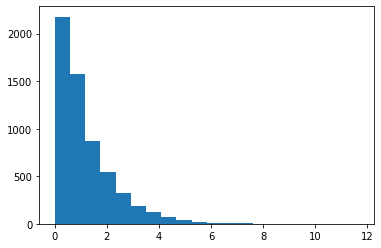

In [5]:
mean_counts = np.mean(count_df[[c for c in count_df.columns if 'RR' in c]], axis=1)
plt.hist(np.log2(mean_counts + 1), bins=20)

In [6]:
count_df_nn = count_df[mean_counts > 2.5]
# Drop any genes that didn't have any counts then save
count_df_nn.to_csv(f'{output_folder}counts_abundent_{exp_name}.csv', index=False)


In [7]:
count_df_nn

,gene,id,gene,gene_biotype,ERR3327115,ERR3327117,ERR3327119,ERR3327118,ERR3327116,ERR3327114
39,gene-PA14_RS04855,NC_008463.1:1038137-1039403,None,protein_coding,9,8,6,8,1,5
41,gene-PA14_RS04865,NC_008463.1:1040069-1040426,rsfS,protein_coding,0,4,4,4,1,3
43,gene-PA14_RS04875,NC_008463.1:1040913-1042854,mrdA,protein_coding,5,5,5,2,3,3
46,gene-PA14_RS04885,NC_008463.1:1043997-1045020,mltB,protein_coding,3,5,4,10,4,1
47,gene-PA14_RS04890,NC_008463.1:1045016-1046042,rlpA,protein_coding,10,11,13,13,1,3
...,...,...,...,...,...,...,...,...,...,...
5891,gene-PA14_RS04360,NC_008463.1:935421-936666,None,protein_coding,4,2,4,6,0,6
5908,gene-PA14_RS04440,NC_008463.1:952771-953062,None,protein_coding,12,5,6,9,3,2
5931,gene-PA14_RS04545,NC_008463.1:978923-979808,None,protein_coding,5,5,7,4,4,2
5944,gene-PA14_RS04610,NC_008463.1:988434-989556,ribD,protein_coding,4,3,6,7,3,2


## Write a MSA so we can double check the choices make sense

In [8]:
species_columns = [c for c in count_df.columns if 'RR' in c]
species_df = count_df_nn[['id', 'species'] + species_columns]

min_counts = np.min(species_df[species_columns].values, axis=1)
# Get the genes that had at least 30 counts in each...
species_df = species_df[min_counts > 30]
gene_location = 'GB_GCA_014170915.1~CP059988.1-#2' # psi is at 512.
ref = pysam.FastaFile(f'{genome_dir}ssu_all_r207_gr1400.fna')
for bam in bams:
    samfile = pysam.AlignmentFile(f'{bam}', "rb")
    write_msa_over_gene(gene_location, samfile, ref, f'{output_folder}msas/{bam.split("/")[-1].split(".")[0]}.msa',
                        read_dict=read_dict)
    samfile.close()

KeyError: "['species'] not in index"

## Create the h5 files that will be used for training and testing

In [9]:
fasta = ecoli_info['reference_fasta_path'].values[0].replace('.fna', '_transcripts.fasta')

for bam in bams:
    print(bam)
    read_dict = gen_mapping_gene_read_dict(bam, gtf)
    output_name = f'{output_folder}training_new/{bam.split("/")[-1].split(".")[0]}_training.h5'
    gen_training_h5py_position(bam, fasta, read_dict,
                                   output_filename=output_name,
                                   min_coverage=20, max_coverage=100)

../runs/ERR3327115.sorted.bam


  1%| | 44/3414 [00:00<00:09, 345.20i

ERR3327115.152243
ERR3327115.138306


  7%| | 225/3414 [00:04<01:03, 50.04i

ERR3327115.266738
ERR3327115.551191
ERR3327115.122964
ERR3327115.189660
ERR3327115.271009
ERR3327115.253735
ERR3327115.526323
ERR3327115.389
ERR3327115.452745


 11%| | 363/3414 [00:05<00:26, 117.20

ERR3327115.219020
ERR3327115.326775
ERR3327115.55945
ERR3327115.138376
ERR3327115.338728
ERR3327115.584319
ERR3327115.176793
ERR3327115.201877
ERR3327115.163015
ERR3327115.1
ERR3327115.134445


 12%| | 423/3414 [00:05<00:19, 157.37

ERR3327115.410280
ERR3327115.186088
ERR3327115.205706
ERR3327115.140214
ERR3327115.366299
ERR3327115.165540
ERR3327115.151411
ERR3327115.202012
ERR3327115.176913
ERR3327115.154672
ERR3327115.133614
ERR3327115.574499
ERR3327115.249384
ERR3327115.247514
ERR3327115.469264
ERR3327115.57457


 15%|▏| 506/3414 [00:05<00:13, 209.96

ERR3327115.134543
ERR3327115.166725
ERR3327115.288528
ERR3327115.222843
ERR3327115.194982
ERR3327115.434769
ERR3327115.124315
ERR3327115.448
ERR3327115.174085


 18%|▏| 622/3414 [00:05<00:09, 308.09

ERR3327115.538240
ERR3327115.117358
ERR3327115.184144
ERR3327115.246378
ERR3327115.234286
ERR3327115.277
ERR3327115.150859
ERR3327115.131506
ERR3327115.159505
ERR3327115.125201
ERR3327115.247554
ERR3327115.181
ERR3327115.321267
ERR3327115.272697
ERR3327115.166390
ERR3327115.155959
ERR3327115.186125
ERR3327115.408796
ERR3327115.547702


 19%|▏| 665/3414 [00:06<00:17, 158.92

ERR3327115.7531
ERR3327115.230046
ERR3327115.131401
ERR3327115.377453
ERR3327115.203084
ERR3327115.216864
ERR3327115.195937
ERR3327115.571974
ERR3327115.159305


 22%|▏| 736/3414 [00:06<00:14, 184.04

ERR3327115.359573
ERR3327115.469970


 26%|▎| 893/3414 [00:07<00:07, 355.84

ERR3327115.239263
ERR3327115.179974
ERR3327115.267956
ERR3327115.407221


 29%|▎| 992/3414 [00:07<00:07, 327.25

ERR3327115.156970
ERR3327115.126806
ERR3327115.281454
ERR3327115.159636
ERR3327115.124314
ERR3327115.177660
ERR3327115.75256
ERR3327115.208151
ERR3327115.384268
ERR3327115.574393


 30%|▎| 1038/3414 [00:07<00:06, 355.2

ERR3327115.201957
ERR3327115.138682
ERR3327115.169185
ERR3327115.252809
ERR3327115.143894


 33%|▎| 1141/3414 [00:07<00:05, 440.8

ERR3327115.79792
ERR3327115.299470
ERR3327115.149746
ERR3327115.364858
ERR3327115.404698
ERR3327115.162708
ERR3327115.411554
ERR3327115.417181
ERR3327115.206336
ERR3327115.184194
ERR3327115.169018
ERR3327115.191158
ERR3327115.423971
ERR3327115.295876
ERR3327115.159535
ERR3327115.550960
ERR3327115.163149
ERR3327115.54564
ERR3327115.168601
ERR3327115.119536
ERR3327115.148127
ERR3327115.312608
ERR3327115.148189


 37%|▎| 1277/3414 [00:08<00:06, 347.7

ERR3327115.285192
ERR3327115.277783
ERR3327115.147036
ERR3327115.581259
ERR3327115.134290
ERR3327115.211025
ERR3327115.519953


 41%|▍| 1407/3414 [00:08<00:04, 456.8

ERR3327115.171426
ERR3327115.139815
ERR3327115.214235
ERR3327115.154419


 44%|▍| 1511/3414 [00:08<00:05, 337.5

ERR3327115.428644
ERR3327115.177


 48%|▍| 1633/3414 [00:09<00:04, 357.7

ERR3327115.34398
ERR3327115.173645
ERR3327115.146886
ERR3327115.406091


 51%|▌| 1750/3414 [00:09<00:04, 360.2

ERR3327115.304908
ERR3327115.574415


 53%|▌| 1826/3414 [00:09<00:03, 442.6

ERR3327115.141819
ERR3327115.117298
ERR3327115.146411
ERR3327115.510804
ERR3327115.480882
ERR3327115.447226
ERR3327115.415179
ERR3327115.303947
ERR3327115.141830
ERR3327115.465638
ERR3327115.127254
ERR3327115.157005


 55%|▌| 1878/3414 [00:09<00:04, 338.9

ERR3327115.283032
ERR3327115.442233
ERR3327115.185289
ERR3327115.425878
ERR3327115.152968
ERR3327115.413814
ERR3327115.167353


 57%|▌| 1959/3414 [00:10<00:04, 323.3

ERR3327115.218849
ERR3327115.150389
ERR3327115.122788
ERR3327115.298726
ERR3327115.329176
ERR3327115.191630
ERR3327115.134446
ERR3327115.169188
ERR3327115.172247
ERR3327115.144917
ERR3327115.126829
ERR3327115.526308
ERR3327115.436003
ERR3327115.197781
ERR3327115.151316
ERR3327115.261351
ERR3327115.142623
ERR3327115.291165
ERR3327115.257150
ERR3327115.130897
ERR3327115.213789


 61%|▌| 2066/3414 [00:10<00:03, 402.3

ERR3327115.128586
ERR3327115.197889


 64%|▋| 2175/3414 [00:10<00:03, 376.4

ERR3327115.288653
ERR3327115.143022
ERR3327115.252822
ERR3327115.356839


 65%|▋| 2218/3414 [00:11<00:05, 229.3

ERR3327115.205394
ERR3327115.509326
ERR3327115.289376
ERR3327115.369572
ERR3327115.123860
ERR3327115.359569


 70%|▋| 2374/3414 [00:12<00:06, 159.5

ERR3327115.151772
ERR3327115.160783
ERR3327115.168788
ERR3327115.125268
ERR3327115.141144
ERR3327115.6028
ERR3327115.194025


 73%|▋| 2481/3414 [00:12<00:03, 238.9

ERR3327115.289668
ERR3327115.125696
ERR3327115.126353
ERR3327115.135978


 75%|▊| 2563/3414 [00:13<00:03, 275.7

ERR3327115.141330
ERR3327115.460068
ERR3327115.138973


 76%|▊| 2601/3414 [00:13<00:03, 261.7

ERR3327115.469982
ERR3327115.129312
ERR3327115.417872
ERR3327115.145043


 78%|▊| 2668/3414 [00:13<00:03, 245.6

ERR3327115.202484
ERR3327115.166108
ERR3327115.508028
ERR3327115.134558


 81%|▊| 2782/3414 [00:13<00:01, 357.9

ERR3327115.11103
ERR3327115.230154
ERR3327115.132032
ERR3327115.134273
ERR3327115.230396
ERR3327115.315655
ERR3327115.124279
ERR3327115.485332


 88%|▉| 2994/3414 [00:13<00:00, 513.4

ERR3327115.273223
ERR3327115.382768
ERR3327115.165293
ERR3327115.367471
ERR3327115.198015
ERR3327115.497030
ERR3327115.129755
ERR3327115.136289
ERR3327115.160982
ERR3327115.165086


 96%|▉| 3288/3414 [00:14<00:00, 415.0

ERR3327115.318207
ERR3327115.157034
ERR3327115.589219
ERR3327115.69595
ERR3327115.138544
ERR3327115.264435
ERR3327115.183755
ERR3327115.272615
ERR3327115.36286
ERR3327115.215144
ERR3327115.198476
ERR3327115.294429
ERR3327115.371205
ERR3327115.125933
ERR3327115.165577
ERR3327115.6139
ERR3327115.323173


 98%|▉| 3346/3414 [00:15<00:00, 234.9

ERR3327115.157244
ERR3327115.357859
ERR3327115.139443
ERR3327115.11213
ERR3327115.265736
ERR3327115.344304
ERR3327115.328295
ERR3327115.123421
ERR3327115.124197
ERR3327115.157630
ERR3327115.186320
ERR3327115.180238
ERR3327115.503774
ERR3327115.400271


100%|█| 3414/3414 [00:15<00:00, 218.1


../runs/ERR3327117.sorted.bam


  8%| | 256/3118 [00:00<00:03, 742.25

ERR3327117.69220
ERR3327117.65144
ERR3327117.59141
ERR3327117.56442
ERR3327117.70537
ERR3327117.51893
ERR3327117.66979
ERR3327117.52385
ERR3327117.51863
ERR3327117.55367
ERR3327117.61717
ERR3327117.49056
ERR3327117.75052
ERR3327117.21032
ERR3327117.78257
ERR3327117.15252
ERR3327117.63136
ERR3327117.50795
ERR3327117.65408
ERR3327117.63034
ERR3327117.65653
ERR3327117.54634
ERR3327117.64608
ERR3327117.65602
ERR3327117.47124
ERR3327117.62160
ERR3327117.73952
ERR3327117.16359
ERR3327117.81004
ERR3327117.23496
ERR3327117.50460
ERR3327117.85537
ERR3327117.80706
ERR3327117.87865
ERR3327117.87537
ERR3327117.80973
ERR3327117.55045


 11%| | 343/3118 [00:00<00:03, 734.37

ERR3327117.87431
ERR3327117.51972
ERR3327117.67783
ERR3327117.56682
ERR3327117.81757
ERR3327117.75463
ERR3327117.51038
ERR3327117.75083
ERR3327117.53655
ERR3327117.85554
ERR3327117.86650
ERR3327117.70474
ERR3327117.71556
ERR3327117.18135
ERR3327117.79742
ERR3327117.55721
ERR3327117.72577
ERR3327117.49092
ERR3327117.59344
ERR3327117.49169
ERR3327117.49085
ERR3327117.55111
ERR3327117.71501
ERR3327117.77266
ERR3327117.53356
ERR3327117.59865
ERR3327117.15369
ERR3327117.57165
ERR3327117.56333
ERR3327117.87559
ERR3327117.54235
ERR3327117.78835
ERR3327117.80946
ERR3327117.59120
ERR3327117.56783
ERR3327117.61696


 14%|▏| 423/3118 [00:00<00:04, 559.97

ERR3327117.49121
ERR3327117.76328
ERR3327117.40699
ERR3327117.40797
ERR3327117.53802
ERR3327117.80439
ERR3327117.77422
ERR3327117.18138
ERR3327117.49711
ERR3327117.53816
ERR3327117.81656
ERR3327117.72034
ERR3327117.32152
ERR3327117.56998
ERR3327117.57711
ERR3327117.63574
ERR3327117.58385
ERR3327117.53874
ERR3327117.57264
ERR3327117.50139
ERR3327117.54203
ERR3327117.82073
ERR3327117.66643
ERR3327117.31489
ERR3327117.64941
ERR3327117.63470
ERR3327117.61288
ERR3327117.68387
ERR3327117.87216
ERR3327117.57445


 16%|▏| 490/3118 [00:00<00:04, 558.14

ERR3327117.62956
ERR3327117.64465
ERR3327117.30682
ERR3327117.52235
ERR3327117.56202
ERR3327117.58897
ERR3327117.83709
ERR3327117.58191
ERR3327117.69291
ERR3327117.72258
ERR3327117.9134
ERR3327117.75219
ERR3327117.62696
ERR3327117.78907
ERR3327117.57370
ERR3327117.53785
ERR3327117.72991
ERR3327117.53890
ERR3327117.7024
ERR3327117.51351
ERR3327117.73136
ERR3327117.78355
ERR3327117.84446
ERR3327117.49508
ERR3327117.73059
ERR3327117.79571
ERR3327117.55416
ERR3327117.61310
ERR3327117.65632
ERR3327117.81708
ERR3327117.79577
ERR3327117.75887


 18%|▏| 551/3118 [00:01<00:06, 382.06

ERR3327117.62717
ERR3327117.51169
ERR3327117.60631
ERR3327117.71610
ERR3327117.69988
ERR3327117.51204
ERR3327117.52809
ERR3327117.51403
ERR3327117.80157
ERR3327117.54749
ERR3327117.51410
ERR3327117.66239
ERR3327117.80962
ERR3327117.64742
ERR3327117.67681
ERR3327117.54761
ERR3327117.48530
ERR3327117.66971
ERR3327117.61117
ERR3327117.80670
ERR3327117.41823
ERR3327117.75421
ERR3327117.87375
ERR3327117.49236
ERR3327117.73174
ERR3327117.59201
ERR3327117.64475
ERR3327117.69477
ERR3327117.74329
ERR3327117.73599
ERR3327117.59258
ERR3327117.78504
ERR3327117.79190
ERR3327117.66019
ERR3327117.67930
ERR3327117.58229
ERR3327117.71840
ERR3327117.55810
ERR3327117.16989
ERR3327117.56480
ERR3327117.85318
ERR3327117.66061
ERR3327117.53805
ERR3327117.49523
ERR3327117.69024
ERR3327117.81758
ERR3327117.68511
ERR3327117.79195
ERR3327117.73078
ERR3327117.62323
ERR3327117.54603
ERR3327117.76385
ERR3327117.49231
ERR3327117.57190
ERR3327117.82282
ERR3327117.75917


 19%|▏| 598/3118 [00:01<00:12, 203.13

ERR3327117.53465
ERR3327117.62238
ERR3327117.65312
ERR3327117.51954
ERR3327117.50040
ERR3327117.34150
ERR3327117.76550
ERR3327117.52306


 26%|▎| 822/3118 [00:02<00:06, 370.34

ERR3327117.80417
ERR3327117.64861
ERR3327117.72488
ERR3327117.60697
ERR3327117.79560
ERR3327117.18780
ERR3327117.16734


 29%|▎| 898/3118 [00:02<00:05, 442.76

ERR3327117.66109
ERR3327117.31169
ERR3327117.65486
ERR3327117.53409
ERR3327117.65037
ERR3327117.66614
ERR3327117.79754
ERR3327117.59230
ERR3327117.73196
ERR3327117.76676
ERR3327117.87389
ERR3327117.55999
ERR3327117.54690
ERR3327117.36041
ERR3327117.49263
ERR3327117.71990
ERR3327117.17111
ERR3327117.73130
ERR3327117.72499
ERR3327117.74941
ERR3327117.86424
ERR3327117.66414


 32%|▎| 992/3118 [00:02<00:04, 490.19

ERR3327117.87351
ERR3327117.66730
ERR3327117.67248
ERR3327117.22232
ERR3327117.52416
ERR3327117.80928
ERR3327117.74165
ERR3327117.53443
ERR3327117.75873
ERR3327117.71755
ERR3327117.13885
ERR3327117.74658
ERR3327117.55896
ERR3327117.84233
ERR3327117.68981
ERR3327117.82563
ERR3327117.60717
ERR3327117.65627
ERR3327117.52832
ERR3327117.80716
ERR3327117.56194
ERR3327117.33794
ERR3327117.51869
ERR3327117.57751
ERR3327117.72171
ERR3327117.63690
ERR3327117.55211
ERR3327117.59432
ERR3327117.49820
ERR3327117.76006
ERR3327117.86512
ERR3327117.69638
ERR3327117.54780
ERR3327117.56403
ERR3327117.81003
ERR3327117.86127
ERR3327117.24095
ERR3327117.77932
ERR3327117.77619
ERR3327117.86580
ERR3327117.55403
ERR3327117.47500


 34%|▎| 1053/3118 [00:03<00:11, 174.9

ERR3327117.72579
ERR3327117.59792
ERR3327117.77013
ERR3327117.49275
ERR3327117.69172
ERR3327117.85785
ERR3327117.63202
ERR3327117.86684
ERR3327117.54209
ERR3327117.20862
ERR3327117.22735
ERR3327117.49540
ERR3327117.68590
ERR3327117.77943
ERR3327117.67000
ERR3327117.76132
ERR3327117.50095
ERR3327117.19970
ERR3327117.80528
ERR3327117.54726
ERR3327117.83281
ERR3327117.51395
ERR3327117.49966
ERR3327117.77941
ERR3327117.74340
ERR3327117.69036
ERR3327117.63998
ERR3327117.60691
ERR3327117.82558
ERR3327117.81224
ERR3327117.62862
ERR3327117.87328
ERR3327117.17716
ERR3327117.63572
ERR3327117.71747
ERR3327117.72758
ERR3327117.52223
ERR3327117.69320


 40%|▍| 1244/3118 [00:03<00:05, 332.5

ERR3327117.81474
ERR3327117.82259
ERR3327117.63717
ERR3327117.64776
ERR3327117.50791
ERR3327117.53950


 42%|▍| 1314/3118 [00:03<00:04, 363.0

ERR3327117.86894
ERR3327117.14803
ERR3327117.34112
ERR3327117.53702
ERR3327117.65674
ERR3327117.76820
ERR3327117.86896
ERR3327117.85507
ERR3327117.60469
ERR3327117.77945
ERR3327117.49680
ERR3327117.83871
ERR3327117.74651
ERR3327117.66057
ERR3327117.69691
ERR3327117.56835
ERR3327117.75869


 44%|▍| 1378/3118 [00:03<00:04, 363.2

ERR3327117.55105
ERR3327117.61644
ERR3327117.75130
ERR3327117.76280
ERR3327117.72934


 52%|▌| 1618/3118 [00:04<00:03, 427.9

ERR3327117.61583
ERR3327117.62258
ERR3327117.68502
ERR3327117.73464
ERR3327117.53327
ERR3327117.29009
ERR3327117.60640
ERR3327117.53485
ERR3327117.76314
ERR3327117.60087
ERR3327117.53438
ERR3327117.23666
ERR3327117.82298
ERR3327117.54834
ERR3327117.79936


 54%|▌| 1680/3118 [00:04<00:03, 433.0

ERR3327117.57548
ERR3327117.69616
ERR3327117.13944
ERR3327117.87230
ERR3327117.59992
ERR3327117.40381
ERR3327117.65991
ERR3327117.79160
ERR3327117.34600
ERR3327117.86079
ERR3327117.60338
ERR3327117.55009
ERR3327117.81192
ERR3327117.73853
ERR3327117.61759
ERR3327117.71564
ERR3327117.54610
ERR3327117.69173
ERR3327117.56632
ERR3327117.76482
ERR3327117.13918
ERR3327117.85542
ERR3327117.60497
ERR3327117.14687
ERR3327117.53365
ERR3327117.81916
ERR3327117.21654


 58%|▌| 1796/3118 [00:04<00:03, 435.7

ERR3327117.87236
ERR3327117.65969
ERR3327117.53005
ERR3327117.75884
ERR3327117.57877
ERR3327117.52979
ERR3327117.51671
ERR3327117.55538
ERR3327117.53002
ERR3327117.21364
ERR3327117.66864
ERR3327117.83453
ERR3327117.37900
ERR3327117.62131
ERR3327117.79322
ERR3327117.53777
ERR3327117.70431
ERR3327117.59465
ERR3327117.34504
ERR3327117.79161
ERR3327117.85666
ERR3327117.65421
ERR3327117.61262
ERR3327117.82210
ERR3327117.55022
ERR3327117.66678
ERR3327117.70114
ERR3327117.80714


 63%|▋| 1972/3118 [00:05<00:02, 501.0

ERR3327117.58463
ERR3327117.84888
ERR3327117.64880
ERR3327117.61946
ERR3327117.51626
ERR3327117.60819
ERR3327117.86459
ERR3327117.43362
ERR3327117.72879
ERR3327117.57255
ERR3327117.74475
ERR3327117.61925
ERR3327117.58183
ERR3327117.69653
ERR3327117.66062
ERR3327117.14924
ERR3327117.72698
ERR3327117.79226
ERR3327117.88037
ERR3327117.62434
ERR3327117.62933
ERR3327117.14873
ERR3327117.57092
ERR3327117.81753
ERR3327117.56962
ERR3327117.49568
ERR3327117.54039
ERR3327117.72287
ERR3327117.56007


 68%|▋| 2108/3118 [00:05<00:03, 328.3

ERR3327117.57141
ERR3327117.63498
ERR3327117.58637
ERR3327117.56910
ERR3327117.66274
ERR3327117.53470
ERR3327117.4219
ERR3327117.64254
ERR3327117.34925
ERR3327117.64720
ERR3327117.53016
ERR3327117.60164
ERR3327117.51817
ERR3327117.53218
ERR3327117.81983
ERR3327117.72054
ERR3327117.54195
ERR3327117.54968
ERR3327117.57775


 69%|▋| 2157/3118 [00:05<00:02, 349.5

ERR3327117.86534
ERR3327117.51362
ERR3327117.61134
ERR3327117.50826
ERR3327117.76063
ERR3327117.58196
ERR3327117.52124
ERR3327117.33997
ERR3327117.62180
ERR3327117.60287
ERR3327117.15362
ERR3327117.55375
ERR3327117.36850
ERR3327117.71140
ERR3327117.32254
ERR3327117.49850


 72%|▋| 2248/3118 [00:06<00:02, 333.0

ERR3327117.53867
ERR3327117.72568
ERR3327117.64472
ERR3327117.86554
ERR3327117.53706
ERR3327117.69280
ERR3327117.66900
ERR3327117.54781
ERR3327117.64702
ERR3327117.27162
ERR3327117.68818
ERR3327117.54477
ERR3327117.70914
ERR3327117.30843
ERR3327117.51384
ERR3327117.61695
ERR3327117.26189
ERR3327117.69244
ERR3327117.69243
ERR3327117.50657
ERR3327117.51377
ERR3327117.51066
ERR3327117.71404
ERR3327117.71514
ERR3327117.85747
ERR3327117.58700
ERR3327117.81993
ERR3327117.57593
ERR3327117.57501
ERR3327117.64054
ERR3327117.75318


 73%|▋| 2291/3118 [00:06<00:02, 341.2

ERR3327117.49965
ERR3327117.56246
ERR3327117.63190
ERR3327117.65621
ERR3327117.83219
ERR3327117.16770
ERR3327117.75474
ERR3327117.58570
ERR3327117.57290
ERR3327117.72987


 75%|▊| 2348/3118 [00:06<00:02, 306.3

ERR3327117.22388
ERR3327117.16833
ERR3327117.51348
ERR3327117.77317
ERR3327117.52344
ERR3327117.73913
ERR3327117.51816
ERR3327117.68664
ERR3327117.67127
ERR3327117.76678
ERR3327117.86858
ERR3327117.57943
ERR3327117.64183
ERR3327117.71560


 79%|▊| 2453/3118 [00:06<00:01, 366.0

ERR3327117.54950
ERR3327117.75888
ERR3327117.52437
ERR3327117.868
ERR3327117.85156
ERR3327117.56191
ERR3327117.80227
ERR3327117.49591
ERR3327117.77947
ERR3327117.77865
ERR3327117.67575
ERR3327117.59801
ERR3327117.10059
ERR3327117.18703
ERR3327117.58364


 88%|▉| 2738/3118 [00:07<00:00, 637.1

ERR3327117.53460
ERR3327117.51063
ERR3327117.61597
ERR3327117.16808
ERR3327117.66060
ERR3327117.16838
ERR3327117.52486
ERR3327117.52883
ERR3327117.20433
ERR3327117.80459
ERR3327117.63284
ERR3327117.64975
ERR3327117.62420
ERR3327117.84412
ERR3327117.60153
ERR3327117.16214
ERR3327117.67164
ERR3327117.53029
ERR3327117.66702
ERR3327117.62041
ERR3327117.30715
ERR3327117.13871
ERR3327117.80126
ERR3327117.59657
ERR3327117.16758


 92%|▉| 2875/3118 [00:07<00:00, 548.4

ERR3327117.52783
ERR3327117.53414
ERR3327117.31738
ERR3327117.84408
ERR3327117.71771
ERR3327117.60148
ERR3327117.85498
ERR3327117.68268
ERR3327117.47138
ERR3327117.50334
ERR3327117.83013
ERR3327117.78272
ERR3327117.64216


 94%|▉| 2937/3118 [00:07<00:00, 548.6

ERR3327117.84235
ERR3327117.52180
ERR3327117.51946
ERR3327117.57374
ERR3327117.75475
ERR3327117.51058
ERR3327117.84409
ERR3327117.57859
ERR3327117.75879
ERR3327117.60947
ERR3327117.76318
ERR3327117.55817
ERR3327117.15680
ERR3327117.61826
ERR3327117.70905
ERR3327117.39894
ERR3327117.65849
ERR3327117.67698
ERR3327117.65616
ERR3327117.83014


 96%|▉| 2997/3118 [00:07<00:00, 468.0

ERR3327117.35870
ERR3327117.37227
ERR3327117.16064
ERR3327117.18778
ERR3327117.66700
ERR3327117.79912
ERR3327117.71462
ERR3327117.62326
ERR3327117.87055
ERR3327117.55627
ERR3327117.65760
ERR3327117.54317
ERR3327117.16761
ERR3327117.75459
ERR3327117.14855
ERR3327117.50315
ERR3327117.59348
ERR3327117.50480
ERR3327117.66071
ERR3327117.64970
ERR3327117.58125
ERR3327117.71753
ERR3327117.66288
ERR3327117.59312
ERR3327117.39696
ERR3327117.58499
ERR3327117.68679
ERR3327117.82506
ERR3327117.57224
ERR3327117.56226
ERR3327117.78980
ERR3327117.51819
ERR3327117.73058
ERR3327117.71773
ERR3327117.57646
ERR3327117.59378
ERR3327117.59345
ERR3327117.49160
ERR3327117.59476
ERR3327117.73870
ERR3327117.24458
ERR3327117.83968
ERR3327117.72430
ERR3327117.77115
ERR3327117.45803
ERR3327117.55387
ERR3327117.81584
ERR3327117.60066
ERR3327117.76099
ERR3327117.24700
ERR3327117.13851
ERR3327117.62428
ERR3327117.52135
ERR3327117.86441
ERR3327117.57703
ERR3327117.24768
ERR3327117.23027
ERR3327117.61080
ERR3327117.633

 98%|▉| 3049/3118 [00:08<00:00, 261.1

ERR3327117.84495
ERR3327117.72804
ERR3327117.68258
ERR3327117.2278
ERR3327117.84107
ERR3327117.59376
ERR3327117.53247
ERR3327117.68053
ERR3327117.68376
ERR3327117.75757
ERR3327117.56882
ERR3327117.64926
ERR3327117.63475
ERR3327117.58412
ERR3327117.27837
ERR3327117.84559
ERR3327117.53439
ERR3327117.82353
ERR3327117.67742
ERR3327117.31222
ERR3327117.83862
ERR3327117.58106
ERR3327117.59155
ERR3327117.58147
ERR3327117.84614


100%|█| 3118/3118 [00:08<00:00, 368.3

ERR3327117.27268
ERR3327117.75863
../runs/ERR3327119.sorted.bam



  5%| | 163/3500 [00:00<00:04, 815.43

ERR3327119.173761
ERR3327119.144861
ERR3327119.118497
ERR3327119.116487
ERR3327119.166141
ERR3327119.42294
ERR3327119.130493
ERR3327119.158027
ERR3327119.122289
ERR3327119.143496
ERR3327119.13635
ERR3327119.100124
ERR3327119.118373
ERR3327119.31433
ERR3327119.139684
ERR3327119.116729
ERR3327119.186790
ERR3327119.152910
ERR3327119.120184


  7%| | 245/3500 [00:00<00:04, 689.40

ERR3327119.123344
ERR3327119.157959
ERR3327119.125571
ERR3327119.105641
ERR3327119.13243
ERR3327119.109358
ERR3327119.157010
ERR3327119.109358
ERR3327119.106420
ERR3327119.148454
ERR3327119.111293
ERR3327119.189310
ERR3327119.39776
ERR3327119.105715
ERR3327119.119288
ERR3327119.126047
ERR3327119.155861
ERR3327119.178523
ERR3327119.108954
ERR3327119.153865
ERR3327119.162885
ERR3327119.106373
ERR3327119.175428
ERR3327119.147095
ERR3327119.82825
ERR3327119.155140
ERR3327119.122304
ERR3327119.121291
ERR3327119.33144
ERR3327119.146686
ERR3327119.113828
ERR3327119.117484
ERR3327119.180618
ERR3327119.155620
ERR3327119.83733
ERR3327119.127762
ERR3327119.166274
ERR3327119.180149
ERR3327119.163936
ERR3327119.108950
ERR3327119.184642
ERR3327119.142812
ERR3327119.135944
ERR3327119.144831
ERR3327119.103948
ERR3327119.187929
ERR3327119.106604
ERR3327119.185061
ERR3327119.138596
ERR3327119.125511
ERR3327119.114681
ERR3327119.116917
ERR3327119.159791


  9%| | 316/3500 [00:01<00:19, 165.20

ERR3327119.186373
ERR3327119.183628
ERR3327119.147223
ERR3327119.131686
ERR3327119.138867
ERR3327119.170414
ERR3327119.168471
ERR3327119.108850
ERR3327119.115486
ERR3327119.164217
ERR3327119.104001
ERR3327119.52453
ERR3327119.67859
ERR3327119.2838
ERR3327119.143406
ERR3327119.155334
ERR3327119.40510
ERR3327119.152979
ERR3327119.122090
ERR3327119.103641
ERR3327119.137735
ERR3327119.165399
ERR3327119.175531
ERR3327119.138674
ERR3327119.118554
ERR3327119.121315
ERR3327119.115152
ERR3327119.152286
ERR3327119.48939
ERR3327119.185305


 12%| | 404/3500 [00:01<00:16, 182.65

ERR3327119.115574
ERR3327119.137223
ERR3327119.103675
ERR3327119.127689
ERR3327119.153007
ERR3327119.104545
ERR3327119.174187
ERR3327119.129976
ERR3327119.134931
ERR3327119.124074
ERR3327119.118896
ERR3327119.120563
ERR3327119.132869
ERR3327119.180102
ERR3327119.107868
ERR3327119.184163
ERR3327119.182648
ERR3327119.143850
ERR3327119.128282
ERR3327119.182186
ERR3327119.133503
ERR3327119.136432
ERR3327119.138811
ERR3327119.118863
ERR3327119.132357
ERR3327119.133121
ERR3327119.147277
ERR3327119.181326
ERR3327119.54761
ERR3327119.184959
ERR3327119.163058
ERR3327119.133158


 12%| | 437/3500 [00:01<00:17, 179.23

ERR3327119.142787
ERR3327119.176187
ERR3327119.184647
ERR3327119.126903
ERR3327119.87428
ERR3327119.130509
ERR3327119.105285
ERR3327119.77265
ERR3327119.176647
ERR3327119.128387
ERR3327119.159826
ERR3327119.119563
ERR3327119.169106
ERR3327119.117938
ERR3327119.147715
ERR3327119.188967
ERR3327119.147232
ERR3327119.126939
ERR3327119.134162
ERR3327119.112621
ERR3327119.103906
ERR3327119.63640
ERR3327119.175665
ERR3327119.124736
ERR3327119.116924
ERR3327119.109461
ERR3327119.188655
ERR3327119.154116
ERR3327119.123147
ERR3327119.132906


 16%|▏| 562/3500 [00:06<00:50, 58.36i

ERR3327119.148448
ERR3327119.160697
ERR3327119.114639
ERR3327119.153526
ERR3327119.174202
ERR3327119.104057
ERR3327119.187161
ERR3327119.139809
ERR3327119.130550
ERR3327119.104093
ERR3327119.111160
ERR3327119.160587
ERR3327119.156199
ERR3327119.173896
ERR3327119.188892
ERR3327119.161552
ERR3327119.183136
ERR3327119.127479


 17%|▏| 600/3500 [00:06<00:39, 73.03i

ERR3327119.108880
ERR3327119.181123
ERR3327119.143178
ERR3327119.118112
ERR3327119.138053
ERR3327119.158324
ERR3327119.147884
ERR3327119.184059
ERR3327119.165464
ERR3327119.113805
ERR3327119.146656
ERR3327119.188114
ERR3327119.181826
ERR3327119.181793
ERR3327119.186023
ERR3327119.131756
ERR3327119.110400
ERR3327119.115413
ERR3327119.135316
ERR3327119.139942
ERR3327119.132827
ERR3327119.124328
ERR3327119.103689
ERR3327119.148919
ERR3327119.159022


 18%|▏| 634/3500 [00:08<00:58, 48.62i

ERR3327119.140940
ERR3327119.46847
ERR3327119.128407
ERR3327119.125889
ERR3327119.125381
ERR3327119.115234
ERR3327119.159908
ERR3327119.4339
ERR3327119.115621
ERR3327119.37974
ERR3327119.131299
ERR3327119.141473
ERR3327119.39565
ERR3327119.161489
ERR3327119.167844
ERR3327119.182205
ERR3327119.115533
ERR3327119.159897
ERR3327119.103673
ERR3327119.115842
ERR3327119.156998
ERR3327119.118333
ERR3327119.55952
ERR3327119.167712
ERR3327119.104748


 19%|▏| 659/3500 [00:08<00:51, 54.66i

ERR3327119.184623
ERR3327119.121913
ERR3327119.155104
ERR3327119.155246
ERR3327119.179562
ERR3327119.150981
ERR3327119.143710
ERR3327119.131348
ERR3327119.180572
ERR3327119.49995
ERR3327119.119652
ERR3327119.131780
ERR3327119.105403
ERR3327119.187500
ERR3327119.129780
ERR3327119.113070
ERR3327119.108509
ERR3327119.163969
ERR3327119.54564
ERR3327119.156438
ERR3327119.189325
ERR3327119.185726
ERR3327119.46937
ERR3327119.158824
ERR3327119.136216
ERR3327119.180230
ERR3327119.176738
ERR3327119.129055
ERR3327119.158477
ERR3327119.129533
ERR3327119.65691
ERR3327119.117265
ERR3327119.130654
ERR3327119.140268
ERR3327119.175691
ERR3327119.121615
ERR3327119.135325
ERR3327119.38697
ERR3327119.167667
ERR3327119.126029
ERR3327119.137908
ERR3327119.141178
ERR3327119.132637
ERR3327119.135325
ERR3327119.103925
ERR3327119.31184
ERR3327119.120138
ERR3327119.182223
ERR3327119.146398
ERR3327119.168740
ERR3327119.161371
ERR3327119.64018
ERR3327119.166614
ERR3327119.143470
ERR3327119.107063
ERR3327119.166644

 19%|▏| 680/3500 [00:09<00:56, 49.51i

ERR3327119.138886
ERR3327119.101813
ERR3327119.103872
ERR3327119.119856
ERR3327119.184509
ERR3327119.125651
ERR3327119.101117
ERR3327119.148247
ERR3327119.119130
ERR3327119.187412
ERR3327119.148358
ERR3327119.132971
ERR3327119.105692
ERR3327119.108257
ERR3327119.167277
ERR3327119.132371
ERR3327119.106967
ERR3327119.51905
ERR3327119.129016
ERR3327119.123046
ERR3327119.146009


 20%|▏| 696/3500 [00:09<00:57, 48.50i

ERR3327119.139465
ERR3327119.128848
ERR3327119.180087
ERR3327119.187414
ERR3327119.129448
ERR3327119.12636
ERR3327119.115386
ERR3327119.115029
ERR3327119.109699
ERR3327119.40123
ERR3327119.159104
ERR3327119.86669
ERR3327119.140015
ERR3327119.188106
ERR3327119.188923
ERR3327119.184899
ERR3327119.162511
ERR3327119.119489
ERR3327119.116700
ERR3327119.174102
ERR3327119.12731
ERR3327119.188611
ERR3327119.155238
ERR3327119.186227
ERR3327119.121872
ERR3327119.12879
ERR3327119.125675
ERR3327119.112770
ERR3327119.188268
ERR3327119.147874
ERR3327119.134654
ERR3327119.131198
ERR3327119.141209
ERR3327119.151850
ERR3327119.189418
ERR3327119.137269
ERR3327119.156084
ERR3327119.109686
ERR3327119.143189
ERR3327119.117219


 21%|▏| 743/3500 [00:09<00:36, 76.39i

ERR3327119.147209
ERR3327119.103852
ERR3327119.145259
ERR3327119.173764
ERR3327119.100
ERR3327119.133891
ERR3327119.119353
ERR3327119.140544
ERR3327119.122427
ERR3327119.111353
ERR3327119.19174
ERR3327119.105631
ERR3327119.123650
ERR3327119.166582
ERR3327119.139893
ERR3327119.184494
ERR3327119.170821
ERR3327119.188544


 25%|▎| 881/3500 [00:09<00:13, 187.42

ERR3327119.127461
ERR3327119.152616
ERR3327119.143494
ERR3327119.170629
ERR3327119.111177
ERR3327119.128606
ERR3327119.135970
ERR3327119.156778
ERR3327119.41630
ERR3327119.33655
ERR3327119.151213
ERR3327119.181852
ERR3327119.152543
ERR3327119.33671


 28%|▎| 972/3500 [00:10<00:10, 252.48

ERR3327119.188918
ERR3327119.123694
ERR3327119.188913
ERR3327119.117270
ERR3327119.165885
ERR3327119.107035
ERR3327119.6168
ERR3327119.60259
ERR3327119.176678
ERR3327119.33684
ERR3327119.128829


 33%|▎| 1140/3500 [00:10<00:05, 463.8

ERR3327119.183690
ERR3327119.67172
ERR3327119.108269
ERR3327119.131903
ERR3327119.118009
ERR3327119.121507
ERR3327119.128952
ERR3327119.161128
ERR3327119.116118
ERR3327119.152978
ERR3327119.124714
ERR3327119.116751
ERR3327119.181055
ERR3327119.187778
ERR3327119.116923
ERR3327119.35331
ERR3327119.124302
ERR3327119.178164
ERR3327119.116802
ERR3327119.127940
ERR3327119.163306
ERR3327119.129994
ERR3327119.185453
ERR3327119.107085
ERR3327119.89289
ERR3327119.158951
ERR3327119.68755
ERR3327119.74877
ERR3327119.58827
ERR3327119.104318
ERR3327119.123443
ERR3327119.123229
ERR3327119.134592
ERR3327119.103581
ERR3327119.142072
ERR3327119.158040
ERR3327119.166065
ERR3327119.68555
ERR3327119.124908
ERR3327119.72474
ERR3327119.29061
ERR3327119.120283
ERR3327119.146047
ERR3327119.125509
ERR3327119.128826
ERR3327119.151066
ERR3327119.137718
ERR3327119.131340
ERR3327119.138925
ERR3327119.159049
ERR3327119.163207
ERR3327119.126860
ERR3327119.162425
ERR3327119.125982
ERR3327119.165697
ERR3327119.129943
E

 34%|▎| 1203/3500 [00:10<00:09, 236.3

ERR3327119.125286
ERR3327119.120402
ERR3327119.145068
ERR3327119.142615
ERR3327119.140187
ERR3327119.109925
ERR3327119.174263
ERR3327119.119114
ERR3327119.117217
ERR3327119.149003
ERR3327119.50784
ERR3327119.171871
ERR3327119.181204
ERR3327119.131048
ERR3327119.117508
ERR3327119.128817
ERR3327119.19928
ERR3327119.135465
ERR3327119.182346
ERR3327119.161402
ERR3327119.103806
ERR3327119.131109


 38%|▍| 1314/3500 [00:11<00:07, 298.5

ERR3327119.45936
ERR3327119.146851
ERR3327119.125752
ERR3327119.146610
ERR3327119.182689
ERR3327119.163116
ERR3327119.161714
ERR3327119.161800
ERR3327119.185813
ERR3327119.135322
ERR3327119.140551
ERR3327119.139776
ERR3327119.100912
ERR3327119.147794
ERR3327119.133549
ERR3327119.120829
ERR3327119.139769
ERR3327119.186357
ERR3327119.111339
ERR3327119.133772
ERR3327119.188475
ERR3327119.174277
ERR3327119.185713


 42%|▍| 1472/3500 [00:11<00:04, 470.4

ERR3327119.84903
ERR3327119.137574
ERR3327119.125437
ERR3327119.132180
ERR3327119.170631
ERR3327119.124450
ERR3327119.166447
ERR3327119.187424
ERR3327119.185021
ERR3327119.148801
ERR3327119.158850
ERR3327119.35202
ERR3327119.135717
ERR3327119.188980
ERR3327119.184087
ERR3327119.139907
ERR3327119.180538
ERR3327119.189371
ERR3327119.107850
ERR3327119.12658
ERR3327119.156535
ERR3327119.33048
ERR3327119.128724
ERR3327119.137613
ERR3327119.133345
ERR3327119.144346
ERR3327119.159916
ERR3327119.143248
ERR3327119.177838
ERR3327119.156025
ERR3327119.188686
ERR3327119.147078
ERR3327119.122335
ERR3327119.106054
ERR3327119.139584
ERR3327119.135805
ERR3327119.161445
ERR3327119.107754
ERR3327119.144883
ERR3327119.176108
ERR3327119.146772
ERR3327119.119956
ERR3327119.157306
ERR3327119.188693
ERR3327119.112670
ERR3327119.132384
ERR3327119.60236
ERR3327119.133701
ERR3327119.108745
ERR3327119.115686
ERR3327119.153503
ERR3327119.166114
ERR3327119.167629
ERR3327119.119627
ERR3327119.34301
ERR3327119.15742

 47%|▍| 1640/3500 [00:11<00:04, 439.3

ERR3327119.138240
ERR3327119.153080
ERR3327119.183270
ERR3327119.18471
ERR3327119.113396
ERR3327119.128296
ERR3327119.105081
ERR3327119.24389
ERR3327119.127510
ERR3327119.104380
ERR3327119.144813
ERR3327119.109290
ERR3327119.108965
ERR3327119.134989
ERR3327119.144798
ERR3327119.103586
ERR3327119.154247
ERR3327119.179057
ERR3327119.143460
ERR3327119.116220
ERR3327119.147190
ERR3327119.151853


 49%|▍| 1705/3500 [00:11<00:03, 459.4

ERR3327119.123901
ERR3327119.127477
ERR3327119.161633
ERR3327119.159749
ERR3327119.175690
ERR3327119.124601
ERR3327119.105064
ERR3327119.121056
ERR3327119.142873
ERR3327119.179556
ERR3327119.151939
ERR3327119.136228
ERR3327119.151977
ERR3327119.118524
ERR3327119.162359
ERR3327119.120032
ERR3327119.141238
ERR3327119.125110
ERR3327119.32046
ERR3327119.136943


 52%|▌| 1834/3500 [00:12<00:03, 426.3

ERR3327119.145486
ERR3327119.161743
ERR3327119.147154
ERR3327119.176653
ERR3327119.122370
ERR3327119.125575
ERR3327119.134605
ERR3327119.137241
ERR3327119.129383
ERR3327119.138842
ERR3327119.142096
ERR3327119.107333
ERR3327119.38684
ERR3327119.52850
ERR3327119.34047
ERR3327119.161454
ERR3327119.111094
ERR3327119.126159
ERR3327119.181811
ERR3327119.118566
ERR3327119.151972


 54%|▌| 1890/3500 [00:12<00:03, 413.4

ERR3327119.172045
ERR3327119.151914
ERR3327119.131813
ERR3327119.177741
ERR3327119.138526
ERR3327119.171124
ERR3327119.117521
ERR3327119.135452
ERR3327119.123394
ERR3327119.154546
ERR3327119.188694
ERR3327119.166163
ERR3327119.172765
ERR3327119.148317
ERR3327119.175554
ERR3327119.130364
ERR3327119.48595
ERR3327119.16349
ERR3327119.188999
ERR3327119.164377
ERR3327119.136359
ERR3327119.176079
ERR3327119.187219
ERR3327119.155387
ERR3327119.142269
ERR3327119.166224
ERR3327119.108263
ERR3327119.128050
ERR3327119.128179
ERR3327119.186346
ERR3327119.52303
ERR3327119.103801
ERR3327119.117499
ERR3327119.59583
ERR3327119.139460
ERR3327119.116282
ERR3327119.117108
ERR3327119.168142
ERR3327119.128444
ERR3327119.143804
ERR3327119.184362
ERR3327119.139345
ERR3327119.124719
ERR3327119.185313
ERR3327119.124138
ERR3327119.185804
ERR3327119.123289
ERR3327119.103736
ERR3327119.144445
ERR3327119.112716


 57%|▌| 1985/3500 [00:12<00:05, 300.5

ERR3327119.151788
ERR3327119.169246
ERR3327119.113062
ERR3327119.120827
ERR3327119.171545
ERR3327119.162449
ERR3327119.186380
ERR3327119.51644
ERR3327119.187035
ERR3327119.112989
ERR3327119.120104
ERR3327119.122455
ERR3327119.109677
ERR3327119.131211
ERR3327119.176226
ERR3327119.176230
ERR3327119.165534
ERR3327119.131877
ERR3327119.119371
ERR3327119.146485
ERR3327119.125991
ERR3327119.104219


 60%|▌| 2107/3500 [00:13<00:03, 398.0

ERR3327119.50162
ERR3327119.138423
ERR3327119.181699
ERR3327119.151745
ERR3327119.48222
ERR3327119.39473
ERR3327119.99354
ERR3327119.113798
ERR3327119.75399
ERR3327119.128111
ERR3327119.111407
ERR3327119.107057
ERR3327119.134768
ERR3327119.122638
ERR3327119.111271
ERR3327119.145449
ERR3327119.184953
ERR3327119.112420
ERR3327119.186563
ERR3327119.122853
ERR3327119.146003
ERR3327119.116849
ERR3327119.149480
ERR3327119.129076
ERR3327119.119501
ERR3327119.154073
ERR3327119.129430
ERR3327119.119497
ERR3327119.160584


 63%|▋| 2200/3500 [00:13<00:03, 390.2

ERR3327119.141592
ERR3327119.134908
ERR3327119.107760
ERR3327119.125641
ERR3327119.117323
ERR3327119.109135
ERR3327119.115962
ERR3327119.152613
ERR3327119.37018
ERR3327119.181248
ERR3327119.179046
ERR3327119.104038
ERR3327119.139504
ERR3327119.118044
ERR3327119.121359
ERR3327119.113067
ERR3327119.39093
ERR3327119.133260
ERR3327119.175946
ERR3327119.142468
ERR3327119.37584


 64%|▋| 2243/3500 [00:13<00:03, 378.9

ERR3327119.169061
ERR3327119.126300
ERR3327119.50105
ERR3327119.110320
ERR3327119.90712
ERR3327119.52980
ERR3327119.156123
ERR3327119.138446
ERR3327119.187810
ERR3327119.43957
ERR3327119.135893
ERR3327119.154160
ERR3327119.134840
ERR3327119.187931
ERR3327119.168967
ERR3327119.163937
ERR3327119.145110


 65%|▋| 2288/3500 [00:15<00:19, 61.50

ERR3327119.23716
ERR3327119.76609
ERR3327119.123509
ERR3327119.124018
ERR3327119.122644
ERR3327119.153124


 69%|▋| 2425/3500 [00:16<00:09, 110.8

ERR3327119.141830
ERR3327119.170028
ERR3327119.62752
ERR3327119.133220
ERR3327119.142200
ERR3327119.133353
ERR3327119.124011
ERR3327119.113081
ERR3327119.163863
ERR3327119.157933
ERR3327119.131598
ERR3327119.108908
ERR3327119.176120
ERR3327119.151224
ERR3327119.122482
ERR3327119.114826
ERR3327119.133315
ERR3327119.172112
ERR3327119.146947
ERR3327119.145889
ERR3327119.124391
ERR3327119.117896
ERR3327119.134787
ERR3327119.121824
ERR3327119.120874
ERR3327119.152306
ERR3327119.29056
ERR3327119.112633
ERR3327119.137122
ERR3327119.172674
ERR3327119.162237


 70%|▋| 2461/3500 [00:16<00:08, 124.4

ERR3327119.181061
ERR3327119.107
ERR3327119.135000
ERR3327119.107912
ERR3327119.173639
ERR3327119.166029
ERR3327119.163976
ERR3327119.118955
ERR3327119.43996
ERR3327119.117893
ERR3327119.119529
ERR3327119.121961
ERR3327119.136050
ERR3327119.144293
ERR3327119.125442
ERR3327119.134571
ERR3327119.54768
ERR3327119.150679
ERR3327119.175662
ERR3327119.117254
ERR3327119.174851
ERR3327119.180470
ERR3327119.146142


 73%|▋| 2563/3500 [00:17<00:04, 210.8

ERR3327119.125004
ERR3327119.170504
ERR3327119.100232
ERR3327119.168407
ERR3327119.168348
ERR3327119.103777
ERR3327119.151986
ERR3327119.105676
ERR3327119.174937
ERR3327119.134075
ERR3327119.179615
ERR3327119.159026
ERR3327119.180632
ERR3327119.45312
ERR3327119.146545


 74%|▋| 2601/3500 [00:17<00:04, 209.5

ERR3327119.127824
ERR3327119.128317
ERR3327119.104567
ERR3327119.121092
ERR3327119.164595
ERR3327119.161585
ERR3327119.176713
ERR3327119.110884
ERR3327119.155892
ERR3327119.137266
ERR3327119.125893
ERR3327119.185707
ERR3327119.171861
ERR3327119.112514
ERR3327119.151913
ERR3327119.146053
ERR3327119.106063
ERR3327119.140122


 75%|▊| 2636/3500 [00:17<00:03, 232.4

ERR3327119.153327
ERR3327119.128701
ERR3327119.173676
ERR3327119.119477
ERR3327119.36585
ERR3327119.33083
ERR3327119.141756
ERR3327119.118919
ERR3327119.67068
ERR3327119.121771
ERR3327119.134366
ERR3327119.138447


 76%|▊| 2670/3500 [00:17<00:04, 182.3

ERR3327119.10766
ERR3327119.137551
ERR3327119.125127
ERR3327119.109561
ERR3327119.167703
ERR3327119.121661
ERR3327119.104238
ERR3327119.148472
ERR3327119.147441
ERR3327119.166814
ERR3327119.105963
ERR3327119.129726
ERR3327119.118428
ERR3327119.119404
ERR3327119.15693
ERR3327119.70462
ERR3327119.158938
ERR3327119.150243
ERR3327119.39758
ERR3327119.156264
ERR3327119.166974
ERR3327119.64909
ERR3327119.127627
ERR3327119.143475
ERR3327119.143805
ERR3327119.157455
ERR3327119.132715
ERR3327119.177812
ERR3327119.120913
ERR3327119.110622
ERR3327119.123198
ERR3327119.123227
ERR3327119.177327
ERR3327119.127014
ERR3327119.180636


 78%|▊| 2733/3500 [00:17<00:04, 189.3

ERR3327119.150594
ERR3327119.134067
ERR3327119.68736
ERR3327119.126098
ERR3327119.139674
ERR3327119.119987
ERR3327119.103864
ERR3327119.153041
ERR3327119.112701
ERR3327119.129325
ERR3327119.189320
ERR3327119.139395
ERR3327119.98947
ERR3327119.119821
ERR3327119.144622
ERR3327119.129749
ERR3327119.116782
ERR3327119.176107
ERR3327119.125655
ERR3327119.41126
ERR3327119.34701
ERR3327119.183652


 82%|▊| 2887/3500 [00:18<00:01, 408.0

ERR3327119.112520
ERR3327119.156642
ERR3327119.135844
ERR3327119.152030
ERR3327119.184079
ERR3327119.177357
ERR3327119.111086
ERR3327119.107428
ERR3327119.32005
ERR3327119.117816
ERR3327119.122965
ERR3327119.152433
ERR3327119.92941
ERR3327119.146810
ERR3327119.187426
ERR3327119.137029
ERR3327119.130747
ERR3327119.144693
ERR3327119.126592
ERR3327119.155215
ERR3327119.132596
ERR3327119.138075


 87%|▊| 3031/3500 [00:18<00:00, 503.8

ERR3327119.166987
ERR3327119.123416
ERR3327119.169302
ERR3327119.170543
ERR3327119.56029
ERR3327119.148049
ERR3327119.110344
ERR3327119.104019
ERR3327119.178531
ERR3327119.144285
ERR3327119.119786
ERR3327119.52547
ERR3327119.141299
ERR3327119.121339
ERR3327119.123690
ERR3327119.133862
ERR3327119.122873
ERR3327119.122662
ERR3327119.113557
ERR3327119.118228
ERR3327119.166422
ERR3327119.140824


 88%|▉| 3090/3500 [00:18<00:00, 496.4

ERR3327119.120591
ERR3327119.118901
ERR3327119.117918
ERR3327119.127920
ERR3327119.27459
ERR3327119.7378
ERR3327119.112105
ERR3327119.182662
ERR3327119.165341
ERR3327119.113577
ERR3327119.135989
ERR3327119.101958
ERR3327119.108983
ERR3327119.126038
ERR3327119.186698
ERR3327119.135625
ERR3327119.131879
ERR3327119.136613
ERR3327119.103978
ERR3327119.181150
ERR3327119.108606
ERR3327119.169334


 90%|▉| 3149/3500 [00:18<00:00, 466.2

ERR3327119.112058
ERR3327119.187895
ERR3327119.181050
ERR3327119.106113
ERR3327119.128802
ERR3327119.158099


 94%|▉| 3284/3500 [00:19<00:00, 458.2

ERR3327119.123231
ERR3327119.141270
ERR3327119.107937
ERR3327119.177921
ERR3327119.154399
ERR3327119.150101
ERR3327119.137344
ERR3327119.96866
ERR3327119.134103
ERR3327119.146760
ERR3327119.180635
ERR3327119.166158
ERR3327119.136939
ERR3327119.181280
ERR3327119.133251
ERR3327119.127813
ERR3327119.106742
ERR3327119.94608
ERR3327119.105706
ERR3327119.152305
ERR3327119.127274
ERR3327119.44982
ERR3327119.151091
ERR3327119.142216
ERR3327119.138499
ERR3327119.35879
ERR3327119.132037
ERR3327119.69285
ERR3327119.114740
ERR3327119.116588
ERR3327119.163205
ERR3327119.57784
ERR3327119.123146
ERR3327119.149


 95%|▉| 3337/3500 [00:19<00:00, 371.7

ERR3327119.163540
ERR3327119.153732
ERR3327119.118498
ERR3327119.151852
ERR3327119.139881
ERR3327119.117420
ERR3327119.158918
ERR3327119.116584
ERR3327119.120711
ERR3327119.115200
ERR3327119.121167
ERR3327119.92673
ERR3327119.126446
ERR3327119.158969
ERR3327119.185762
ERR3327119.185452
ERR3327119.113344
ERR3327119.178940
ERR3327119.140410
ERR3327119.171792
ERR3327119.125633
ERR3327119.119933
ERR3327119.108938
ERR3327119.151557
ERR3327119.106985


 97%|▉| 3381/3500 [00:19<00:00, 341.6

ERR3327119.158941
ERR3327119.57059
ERR3327119.144902
ERR3327119.128547
ERR3327119.163184
ERR3327119.36161
ERR3327119.168145
ERR3327119.110591
ERR3327119.105740
ERR3327119.176538
ERR3327119.135960
ERR3327119.186732
ERR3327119.166981
ERR3327119.140023
ERR3327119.186191
ERR3327119.116957
ERR3327119.118649
ERR3327119.189424
ERR3327119.125721
ERR3327119.173012
ERR3327119.107928
ERR3327119.112689
ERR3327119.149156
ERR3327119.150343
ERR3327119.50264
ERR3327119.118052
ERR3327119.58922
ERR3327119.113349
ERR3327119.178949
ERR3327119.31587
ERR3327119.126204
ERR3327119.107670
ERR3327119.104556
ERR3327119.149914
ERR3327119.185790
ERR3327119.110177
ERR3327119.172987
ERR3327119.153193
ERR3327119.15689
ERR3327119.137577
ERR3327119.165601
ERR3327119.121053
ERR3327119.126658
ERR3327119.162438
ERR3327119.125095
ERR3327119.143042
ERR3327119.118549
ERR3327119.188526
ERR3327119.40450
ERR3327119.140013
ERR3327119.183933
ERR3327119.154322
ERR3327119.110236
ERR3327119.135403
ERR3327119.162310
ERR3327119.118755

 98%|▉| 3420/3500 [00:19<00:00, 186.0

ERR3327119.120375
ERR3327119.116212
ERR3327119.188545
ERR3327119.26288
ERR3327119.122451
ERR3327119.51502
ERR3327119.134890
ERR3327119.114407
ERR3327119.115787
ERR3327119.176050
ERR3327119.170523
ERR3327119.116888
ERR3327119.119955
ERR3327119.161417
ERR3327119.138543
ERR3327119.177823
ERR3327119.169384
ERR3327119.180676
ERR3327119.127635
ERR3327119.181210
ERR3327119.35117
ERR3327119.147236
ERR3327119.145752
ERR3327119.104564
ERR3327119.180668
ERR3327119.112230
ERR3327119.68725
ERR3327119.178421
ERR3327119.110711
ERR3327119.105084
ERR3327119.159054
ERR3327119.133192
ERR3327119.149291


 99%|▉| 3459/3500 [00:20<00:00, 198.4

ERR3327119.135114
ERR3327119.181779
ERR3327119.113064
ERR3327119.112564
ERR3327119.152470
ERR3327119.141728
ERR3327119.168689
ERR3327119.152946
ERR3327119.126584
ERR3327119.162522
ERR3327119.177821
ERR3327119.111316


100%|█| 3500/3500 [00:20<00:00, 173.4


../runs/ERR3327118.sorted.bam


  6%| | 206/3560 [00:00<00:03, 973.88

ERR3327118.62273
ERR3327118.65438
ERR3327118.114056
ERR3327118.92154
ERR3327118.44003
ERR3327118.108477
ERR3327118.85824
ERR3327118.97709
ERR3327118.70128
ERR3327118.85971
ERR3327118.66832
ERR3327118.79096
ERR3327118.111553
ERR3327118.60741


  9%| | 304/3560 [00:00<00:06, 483.95

ERR3327118.81540
ERR3327118.59722
ERR3327118.109487
ERR3327118.105188
ERR3327118.97604
ERR3327118.105187
ERR3327118.112843
ERR3327118.75600
ERR3327118.55713
ERR3327118.83737
ERR3327118.58373
ERR3327118.54579
ERR3327118.93624
ERR3327118.64457
ERR3327118.112637
ERR3327118.57810
ERR3327118.95019
ERR3327118.26480
ERR3327118.44556
ERR3327118.16593
ERR3327118.74376
ERR3327118.106706
ERR3327118.103357
ERR3327118.71169
ERR3327118.12996
ERR3327118.67019
ERR3327118.114144
ERR3327118.85757
ERR3327118.65145
ERR3327118.110298
ERR3327118.49044
ERR3327118.95662


 10%| | 371/3560 [00:00<00:07, 402.35

ERR3327118.1719
ERR3327118.69190
ERR3327118.79268
ERR3327118.85874
ERR3327118.56939
ERR3327118.59393
ERR3327118.72726
ERR3327118.91509
ERR3327118.67272
ERR3327118.79156
ERR3327118.104385
ERR3327118.71413
ERR3327118.10375
ERR3327118.103374
ERR3327118.111580
ERR3327118.45876
ERR3327118.64490
ERR3327118.90457
ERR3327118.20908
ERR3327118.95654
ERR3327118.19532
ERR3327118.17925
ERR3327118.43664
ERR3327118.87490
ERR3327118.78396


 12%| | 423/3560 [00:00<00:08, 351.87

ERR3327118.109129
ERR3327118.55883
ERR3327118.65728
ERR3327118.88488
ERR3327118.59033
ERR3327118.94438
ERR3327118.113855
ERR3327118.54894
ERR3327118.97266
ERR3327118.54412
ERR3327118.71491
ERR3327118.66907
ERR3327118.92307
ERR3327118.56075
ERR3327118.102608
ERR3327118.78934
ERR3327118.109858
ERR3327118.80361
ERR3327118.86129
ERR3327118.107709
ERR3327118.60094
ERR3327118.57254
ERR3327118.37410
ERR3327118.55386
ERR3327118.109908
ERR3327118.101416
ERR3327118.81255
ERR3327118.7819
ERR3327118.79383
ERR3327118.99392
ERR3327118.12447


 14%|▏| 506/3560 [00:01<00:08, 352.51

ERR3327118.43709
ERR3327118.55126
ERR3327118.70126
ERR3327118.61601
ERR3327118.86970
ERR3327118.63168
ERR3327118.14551
ERR3327118.68408
ERR3327118.72212
ERR3327118.88437
ERR3327118.102229
ERR3327118.94473
ERR3327118.89927
ERR3327118.85294
ERR3327118.112996
ERR3327118.90790
ERR3327118.109792
ERR3327118.68977
ERR3327118.81575
ERR3327118.60802
ERR3327118.78614
ERR3327118.88043
ERR3327118.112624
ERR3327118.4333
ERR3327118.61685
ERR3327118.62326
ERR3327118.62524
ERR3327118.90963


 16%|▏| 553/3560 [00:01<00:08, 362.22

ERR3327118.1277
ERR3327118.84293
ERR3327118.56372
ERR3327118.61719
ERR3327118.69649
ERR3327118.83883
ERR3327118.81616
ERR3327118.100398
ERR3327118.59464
ERR3327118.114039
ERR3327118.60385
ERR3327118.79847
ERR3327118.73329
ERR3327118.58499
ERR3327118.62409
ERR3327118.73193
ERR3327118.107716
ERR3327118.105252
ERR3327118.55243
ERR3327118.98976
ERR3327118.101237


 17%|▏| 620/3560 [00:04<00:51, 56.99i

ERR3327118.107339
ERR3327118.15581
ERR3327118.101313
ERR3327118.56665
ERR3327118.83190
ERR3327118.65872
ERR3327118.73903
ERR3327118.68237
ERR3327118.72485
ERR3327118.13592
ERR3327118.109372
ERR3327118.81975
ERR3327118.37871


 18%|▏| 645/3560 [00:04<00:45, 63.48i

ERR3327118.60992
ERR3327118.112383
ERR3327118.57090
ERR3327118.90088
ERR3327118.70942
ERR3327118.86254
ERR3327118.15092
ERR3327118.69051
ERR3327118.95697
ERR3327118.57629
ERR3327118.11015
ERR3327118.110570
ERR3327118.97747
ERR3327118.54627
ERR3327118.73437
ERR3327118.57622
ERR3327118.54659
ERR3327118.70810
ERR3327118.110431
ERR3327118.91450
ERR3327118.71183
ERR3327118.78574
ERR3327118.62414
ERR3327118.101303
ERR3327118.112864
ERR3327118.67627
ERR3327118.61179
ERR3327118.106690
ERR3327118.81336
ERR3327118.60959
ERR3327118.59247
ERR3327118.59247
ERR3327118.107640
ERR3327118.20038
ERR3327118.69646
ERR3327118.113080
ERR3327118.109824
ERR3327118.104804
ERR3327118.109920
ERR3327118.61462
ERR3327118.87738
ERR3327118.15052
ERR3327118.60298
ERR3327118.83910
ERR3327118.56672
ERR3327118.114761
ERR3327118.84541
ERR3327118.55669
ERR3327118.105391
ERR3327118.95930
ERR3327118.60532
ERR3327118.55027
ERR3327118.67664
ERR3327118.83085
ERR3327118.83440
ERR3327118.31644
ERR3327118.70647
ERR3327118.93416
E

 19%|▏| 666/3560 [00:05<00:50, 57.18i

ERR3327118.100411
ERR3327118.95402
ERR3327118.94236
ERR3327118.96845
ERR3327118.108230
ERR3327118.61690
ERR3327118.97768
ERR3327118.11119
ERR3327118.32424
ERR3327118.73517
ERR3327118.23856
ERR3327118.38242
ERR3327118.73109
ERR3327118.58147
ERR3327118.91576
ERR3327118.81738
ERR3327118.22249
ERR3327118.81590
ERR3327118.82470
ERR3327118.71393
ERR3327118.58053
ERR3327118.64241
ERR3327118.64007
ERR3327118.111277
ERR3327118.99496


 19%|▏| 682/3560 [00:05<00:44, 64.12i

ERR3327118.102264
ERR3327118.46669
ERR3327118.77747
ERR3327118.55504
ERR3327118.93084
ERR3327118.83504
ERR3327118.110495
ERR3327118.74065
ERR3327118.67420
ERR3327118.79343
ERR3327118.58920
ERR3327118.110408
ERR3327118.92276
ERR3327118.78243
ERR3327118.100060
ERR3327118.71309
ERR3327118.108860
ERR3327118.14425
ERR3327118.67728
ERR3327118.110728
ERR3327118.99789
ERR3327118.112427
ERR3327118.67719
ERR3327118.70394


 21%|▏| 749/3560 [00:05<00:24, 115.68

ERR3327118.56163
ERR3327118.106997
ERR3327118.109790
ERR3327118.77120
ERR3327118.77145
ERR3327118.106510
ERR3327118.62074
ERR3327118.80446
ERR3327118.86120
ERR3327118.91336
ERR3327118.96816
ERR3327118.57484
ERR3327118.77749
ERR3327118.111923
ERR3327118.78213
ERR3327118.19627
ERR3327118.55058
ERR3327118.91083
ERR3327118.109850
ERR3327118.54558
ERR3327118.68163
ERR3327118.36942
ERR3327118.68281
ERR3327118.82121
ERR3327118.81836
ERR3327118.66961
ERR3327118.61674
ERR3327118.102579


 23%|▏| 819/3560 [00:05<00:17, 157.90

ERR3327118.88749
ERR3327118.141
ERR3327118.80637
ERR3327118.113458
ERR3327118.72789
ERR3327118.34953
ERR3327118.97916
ERR3327118.80948
ERR3327118.73877
ERR3327118.102847
ERR3327118.104308
ERR3327118.98274
ERR3327118.73842
ERR3327118.61780
ERR3327118.73805
ERR3327118.62790
ERR3327118.75988


 28%|▎| 980/3560 [00:06<00:08, 321.74

ERR3327118.71365
ERR3327118.112897
ERR3327118.1438
ERR3327118.60550
ERR3327118.61480
ERR3327118.95686
ERR3327118.67127
ERR3327118.76049
ERR3327118.78271
ERR3327118.77863
ERR3327118.85591
ERR3327118.86888
ERR3327118.55602
ERR3327118.2708
ERR3327118.105559


 32%|▎| 1150/3560 [00:06<00:04, 537.7

ERR3327118.73764
ERR3327118.14519
ERR3327118.75591
ERR3327118.107938
ERR3327118.66569
ERR3327118.103667
ERR3327118.102569
ERR3327118.85756
ERR3327118.33404
ERR3327118.55496
ERR3327118.78551
ERR3327118.97311
ERR3327118.90006
ERR3327118.78229
ERR3327118.102545
ERR3327118.55916
ERR3327118.84729
ERR3327118.76242
ERR3327118.99922
ERR3327118.62064
ERR3327118.23627
ERR3327118.73458
ERR3327118.62864
ERR3327118.104515
ERR3327118.106555
ERR3327118.91400
ERR3327118.100740
ERR3327118.78877
ERR3327118.69418
ERR3327118.74941
ERR3327118.69131
ERR3327118.79239
ERR3327118.77178
ERR3327118.75931
ERR3327118.66784
ERR3327118.56758
ERR3327118.70684
ERR3327118.78915
ERR3327118.85728
ERR3327118.85188
ERR3327118.56989
ERR3327118.81002
ERR3327118.45766
ERR3327118.55693
ERR3327118.100021
ERR3327118.66935
ERR3327118.90468
ERR3327118.87825
ERR3327118.64868
ERR3327118.113240
ERR3327118.62511
ERR3327118.55814
ERR3327118.82501
ERR3327118.58990
ERR3327118.54652
ERR3327118.97376
ERR3327118.69685
ERR3327118.81209
ERR33

 34%|▎| 1216/3560 [00:07<00:10, 228.6

ERR3327118.76107
ERR3327118.104451
ERR3327118.41194
ERR3327118.93517
ERR3327118.88460
ERR3327118.109528
ERR3327118.86210
ERR3327118.72354


 36%|▎| 1265/3560 [00:08<00:19, 116.2

ERR3327118.89638
ERR3327118.114550
ERR3327118.67428
ERR3327118.68216
ERR3327118.111329
ERR3327118.66846
ERR3327118.12184
ERR3327118.18934
ERR3327118.66374
ERR3327118.83306
ERR3327118.57908


 39%|▍| 1395/3560 [00:09<00:15, 141.0

ERR3327118.94152
ERR3327118.102604
ERR3327118.78170
ERR3327118.91918
ERR3327118.78245
ERR3327118.95646
ERR3327118.77852
ERR3327118.79510
ERR3327118.58245
ERR3327118.27152
ERR3327118.33341
ERR3327118.77866
ERR3327118.80040


 43%|▍| 1539/3560 [00:09<00:08, 242.2

ERR3327118.66939
ERR3327118.102237
ERR3327118.14974
ERR3327118.92331
ERR3327118.112682
ERR3327118.26058
ERR3327118.31896
ERR3327118.78211
ERR3327118.18491
ERR3327118.114495
ERR3327118.61783
ERR3327118.62640
ERR3327118.86875
ERR3327118.70589
ERR3327118.78685
ERR3327118.70407
ERR3327118.103577
ERR3327118.101646
ERR3327118.78542
ERR3327118.110121
ERR3327118.72358
ERR3327118.111612
ERR3327118.59002
ERR3327118.64913
ERR3327118.99925
ERR3327118.68752
ERR3327118.24113
ERR3327118.73679
ERR3327118.101656
ERR3327118.23808
ERR3327118.87955
ERR3327118.82317
ERR3327118.71777
ERR3327118.96491
ERR3327118.32751
ERR3327118.111647
ERR3327118.101720
ERR3327118.72780
ERR3327118.75247
ERR3327118.91558
ERR3327118.109438
ERR3327118.77182
ERR3327118.82039
ERR3327118.102208
ERR3327118.57589
ERR3327118.63299
ERR3327118.69073


 45%|▍| 1596/3560 [00:09<00:09, 213.6

ERR3327118.101711
ERR3327118.101759
ERR3327118.62946
ERR3327118.101888
ERR3327118.30377
ERR3327118.47699
ERR3327118.28343
ERR3327118.83619
ERR3327118.29622
ERR3327118.106992
ERR3327118.62256
ERR3327118.54614
ERR3327118.80285
ERR3327118.24448
ERR3327118.19387
ERR3327118.56404


 49%|▍| 1738/3560 [00:09<00:05, 309.7

ERR3327118.67946
ERR3327118.76638
ERR3327118.96154
ERR3327118.23361
ERR3327118.91542
ERR3327118.29275
ERR3327118.107333
ERR3327118.68889
ERR3327118.109724
ERR3327118.56292
ERR3327118.90031
ERR3327118.69307
ERR3327118.102551
ERR3327118.55337
ERR3327118.30657
ERR3327118.56699
ERR3327118.59354
ERR3327118.58317
ERR3327118.6329
ERR3327118.109404
ERR3327118.65199
ERR3327118.107373
ERR3327118.68394
ERR3327118.67961
ERR3327118.25468


 50%|▌| 1789/3560 [00:10<00:05, 308.9

ERR3327118.55940
ERR3327118.66583
ERR3327118.78119
ERR3327118.70710
ERR3327118.112148
ERR3327118.91181
ERR3327118.102235
ERR3327118.83293
ERR3327118.95635
ERR3327118.70074
ERR3327118.93621
ERR3327118.107688
ERR3327118.110452
ERR3327118.104781
ERR3327118.91595
ERR3327118.56740
ERR3327118.81693
ERR3327118.55923
ERR3327118.18986
ERR3327118.57342
ERR3327118.56283
ERR3327118.59118
ERR3327118.83028
ERR3327118.106662
ERR3327118.61657
ERR3327118.64609
ERR3327118.91572
ERR3327118.60596
ERR3327118.68734
ERR3327118.80975
ERR3327118.3109
ERR3327118.56109
ERR3327118.57246


 52%|▌| 1834/3560 [00:10<00:05, 307.1

ERR3327118.38681
ERR3327118.12711
ERR3327118.89751
ERR3327118.29906
ERR3327118.19965
ERR3327118.82494
ERR3327118.80657
ERR3327118.91257
ERR3327118.109477
ERR3327118.83859
ERR3327118.109393
ERR3327118.100404
ERR3327118.21463
ERR3327118.68703
ERR3327118.59805
ERR3327118.74584
ERR3327118.97252
ERR3327118.90720
ERR3327118.51198


 53%|▌| 1889/3560 [00:10<00:05, 316.2

ERR3327118.75766
ERR3327118.71761
ERR3327118.57892
ERR3327118.84060
ERR3327118.26055
ERR3327118.65389
ERR3327118.103201
ERR3327118.74382
ERR3327118.47237
ERR3327118.95209
ERR3327118.112385
ERR3327118.67734
ERR3327118.80653
ERR3327118.58520
ERR3327118.76195


 54%|▌| 1928/3560 [00:10<00:05, 273.8

ERR3327118.67128
ERR3327118.78812
ERR3327118.15001
ERR3327118.91638
ERR3327118.9122
ERR3327118.23943
ERR3327118.62190
ERR3327118.68865
ERR3327118.106507
ERR3327118.56366
ERR3327118.111558
ERR3327118.59462
ERR3327118.88901
ERR3327118.55492
ERR3327118.93660
ERR3327118.107925
ERR3327118.73739
ERR3327118.24727
ERR3327118.91403
ERR3327118.80370
ERR3327118.58905
ERR3327118.71620
ERR3327118.11986
ERR3327118.91081
ERR3327118.92343


 56%|▌| 1999/3560 [00:10<00:06, 232.8

ERR3327118.85494
ERR3327118.77841
ERR3327118.70188
ERR3327118.102627
ERR3327118.74886
ERR3327118.73461
ERR3327118.63738
ERR3327118.87885
ERR3327118.89750
ERR3327118.91047
ERR3327118.25748
ERR3327118.12800
ERR3327118.105813
ERR3327118.73726
ERR3327118.68534
ERR3327118.106604
ERR3327118.101325
ERR3327118.107021
ERR3327118.110989
ERR3327118.97702
ERR3327118.73866


 58%|▌| 2058/3560 [00:11<00:06, 240.7

ERR3327118.56303
ERR3327118.71586
ERR3327118.74305
ERR3327118.114103
ERR3327118.69689
ERR3327118.69907
ERR3327118.63835
ERR3327118.70955
ERR3327118.65277
ERR3327118.66065
ERR3327118.67702
ERR3327118.106127
ERR3327118.48701
ERR3327118.73763
ERR3327118.78398
ERR3327118.112806
ERR3327118.95529
ERR3327118.108389
ERR3327118.83413
ERR3327118.62347
ERR3327118.2008
ERR3327118.82447
ERR3327118.12200
ERR3327118.24598
ERR3327118.65643
ERR3327118.82972
ERR3327118.11204
ERR3327118.61897
ERR3327118.58447
ERR3327118.11381
ERR3327118.55083
ERR3327118.81980
ERR3327118.75613
ERR3327118.75580
ERR3327118.88079
ERR3327118.110148
ERR3327118.69412


 61%|▌| 2154/3560 [00:11<00:04, 329.6

ERR3327118.89550
ERR3327118.35708
ERR3327118.78191
ERR3327118.28525
ERR3327118.109014
ERR3327118.90273
ERR3327118.65642
ERR3327118.108602
ERR3327118.67658
ERR3327118.61536
ERR3327118.67553
ERR3327118.70441
ERR3327118.78246
ERR3327118.113785
ERR3327118.103631
ERR3327118.14098
ERR3327118.74721
ERR3327118.78024
ERR3327118.107386
ERR3327118.88754
ERR3327118.79353
ERR3327118.83349
ERR3327118.95556
ERR3327118.23570


 62%|▌| 2201/3560 [00:11<00:03, 364.0

ERR3327118.99376
ERR3327118.56873
ERR3327118.69510
ERR3327118.102108
ERR3327118.35256
ERR3327118.103703
ERR3327118.55228
ERR3327118.56101
ERR3327118.88122
ERR3327118.94163
ERR3327118.32449
ERR3327118.59351
ERR3327118.59238
ERR3327118.76013


 63%|▋| 2241/3560 [00:11<00:04, 293.2

ERR3327118.78791
ERR3327118.23018
ERR3327118.110001
ERR3327118.79060
ERR3327118.76264
ERR3327118.77279
ERR3327118.42630
ERR3327118.55240
ERR3327118.85117
ERR3327118.62678
ERR3327118.88151
ERR3327118.86075
ERR3327118.102091
ERR3327118.112401
ERR3327118.112543
ERR3327118.71533
ERR3327118.3535
ERR3327118.110919
ERR3327118.61474
ERR3327118.83404


 67%|▋| 2400/3560 [00:12<00:04, 263.9

ERR3327118.96658
ERR3327118.77355
ERR3327118.108943
ERR3327118.18881
ERR3327118.20420
ERR3327118.76595
ERR3327118.58385
ERR3327118.102805
ERR3327118.61736
ERR3327118.72507
ERR3327118.68073
ERR3327118.67267
ERR3327118.72518
ERR3327118.105172
ERR3327118.70902
ERR3327118.58035
ERR3327118.113452
ERR3327118.109841
ERR3327118.100726
ERR3327118.55143
ERR3327118.26595
ERR3327118.71536
ERR3327118.107857
ERR3327118.73146
ERR3327118.15255
ERR3327118.112381
ERR3327118.69453


 68%|▋| 2431/3560 [00:12<00:04, 242.6

ERR3327118.87932
ERR3327118.113777
ERR3327118.66687
ERR3327118.83644
ERR3327118.81125
ERR3327118.55035
ERR3327118.60547
ERR3327118.97997
ERR3327118.33815
ERR3327118.63558
ERR3327118.85062
ERR3327118.44056
ERR3327118.95992
ERR3327118.55265
ERR3327118.83514
ERR3327118.81598
ERR3327118.111126
ERR3327118.80318
ERR3327118.38516
ERR3327118.30268
ERR3327118.59096
ERR3327118.54847
ERR3327118.74461
ERR3327118.97521
ERR3327118.95983
ERR3327118.58241
ERR3327118.60891
ERR3327118.66358
ERR3327118.114175
ERR3327118.57483
ERR3327118.66403
ERR3327118.78180
ERR3327118.111629
ERR3327118.87912


 70%|▋| 2507/3560 [00:12<00:03, 290.0

ERR3327118.71608
ERR3327118.78704
ERR3327118.106518
ERR3327118.113337
ERR3327118.75879
ERR3327118.114815
ERR3327118.78632
ERR3327118.60567
ERR3327118.65242
ERR3327118.35386
ERR3327118.73844
ERR3327118.57555
ERR3327118.63710
ERR3327118.91607
ERR3327118.43159
ERR3327118.99994
ERR3327118.112735
ERR3327118.63798
ERR3327118.91442


 71%|▋| 2539/3560 [00:13<00:04, 232.1

ERR3327118.13998
ERR3327118.67117
ERR3327118.63187
ERR3327118.114510
ERR3327118.76521
ERR3327118.59429
ERR3327118.62335
ERR3327118.101231
ERR3327118.83698
ERR3327118.110182
ERR3327118.57098
ERR3327118.72193
ERR3327118.101179
ERR3327118.104758
ERR3327118.59848
ERR3327118.106792
ERR3327118.91590
ERR3327118.48931
ERR3327118.61576
ERR3327118.18261
ERR3327118.109623
ERR3327118.78654
ERR3327118.88922
ERR3327118.101715
ERR3327118.85203


 73%|▋| 2611/3560 [00:13<00:03, 268.1

ERR3327118.60652
ERR3327118.69551
ERR3327118.76753
ERR3327118.65000
ERR3327118.100766
ERR3327118.82397
ERR3327118.87938
ERR3327118.112616
ERR3327118.86869
ERR3327118.82612
ERR3327118.57463
ERR3327118.64475
ERR3327118.101654
ERR3327118.75906
ERR3327118.63155
ERR3327118.66077
ERR3327118.82876
ERR3327118.55915
ERR3327118.65359


 74%|▋| 2640/3560 [00:13<00:03, 240.6

ERR3327118.109165
ERR3327118.77124
ERR3327118.90475
ERR3327118.101738
ERR3327118.80307
ERR3327118.91632
ERR3327118.76330
ERR3327118.92260
ERR3327118.113936
ERR3327118.99735
ERR3327118.95994
ERR3327118.110245
ERR3327118.98537
ERR3327118.76492
ERR3327118.71096
ERR3327118.88256
ERR3327118.97766
ERR3327118.79541
ERR3327118.77371
ERR3327118.81447


 76%|▊| 2708/3560 [00:14<00:05, 155.2

ERR3327118.83473
ERR3327118.81157
ERR3327118.92325
ERR3327118.90811
ERR3327118.65500
ERR3327118.81020
ERR3327118.57612
ERR3327118.113862
ERR3327118.78994
ERR3327118.65439
ERR3327118.48743
ERR3327118.21167
ERR3327118.57042
ERR3327118.109767
ERR3327118.89228
ERR3327118.73264
ERR3327118.59954
ERR3327118.105913
ERR3327118.107244
ERR3327118.83274
ERR3327118.65507
ERR3327118.25199
ERR3327118.86520


 77%|▊| 2747/3560 [00:14<00:05, 151.5

ERR3327118.63745
ERR3327118.72998
ERR3327118.105200
ERR3327118.67253
ERR3327118.66655
ERR3327118.59656
ERR3327118.56318
ERR3327118.77138
ERR3327118.26479


 80%|▊| 2852/3560 [00:14<00:02, 285.7

ERR3327118.92597
ERR3327118.91780
ERR3327118.96441
ERR3327118.74035
ERR3327118.64750
ERR3327118.69324
ERR3327118.18169
ERR3327118.67386
ERR3327118.91420
ERR3327118.73655
ERR3327118.71643
ERR3327118.84290
ERR3327118.97303
ERR3327118.31837
ERR3327118.109095
ERR3327118.84098
ERR3327118.110835
ERR3327118.44314
ERR3327118.16553
ERR3327118.41086
ERR3327118.30635
ERR3327118.61114
ERR3327118.88103
ERR3327118.71037
ERR3327118.79003
ERR3327118.114627


 84%|▊| 2975/3560 [00:14<00:01, 435.2

ERR3327118.66582
ERR3327118.96061
ERR3327118.57859
ERR3327118.102246
ERR3327118.104665
ERR3327118.68230
ERR3327118.50803
ERR3327118.91511
ERR3327118.71085
ERR3327118.56661
ERR3327118.91404
ERR3327118.81282
ERR3327118.39340
ERR3327118.92791
ERR3327118.95249
ERR3327118.62718
ERR3327118.54271
ERR3327118.89930


 88%|▉| 3139/3560 [00:15<00:00, 510.7

ERR3327118.19185
ERR3327118.74930
ERR3327118.104045
ERR3327118.67890
ERR3327118.113847
ERR3327118.94998
ERR3327118.69389
ERR3327118.88884
ERR3327118.56893
ERR3327118.45832
ERR3327118.70923
ERR3327118.39407
ERR3327118.79817
ERR3327118.29847
ERR3327118.92213
ERR3327118.113028
ERR3327118.94381
ERR3327118.107644
ERR3327118.63177
ERR3327118.56354
ERR3327118.79737
ERR3327118.60403
ERR3327118.109803
ERR3327118.87873
ERR3327118.106465
ERR3327118.49481
ERR3327118.106514
ERR3327118.27420
ERR3327118.61024
ERR3327118.87015
ERR3327118.57662
ERR3327118.97704


 90%|▉| 3196/3560 [00:15<00:00, 463.3

ERR3327118.94366
ERR3327118.74501
ERR3327118.68272
ERR3327118.69521
ERR3327118.82313
ERR3327118.13322
ERR3327118.82385
ERR3327118.25275
ERR3327118.68288
ERR3327118.76370
ERR3327118.112399
ERR3327118.74179
ERR3327118.95189
ERR3327118.55077
ERR3327118.66559
ERR3327118.89270
ERR3327118.87189
ERR3327118.94416
ERR3327118.106145
ERR3327118.73063
ERR3327118.95606


 94%|▉| 3337/3560 [00:15<00:00, 473.9

ERR3327118.106460
ERR3327118.59556
ERR3327118.93107
ERR3327118.82198
ERR3327118.82086
ERR3327118.75021
ERR3327118.32732
ERR3327118.58046
ERR3327118.78309
ERR3327118.86262
ERR3327118.59586
ERR3327118.84588
ERR3327118.65349
ERR3327118.22324
ERR3327118.83995
ERR3327118.68527
ERR3327118.107948
ERR3327118.79394
ERR3327118.112696
ERR3327118.100381
ERR3327118.82543
ERR3327118.32554
ERR3327118.78602
ERR3327118.59185
ERR3327118.100778
ERR3327118.75777
ERR3327118.61519
ERR3327118.86090
ERR3327118.57121
ERR3327118.113499
ERR3327118.60056
ERR3327118.103359


 95%|▉| 3392/3560 [00:15<00:00, 489.8

ERR3327118.92953
ERR3327118.97475
ERR3327118.65129
ERR3327118.92738
ERR3327118.62439
ERR3327118.106520
ERR3327118.73984
ERR3327118.38905
ERR3327118.23272
ERR3327118.101709
ERR3327118.35654
ERR3327118.105594
ERR3327118.84705
ERR3327118.74530
ERR3327118.13135
ERR3327118.81498
ERR3327118.79227
ERR3327118.68587
ERR3327118.74891
ERR3327118.58896
ERR3327118.106370
ERR3327118.93796
ERR3327118.142
ERR3327118.72612
ERR3327118.36376
ERR3327118.18206
ERR3327118.86835
ERR3327118.106728
ERR3327118.90975
ERR3327118.86014
ERR3327118.33984
ERR3327118.92324
ERR3327118.78029
ERR3327118.107963
ERR3327118.60283


 97%|▉| 3447/3560 [00:15<00:00, 411.3

ERR3327118.67264
ERR3327118.112667
ERR3327118.73138
ERR3327118.25547
ERR3327118.82597
ERR3327118.79298
ERR3327118.111101
ERR3327118.101931
ERR3327118.110734
ERR3327118.50481
ERR3327118.24380
ERR3327118.82842
ERR3327118.111538
ERR3327118.100887
ERR3327118.101290
ERR3327118.108532
ERR3327118.106947
ERR3327118.108001
ERR3327118.103647
ERR3327118.99940
ERR3327118.86408
ERR3327118.101749
ERR3327118.110152
ERR3327118.76720
ERR3327118.72410
ERR3327118.68959
ERR3327118.104237
ERR3327118.92382
ERR3327118.74803
ERR3327118.97686
ERR3327118.25323
ERR3327118.82522
ERR3327118.70424
ERR3327118.74021
ERR3327118.63956
ERR3327118.69399
ERR3327118.92834
ERR3327118.65488
ERR3327118.72477
ERR3327118.54317
ERR3327118.61440
ERR3327118.63641
ERR3327118.61240
ERR3327118.70799
ERR3327118.38240
ERR3327118.103186
ERR3327118.82914
ERR3327118.63503
ERR3327118.58931
ERR3327118.21219
ERR3327118.70566
ERR3327118.94431
ERR3327118.67794
ERR3327118.75817
ERR3327118.21622
ERR3327118.88837
ERR3327118.100307
ERR3327118.5919

100%|█| 3560/3560 [00:16<00:00, 215.1

ERR3327118.57727
ERR3327118.91094
ERR3327118.57949
ERR3327118.87972
ERR3327118.100363
ERR3327118.78903
ERR3327118.84310
ERR3327118.54352
ERR3327118.112692
ERR3327118.80183
ERR3327118.76938
ERR3327118.63829
ERR3327118.108761
ERR3327118.106211
ERR3327118.65863
ERR3327118.81330
ERR3327118.99873
ERR3327118.82553
ERR3327118.58469
ERR3327118.62846
ERR3327118.60600
ERR3327118.81979


../runs/ERR3327116.sorted.bam


  5%| | 129/2381 [00:00<00:01, 1280.9

ERR3327116.50084
ERR3327116.47488
ERR3327116.51154
ERR3327116.44339
ERR3327116.10387
ERR3327116.38956


 11%| | 258/2381 [00:00<00:05, 357.58

ERR3327116.52185
ERR3327116.18105
ERR3327116.44637
ERR3327116.50030
ERR3327116.39042
ERR3327116.38085
ERR3327116.42432
ERR3327116.34715
ERR3327116.49556
ERR3327116.50995
ERR3327116.40166
ERR3327116.42596
ERR3327116.9523
ERR3327116.31363
ERR3327116.47370
ERR3327116.41347
ERR3327116.32899
ERR3327116.47138
ERR3327116.49491
ERR3327116.23853
ERR3327116.32074
ERR3327116.44142
ERR3327116.37084
ERR3327116.45714


 17%|▏| 415/2381 [00:00<00:04, 487.04

ERR3327116.51351
ERR3327116.37226
ERR3327116.37890
ERR3327116.42953
ERR3327116.37349
ERR3327116.34781
ERR3327116.41288
ERR3327116.30856
ERR3327116.37047
ERR3327116.39462
ERR3327116.33334
ERR3327116.51746
ERR3327116.31385
ERR3327116.30290
ERR3327116.46120
ERR3327116.10344
ERR3327116.22278


 20%|▏| 483/2381 [00:01<00:04, 443.28

ERR3327116.33091
ERR3327116.34394
ERR3327116.31652
ERR3327116.47561
ERR3327116.46562
ERR3327116.39547
ERR3327116.52779


 23%|▏| 540/2381 [00:01<00:04, 459.64

ERR3327116.43585
ERR3327116.50685
ERR3327116.30847
ERR3327116.37168
ERR3327116.33311


 27%|▎| 636/2381 [00:01<00:04, 414.27

ERR3327116.13811


 30%|▎| 708/2381 [00:01<00:04, 393.56

ERR3327116.43995
ERR3327116.14538
ERR3327116.36670
ERR3327116.36969
ERR3327116.39379
ERR3327116.31091
ERR3327116.32413
ERR3327116.34646
ERR3327116.35403
ERR3327116.30725
ERR3327116.8862
ERR3327116.30439
ERR3327116.51307
ERR3327116.36989
ERR3327116.47781
ERR3327116.49022
ERR3327116.46367
ERR3327116.48484
ERR3327116.45493
ERR3327116.30340
ERR3327116.33897
ERR3327116.32792
ERR3327116.47580
ERR3327116.51353
ERR3327116.42496
ERR3327116.2566
ERR3327116.48924
ERR3327116.49508
ERR3327116.9197
ERR3327116.37155
ERR3327116.19401
ERR3327116.43930
ERR3327116.32567
ERR3327116.30622


 38%|▍| 906/2381 [00:02<00:03, 489.69

ERR3327116.39944
ERR3327116.47763
ERR3327116.29892
ERR3327116.40243
ERR3327116.33257
ERR3327116.43556
ERR3327116.40135
ERR3327116.33492
ERR3327116.41027
ERR3327116.49053
ERR3327116.34462
ERR3327116.33285
ERR3327116.39741
ERR3327116.33862


 41%|▍| 973/2381 [00:02<00:02, 508.58

ERR3327116.36882
ERR3327116.47321
ERR3327116.38445
ERR3327116.12882
ERR3327116.37594
ERR3327116.38372
ERR3327116.31297
ERR3327116.45953
ERR3327116.35949
ERR3327116.35046
ERR3327116.52073
ERR3327116.32331
ERR3327116.26653
ERR3327116.32143
ERR3327116.50273
ERR3327116.38654
ERR3327116.50708
ERR3327116.35328


 48%|▍| 1131/2381 [00:02<00:02, 569.9

ERR3327116.48617
ERR3327116.41521
ERR3327116.37828
ERR3327116.34397
ERR3327116.37074


 53%|▌| 1260/2381 [00:02<00:02, 541.4

ERR3327116.41662
ERR3327116.42927
ERR3327116.45053
ERR3327116.34578
ERR3327116.30568
ERR3327116.32831
ERR3327116.33173
ERR3327116.35588
ERR3327116.35654
ERR3327116.36120
ERR3327116.36370
ERR3327116.37390
ERR3327116.39055
ERR3327116.46343
ERR3327116.52436
ERR3327116.31796
ERR3327116.33023
ERR3327116.38637
ERR3327116.33422
ERR3327116.39256
ERR3327116.44933
ERR3327116.39424
ERR3327116.42921
ERR3327116.35330
ERR3327116.40047
ERR3327116.43828
ERR3327116.37137
ERR3327116.12954
ERR3327116.38613
ERR3327116.40846
ERR3327116.34782
ERR3327116.46043
ERR3327116.51327
ERR3327116.32568
ERR3327116.36579


 59%|▌| 1394/2381 [00:02<00:01, 598.9

ERR3327116.51043
ERR3327116.33753
ERR3327116.30924
ERR3327116.47380
ERR3327116.42932
ERR3327116.46716
ERR3327116.40824
ERR3327116.44589
ERR3327116.38722
ERR3327116.48358
ERR3327116.51060
ERR3327116.35425
ERR3327116.38450
ERR3327116.32528
ERR3327116.44186
ERR3327116.37885
ERR3327116.36665
ERR3327116.50428
ERR3327116.32627
ERR3327116.41939
ERR3327116.44447
ERR3327116.50955
ERR3327116.49859


 66%|▋| 1577/2381 [00:03<00:01, 597.3

ERR3327116.32820
ERR3327116.53025
ERR3327116.42060
ERR3327116.43124
ERR3327116.38831
ERR3327116.42948
ERR3327116.32799
ERR3327116.50989
ERR3327116.38507
ERR3327116.38092
ERR3327116.46039
ERR3327116.38794
ERR3327116.53119
ERR3327116.34981
ERR3327116.33982
ERR3327116.36941
ERR3327116.31037
ERR3327116.44537
ERR3327116.51342
ERR3327116.34894
ERR3327116.39482
ERR3327116.30523
ERR3327116.49259


 72%|▋| 1711/2381 [00:03<00:01, 576.8

ERR3327116.38578
ERR3327116.47823
ERR3327116.49542
ERR3327116.52430
ERR3327116.36349
ERR3327116.31101
ERR3327116.19681
ERR3327116.48916
ERR3327116.29222
ERR3327116.36524
ERR3327116.30927
ERR3327116.45719


 77%|▊| 1829/2381 [00:03<00:01, 519.3

ERR3327116.14987
ERR3327116.37975
ERR3327116.48913
ERR3327116.52987
ERR3327116.42663
ERR3327116.34144
ERR3327116.36699
ERR3327116.38822
ERR3327116.53045
ERR3327116.37091
ERR3327116.37825
ERR3327116.49562
ERR3327116.51050
ERR3327116.34688
ERR3327116.49048
ERR3327116.6063
ERR3327116.47826
ERR3327116.32632
ERR3327116.34682
ERR3327116.36472
ERR3327116.33908


 87%|▊| 2060/2381 [00:03<00:00, 793.0

ERR3327116.47576
ERR3327116.51623
ERR3327116.49831
ERR3327116.45478
ERR3327116.43452
ERR3327116.34599
ERR3327116.46510


 94%|▉| 2249/2381 [00:04<00:00, 718.6

ERR3327116.36122
ERR3327116.30621
ERR3327116.39512
ERR3327116.45232
ERR3327116.29939
ERR3327116.33424
ERR3327116.34424
ERR3327116.38962
ERR3327116.24143
ERR3327116.47096
ERR3327116.41416
ERR3327116.44161
ERR3327116.34850
ERR3327116.13956
ERR3327116.38561
ERR3327116.35585
ERR3327116.26642
ERR3327116.30420
ERR3327116.36183
ERR3327116.32129
ERR3327116.45919
ERR3327116.36066
ERR3327116.35738
ERR3327116.47140
ERR3327116.38247
ERR3327116.40506
ERR3327116.39289
ERR3327116.41680
ERR3327116.50816
ERR3327116.41613
ERR3327116.40381
ERR3327116.44357
ERR3327116.52158
ERR3327116.40106
ERR3327116.33829
ERR3327116.32046
ERR3327116.11571
ERR3327116.32042


100%|█| 2381/2381 [00:04<00:00, 503.0

ERR3327116.45743
ERR3327116.33044
ERR3327116.38970
ERR3327116.45237
ERR3327116.43602
ERR3327116.33554
ERR3327116.37571
ERR3327116.37071
ERR3327116.32482
ERR3327116.42717
ERR3327116.45024
ERR3327116.51978
ERR3327116.39958
ERR3327116.37220
ERR3327116.38054
ERR3327116.52261
ERR3327116.36707
ERR3327116.51481
../runs/ERR3327114.sorted.bam



  7%| | 208/2959 [00:00<00:03, 770.77

ERR3327114.140210
ERR3327114.125053
ERR3327114.114693
ERR3327114.117928
ERR3327114.168585
ERR3327114.115948
ERR3327114.116438
ERR3327114.123904
ERR3327114.47394
ERR3327114.166920
ERR3327114.76229
ERR3327114.177310
ERR3327114.110367
ERR3327114.142359
ERR3327114.132479
ERR3327114.119696
ERR3327114.125552
ERR3327114.144020
ERR3327114.53165
ERR3327114.122117


 10%| | 290/2959 [00:00<00:03, 672.72

ERR3327114.127604
ERR3327114.163308
ERR3327114.124729
ERR3327114.157338
ERR3327114.111034
ERR3327114.111035
ERR3327114.132412
ERR3327114.53948
ERR3327114.141179
ERR3327114.119772
ERR3327114.161060
ERR3327114.105934
ERR3327114.151308
ERR3327114.103137
ERR3327114.127891
ERR3327114.162259
ERR3327114.107468
ERR3327114.136485
ERR3327114.125329
ERR3327114.164929
ERR3327114.39539
ERR3327114.38370
ERR3327114.141267
ERR3327114.84534
ERR3327114.172385
ERR3327114.113363
ERR3327114.132425
ERR3327114.104294
ERR3327114.133732
ERR3327114.139356


 12%| | 360/2959 [00:01<00:18, 140.05

ERR3327114.141103
ERR3327114.105185
ERR3327114.116715
ERR3327114.132550
ERR3327114.161140
ERR3327114.119467
ERR3327114.146981
ERR3327114.151685
ERR3327114.103629
ERR3327114.120248
ERR3327114.132351
ERR3327114.104325
ERR3327114.118914
ERR3327114.38617
ERR3327114.123546
ERR3327114.122611
ERR3327114.103889
ERR3327114.141237
ERR3327114.134436
ERR3327114.130486
ERR3327114.121659
ERR3327114.115494
ERR3327114.133205
ERR3327114.134126
ERR3327114.23611
ERR3327114.122191
ERR3327114.129475
ERR3327114.122152
ERR3327114.123212
ERR3327114.103568
ERR3327114.122397
ERR3327114.130247


 16%|▏| 474/2959 [00:02<00:12, 206.10

ERR3327114.113902
ERR3327114.138784
ERR3327114.140604
ERR3327114.115214
ERR3327114.137469
ERR3327114.163990
ERR3327114.141310
ERR3327114.112056
ERR3327114.174072
ERR3327114.121041
ERR3327114.117974
ERR3327114.125929
ERR3327114.117261
ERR3327114.116473
ERR3327114.137377
ERR3327114.117060
ERR3327114.141907
ERR3327114.147418


 18%|▏| 528/2959 [00:02<00:10, 232.43

ERR3327114.114968
ERR3327114.120462
ERR3327114.149732
ERR3327114.112433
ERR3327114.116564
ERR3327114.119893
ERR3327114.115332
ERR3327114.136925
ERR3327114.112083
ERR3327114.171273
ERR3327114.114417
ERR3327114.121343
ERR3327114.1106
ERR3327114.152863
ERR3327114.133276
ERR3327114.130799
ERR3327114.165034


 19%|▏| 569/2959 [00:02<00:09, 240.31

ERR3327114.128283
ERR3327114.121762
ERR3327114.110248
ERR3327114.144153
ERR3327114.131497
ERR3327114.66255
ERR3327114.153417
ERR3327114.125404
ERR3327114.132821
ERR3327114.142767
ERR3327114.176590
ERR3327114.118360
ERR3327114.167496
ERR3327114.163495
ERR3327114.151975
ERR3327114.136471
ERR3327114.170876
ERR3327114.145968
ERR3327114.116359
ERR3327114.123089
ERR3327114.149890
ERR3327114.119050
ERR3327114.129442
ERR3327114.122261


 23%|▏| 666/2959 [00:02<00:08, 285.13

ERR3327114.152042
ERR3327114.111865
ERR3327114.161106
ERR3327114.121248
ERR3327114.133244
ERR3327114.149795
ERR3327114.113723
ERR3327114.165110
ERR3327114.122337
ERR3327114.149087
ERR3327114.121439
ERR3327114.157590
ERR3327114.118336
ERR3327114.154916
ERR3327114.107498


 26%|▎| 768/2959 [00:02<00:06, 346.13

ERR3327114.148937
ERR3327114.125038
ERR3327114.132611
ERR3327114.32805
ERR3327114.149174
ERR3327114.149174
ERR3327114.134106
ERR3327114.146598
ERR3327114.114152


 33%|▎| 966/2959 [00:03<00:03, 629.16

ERR3327114.176916
ERR3327114.119197
ERR3327114.135848
ERR3327114.117242
ERR3327114.122368
ERR3327114.123037
ERR3327114.103641
ERR3327114.34840
ERR3327114.140196
ERR3327114.165872
ERR3327114.117272
ERR3327114.42492
ERR3327114.114738
ERR3327114.123304
ERR3327114.176931
ERR3327114.39864
ERR3327114.149792
ERR3327114.120259
ERR3327114.119814
ERR3327114.109764
ERR3327114.140058
ERR3327114.157233
ERR3327114.147207
ERR3327114.149133
ERR3327114.134460
ERR3327114.38229
ERR3327114.118214
ERR3327114.155603
ERR3327114.130058
ERR3327114.58190
ERR3327114.112763
ERR3327114.88740
ERR3327114.125853
ERR3327114.131432
ERR3327114.124560
ERR3327114.158000
ERR3327114.141268
ERR3327114.109337
ERR3327114.150663
ERR3327114.162759
ERR3327114.110247
ERR3327114.19225
ERR3327114.118124
ERR3327114.116428
ERR3327114.154151
ERR3327114.157251
ERR3327114.104336
ERR3327114.123558
ERR3327114.133627
ERR3327114.123566
ERR3327114.146838
ERR3327114.161080
ERR3327114.66623
ERR3327114.115338
ERR3327114.132332
ERR3327114.27035
E

 38%|▍| 1134/2959 [00:03<00:04, 430.4

ERR3327114.165753
ERR3327114.87167
ERR3327114.110365
ERR3327114.151999
ERR3327114.153388
ERR3327114.120143
ERR3327114.40065
ERR3327114.43997
ERR3327114.107486
ERR3327114.115051
ERR3327114.148359
ERR3327114.152105
ERR3327114.127551
ERR3327114.114426


 42%|▍| 1235/2959 [00:03<00:03, 519.7

ERR3327114.140002
ERR3327114.117639
ERR3327114.41466
ERR3327114.158743
ERR3327114.131147
ERR3327114.157322
ERR3327114.155669
ERR3327114.138942
ERR3327114.152044
ERR3327114.156139
ERR3327114.127557
ERR3327114.163309
ERR3327114.154975


 48%|▍| 1423/2959 [00:04<00:02, 549.7

ERR3327114.117031
ERR3327114.163301
ERR3327114.168599
ERR3327114.142221
ERR3327114.126455
ERR3327114.69036
ERR3327114.44419
ERR3327114.157267
ERR3327114.110719
ERR3327114.132217
ERR3327114.130364
ERR3327114.122448
ERR3327114.174083
ERR3327114.169192
ERR3327114.122998
ERR3327114.117427
ERR3327114.112437
ERR3327114.155663
ERR3327114.149830
ERR3327114.113954
ERR3327114.130291
ERR3327114.117951
ERR3327114.135431
ERR3327114.128473
ERR3327114.132482
ERR3327114.119077
ERR3327114.121077
ERR3327114.108898
ERR3327114.123700
ERR3327114.134961
ERR3327114.109527
ERR3327114.169190
ERR3327114.138295


 52%|▌| 1552/2959 [00:04<00:03, 393.1

ERR3327114.133136
ERR3327114.110591
ERR3327114.120067
ERR3327114.125160
ERR3327114.166828
ERR3327114.116539
ERR3327114.133719
ERR3327114.148293
ERR3327114.169261
ERR3327114.168069
ERR3327114.171889
ERR3327114.116379
ERR3327114.118120
ERR3327114.133144


 54%|▌| 1601/2959 [00:04<00:03, 342.3

ERR3327114.119999
ERR3327114.67071
ERR3327114.53439
ERR3327114.105423
ERR3327114.147649
ERR3327114.141195
ERR3327114.122303
ERR3327114.135450
ERR3327114.136279
ERR3327114.156465
ERR3327114.159891
ERR3327114.55379
ERR3327114.131933
ERR3327114.162750
ERR3327114.121568
ERR3327114.145627
ERR3327114.133998
ERR3327114.149860
ERR3327114.138016
ERR3327114.109610
ERR3327114.141317
ERR3327114.136141


 60%|▌| 1790/2959 [00:05<00:02, 498.6

ERR3327114.103618
ERR3327114.115548
ERR3327114.121359
ERR3327114.164041
ERR3327114.67580
ERR3327114.42026
ERR3327114.110576
ERR3327114.25000
ERR3327114.126774
ERR3327114.175795
ERR3327114.125671
ERR3327114.175421
ERR3327114.121866
ERR3327114.125287
ERR3327114.169204
ERR3327114.172746


 63%|▋| 1863/2959 [00:05<00:01, 553.5

ERR3327114.104583
ERR3327114.120557
ERR3327114.136870
ERR3327114.132958
ERR3327114.85703
ERR3327114.3757


 67%|▋| 1986/2959 [00:06<00:05, 191.3

ERR3327114.123389
ERR3327114.119354
ERR3327114.66895
ERR3327114.76074
ERR3327114.113180
ERR3327114.1365
ERR3327114.163397
ERR3327114.122118
ERR3327114.103837
ERR3327114.121160
ERR3327114.176646
ERR3327114.109596
ERR3327114.57270
ERR3327114.80543


 69%|▋| 2028/2959 [00:06<00:04, 202.7

ERR3327114.107550
ERR3327114.135122
ERR3327114.111236
ERR3327114.106343
ERR3327114.165121
ERR3327114.122972
ERR3327114.117523
ERR3327114.162240
ERR3327114.107443
ERR3327114.169832
ERR3327114.41362
ERR3327114.107502
ERR3327114.129063
ERR3327114.113883
ERR3327114.40717
ERR3327114.140192
ERR3327114.170865
ERR3327114.122556
ERR3327114.137672
ERR3327114.177667


 72%|▋| 2135/2959 [00:07<00:03, 214.9

ERR3327114.135403
ERR3327114.59267
ERR3327114.71056
ERR3327114.170832
ERR3327114.157200
ERR3327114.54378
ERR3327114.157231
ERR3327114.117187
ERR3327114.122909
ERR3327114.177872
ERR3327114.143626
ERR3327114.105920
ERR3327114.104640
ERR3327114.118379
ERR3327114.170482
ERR3327114.49773
ERR3327114.115527
ERR3327114.124516


 73%|▋| 2164/2959 [00:07<00:03, 208.5

ERR3327114.43444
ERR3327114.119585
ERR3327114.127988
ERR3327114.114858
ERR3327114.149810
ERR3327114.142456
ERR3327114.127913
ERR3327114.121791
ERR3327114.146763
ERR3327114.169777


 76%|▊| 2259/2959 [00:07<00:03, 219.6

ERR3327114.146067
ERR3327114.117431


 79%|▊| 2345/2959 [00:07<00:02, 292.6

ERR3327114.117262
ERR3327114.123771
ERR3327114.110553
ERR3327114.108899
ERR3327114.143233
ERR3327114.153877
ERR3327114.121239
ERR3327114.135591
ERR3327114.103543
ERR3327114.172767
ERR3327114.173174
ERR3327114.142045
ERR3327114.176570
ERR3327114.159301
ERR3327114.120350
ERR3327114.133184
ERR3327114.145947
ERR3327114.172827


 89%|▉| 2637/2959 [00:08<00:00, 603.0

ERR3327114.133992
ERR3327114.142111
ERR3327114.118259
ERR3327114.85591
ERR3327114.131494
ERR3327114.162282
ERR3327114.27345
ERR3327114.114560
ERR3327114.133188


 96%|▉| 2849/2959 [00:08<00:00, 609.5

ERR3327114.172071
ERR3327114.149867
ERR3327114.76153
ERR3327114.174218
ERR3327114.151282
ERR3327114.136356
ERR3327114.140976
ERR3327114.149797
ERR3327114.143219
ERR3327114.107492
ERR3327114.131257
ERR3327114.104905
ERR3327114.120638
ERR3327114.61809
ERR3327114.126197
ERR3327114.46194
ERR3327114.123818
ERR3327114.111237
ERR3327114.123861
ERR3327114.152122
ERR3327114.161111
ERR3327114.169320
ERR3327114.129885
ERR3327114.114325
ERR3327114.141242
ERR3327114.132411
ERR3327114.120348
ERR3327114.168582
ERR3327114.171867
ERR3327114.41423
ERR3327114.119036
ERR3327114.171809
ERR3327114.120872
ERR3327114.104858
ERR3327114.140182
ERR3327114.19210
ERR3327114.74309
ERR3327114.121177
ERR3327114.116506
ERR3327114.116506
ERR3327114.148839
ERR3327114.105631
ERR3327114.156347
ERR3327114.167456
ERR3327114.136956
ERR3327114.153450
ERR3327114.119060
ERR3327114.157205
ERR3327114.137184
ERR3327114.61373
ERR3327114.125636
ERR3327114.167596
ERR3327114.173275
ERR3327114.61190
ERR3327114.110875
ERR3327114.115483


 98%|▉| 2913/2959 [00:08<00:00, 341.0

ERR3327114.151801
ERR3327114.39358
ERR3327114.141789
ERR3327114.173272
ERR3327114.113911
ERR3327114.115968
ERR3327114.169869
ERR3327114.37797
ERR3327114.136215
ERR3327114.174141
ERR3327114.165734
ERR3327114.61057
ERR3327114.55007
ERR3327114.159159
ERR3327114.124599
ERR3327114.121731
ERR3327114.105623
ERR3327114.127637
ERR3327114.121943
ERR3327114.152031
ERR3327114.139350
ERR3327114.131465
ERR3327114.122586
ERR3327114.136550
ERR3327114.112514
ERR3327114.113736
ERR3327114.104613
ERR3327114.124239
ERR3327114.148258
ERR3327114.174606
ERR3327114.45820
ERR3327114.107460
ERR3327114.129473
ERR3327114.147559
ERR3327114.131063
ERR3327114.177338
ERR3327114.166490
ERR3327114.160298
ERR3327114.174052
ERR3327114.103662
ERR3327114.116209
ERR3327114.118577
ERR3327114.149073


100%|█| 2959/2959 [00:09<00:00, 323.6

ERR3327114.159299
ERR3327114.147552
ERR3327114.143195
ERR3327114.114723
ERR3327114.104568
ERR3327114.152679
ERR3327114.116267


## Create a training dataset

Here we create a chunked dataset that can be used to train from a single WT sample.

In [11]:
training_run = f'{output_folder}training_new/ERR3327115_training.h5' # Use a S-minus sample
kmer_len = 5
training_df = create_train_chunked_set([training_run], kmer_len)
training_df

,Run,Gene,ID,Start,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,../runs/training_new/ERR3327115_training.h5,NC_008463.1:1058201-1058633,1,5,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,13.0,16.0,10.0,0.0,0.0,0.0,0.0,0.0,7.0
1,../runs/training_new/ERR3327115_training.h5,NC_008463.1:1058201-1058633,2,10,0.0,0.0,0.0,7.0,1.0,7.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,../runs/training_new/ERR3327115_training.h5,NC_008463.1:1058201-1058633,3,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,2.0,0.0,7.0,0.0,3.0,0.0,3.0
3,../runs/training_new/ERR3327115_training.h5,NC_008463.1:1058201-1058633,4,20,0.0,4.0,0.0,0.0,0.0,0.0,...,3.0,0.0,8.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
4,../runs/training_new/ERR3327115_training.h5,NC_008463.1:1058201-1058633,5,25,0.0,0.0,13.0,0.0,3.0,17.0,...,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91650,../runs/training_new/ERR3327115_training.h5,NC_008463.1:897612-897912,38,190,0.0,12.0,0.0,5.0,NaN,0.0,...,14.0,0.0,0.0,0.0,NaN,0.0,0.0,9.0,0.0,NaN
91651,../runs/training_new/ERR3327115_training.h5,NC_008463.1:897612-897912,39,195,NaN,0.0,0.0,0.0,6.0,NaN,...,NaN,0.0,0.0,9.0,0.0,NaN,0.0,0.0,0.0,0.0
91652,../runs/training_new/ERR3327115_training.h5,NC_008463.1:897612-897912,40,200,0.0,NaN,NaN,0.0,7.0,0.0,...,0.0,NaN,NaN,0.0,0.0,9.0,NaN,NaN,14.0,0.0
91653,../runs/training_new/ERR3327115_training.h5,NC_008463.1:897612-897912,41,205,0.0,0.0,0.0,4.0,0.0,10.0,...,0.0,0.0,8.0,0.0,0.0,0.0,10.0,0.0,0.0,7.0


## Get k-mers across the 16s genes

We want to do a sliding window to have a look at the kmers across a gene.

This will allow us to actually do the searchy thing properly and see if the tails of the distributions enable the identification of the modifications in KO.

In [12]:
count_df_nn = count_df[mean_counts > 10]
genes = list(set(count_df_nn['id'].values))

gen_kmer_sliding_window_ref(fasta, 5, f'{output_folder}kmer_5_{exp_name}.h5', genes)

In [13]:
from collections import defaultdict
kmer_counts = defaultdict(int)
kmer_h5 = h5py.File(f'{output_folder}kmer_5_{exp_name}.h5', 'r')
for kmer in kmer_h5:
    kmer_data = kmer_h5[kmer]
    for k in kmer_data.keys():
        #for position in kmer_data[k]:
        kmer_counts[kmer] += 1
kmer_h5.close()

In [14]:
dict(sorted(kmer_counts.items(), key=lambda item: item[1], reverse=True))

{'CGGCG': 261,
 'GCCGA': 256,
 'GCGGC': 256,
 'CGCCG': 255,
 'GGCGC': 254,
 'CCAGC': 253,
 'CCGGC': 252,
 'GCTGG': 252,
 'GGCGA': 252,
 'TGGCG': 252,
 'CGGCC': 251,
 'GCCGG': 249,
 'GCGCC': 249,
 'GGCCG': 249,
 'CCAGG': 247,
 'CGGCA': 245,
 'GCCAG': 245,
 'TGCCG': 245,
 'CCTGG': 244,
 'GCCGC': 244,
 'GGCCT': 244,
 'TCGGC': 244,
 'CAGCG': 243,
 'CTGGC': 243,
 'TCGAC': 243,
 'CCTGC': 242,
 'TCGCC': 242,
 'CGACC': 241,
 'CGCTG': 241,
 'CGCCA': 240,
 'GCAGC': 240,
 'GGCGG': 240,
 'TGGCC': 240,
 'CCGCC': 239,
 'CGCGG': 238,
 'GCGCG': 238,
 'GGCCA': 238,
 'CGGTG': 237,
 'CGACG': 236,
 'GCAGG': 236,
 'GTCGA': 236,
 'ACGGC': 235,
 'AGCGC': 235,
 'GCGCT': 235,
 'TGCTG': 235,
 'CGCGC': 234,
 'CACCG': 233,
 'GGGCG': 233,
 'CGTCG': 232,
 'CTGCT': 232,
 'ATGGC': 231,
 'CAGCA': 231,
 'CGAAG': 231,
 'CTGGT': 231,
 'CTTCG': 231,
 'GCGAC': 231,
 'GCCGT': 230,
 'GCTGC': 230,
 'ACCAG': 229,
 'CATCG': 229,
 'GCTCG': 229,
 'ACGCC': 228,
 'AGCAG': 228,
 'GATCG': 228,
 'TCGAG': 228,
 'CAGCC': 227,
 'CTGGA': 

## Use the training df to train a VAE

In [15]:
training_df.to_csv(f'{output_folder}training_data_{exp_name}.csv', index=False)
# Now we need to replcae the deletions, let's replace with 0 for now, sometimes I do mean...
training_df = training_df.replace(np.nan, 0) # 

test_data = training_df.values[:, 4:]
test_data = test_data / np.max(test_data)
test_data = np.array(test_data).astype(float)
test_labels = training_df[: 1]



In [19]:
from scivae import ConvVAE
config = {'scale_data': False,
         'input_size': (4, kmer_len),
          'batch_norm': True,
         'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 0.1},
          'encoding': {'layers': [{'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  ]},
          'decoding': {'layers': [
                                  {'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 2, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  {'filters': 1, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'sigmoid'}
                                  ]},
          'latent': {'num_nodes': 1},
          'optimiser': {'params': {'learning_rate': 0.01}, 'name': 'adam'}
}

test_data = np.array([d.reshape((4, kmer_len, 1)) for d in test_data])
# Run the VAE 
cvae = ConvVAE(test_data, test_data, test_labels, config, 'cvae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
cvae.encode('default', epochs=100, batch_size=16, early_stop=True)
# get the encoded data
seq_encoding = cvae.get_encoded_data()


(4, 5)
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 4, 5, 1)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 5, 32)     544         ['default_input[0][0]']          
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 4, 5, 32)    128         ['conv2d_1[0][0]']               
 rmalization)                           

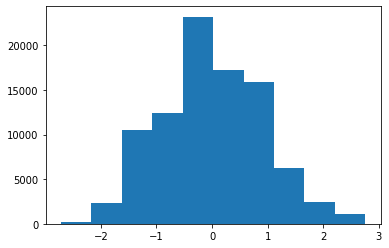

/tmp/ipykernel_1217242/3984487467.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])


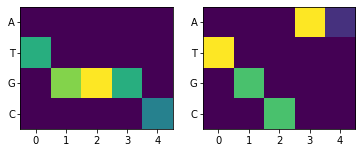

2865/2865 [==============================] - 3s 1ms/step


/tmp/ipykernel_1217242/3984487467.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])


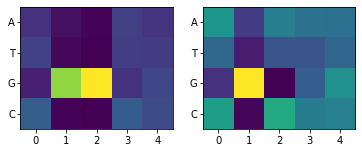

In [20]:
import matplotlib.pyplot as plt
plt.hist(seq_encoding)  # Has a nice normal dist
plt.show()

# Show some of the kmers (4)
n = 2
seqs_encoding = cvae.get_encoded_data()
# Show the true data
plt.figure(figsize=(6, 3))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.imshow(test_data[i].reshape(4, kmer_len))

plt.show()

# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
d = cvae.decoder.predict(seqs_encoding)

plt.figure(figsize=(6, 3))
n = 2
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.imshow(d[i,:].reshape(4, kmer_len))
plt.show()

In [21]:
cvae.save(f'model_weights_{kmer_len}_{exp_name}.h5', f'model_optimiser_{kmer_len}_{exp_name}.json', f'config_{kmer_len}_{exp_name}.json') # looks pretty decent for a single node 

## Use encoding function to probe for variation in the dataset


In [24]:
kmers_to_investigate = []
for k in kmer_counts:
    if kmer_counts[k] > 100:
        kmers_to_investigate.append(k)
print(len(kmers_to_investigate))

training_runs = []
for bam in bams:
    training_runs.append(f'{output_folder}training_new/{bam.split("/")[-1].split(".")[0]}_training.h5')
training_runs

729


['../runs/training_new/ERR3327115_training.h5',
 '../runs/training_new/ERR3327117_training.h5',
 '../runs/training_new/ERR3327119_training.h5',
 '../runs/training_new/ERR3327118_training.h5',
 '../runs/training_new/ERR3327116_training.h5',
 '../runs/training_new/ERR3327114_training.h5']

In [34]:
kmers_to_investigate

['AAACC',
 'AAAGC',
 'AAATC',
 'AACAA',
 'AACAC',
 'AACAG',
 'AACAT',
 'AACCA',
 'AACCC',
 'AACCG',
 'AACCT',
 'AACGA',
 'AACGC',
 'AACGG',
 'AACGT',
 'AACTC',
 'AACTG',
 'AACTT',
 'AAGAA',
 'AAGAC',
 'AAGAG',
 'AAGAT',
 'AAGCA',
 'AAGCC',
 'AAGCG',
 'AAGCT',
 'AAGGA',
 'AAGGC',
 'AAGGG',
 'AAGGT',
 'AAGTC',
 'AAGTG',
 'AAGTT',
 'AATCC',
 'AATCG',
 'AATGC',
 'AATGG',
 'AATTC',
 'ACAAC',
 'ACAAG',
 'ACACC',
 'ACAGC',
 'ACAGG',
 'ACATC',
 'ACATG',
 'ACCAA',
 'ACCAC',
 'ACCAG',
 'ACCAT',
 'ACCCA',
 'ACCCC',
 'ACCCG',
 'ACCCT',
 'ACCGA',
 'ACCGC',
 'ACCGG',
 'ACCGT',
 'ACCTC',
 'ACCTG',
 'ACCTT',
 'ACGAA',
 'ACGAC',
 'ACGAG',
 'ACGAT',
 'ACGCA',
 'ACGCC',
 'ACGCG',
 'ACGCT',
 'ACGGA',
 'ACGGC',
 'ACGGG',
 'ACGGT',
 'ACGTC',
 'ACGTG',
 'ACGTT',
 'ACTAC',
 'ACTCC',
 'ACTCG',
 'ACTGC',
 'ACTGG',
 'ACTTC',
 'ACTTG',
 'AGAAC',
 'AGAAG',
 'AGACC',
 'AGACG',
 'AGAGC',
 'AGAGG',
 'AGATC',
 'AGATG',
 'AGCAA',
 'AGCAC',
 'AGCAG',
 'AGCAT',
 'AGCCA',
 'AGCCC',
 'AGCCG',
 'AGCCT',
 'AGCGA',
 'AGCGC',


In [99]:
import itertools
from scipy import stats
from statsmodels.stats.multitest import multipletests

pseudo_infected = ['ERR3327116', 'ERR3327117', 'ERR3327118']
pseudo_fine = ['ERR3327115', 'ERR3327119', 'ERR3327114']

cond_dict = {'ERR3327116': 'pseudo_infected', 'ERR3327117': 'pseudo_infected', 'ERR3327118': 'pseudo_infected',
            'ERR3327115': 'pseudo_fine', 'ERR3327119': 'pseudo_fine', 'ERR3327114': 'pseudo_fine',
            }

comparisons = list(itertools.combinations(species_runs, 2))

p_values = []
t_values = []
labels = []
kmers = []
condlabels = []
kmer_label = []
# Check for significance between kmers
for kmer_name in kmers_to_investigate:
    df_kmer = get_kmer_encodings(kmer_name,  f'{output_folder}kmer_5_{exp_name}.h5', training_runs, 100)
    df_psi = df_kmer

    df_psi.fillna(0, inplace=True)

    # encode the data
    psi_data = df_psi.values[:, 5:]
    psi_data = psi_data / np.max(psi_data)
    psi_data = np.array(psi_data).astype(float)
    psi_data = np.array([d.reshape((4, kmer_len, 1)) for d in psi_data])
    seqs_encoding = cvae.encode_new_data(psi_data, scale=False)
    df_psi['MeanEncoding'] = seqs_encoding

    for kmer_start in set(df_kmer['ID'].values):
        df_psi_kmer = df_psi[df_psi['Start'] == kmer_start]
        if len(df_psi_kmer) > 10:
            for comparison in comparisons:
                e_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[0]}_training']['MeanEncoding'].values
                s_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[1]}_training']['MeanEncoding'].values
                if len(e_plus) > 5 and len(s_plus) > 5:
                    t_stat, p_val = stats.ttest_ind(e_plus, s_plus)
                    p_values.append(p_val)
                    t_values.append(t_stat)
                    kmers.append(kmer_start)
                    labels.append(f'{comparison[1]} vs {comparison[0]}')
                    condlabels.append(f'{cond_dict[comparison[1]]} vs {cond_dict[comparison[0]]}')
    
# Calculate adjusted p-values
p_adj = multipletests(p_values, alpha=0.1, method='fdr_bh', returnsorted=False)

kmer_df = pd.DataFrame()
kmer_df['p_values'] = p_adj[1]
kmer_df['p.adj'] = p_values
kmer_df['t_values'] = t_values
kmer_df['labels'] = labels
kmer_df['kmer'] = kmers
kmer_df.to_csv(f'{output_folder}KMER_{kmer_name}_{exp_name}_2.csv', index=False)

100%|█| 127/127 [00:11<00:00, 11.41it/


../runs/training_new/ERR3327115_training.h5 4014


100%|█| 127/127 [00:08<00:00, 15.01it/


../runs/training_new/ERR3327117_training.h5 7132


100%|█| 127/127 [00:11<00:00, 10.99it/


../runs/training_new/ERR3327119_training.h5 11258


100%|█| 127/127 [00:13<00:00,  9.76it/


../runs/training_new/ERR3327118_training.h5 15930


100%|█| 127/127 [00


../runs/training_new/ERR3327116_training.h5 17704


100%|█| 127/127 [00


../runs/training_new/ERR3327114_training.h5 20472
640/640 [==============================] - 1s 1ms/step


100%|█| 125/125 [00


../runs/training_new/ERR3327115_training.h5 5106


100%|█| 125/125 [00


../runs/training_new/ERR3327117_training.h5 8870


100%|█| 125/125 [00


../runs/training_new/ERR3327119_training.h5 13637


100%|█| 125/125 [00


../runs/training_new/ERR3327118_training.h5 19325


100%|█| 125/125 [00


../runs/training_new/ERR3327116_training.h5 21722


100%|█| 125/125 [00


../runs/training_new/ERR3327114_training.h5 24992
781/781 [==============================] - 1s 1ms/step


100%|█| 104/104 [00


../runs/training_new/ERR3327115_training.h5 3814


100%|█| 104/104 [00


../runs/training_new/ERR3327117_training.h5 6738


100%|█| 104/104 [00


../runs/training_new/ERR3327119_training.h5 10348


100%|█| 104/104 [00


../runs/training_new/ERR3327118_training.h5 14803


100%|█| 104/104 [00


../runs/training_new/ERR3327116_training.h5 16582


100%|█| 104/104 [00


../runs/training_new/ERR3327114_training.h5 18905
591/591 [==============================] - 1s 1ms/step


100%|█| 112/112 [00


../runs/training_new/ERR3327115_training.h5 4342


100%|█| 112/112 [00


../runs/training_new/ERR3327117_training.h5 7342


100%|█| 112/112 [00


../runs/training_new/ERR3327119_training.h5 11561


100%|█| 112/112 [00


../runs/training_new/ERR3327118_training.h5 16434


100%|█| 112/112 [00


../runs/training_new/ERR3327116_training.h5 18278


100%|█| 112/112 [00


../runs/training_new/ERR3327114_training.h5 21079
659/659 [==============================] - 1s 1ms/step


100%|█| 125/125 [00


../runs/training_new/ERR3327115_training.h5 3507


100%|█| 125/125 [00


../runs/training_new/ERR3327117_training.h5 6026


100%|█| 125/125 [00


../runs/training_new/ERR3327119_training.h5 9523


100%|█| 125/125 [00


../runs/training_new/ERR3327118_training.h5 13604


100%|█| 125/125 [00


../runs/training_new/ERR3327116_training.h5 15014


100%|█| 125/125 [00


../runs/training_new/ERR3327114_training.h5 17448
546/546 [==============================] - 1s 1ms/step


100%|█| 177/177 [00


../runs/training_new/ERR3327115_training.h5 6180


100%|█| 177/177 [00


../runs/training_new/ERR3327117_training.h5 11068


100%|█| 177/177 [00


../runs/training_new/ERR3327119_training.h5 17738


100%|█| 177/177 [00


../runs/training_new/ERR3327118_training.h5 25287


100%|█| 177/177 [00


../runs/training_new/ERR3327116_training.h5 28217


100%|█| 177/177 [00


../runs/training_new/ERR3327114_training.h5 32680
1022/1022 [==============================] - 1s 1ms/step


100%|█| 122/122 [00


../runs/training_new/ERR3327115_training.h5 3258


100%|█| 122/122 [00


../runs/training_new/ERR3327117_training.h5 5358


100%|█| 122/122 [00


../runs/training_new/ERR3327119_training.h5 8609


100%|█| 122/122 [00


../runs/training_new/ERR3327118_training.h5 12521


100%|█| 122/122 [00


../runs/training_new/ERR3327116_training.h5 13570


100%|█| 122/122 [00

../runs/training_new/ERR3327114_training.h5 15387
  1/481 [..............................] - ETA: 10s

481/481 [==============================] - 1s 1ms/step


100%|█| 139/139 [00


../runs/training_new/ERR3327115_training.h5 6381


100%|█| 139/139 [00


../runs/training_new/ERR3327117_training.h5 11208


100%|█| 139/139 [00


../runs/training_new/ERR3327119_training.h5 17268


100%|█| 139/139 [00


../runs/training_new/ERR3327118_training.h5 24310


100%|█| 139/139 [00


../runs/training_new/ERR3327116_training.h5 27352


100%|█| 139/139 [00


../runs/training_new/ERR3327114_training.h5 31862
996/996 [==============================] - 1s 1ms/step


100%|█| 131/131 [00


../runs/training_new/ERR3327115_training.h5 5363


100%|█| 131/131 [00


../runs/training_new/ERR3327117_training.h5 9515


100%|█| 131/131 [00


../runs/training_new/ERR3327119_training.h5 14830


100%|█| 131/131 [00


../runs/training_new/ERR3327118_training.h5 20813


100%|█| 131/131 [00


../runs/training_new/ERR3327116_training.h5 23278


100%|█| 131/131 [00


../runs/training_new/ERR3327114_training.h5 27034
845/845 [==============================] - 1s 1ms/step


100%|█| 166/166 [00


../runs/training_new/ERR3327115_training.h5 7340


100%|█| 166/166 [00


../runs/training_new/ERR3327117_training.h5 13311


100%|█| 166/166 [00


../runs/training_new/ERR3327119_training.h5 21002


100%|█| 166/166 [00


../runs/training_new/ERR3327118_training.h5 29580


100%|█| 166/166 [00


../runs/training_new/ERR3327116_training.h5 33157


100%|█| 166/166 [00


../runs/training_new/ERR3327114_training.h5 38600
1207/1207 [==============================] - 1s 1ms/step


100%|█| 129/129 [00


../runs/training_new/ERR3327115_training.h5 7881


100%|█| 129/129 [00


../runs/training_new/ERR3327117_training.h5 14111


100%|█| 129/129 [00


../runs/training_new/ERR3327119_training.h5 21811


100%|█| 129/129 [00


../runs/training_new/ERR3327118_training.h5 30651


100%|█| 129/129 [00


../runs/training_new/ERR3327116_training.h5 34649


100%|█| 129/129 [00


../runs/training_new/ERR3327114_training.h5 40275
1259/1259 [==============================] - 1s 1ms/step


100%|█| 146/146 [00


../runs/training_new/ERR3327115_training.h5 5241


100%|█| 146/146 [00


../runs/training_new/ERR3327117_training.h5 9159


100%|█| 146/146 [00


../runs/training_new/ERR3327119_training.h5 14386


100%|█| 146/146 [00


../runs/training_new/ERR3327118_training.h5 20802


100%|█| 146/146 [00


../runs/training_new/ERR3327116_training.h5 22878


100%|█| 146/146 [00


../runs/training_new/ERR3327114_training.h5 26292
822/822 [==============================] - 1s 1ms/step


100%|█| 181/181 [00


../runs/training_new/ERR3327115_training.h5 8610


100%|█| 181/181 [00


../runs/training_new/ERR3327117_training.h5 15693


100%|█| 181/181 [00


../runs/training_new/ERR3327119_training.h5 24653


100%|█| 181/181 [00


../runs/training_new/ERR3327118_training.h5 34729


100%|█| 181/181 [00


../runs/training_new/ERR3327116_training.h5 38900


100%|█| 181/181 [00


../runs/training_new/ERR3327114_training.h5 45178
1412/1412 [==============================] - 2s 1ms/step


100%|█| 172/172 [00


../runs/training_new/ERR3327115_training.h5 6892


100%|█| 172/172 [00


../runs/training_new/ERR3327117_training.h5 12300


100%|█| 172/172 [00


../runs/training_new/ERR3327119_training.h5 19581


100%|█| 172/172 [00


../runs/training_new/ERR3327118_training.h5 27661


100%|█| 172/172 [00


../runs/training_new/ERR3327116_training.h5 30421


100%|█| 172/172 [00


../runs/training_new/ERR3327114_training.h5 35239
1102/1102 [==============================] - 1s 1ms/step


100%|█| 108/108 [00


../runs/training_new/ERR3327115_training.h5 3240


100%|█| 108/108 [00


../runs/training_new/ERR3327117_training.h5 5693


100%|█| 108/108 [00


../runs/training_new/ERR3327119_training.h5 9004


100%|█| 108/108 [00


../runs/training_new/ERR3327118_training.h5 12942


100%|█| 108/108 [00


../runs/training_new/ERR3327116_training.h5 14240


100%|█| 108/108 [00

../runs/training_new/ERR3327114_training.h5 16426
  1/514 [..............................] - ETA: 10s

514/514 [==============================] - 1s 1ms/step


100%|█| 138/138 [00


../runs/training_new/ERR3327115_training.h5 5552


100%|█| 138/138 [00


../runs/training_new/ERR3327117_training.h5 9732


100%|█| 138/138 [00


../runs/training_new/ERR3327119_training.h5 15257


100%|█| 138/138 [00


../runs/training_new/ERR3327118_training.h5 21547


100%|█| 138/138 [00


../runs/training_new/ERR3327116_training.h5 24103


100%|█| 138/138 [00


../runs/training_new/ERR3327114_training.h5 28001
876/876 [==============================] - 1s 1ms/step


100%|█| 179/179 [00


../runs/training_new/ERR3327115_training.h5 10493


100%|█| 179/179 [00


../runs/training_new/ERR3327117_training.h5 18832


100%|█| 179/179 [00


../runs/training_new/ERR3327119_training.h5 29628


100%|█| 179/179 [00


../runs/training_new/ERR3327118_training.h5 41780


100%|█| 179/179 [00


../runs/training_new/ERR3327116_training.h5 46272


100%|█| 179/179 [00


../runs/training_new/ERR3327114_training.h5 53907
1685/1685 [==============================] - 2s 1ms/step


100%|█| 123/123 [00


../runs/training_new/ERR3327115_training.h5 4333


100%|█| 123/123 [00


../runs/training_new/ERR3327117_training.h5 7561


100%|█| 123/123 [00


../runs/training_new/ERR3327119_training.h5 11864


100%|█| 123/123 [00


../runs/training_new/ERR3327118_training.h5 16654


100%|█| 123/123 [00


../runs/training_new/ERR3327116_training.h5 18950


100%|█| 123/123 [00


../runs/training_new/ERR3327114_training.h5 22061
690/690 [==============================] - 1s 1ms/step


100%|█| 152/152 [00


../runs/training_new/ERR3327115_training.h5 5057


100%|█| 152/152 [00


../runs/training_new/ERR3327117_training.h5 8361


100%|█| 152/152 [00


../runs/training_new/ERR3327119_training.h5 13563


100%|█| 152/152 [00


../runs/training_new/ERR3327118_training.h5 19821


100%|█| 152/152 [00


../runs/training_new/ERR3327116_training.h5 21504


100%|█| 152/152 [00


../runs/training_new/ERR3327114_training.h5 24312
760/760 [==============================] - 1s 1ms/step


100%|█| 154/154 [00


../runs/training_new/ERR3327115_training.h5 5994


100%|█| 154/154 [00


../runs/training_new/ERR3327117_training.h5 10105


100%|█| 154/154 [00


../runs/training_new/ERR3327119_training.h5 15883


100%|█| 154/154 [00


../runs/training_new/ERR3327118_training.h5 22859


100%|█| 154/154 [00


../runs/training_new/ERR3327116_training.h5 25215


100%|█| 154/154 [00


../runs/training_new/ERR3327114_training.h5 28910
904/904 [==============================] - 1s 1ms/step


100%|█| 137/137 [00


../runs/training_new/ERR3327115_training.h5 4718


100%|█| 137/137 [00


../runs/training_new/ERR3327117_training.h5 8050


100%|█| 137/137 [00


../runs/training_new/ERR3327119_training.h5 12833


100%|█| 137/137 [00


../runs/training_new/ERR3327118_training.h5 18405


100%|█| 137/137 [00


../runs/training_new/ERR3327116_training.h5 20136


100%|█| 137/137 [00


../runs/training_new/ERR3327114_training.h5 22864
715/715 [==============================] - 1s 1ms/step


100%|█| 149/149 [00


../runs/training_new/ERR3327115_training.h5 5756


100%|█| 149/149 [00


../runs/training_new/ERR3327117_training.h5 9815


100%|█| 149/149 [00


../runs/training_new/ERR3327119_training.h5 15295


100%|█| 149/149 [00


../runs/training_new/ERR3327118_training.h5 21687


100%|█| 149/149 [00


../runs/training_new/ERR3327116_training.h5 24027


100%|█| 149/149 [00


../runs/training_new/ERR3327114_training.h5 27443
858/858 [==============================] - 1s 1ms/step


100%|█| 129/129 [00


../runs/training_new/ERR3327115_training.h5 5384


100%|█| 129/129 [00


../runs/training_new/ERR3327117_training.h5 9576


100%|█| 129/129 [00


../runs/training_new/ERR3327119_training.h5 14905


100%|█| 129/129 [00


../runs/training_new/ERR3327118_training.h5 21220


100%|█| 129/129 [00


../runs/training_new/ERR3327116_training.h5 23868


100%|█| 129/129 [00


../runs/training_new/ERR3327114_training.h5 27554
862/862 [==============================] - 1s 1ms/step


100%|█| 188/188 [00


../runs/training_new/ERR3327115_training.h5 8299


100%|█| 188/188 [00


../runs/training_new/ERR3327117_training.h5 14868


100%|█| 188/188 [00


../runs/training_new/ERR3327119_training.h5 23539


100%|█| 188/188 [00


../runs/training_new/ERR3327118_training.h5 33521


100%|█| 188/188 [00


../runs/training_new/ERR3327116_training.h5 37019


100%|█| 188/188 [00


../runs/training_new/ERR3327114_training.h5 42893
1341/1341 [==============================] - 2s 1ms/step


100%|█| 177/177 [00


../runs/training_new/ERR3327115_training.h5 8644


100%|█| 177/177 [00


../runs/training_new/ERR3327117_training.h5 15438


100%|█| 177/177 [00


../runs/training_new/ERR3327119_training.h5 24044


100%|█| 177/177 [00


../runs/training_new/ERR3327118_training.h5 34014


100%|█| 177/177 [00


../runs/training_new/ERR3327116_training.h5 37883


100%|█| 177/177 [00


../runs/training_new/ERR3327114_training.h5 43697
1366/1366 [==============================] - 2s 1ms/step


100%|█| 149/149 [00


../runs/training_new/ERR3327115_training.h5 7651


100%|█| 149/149 [00


../runs/training_new/ERR3327117_training.h5 13891


100%|█| 149/149 [00


../runs/training_new/ERR3327119_training.h5 21626


100%|█| 149/149 [00


../runs/training_new/ERR3327118_training.h5 30576


100%|█| 149/149 [00


../runs/training_new/ERR3327116_training.h5 34503


100%|█| 149/149 [00


../runs/training_new/ERR3327114_training.h5 40012
1251/1251 [==============================] - 1s 1ms/step


100%|█| 149/149 [00


../runs/training_new/ERR3327115_training.h5 5434


100%|█| 149/149 [00


../runs/training_new/ERR3327117_training.h5 9389


100%|█| 149/149 [00


../runs/training_new/ERR3327119_training.h5 15303


100%|█| 149/149 [00


../runs/training_new/ERR3327118_training.h5 22183


100%|█| 149/149 [00


../runs/training_new/ERR3327116_training.h5 24134


100%|█| 149/149 [00


../runs/training_new/ERR3327114_training.h5 27551
861/861 [==============================] - 1s 1ms/step


100%|█| 201/201 [00


../runs/training_new/ERR3327115_training.h5 11109


100%|█| 201/201 [00


../runs/training_new/ERR3327117_training.h5 19728


100%|█| 201/201 [00


../runs/training_new/ERR3327119_training.h5 31584


100%|█| 201/201 [00


../runs/training_new/ERR3327118_training.h5 44979


100%|█| 201/201 [00


../runs/training_new/ERR3327116_training.h5 49194


100%|█| 201/201 [00


../runs/training_new/ERR3327114_training.h5 56669
1771/1771 [==============================] - 2s 1ms/step


100%|█| 137/137 [00


../runs/training_new/ERR3327115_training.h5 6772


100%|█| 137/137 [00


../runs/training_new/ERR3327117_training.h5 12060


100%|█| 137/137 [00


../runs/training_new/ERR3327119_training.h5 18887


100%|█| 137/137 [00


../runs/training_new/ERR3327118_training.h5 26511


100%|█| 137/137 [00


../runs/training_new/ERR3327116_training.h5 29692


100%|█| 137/137 [00


../runs/training_new/ERR3327114_training.h5 34491
1078/1078 [==============================] - 1s 1ms/step


100%|█| 169/169 [00


../runs/training_new/ERR3327115_training.h5 6638


100%|█| 169/169 [00


../runs/training_new/ERR3327117_training.h5 11755


100%|█| 169/169 [00


../runs/training_new/ERR3327119_training.h5 18890


100%|█| 169/169 [00


../runs/training_new/ERR3327118_training.h5 27051


100%|█| 169/169 [00


../runs/training_new/ERR3327116_training.h5 29919


100%|█| 169/169 [00


../runs/training_new/ERR3327114_training.h5 34518
1079/1079 [==============================] - 1s 1ms/step


100%|█| 151/151 [00


../runs/training_new/ERR3327115_training.h5 5493


100%|█| 151/151 [00


../runs/training_new/ERR3327117_training.h5 9897


100%|█| 151/151 [00


../runs/training_new/ERR3327119_training.h5 15628


100%|█| 151/151 [00


../runs/training_new/ERR3327118_training.h5 22130


100%|█| 151/151 [00


../runs/training_new/ERR3327116_training.h5 24743


100%|█| 151/151 [00


../runs/training_new/ERR3327114_training.h5 28607
894/894 [==============================] - 1s 1ms/step


100%|█| 128/128 [00


../runs/training_new/ERR3327115_training.h5 3887


100%|█| 128/128 [00


../runs/training_new/ERR3327117_training.h5 6701


100%|█| 128/128 [00


../runs/training_new/ERR3327119_training.h5 10617


100%|█| 128/128 [00


../runs/training_new/ERR3327118_training.h5 15448


100%|█| 128/128 [00


../runs/training_new/ERR3327116_training.h5 16870


100%|█| 128/128 [00


../runs/training_new/ERR3327114_training.h5 19237
602/602 [==============================] - 1s 1ms/step


100%|█| 130/130 [00


../runs/training_new/ERR3327115_training.h5 3803


100%|█| 130/130 [00


../runs/training_new/ERR3327117_training.h5 6580


100%|█| 130/130 [00


../runs/training_new/ERR3327119_training.h5 10421


100%|█| 130/130 [00


../runs/training_new/ERR3327118_training.h5 14731


100%|█| 130/130 [00


../runs/training_new/ERR3327116_training.h5 16286


100%|█| 130/130 [00


../runs/training_new/ERR3327114_training.h5 18797
588/588 [==============================] - 1s 1ms/step


100%|█| 103/103 [00


../runs/training_new/ERR3327115_training.h5 3323


100%|█| 103/103 [00


../runs/training_new/ERR3327117_training.h5 5715


100%|█| 103/103 [00


../runs/training_new/ERR3327119_training.h5 8889


100%|█| 103/103 [00


../runs/training_new/ERR3327118_training.h5 12536


100%|█| 103/103 [00


../runs/training_new/ERR3327116_training.h5 14174


100%|█| 103/103 [00

../runs/training_new/ERR3327114_training.h5 16411
  1/513 [..............................] - ETA: 11s

513/513 [==============================] - 1s 1ms/step


100%|█| 113/113 [00


../runs/training_new/ERR3327115_training.h5 3369


100%|█| 113/113 [00


../runs/training_new/ERR3327117_training.h5 5806


100%|█| 113/113 [00


../runs/training_new/ERR3327119_training.h5 8980


100%|█| 113/113 [00


../runs/training_new/ERR3327118_training.h5 12805


100%|█| 113/113 [00


../runs/training_new/ERR3327116_training.h5 14245


100%|█| 113/113 [00

../runs/training_new/ERR3327114_training.h5 16229
  1/508 [..............................] - ETA: 10s

508/508 [==============================] - 1s 1ms/step


100%|█| 108/108 [00


../runs/training_new/ERR3327115_training.h5 2752


100%|█| 108/108 [00


../runs/training_new/ERR3327117_training.h5 4799


100%|█| 108/108 [00


../runs/training_new/ERR3327119_training.h5 7638


100%|█| 108/108 [00


../runs/training_new/ERR3327118_training.h5 10820


100%|█| 108/108 [00


../runs/training_new/ERR3327116_training.h5 12012


100%|█| 108/108 [00


../runs/training_new/ERR3327114_training.h5 13750
430/430 [==============================] - 1s 1ms/step


100%|█| 129/129 [00


../runs/training_new/ERR3327115_training.h5 4300


100%|█| 129/129 [00


../runs/training_new/ERR3327117_training.h5 7453


100%|█| 129/129 [00


../runs/training_new/ERR3327119_training.h5 11559


100%|█| 129/129 [00


../runs/training_new/ERR3327118_training.h5 16244


100%|█| 129/129 [00


../runs/training_new/ERR3327116_training.h5 18004


100%|█| 129/129 [00


../runs/training_new/ERR3327114_training.h5 20883
653/653 [==============================] - 1s 1ms/step


100%|█| 104/104 [00


../runs/training_new/ERR3327115_training.h5 2775


100%|█| 104/104 [00


../runs/training_new/ERR3327117_training.h5 4828


100%|█| 104/104 [00


../runs/training_new/ERR3327119_training.h5 7708


100%|█| 104/104 [00


../runs/training_new/ERR3327118_training.h5 10918


100%|█| 104/104 [00


../runs/training_new/ERR3327116_training.h5 12157


100%|█| 104/104 [00

../runs/training_new/ERR3327114_training.h5 13987
  1/438 [..............................] - ETA: 9s

438/438 [==============================] - 1s 1ms/step


100%|█| 120/120 [00


../runs/training_new/ERR3327115_training.h5 6766


100%|█| 120/120 [00


../runs/training_new/ERR3327117_training.h5 11615


100%|█| 120/120 [00


../runs/training_new/ERR3327119_training.h5 18030


100%|█| 120/120 [00


../runs/training_new/ERR3327118_training.h5 25719


100%|█| 120/120 [00


../runs/training_new/ERR3327116_training.h5 28965


100%|█| 120/120 [00


../runs/training_new/ERR3327114_training.h5 33706
1054/1054 [==============================] - 1s 1ms/step


100%|█| 122/122 [00


../runs/training_new/ERR3327115_training.h5 6361


100%|█| 122/122 [00


../runs/training_new/ERR3327117_training.h5 10688


100%|█| 122/122 [00


../runs/training_new/ERR3327119_training.h5 16882


100%|█| 122/122 [00


../runs/training_new/ERR3327118_training.h5 24041


100%|█| 122/122 [00


../runs/training_new/ERR3327116_training.h5 26545


100%|█| 122/122 [00


../runs/training_new/ERR3327114_training.h5 30426
951/951 [==============================] - 1s 1ms/step


100%|█| 167/167 [00


../runs/training_new/ERR3327115_training.h5 7484


100%|█| 167/167 [00


../runs/training_new/ERR3327117_training.h5 13025


100%|█| 167/167 [00


../runs/training_new/ERR3327119_training.h5 20732


100%|█| 167/167 [00


../runs/training_new/ERR3327118_training.h5 29381


100%|█| 167/167 [00


../runs/training_new/ERR3327116_training.h5 32829


100%|█| 167/167 [00


../runs/training_new/ERR3327114_training.h5 38369
1200/1200 [==============================] - 1s 1ms/step


100%|█| 197/197 [00


../runs/training_new/ERR3327115_training.h5 9179


100%|█| 197/197 [00


../runs/training_new/ERR3327117_training.h5 16041


100%|█| 197/197 [00


../runs/training_new/ERR3327119_training.h5 25196


100%|█| 197/197 [00


../runs/training_new/ERR3327118_training.h5 35875


100%|█| 197/197 [00


../runs/training_new/ERR3327116_training.h5 39645


100%|█| 197/197 [00


../runs/training_new/ERR3327114_training.h5 46032
1439/1439 [==============================] - 2s 1ms/step


100%|█| 147/147 [00


../runs/training_new/ERR3327115_training.h5 5641


100%|█| 147/147 [00


../runs/training_new/ERR3327117_training.h5 10099


100%|█| 147/147 [00


../runs/training_new/ERR3327119_training.h5 16287


100%|█| 147/147 [00


../runs/training_new/ERR3327118_training.h5 23142


100%|█| 147/147 [00


../runs/training_new/ERR3327116_training.h5 25764


100%|█| 147/147 [00


../runs/training_new/ERR3327114_training.h5 29904
935/935 [==============================] - 1s 1ms/step


100%|█| 175/175 [00


../runs/training_new/ERR3327115_training.h5 7372


100%|█| 175/175 [00


../runs/training_new/ERR3327117_training.h5 13250


100%|█| 175/175 [00


../runs/training_new/ERR3327119_training.h5 21427


100%|█| 175/175 [00


../runs/training_new/ERR3327118_training.h5 30913


100%|█| 175/175 [00


../runs/training_new/ERR3327116_training.h5 34007


100%|█| 175/175 [00


../runs/training_new/ERR3327114_training.h5 39152
1224/1224 [==============================] - 1s 1ms/step


100%|█| 128/128 [00


../runs/training_new/ERR3327115_training.h5 5420


100%|█| 128/128 [00


../runs/training_new/ERR3327117_training.h5 9431


100%|█| 128/128 [00


../runs/training_new/ERR3327119_training.h5 14690


100%|█| 128/128 [00


../runs/training_new/ERR3327118_training.h5 20786


100%|█| 128/128 [00


../runs/training_new/ERR3327116_training.h5 22827


100%|█| 128/128 [00


../runs/training_new/ERR3327114_training.h5 26339
824/824 [==============================] - 1s 1ms/step


100%|█| 124/124 [00


../runs/training_new/ERR3327115_training.h5 5026


100%|█| 124/124 [00


../runs/training_new/ERR3327117_training.h5 8499


100%|█| 124/124 [00


../runs/training_new/ERR3327119_training.h5 13253


100%|█| 124/124 [00


../runs/training_new/ERR3327118_training.h5 19123


100%|█| 124/124 [00


../runs/training_new/ERR3327116_training.h5 21205


100%|█| 124/124 [00


../runs/training_new/ERR3327114_training.h5 24250
758/758 [==============================] - 1s 1ms/step


100%|█| 191/191 [00


../runs/training_new/ERR3327115_training.h5 9077


100%|█| 191/191 [00


../runs/training_new/ERR3327117_training.h5 16335


100%|█| 191/191 [00


../runs/training_new/ERR3327119_training.h5 26317


100%|█| 191/191 [00


../runs/training_new/ERR3327118_training.h5 37518


100%|█| 191/191 [00


../runs/training_new/ERR3327116_training.h5 41674


100%|█| 191/191 [00


../runs/training_new/ERR3327114_training.h5 48324
1511/1511 [==============================] - 2s 1ms/step


100%|█| 229/229 [00


../runs/training_new/ERR3327115_training.h5 13191


100%|█| 229/229 [00


../runs/training_new/ERR3327117_training.h5 23315


100%|█| 229/229 [00


../runs/training_new/ERR3327119_training.h5 37320


100%|█| 229/229 [00


../runs/training_new/ERR3327118_training.h5 53185


100%|█| 229/229 [00


../runs/training_new/ERR3327116_training.h5 58748


100%|█| 229/229 [00


../runs/training_new/ERR3327114_training.h5 68222
2132/2132 [==============================] - 2s 1ms/step


100%|█| 149/149 [00


../runs/training_new/ERR3327115_training.h5 3628


100%|█| 149/149 [00


../runs/training_new/ERR3327117_training.h5 6169


100%|█| 149/149 [00


../runs/training_new/ERR3327119_training.h5 10080


100%|█| 149/149 [00


../runs/training_new/ERR3327118_training.h5 15014


100%|█| 149/149 [00


../runs/training_new/ERR3327116_training.h5 16046


100%|█| 149/149 [00


../runs/training_new/ERR3327114_training.h5 18204
569/569 [==============================] - 1s 1ms/step


100%|█| 136/136 [00


../runs/training_new/ERR3327115_training.h5 6393


100%|█| 136/136 [00


../runs/training_new/ERR3327117_training.h5 11496


100%|█| 136/136 [00


../runs/training_new/ERR3327119_training.h5 18001


100%|█| 136/136 [00


../runs/training_new/ERR3327118_training.h5 25294


100%|█| 136/136 [00


../runs/training_new/ERR3327116_training.h5 28437


100%|█| 136/136 [00


../runs/training_new/ERR3327114_training.h5 33080
1034/1034 [==============================] - 1s 1ms/step


100%|█| 127/127 [00


../runs/training_new/ERR3327115_training.h5 4856


100%|█| 127/127 [00


../runs/training_new/ERR3327117_training.h5 8475


100%|█| 127/127 [00


../runs/training_new/ERR3327119_training.h5 13180


100%|█| 127/127 [00


../runs/training_new/ERR3327118_training.h5 18497


100%|█| 127/127 [00


../runs/training_new/ERR3327116_training.h5 20931


100%|█| 127/127 [00


../runs/training_new/ERR3327114_training.h5 24354
762/762 [==============================] - 1s 1ms/step


100%|█| 184/184 [00


../runs/training_new/ERR3327115_training.h5 11148


100%|█| 184/184 [00


../runs/training_new/ERR3327117_training.h5 19966


100%|█| 184/184 [00


../runs/training_new/ERR3327119_training.h5 31479


100%|█| 184/184 [00


../runs/training_new/ERR3327118_training.h5 44225


100%|█| 184/184 [00


../runs/training_new/ERR3327116_training.h5 48901


100%|█| 184/184 [00


../runs/training_new/ERR3327114_training.h5 56938
1780/1780 [==============================] - 2s 1ms/step


100%|█| 142/142 [00


../runs/training_new/ERR3327115_training.h5 7311


100%|█| 142/142 [00


../runs/training_new/ERR3327117_training.h5 12986


100%|█| 142/142 [00


../runs/training_new/ERR3327119_training.h5 20636


100%|█| 142/142 [00


../runs/training_new/ERR3327118_training.h5 29061


100%|█| 142/142 [00


../runs/training_new/ERR3327116_training.h5 32547


100%|█| 142/142 [00


../runs/training_new/ERR3327114_training.h5 38128
1192/1192 [==============================] - 1s 1ms/step


100%|█| 199/199 [00


../runs/training_new/ERR3327115_training.h5 9816


100%|█| 199/199 [00


../runs/training_new/ERR3327117_training.h5 17210


100%|█| 199/199 [00


../runs/training_new/ERR3327119_training.h5 27657


100%|█| 199/199 [00


../runs/training_new/ERR3327118_training.h5 39506


100%|█| 199/199 [00


../runs/training_new/ERR3327116_training.h5 43555


100%|█| 199/199 [00


../runs/training_new/ERR3327114_training.h5 50449
1577/1577 [==============================] - 2s 1ms/step


100%|█| 225/225 [00


../runs/training_new/ERR3327115_training.h5 14830


100%|█| 225/225 [00


../runs/training_new/ERR3327117_training.h5 26244


100%|█| 225/225 [00


../runs/training_new/ERR3327119_training.h5 42046


100%|█| 225/225 [00


../runs/training_new/ERR3327118_training.h5 59414


100%|█| 225/225 [00


../runs/training_new/ERR3327116_training.h5 66017


100%|█| 225/225 [00


../runs/training_new/ERR3327114_training.h5 76988
2406/2406 [==============================] - 3s 1ms/step


100%|█| 212/212 [00


../runs/training_new/ERR3327115_training.h5 12416


100%|█| 212/212 [00


../runs/training_new/ERR3327117_training.h5 22164


100%|█| 212/212 [00


../runs/training_new/ERR3327119_training.h5 35648


100%|█| 212/212 [00


../runs/training_new/ERR3327118_training.h5 50469


100%|█| 212/212 [00


../runs/training_new/ERR3327116_training.h5 55630


100%|█| 212/212 [00


../runs/training_new/ERR3327114_training.h5 64477
2015/2015 [==============================] - 2s 1ms/step


100%|█| 163/163 [00


../runs/training_new/ERR3327115_training.h5 6660


100%|█| 163/163 [00


../runs/training_new/ERR3327117_training.h5 12206


100%|█| 163/163 [00


../runs/training_new/ERR3327119_training.h5 19460


100%|█| 163/163 [00


../runs/training_new/ERR3327118_training.h5 27808


100%|█| 163/163 [00


../runs/training_new/ERR3327116_training.h5 30812


100%|█| 163/163 [00


../runs/training_new/ERR3327114_training.h5 35800
1119/1119 [==============================] - 1s 1ms/step


100%|█| 161/161 [00


../runs/training_new/ERR3327115_training.h5 6483


100%|█| 161/161 [00


../runs/training_new/ERR3327117_training.h5 11551


100%|█| 161/161 [00


../runs/training_new/ERR3327119_training.h5 18642


100%|█| 161/161 [00


../runs/training_new/ERR3327118_training.h5 26494


100%|█| 161/161 [00


../runs/training_new/ERR3327116_training.h5 29424


100%|█| 161/161 [00


../runs/training_new/ERR3327114_training.h5 34009
1063/1063 [==============================] - 1s 1ms/step


100%|█| 221/221 [00


../runs/training_new/ERR3327115_training.h5 21079


100%|█| 221/221 [00


../runs/training_new/ERR3327117_training.h5 37887


100%|█| 221/221 [00


../runs/training_new/ERR3327119_training.h5 59626


100%|█| 221/221 [00


../runs/training_new/ERR3327118_training.h5 84169


100%|█| 221/221 [00


../runs/training_new/ERR3327116_training.h5 93527


100%|█| 221/221 [00


../runs/training_new/ERR3327114_training.h5 109038
3408/3408 [==============================] - 4s 1ms/step


100%|█| 183/183 [00


../runs/training_new/ERR3327115_training.h5 7990


100%|█| 183/183 [00


../runs/training_new/ERR3327117_training.h5 14189


100%|█| 183/183 [00


../runs/training_new/ERR3327119_training.h5 22543


100%|█| 183/183 [00


../runs/training_new/ERR3327118_training.h5 31676


100%|█| 183/183 [00


../runs/training_new/ERR3327116_training.h5 35596


100%|█| 183/183 [00


../runs/training_new/ERR3327114_training.h5 41560
1299/1299 [==============================] - 2s 1ms/step


100%|█| 160/160 [00


../runs/training_new/ERR3327115_training.h5 5824


100%|█| 160/160 [00


../runs/training_new/ERR3327117_training.h5 10299


100%|█| 160/160 [00


../runs/training_new/ERR3327119_training.h5 16519


100%|█| 160/160 [00


../runs/training_new/ERR3327118_training.h5 23806


100%|█| 160/160 [00


../runs/training_new/ERR3327116_training.h5 26003


100%|█| 160/160 [00


../runs/training_new/ERR3327114_training.h5 29950
936/936 [==============================] - 1s 1ms/step


100%|█| 172/172 [00


../runs/training_new/ERR3327115_training.h5 8651


100%|█| 172/172 [00


../runs/training_new/ERR3327117_training.h5 15219


100%|█| 172/172 [00


../runs/training_new/ERR3327119_training.h5 24000


100%|█| 172/172 [00


../runs/training_new/ERR3327118_training.h5 34039


100%|█| 172/172 [00


../runs/training_new/ERR3327116_training.h5 37531


100%|█| 172/172 [00


../runs/training_new/ERR3327114_training.h5 43574
1362/1362 [==============================] - 2s 1ms/step


100%|█| 140/140 [00


../runs/training_new/ERR3327115_training.h5 7423


100%|█| 140/140 [00


../runs/training_new/ERR3327117_training.h5 13239


100%|█| 140/140 [00


../runs/training_new/ERR3327119_training.h5 20898


100%|█| 140/140 [00


../runs/training_new/ERR3327118_training.h5 29740


100%|█| 140/140 [00


../runs/training_new/ERR3327116_training.h5 32699


100%|█| 140/140 [00


../runs/training_new/ERR3327114_training.h5 37941
1186/1186 [==============================] - 1s 1ms/step


100%|█| 154/154 [00


../runs/training_new/ERR3327115_training.h5 4615


100%|█| 154/154 [00


../runs/training_new/ERR3327117_training.h5 8197


100%|█| 154/154 [00


../runs/training_new/ERR3327119_training.h5 13568


100%|█| 154/154 [00


../runs/training_new/ERR3327118_training.h5 19528


100%|█| 154/154 [00


../runs/training_new/ERR3327116_training.h5 21242


100%|█| 154/154 [00


../runs/training_new/ERR3327114_training.h5 24396
763/763 [==============================] - 1s 1ms/step


100%|█| 138/138 [00


../runs/training_new/ERR3327115_training.h5 4487


100%|█| 138/138 [00


../runs/training_new/ERR3327117_training.h5 8346


100%|█| 138/138 [00


../runs/training_new/ERR3327119_training.h5 13224


100%|█| 138/138 [00


../runs/training_new/ERR3327118_training.h5 18861


100%|█| 138/138 [00


../runs/training_new/ERR3327116_training.h5 21073


100%|█| 138/138 [00


../runs/training_new/ERR3327114_training.h5 24242
758/758 [==============================] - 1s 1ms/step


100%|█| 228/228 [00


../runs/training_new/ERR3327115_training.h5 16444


100%|█| 228/228 [00


../runs/training_new/ERR3327117_training.h5 29243


100%|█| 228/228 [00


../runs/training_new/ERR3327119_training.h5 46393


100%|█| 228/228 [00


../runs/training_new/ERR3327118_training.h5 65249


100%|█| 228/228 [00


../runs/training_new/ERR3327116_training.h5 72324


100%|█| 228/228 [00


../runs/training_new/ERR3327114_training.h5 84600
2644/2644 [==============================] - 3s 1ms/step


100%|█| 172/172 [00


../runs/training_new/ERR3327115_training.h5 6523


100%|█| 172/172 [00


../runs/training_new/ERR3327117_training.h5 11858


100%|█| 172/172 [00


../runs/training_new/ERR3327119_training.h5 18771


100%|█| 172/172 [00


../runs/training_new/ERR3327118_training.h5 26702


100%|█| 172/172 [00


../runs/training_new/ERR3327116_training.h5 29500


100%|█| 172/172 [00


../runs/training_new/ERR3327114_training.h5 33881
1059/1059 [==============================] - 1s 1ms/step


100%|█| 175/175 [00


../runs/training_new/ERR3327115_training.h5 6726


100%|█| 175/175 [00


../runs/training_new/ERR3327117_training.h5 12138


100%|█| 175/175 [00


../runs/training_new/ERR3327119_training.h5 19195


100%|█| 175/175 [00


../runs/training_new/ERR3327118_training.h5 26994


100%|█| 175/175 [00


../runs/training_new/ERR3327116_training.h5 30023


100%|█| 175/175 [00


../runs/training_new/ERR3327114_training.h5 35010
1095/1095 [==============================] - 1s 1ms/step


100%|█| 113/113 [00


../runs/training_new/ERR3327115_training.h5 4559


100%|█| 113/113 [00


../runs/training_new/ERR3327117_training.h5 8129


100%|█| 113/113 [00


../runs/training_new/ERR3327119_training.h5 12781


100%|█| 113/113 [00


../runs/training_new/ERR3327118_training.h5 17884


100%|█| 113/113 [00


../runs/training_new/ERR3327116_training.h5 20125


100%|█| 113/113 [00


../runs/training_new/ERR3327114_training.h5 23420
732/732 [==============================] - 1s 1ms/step


100%|█| 235/235 [00


../runs/training_new/ERR3327115_training.h5 14695


100%|█| 235/235 [00


../runs/training_new/ERR3327117_training.h5 26246


100%|█| 235/235 [00


../runs/training_new/ERR3327119_training.h5 41766


100%|█| 235/235 [00


../runs/training_new/ERR3327118_training.h5 59279


100%|█| 235/235 [00


../runs/training_new/ERR3327116_training.h5 64928


100%|█| 235/235 [00


../runs/training_new/ERR3327114_training.h5 75285
2353/2353 [==============================] - 3s 1ms/step


100%|█| 116/116 [00


../runs/training_new/ERR3327115_training.h5 4248


100%|█| 116/116 [00


../runs/training_new/ERR3327117_training.h5 7660


100%|█| 116/116 [00


../runs/training_new/ERR3327119_training.h5 11863


100%|█| 116/116 [00


../runs/training_new/ERR3327118_training.h5 16464


100%|█| 116/116 [00


../runs/training_new/ERR3327116_training.h5 18436


100%|█| 116/116 [00


../runs/training_new/ERR3327114_training.h5 21507
673/673 [==============================] - 1s 1ms/step


100%|█| 184/184 [00


../runs/training_new/ERR3327115_training.h5 7937


100%|█| 184/184 [00


../runs/training_new/ERR3327117_training.h5 14271


100%|█| 184/184 [00


../runs/training_new/ERR3327119_training.h5 22829


100%|█| 184/184 [00


../runs/training_new/ERR3327118_training.h5 32262


100%|█| 184/184 [00


../runs/training_new/ERR3327116_training.h5 35994


100%|█| 184/184 [00


../runs/training_new/ERR3327114_training.h5 41660
1302/1302 [==============================] - 1s 1ms/step


100%|█| 173/173 [00


../runs/training_new/ERR3327115_training.h5 5784


100%|█| 173/173 [00


../runs/training_new/ERR3327117_training.h5 10372


100%|█| 173/173 [00


../runs/training_new/ERR3327119_training.h5 17176


100%|█| 173/173 [00


../runs/training_new/ERR3327118_training.h5 24719


100%|█| 173/173 [00


../runs/training_new/ERR3327116_training.h5 27055


100%|█| 173/173 [00


../runs/training_new/ERR3327114_training.h5 31018
970/970 [==============================] - 1s 1ms/step


100%|█| 136/136 [00


../runs/training_new/ERR3327115_training.h5 5475


100%|█| 136/136 [00


../runs/training_new/ERR3327117_training.h5 9583


100%|█| 136/136 [00


../runs/training_new/ERR3327119_training.h5 15163


100%|█| 136/136 [00


../runs/training_new/ERR3327118_training.h5 21658


100%|█| 136/136 [00


../runs/training_new/ERR3327116_training.h5 23789


100%|█| 136/136 [00


../runs/training_new/ERR3327114_training.h5 27588
863/863 [==============================] - 1s 1ms/step


100%|█| 119/119 [00


../runs/training_new/ERR3327115_training.h5 3599


100%|█| 119/119 [00


../runs/training_new/ERR3327117_training.h5 6518


100%|█| 119/119 [00


../runs/training_new/ERR3327119_training.h5 10384


100%|█| 119/119 [00


../runs/training_new/ERR3327118_training.h5 14725


100%|█| 119/119 [00


../runs/training_new/ERR3327116_training.h5 16469


100%|█| 119/119 [00


../runs/training_new/ERR3327114_training.h5 19122
598/598 [==============================] - 1s 1ms/step


100%|█| 108/108 [00


../runs/training_new/ERR3327115_training.h5 5476


100%|█| 108/108 [00


../runs/training_new/ERR3327117_training.h5 9633


100%|█| 108/108 [00


../runs/training_new/ERR3327119_training.h5 15052


100%|█| 108/108 [00


../runs/training_new/ERR3327118_training.h5 21305


100%|█| 108/108 [00


../runs/training_new/ERR3327116_training.h5 23920


100%|█| 108/108 [00


../runs/training_new/ERR3327114_training.h5 27616
863/863 [==============================] - 1s 1ms/step


100%|█| 111/111 [00


../runs/training_new/ERR3327115_training.h5 3726


100%|█| 111/111 [00


../runs/training_new/ERR3327117_training.h5 6554


100%|█| 111/111 [00


../runs/training_new/ERR3327119_training.h5 10366


100%|█| 111/111 [00


../runs/training_new/ERR3327118_training.h5 14689


100%|█| 111/111 [00


../runs/training_new/ERR3327116_training.h5 16629


100%|█| 111/111 [00


../runs/training_new/ERR3327114_training.h5 19322
604/604 [==============================] - 1s 1ms/step


100%|█| 174/174 [00


../runs/training_new/ERR3327115_training.h5 6642


100%|█| 174/174 [00


../runs/training_new/ERR3327117_training.h5 11912


100%|█| 174/174 [00


../runs/training_new/ERR3327119_training.h5 19000


100%|█| 174/174 [00


../runs/training_new/ERR3327118_training.h5 26742


100%|█| 174/174 [00


../runs/training_new/ERR3327116_training.h5 29724


100%|█| 174/174 [00


../runs/training_new/ERR3327114_training.h5 34556
1080/1080 [==============================] - 1s 1ms/step


100%|█| 171/171 [00


../runs/training_new/ERR3327115_training.h5 7931


100%|█| 171/171 [00


../runs/training_new/ERR3327117_training.h5 14359


100%|█| 171/171 [00


../runs/training_new/ERR3327119_training.h5 22574


100%|█| 171/171 [00


../runs/training_new/ERR3327118_training.h5 31714


100%|█| 171/171 [00


../runs/training_new/ERR3327116_training.h5 35421


100%|█| 171/171 [00


../runs/training_new/ERR3327114_training.h5 41230
1289/1289 [==============================] - 2s 1ms/step


100%|█| 185/185 [00


../runs/training_new/ERR3327115_training.h5 11444


100%|█| 185/185 [00


../runs/training_new/ERR3327117_training.h5 20488


100%|█| 185/185 [00


../runs/training_new/ERR3327119_training.h5 32441


100%|█| 185/185 [00


../runs/training_new/ERR3327118_training.h5 45510


100%|█| 185/185 [00


../runs/training_new/ERR3327116_training.h5 50780


100%|█| 185/185 [00


../runs/training_new/ERR3327114_training.h5 59353
1855/1855 [==============================] - 2s 1ms/step


100%|█| 200/200 [00


../runs/training_new/ERR3327115_training.h5 8920


100%|█| 200/200 [00


../runs/training_new/ERR3327117_training.h5 15634


100%|█| 200/200 [00


../runs/training_new/ERR3327119_training.h5 24816


100%|█| 200/200 [00


../runs/training_new/ERR3327118_training.h5 35231


100%|█| 200/200 [00


../runs/training_new/ERR3327116_training.h5 39135


100%|█| 200/200 [00


../runs/training_new/ERR3327114_training.h5 45484
1422/1422 [==============================] - 2s 1ms/step


100%|█| 116/116 [00


../runs/training_new/ERR3327115_training.h5 3228


100%|█| 116/116 [00


../runs/training_new/ERR3327117_training.h5 5712


100%|█| 116/116 [00


../runs/training_new/ERR3327119_training.h5 9308


100%|█| 116/116 [00


../runs/training_new/ERR3327118_training.h5 13319


100%|█| 116/116 [00


../runs/training_new/ERR3327116_training.h5 14784


100%|█| 116/116 [00


../runs/training_new/ERR3327114_training.h5 16908
529/529 [==============================] - 1s 1ms/step


100%|█| 161/161 [00


../runs/training_new/ERR3327115_training.h5 6754


100%|█| 161/161 [00


../runs/training_new/ERR3327117_training.h5 11778


100%|█| 161/161 [00


../runs/training_new/ERR3327119_training.h5 18627


100%|█| 161/161 [00


../runs/training_new/ERR3327118_training.h5 26540


100%|█| 161/161 [00


../runs/training_new/ERR3327116_training.h5 29619


100%|█| 161/161 [00


../runs/training_new/ERR3327114_training.h5 34234
1070/1070 [==============================] - 1s 1ms/step


100%|█| 175/175 [00


../runs/training_new/ERR3327115_training.h5 7413


100%|█| 175/175 [00


../runs/training_new/ERR3327117_training.h5 12658


100%|█| 175/175 [00


../runs/training_new/ERR3327119_training.h5 19985


100%|█| 175/175 [00


../runs/training_new/ERR3327118_training.h5 28347


100%|█| 175/175 [00


../runs/training_new/ERR3327116_training.h5 31044


100%|█| 175/175 [00


../runs/training_new/ERR3327114_training.h5 35555
1112/1112 [==============================] - 1s 1ms/step


100%|█| 189/189 [00


../runs/training_new/ERR3327115_training.h5 7536


100%|█| 189/189 [00


../runs/training_new/ERR3327117_training.h5 13233


100%|█| 189/189 [00


../runs/training_new/ERR3327119_training.h5 21143


100%|█| 189/189 [00


../runs/training_new/ERR3327118_training.h5 30225


100%|█| 189/189 [00


../runs/training_new/ERR3327116_training.h5 33305


100%|█| 189/189 [00


../runs/training_new/ERR3327114_training.h5 38602
1207/1207 [==============================] - 1s 1ms/step


100%|█| 142/142 [00


../runs/training_new/ERR3327115_training.h5 4530


100%|█| 142/142 [00


../runs/training_new/ERR3327117_training.h5 7891


100%|█| 142/142 [00


../runs/training_new/ERR3327119_training.h5 12932


100%|█| 142/142 [00


../runs/training_new/ERR3327118_training.h5 18330


100%|█| 142/142 [00


../runs/training_new/ERR3327116_training.h5 20165


100%|█| 142/142 [00


../runs/training_new/ERR3327114_training.h5 23396
732/732 [==============================] - 1s 1ms/step


100%|█| 159/159 [00


../runs/training_new/ERR3327115_training.h5 7577


100%|█| 159/159 [00


../runs/training_new/ERR3327117_training.h5 13626


100%|█| 159/159 [00


../runs/training_new/ERR3327119_training.h5 21056


100%|█| 159/159 [00


../runs/training_new/ERR3327118_training.h5 29598


100%|█| 159/159 [00


../runs/training_new/ERR3327116_training.h5 33138


100%|█| 159/159 [00


../runs/training_new/ERR3327114_training.h5 38201
1194/1194 [==============================] - 1s 1ms/step


100%|█| 123/123 [00


../runs/training_new/ERR3327115_training.h5 3889


100%|█| 123/123 [00


../runs/training_new/ERR3327117_training.h5 7078


100%|█| 123/123 [00


../runs/training_new/ERR3327119_training.h5 11386


100%|█| 123/123 [00


../runs/training_new/ERR3327118_training.h5 16145


100%|█| 123/123 [00


../runs/training_new/ERR3327116_training.h5 17888


100%|█| 123/123 [00


../runs/training_new/ERR3327114_training.h5 20428
639/639 [==============================] - 1s 1ms/step


100%|█| 196/196 [00


../runs/training_new/ERR3327115_training.h5 9220


100%|█| 196/196 [00


../runs/training_new/ERR3327117_training.h5 15905


100%|█| 196/196 [00


../runs/training_new/ERR3327119_training.h5 25629


100%|█| 196/196 [00


../runs/training_new/ERR3327118_training.h5 36675


100%|█| 196/196 [00


../runs/training_new/ERR3327116_training.h5 40100


100%|█| 196/196 [00


../runs/training_new/ERR3327114_training.h5 46225
1445/1445 [==============================] - 2s 1ms/step


100%|█| 170/170 [00


../runs/training_new/ERR3327115_training.h5 5770


100%|█| 170/170 [00


../runs/training_new/ERR3327117_training.h5 10211


100%|█| 170/170 [00


../runs/training_new/ERR3327119_training.h5 16586


100%|█| 170/170 [00


../runs/training_new/ERR3327118_training.h5 23905


100%|█| 170/170 [00


../runs/training_new/ERR3327116_training.h5 26313


100%|█| 170/170 [00


../runs/training_new/ERR3327114_training.h5 30128
942/942 [==============================] - 1s 1ms/step


100%|█| 146/146 [00


../runs/training_new/ERR3327115_training.h5 6454


100%|█| 146/146 [00


../runs/training_new/ERR3327117_training.h5 11251


100%|█| 146/146 [00


../runs/training_new/ERR3327119_training.h5 17394


100%|█| 146/146 [00


../runs/training_new/ERR3327118_training.h5 24576


100%|█| 146/146 [00


../runs/training_new/ERR3327116_training.h5 27561


100%|█| 146/146 [00


../runs/training_new/ERR3327114_training.h5 31895
997/997 [==============================] - 1s 1ms/step


100%|█| 183/183 [00


../runs/training_new/ERR3327115_training.h5 6980


100%|█| 183/183 [00


../runs/training_new/ERR3327117_training.h5 12347


100%|█| 183/183 [00


../runs/training_new/ERR3327119_training.h5 19638


100%|█| 183/183 [00


../runs/training_new/ERR3327118_training.h5 28021


100%|█| 183/183 [00


../runs/training_new/ERR3327116_training.h5 31193


100%|█| 183/183 [00


../runs/training_new/ERR3327114_training.h5 36235
1133/1133 [==============================] - 1s 1ms/step


100%|█| 228/228 [00


../runs/training_new/ERR3327115_training.h5 13793


100%|█| 228/228 [00


../runs/training_new/ERR3327117_training.h5 24469


100%|█| 228/228 [00


../runs/training_new/ERR3327119_training.h5 38932


100%|█| 228/228 [00


../runs/training_new/ERR3327118_training.h5 55017


100%|█| 228/228 [00


../runs/training_new/ERR3327116_training.h5 60456


100%|█| 228/228 [00


../runs/training_new/ERR3327114_training.h5 69942
2186/2186 [==============================] - 2s 1ms/step


100%|█| 158/158 [00


../runs/training_new/ERR3327115_training.h5 6802


100%|█| 158/158 [00


../runs/training_new/ERR3327117_training.h5 11895


100%|█| 158/158 [00


../runs/training_new/ERR3327119_training.h5 18758


100%|█| 158/158 [00


../runs/training_new/ERR3327118_training.h5 26619


100%|█| 158/158 [00


../runs/training_new/ERR3327116_training.h5 29600


100%|█| 158/158 [00


../runs/training_new/ERR3327114_training.h5 34075
1065/1065 [==============================] - 1s 1ms/step


100%|█| 183/183 [00


../runs/training_new/ERR3327115_training.h5 7281


100%|█| 183/183 [00


../runs/training_new/ERR3327117_training.h5 12850


100%|█| 183/183 [00


../runs/training_new/ERR3327119_training.h5 20121


100%|█| 183/183 [00


../runs/training_new/ERR3327118_training.h5 28285


100%|█| 183/183 [00


../runs/training_new/ERR3327116_training.h5 31396


100%|█| 183/183 [00


../runs/training_new/ERR3327114_training.h5 36143
1130/1130 [==============================] - 1s 1ms/step


100%|█| 163/163 [00


../runs/training_new/ERR3327115_training.h5 6099


100%|█| 163/163 [00


../runs/training_new/ERR3327117_training.h5 10687


100%|█| 163/163 [00


../runs/training_new/ERR3327119_training.h5 16924


100%|█| 163/163 [00


../runs/training_new/ERR3327118_training.h5 23990


100%|█| 163/163 [00


../runs/training_new/ERR3327116_training.h5 26662


100%|█| 163/163 [00


../runs/training_new/ERR3327114_training.h5 30976
968/968 [==============================] - 1s 1ms/step


100%|█| 222/222 [00


../runs/training_new/ERR3327115_training.h5 14388


100%|█| 222/222 [00


../runs/training_new/ERR3327117_training.h5 25703


100%|█| 222/222 [00


../runs/training_new/ERR3327119_training.h5 41125


100%|█| 222/222 [00


../runs/training_new/ERR3327118_training.h5 58088


100%|█| 222/222 [00


../runs/training_new/ERR3327116_training.h5 63877


100%|█| 222/222 [00


../runs/training_new/ERR3327114_training.h5 73972
2312/2312 [==============================] - 3s 1ms/step


100%|█| 166/166 [00


../runs/training_new/ERR3327115_training.h5 9734


100%|█| 166/166 [00


../runs/training_new/ERR3327117_training.h5 17529


100%|█| 166/166 [00


../runs/training_new/ERR3327119_training.h5 27457


100%|█| 166/166 [00


../runs/training_new/ERR3327118_training.h5 38436


100%|█| 166/166 [00


../runs/training_new/ERR3327116_training.h5 43196


100%|█| 166/166 [00


../runs/training_new/ERR3327114_training.h5 50334
1573/1573 [==============================] - 2s 1ms/step


100%|█| 192/192 [00


../runs/training_new/ERR3327115_training.h5 9781


100%|█| 192/192 [00


../runs/training_new/ERR3327117_training.h5 17197


100%|█| 192/192 [00


../runs/training_new/ERR3327119_training.h5 27116


100%|█| 192/192 [00


../runs/training_new/ERR3327118_training.h5 38380


100%|█| 192/192 [00


../runs/training_new/ERR3327116_training.h5 42623


100%|█| 192/192 [00


../runs/training_new/ERR3327114_training.h5 49555
1549/1549 [==============================] - 2s 1ms/step


100%|█| 235/235 [00


../runs/training_new/ERR3327115_training.h5 21537


100%|█| 235/235 [00


../runs/training_new/ERR3327117_training.h5 39055


100%|█| 235/235 [00


../runs/training_new/ERR3327119_training.h5 61370


100%|█| 235/235 [00


../runs/training_new/ERR3327118_training.h5 86533


100%|█| 235/235 [00


../runs/training_new/ERR3327116_training.h5 95810


100%|█| 235/235 [00


../runs/training_new/ERR3327114_training.h5 111418
3482/3482 [==============================] - 4s 1ms/step


100%|█| 211/211 [00


../runs/training_new/ERR3327115_training.h5 12278


100%|█| 211/211 [00


../runs/training_new/ERR3327117_training.h5 22427


100%|█| 211/211 [00


../runs/training_new/ERR3327119_training.h5 36108


100%|█| 211/211 [00


../runs/training_new/ERR3327118_training.h5 51360


100%|█| 211/211 [00


../runs/training_new/ERR3327116_training.h5 56780


100%|█| 211/211 [00


../runs/training_new/ERR3327114_training.h5 65665
2053/2053 [==============================] - 2s 1ms/step


100%|█| 167/167 [00


../runs/training_new/ERR3327115_training.h5 8358


100%|█| 167/167 [00


../runs/training_new/ERR3327117_training.h5 15097


100%|█| 167/167 [00


../runs/training_new/ERR3327119_training.h5 24020


100%|█| 167/167 [00


../runs/training_new/ERR3327118_training.h5 33948


100%|█| 167/167 [00


../runs/training_new/ERR3327116_training.h5 37816


100%|█| 167/167 [00


../runs/training_new/ERR3327114_training.h5 43666
1365/1365 [==============================] - 2s 1ms/step


100%|█| 178/178 [00


../runs/training_new/ERR3327115_training.h5 5024


100%|█| 178/178 [00


../runs/training_new/ERR3327117_training.h5 8889


100%|█| 178/178 [00


../runs/training_new/ERR3327119_training.h5 14636


100%|█| 178/178 [00


../runs/training_new/ERR3327118_training.h5 21098


100%|█| 178/178 [00


../runs/training_new/ERR3327116_training.h5 23209


100%|█| 178/178 [00


../runs/training_new/ERR3327114_training.h5 26772
837/837 [==============================] - 1s 1ms/step


100%|█| 211/211 [00


../runs/training_new/ERR3327115_training.h5 13526


100%|█| 211/211 [00


../runs/training_new/ERR3327117_training.h5 24663


100%|█| 211/211 [00


../runs/training_new/ERR3327119_training.h5 39083


100%|█| 211/211 [00


../runs/training_new/ERR3327118_training.h5 55255


100%|█| 211/211 [00


../runs/training_new/ERR3327116_training.h5 61281


100%|█| 211/211 [00


../runs/training_new/ERR3327114_training.h5 71212
2226/2226 [==============================] - 3s 1ms/step


100%|█| 165/165 [00


../runs/training_new/ERR3327115_training.h5 8766


100%|█| 165/165 [00


../runs/training_new/ERR3327117_training.h5 15554


100%|█| 165/165 [00


../runs/training_new/ERR3327119_training.h5 24424


100%|█| 165/165 [00


../runs/training_new/ERR3327118_training.h5 34000


100%|█| 165/165 [00


../runs/training_new/ERR3327116_training.h5 38489


100%|█| 165/165 [00


../runs/training_new/ERR3327114_training.h5 44879
1403/1403 [==============================] - 2s 1ms/step


100%|█| 190/190 [00


../runs/training_new/ERR3327115_training.h5 8226


100%|█| 190/190 [00


../runs/training_new/ERR3327117_training.h5 14704


100%|█| 190/190 [00


../runs/training_new/ERR3327119_training.h5 23798


100%|█| 190/190 [00


../runs/training_new/ERR3327118_training.h5 34010


100%|█| 190/190 [00


../runs/training_new/ERR3327116_training.h5 37500


100%|█| 190/190 [00


../runs/training_new/ERR3327114_training.h5 43259
1352/1352 [==============================] - 2s 1ms/step


100%|█| 179/179 [00


../runs/training_new/ERR3327115_training.h5 7758


100%|█| 179/179 [00


../runs/training_new/ERR3327117_training.h5 13623


100%|█| 179/179 [00


../runs/training_new/ERR3327119_training.h5 22050


100%|█| 179/179 [00


../runs/training_new/ERR3327118_training.h5 31478


100%|█| 179/179 [00


../runs/training_new/ERR3327116_training.h5 34358


100%|█| 179/179 [00


../runs/training_new/ERR3327114_training.h5 39502
1235/1235 [==============================] - 1s 1ms/step


100%|█| 144/144 [00


../runs/training_new/ERR3327115_training.h5 6803


100%|█| 144/144 [00


../runs/training_new/ERR3327117_training.h5 12344


100%|█| 144/144 [00


../runs/training_new/ERR3327119_training.h5 19550


100%|█| 144/144 [00


../runs/training_new/ERR3327118_training.h5 27466


100%|█| 144/144 [00


../runs/training_new/ERR3327116_training.h5 30682


100%|█| 144/144 [00


../runs/training_new/ERR3327114_training.h5 35684
1116/1116 [==============================] - 1s 1ms/step


100%|█| 153/153 [00


../runs/training_new/ERR3327115_training.h5 4939


100%|█| 153/153 [00


../runs/training_new/ERR3327117_training.h5 8574


100%|█| 153/153 [00


../runs/training_new/ERR3327119_training.h5 14182


100%|█| 153/153 [00


../runs/training_new/ERR3327118_training.h5 20530


100%|█| 153/153 [00


../runs/training_new/ERR3327116_training.h5 22579


100%|█| 153/153 [00


../runs/training_new/ERR3327114_training.h5 25776
806/806 [==============================] - 1s 1ms/step


100%|█| 157/157 [00


../runs/training_new/ERR3327115_training.h5 5128


100%|█| 157/157 [00


../runs/training_new/ERR3327117_training.h5 8915


100%|█| 157/157 [00


../runs/training_new/ERR3327119_training.h5 14319


100%|█| 157/157 [00


../runs/training_new/ERR3327118_training.h5 20535


100%|█| 157/157 [00


../runs/training_new/ERR3327116_training.h5 22652


100%|█| 157/157 [00


../runs/training_new/ERR3327114_training.h5 26038
814/814 [==============================] - 1s 1ms/step


100%|█| 225/225 [00


../runs/training_new/ERR3327115_training.h5 15031


100%|█| 225/225 [00


../runs/training_new/ERR3327117_training.h5 26649


100%|█| 225/225 [00


../runs/training_new/ERR3327119_training.h5 42836


100%|█| 225/225 [00


../runs/training_new/ERR3327118_training.h5 60859


100%|█| 225/225 [00


../runs/training_new/ERR3327116_training.h5 66567


100%|█| 225/225 [00


../runs/training_new/ERR3327114_training.h5 77747
2430/2430 [==============================] - 3s 1ms/step


100%|█| 219/219 [00


../runs/training_new/ERR3327115_training.h5 19437


100%|█| 219/219 [00


../runs/training_new/ERR3327117_training.h5 35437


100%|█| 219/219 [00


../runs/training_new/ERR3327119_training.h5 56746


100%|█| 219/219 [00


../runs/training_new/ERR3327118_training.h5 80529


100%|█| 219/219 [00


../runs/training_new/ERR3327116_training.h5 88659


100%|█| 219/219 [00


../runs/training_new/ERR3327114_training.h5 102720
3210/3210 [==============================] - 4s 1ms/step


100%|█| 170/170 [00


../runs/training_new/ERR3327115_training.h5 6871


100%|█| 170/170 [00


../runs/training_new/ERR3327117_training.h5 12191


100%|█| 170/170 [00


../runs/training_new/ERR3327119_training.h5 19241


100%|█| 170/170 [00


../runs/training_new/ERR3327118_training.h5 26893


100%|█| 170/170 [00


../runs/training_new/ERR3327116_training.h5 29906


100%|█| 170/170 [00


../runs/training_new/ERR3327114_training.h5 34752
1086/1086 [==============================] - 1s 1ms/step


100%|█| 221/221 [00


../runs/training_new/ERR3327115_training.h5 12375


100%|█| 221/221 [00


../runs/training_new/ERR3327117_training.h5 22105


100%|█| 221/221 [00


../runs/training_new/ERR3327119_training.h5 35973


100%|█| 221/221 [00


../runs/training_new/ERR3327118_training.h5 51182


100%|█| 221/221 [00


../runs/training_new/ERR3327116_training.h5 55905


100%|█| 221/221 [00


../runs/training_new/ERR3327114_training.h5 64559
2018/2018 [==============================] - 2s 1ms/step


100%|█| 109/109 [00


../runs/training_new/ERR3327115_training.h5 3880


100%|█| 109/109 [00


../runs/training_new/ERR3327117_training.h5 7149


100%|█| 109/109 [00


../runs/training_new/ERR3327119_training.h5 11566


100%|█| 109/109 [00


../runs/training_new/ERR3327118_training.h5 16210


100%|█| 109/109 [00


../runs/training_new/ERR3327116_training.h5 17972


100%|█| 109/109 [00


../runs/training_new/ERR3327114_training.h5 20681
647/647 [==============================] - 1s 1ms/step


100%|█| 145/145 [00


../runs/training_new/ERR3327115_training.h5 4986


100%|█| 145/145 [00


../runs/training_new/ERR3327117_training.h5 8821


100%|█| 145/145 [00


../runs/training_new/ERR3327119_training.h5 14254


100%|█| 145/145 [00


../runs/training_new/ERR3327118_training.h5 20239


100%|█| 145/145 [00


../runs/training_new/ERR3327116_training.h5 22198


100%|█| 145/145 [00


../runs/training_new/ERR3327114_training.h5 25618
801/801 [==============================] - 1s 1ms/step


100%|█| 144/144 [00


../runs/training_new/ERR3327115_training.h5 4221


100%|█| 144/144 [00


../runs/training_new/ERR3327117_training.h5 7560


100%|█| 144/144 [00


../runs/training_new/ERR3327119_training.h5 12358


100%|█| 144/144 [00


../runs/training_new/ERR3327118_training.h5 17503


100%|█| 144/144 [00


../runs/training_new/ERR3327116_training.h5 19301


100%|█| 144/144 [00


../runs/training_new/ERR3327114_training.h5 22370
700/700 [==============================] - 1s 1ms/step


100%|█| 211/211 [00


../runs/training_new/ERR3327115_training.h5 10211


100%|█| 211/211 [00


../runs/training_new/ERR3327117_training.h5 17481


100%|█| 211/211 [00


../runs/training_new/ERR3327119_training.h5 28399


100%|█| 211/211 [00


../runs/training_new/ERR3327118_training.h5 40559


100%|█| 211/211 [00


../runs/training_new/ERR3327116_training.h5 43916


100%|█| 211/211 [00


../runs/training_new/ERR3327114_training.h5 51078
1597/1597 [==============================] - 2s 1ms/step


100%|█| 188/188 [00


../runs/training_new/ERR3327115_training.h5 10637


100%|█| 188/188 [00


../runs/training_new/ERR3327117_training.h5 19224


100%|█| 188/188 [00


../runs/training_new/ERR3327119_training.h5 30407


100%|█| 188/188 [00


../runs/training_new/ERR3327118_training.h5 42956


100%|█| 188/188 [00


../runs/training_new/ERR3327116_training.h5 47692


100%|█| 188/188 [00


../runs/training_new/ERR3327114_training.h5 55333
1730/1730 [==============================] - 2s 1ms/step


100%|█| 137/137 [00


../runs/training_new/ERR3327115_training.h5 4060


100%|█| 137/137 [00


../runs/training_new/ERR3327117_training.h5 7306


100%|█| 137/137 [00


../runs/training_new/ERR3327119_training.h5 12067


100%|█| 137/137 [00


../runs/training_new/ERR3327118_training.h5 17336


100%|█| 137/137 [00


../runs/training_new/ERR3327116_training.h5 18973


100%|█| 137/137 [00


../runs/training_new/ERR3327114_training.h5 21561
674/674 [==============================] - 1s 1ms/step


100%|█| 131/131 [00


../runs/training_new/ERR3327115_training.h5 4558


100%|█| 131/131 [00


../runs/training_new/ERR3327117_training.h5 8056


100%|█| 131/131 [00


../runs/training_new/ERR3327119_training.h5 12629


100%|█| 131/131 [00


../runs/training_new/ERR3327118_training.h5 17897


100%|█| 131/131 [00


../runs/training_new/ERR3327116_training.h5 20112


100%|█| 131/131 [00


../runs/training_new/ERR3327114_training.h5 23329
730/730 [==============================] - 1s 1ms/step


100%|█| 137/137 [00


../runs/training_new/ERR3327115_training.h5 3805


100%|█| 137/137 [00


../runs/training_new/ERR3327117_training.h5 6685


100%|█| 137/137 [00


../runs/training_new/ERR3327119_training.h5 10909


100%|█| 137/137 [00


../runs/training_new/ERR3327118_training.h5 15593


100%|█| 137/137 [00


../runs/training_new/ERR3327116_training.h5 17087


100%|█| 137/137 [00


../runs/training_new/ERR3327114_training.h5 19794
619/619 [==============================] - 1s 1ms/step


100%|█| 180/180 [00


../runs/training_new/ERR3327115_training.h5 7338


100%|█| 180/180 [00


../runs/training_new/ERR3327117_training.h5 13576


100%|█| 180/180 [00


../runs/training_new/ERR3327119_training.h5 21577


100%|█| 180/180 [00


../runs/training_new/ERR3327118_training.h5 30676


100%|█| 180/180 [00


../runs/training_new/ERR3327116_training.h5 34075


100%|█| 180/180 [00


../runs/training_new/ERR3327114_training.h5 39483
1234/1234 [==============================] - 1s 1ms/step


100%|█| 142/142 [00


../runs/training_new/ERR3327115_training.h5 4242


100%|█| 142/142 [00


../runs/training_new/ERR3327117_training.h5 7565


100%|█| 142/142 [00


../runs/training_new/ERR3327119_training.h5 11833


100%|█| 142/142 [00


../runs/training_new/ERR3327118_training.h5 16682


100%|█| 142/142 [00


../runs/training_new/ERR3327116_training.h5 18393


100%|█| 142/142 [00


../runs/training_new/ERR3327114_training.h5 21264
665/665 [==============================] - 1s 1ms/step


100%|█| 137/137 [00


../runs/training_new/ERR3327115_training.h5 5792


100%|█| 137/137 [00


../runs/training_new/ERR3327117_training.h5 10370


100%|█| 137/137 [00


../runs/training_new/ERR3327119_training.h5 16352


100%|█| 137/137 [00


../runs/training_new/ERR3327118_training.h5 23266


100%|█| 137/137 [00


../runs/training_new/ERR3327116_training.h5 26240


100%|█| 137/137 [00


../runs/training_new/ERR3327114_training.h5 30380
950/950 [==============================] - 1s 1ms/step


100%|█| 199/199 [00


../runs/training_new/ERR3327115_training.h5 7908


100%|█| 199/199 [00


../runs/training_new/ERR3327117_training.h5 14179


100%|█| 199/199 [00


../runs/training_new/ERR3327119_training.h5 22716


100%|█| 199/199 [00


../runs/training_new/ERR3327118_training.h5 32385


100%|█| 199/199 [00


../runs/training_new/ERR3327116_training.h5 35644


100%|█| 199/199 [00


../runs/training_new/ERR3327114_training.h5 41113
1285/1285 [==============================] - 1s 1ms/step


100%|█| 176/176 [00


../runs/training_new/ERR3327115_training.h5 7043


100%|█| 176/176 [00


../runs/training_new/ERR3327117_training.h5 12128


100%|█| 176/176 [00


../runs/training_new/ERR3327119_training.h5 19537


100%|█| 176/176 [00


../runs/training_new/ERR3327118_training.h5 27597


100%|█| 176/176 [00


../runs/training_new/ERR3327116_training.h5 29998


100%|█| 176/176 [00


../runs/training_new/ERR3327114_training.h5 34513
1079/1079 [==============================] - 1s 1ms/step


100%|█| 124/124 [00


../runs/training_new/ERR3327115_training.h5 5595


100%|█| 124/124 [00


../runs/training_new/ERR3327117_training.h5 9720


100%|█| 124/124 [00


../runs/training_new/ERR3327119_training.h5 15206


100%|█| 124/124 [00


../runs/training_new/ERR3327118_training.h5 21274


100%|█| 124/124 [00


../runs/training_new/ERR3327116_training.h5 24060


100%|█| 124/124 [00


../runs/training_new/ERR3327114_training.h5 27981
875/875 [==============================] - 1s 1ms/step


100%|█| 120/120 [00


../runs/training_new/ERR3327115_training.h5 4206


100%|█| 120/120 [00


../runs/training_new/ERR3327117_training.h5 7199


100%|█| 120/120 [00


../runs/training_new/ERR3327119_training.h5 11216


100%|█| 120/120 [00


../runs/training_new/ERR3327118_training.h5 15859


100%|█| 120/120 [00


../runs/training_new/ERR3327116_training.h5 17543


100%|█| 120/120 [00


../runs/training_new/ERR3327114_training.h5 20231
633/633 [==============================] - 1s 1ms/step


100%|█| 131/131 [00


../runs/training_new/ERR3327115_training.h5 6830


100%|█| 131/131 [00


../runs/training_new/ERR3327117_training.h5 11803


100%|█| 131/131 [00


../runs/training_new/ERR3327119_training.h5 18427


100%|█| 131/131 [00


../runs/training_new/ERR3327118_training.h5 26312


100%|█| 131/131 [00


../runs/training_new/ERR3327116_training.h5 29097


100%|█| 131/131 [00


../runs/training_new/ERR3327114_training.h5 33459
1046/1046 [==============================] - 1s 1ms/step


100%|█| 185/185 [00


../runs/training_new/ERR3327115_training.h5 5732


100%|█| 185/185 [00


../runs/training_new/ERR3327117_training.h5 9823


100%|█| 185/185 [00


../runs/training_new/ERR3327119_training.h5 16207


100%|█| 185/185 [00


../runs/training_new/ERR3327118_training.h5 23466


100%|█| 185/185 [00


../runs/training_new/ERR3327116_training.h5 25424


100%|█| 185/185 [00


../runs/training_new/ERR3327114_training.h5 29065
909/909 [==============================] - 1s 1ms/step


100%|█| 167/167 [00


../runs/training_new/ERR3327115_training.h5 5663


100%|█| 167/167 [00


../runs/training_new/ERR3327117_training.h5 9936


100%|█| 167/167 [00


../runs/training_new/ERR3327119_training.h5 16472


100%|█| 167/167 [00


../runs/training_new/ERR3327118_training.h5 24026


100%|█| 167/167 [00


../runs/training_new/ERR3327116_training.h5 25995


100%|█| 167/167 [00


../runs/training_new/ERR3327114_training.h5 29596
925/925 [==============================] - 1s 1ms/step


100%|█| 130/130 [00


../runs/training_new/ERR3327115_training.h5 3060


100%|█| 130/130 [00


../runs/training_new/ERR3327117_training.h5 5051


100%|█| 130/130 [00


../runs/training_new/ERR3327119_training.h5 8526


100%|█| 130/130 [00


../runs/training_new/ERR3327118_training.h5 12752


100%|█| 130/130 [00


../runs/training_new/ERR3327116_training.h5 13640


100%|█| 130/130 [00

../runs/training_new/ERR3327114_training.h5 15386
  1/481 [..............................] - ETA: 10s

481/481 [==============================] - 1s 1ms/step


100%|█| 172/172 [00


../runs/training_new/ERR3327115_training.h5 5939


100%|█| 172/172 [00


../runs/training_new/ERR3327117_training.h5 10418


100%|█| 172/172 [00


../runs/training_new/ERR3327119_training.h5 16610


100%|█| 172/172 [00


../runs/training_new/ERR3327118_training.h5 23493


100%|█| 172/172 [00


../runs/training_new/ERR3327116_training.h5 25948


100%|█| 172/172 [00


../runs/training_new/ERR3327114_training.h5 30071
940/940 [==============================] - 1s 1ms/step


100%|█| 128/128 [00


../runs/training_new/ERR3327115_training.h5 4258


100%|█| 128/128 [00


../runs/training_new/ERR3327117_training.h5 7490


100%|█| 128/128 [00


../runs/training_new/ERR3327119_training.h5 11885


100%|█| 128/128 [00


../runs/training_new/ERR3327118_training.h5 16850


100%|█| 128/128 [00


../runs/training_new/ERR3327116_training.h5 18819


100%|█| 128/128 [00


../runs/training_new/ERR3327114_training.h5 21685
678/678 [==============================] - 1s 1ms/step


100%|█| 167/167 [00


../runs/training_new/ERR3327115_training.h5 8903


100%|█| 167/167 [00


../runs/training_new/ERR3327117_training.h5 15888


100%|█| 167/167 [00


../runs/training_new/ERR3327119_training.h5 24854


100%|█| 167/167 [00


../runs/training_new/ERR3327118_training.h5 35388


100%|█| 167/167 [00


../runs/training_new/ERR3327116_training.h5 39185


100%|█| 167/167 [00


../runs/training_new/ERR3327114_training.h5 45332
1417/1417 [==============================] - 2s 1ms/step


100%|█| 160/160 [00


../runs/training_new/ERR3327115_training.h5 6561


100%|█| 160/160 [00


../runs/training_new/ERR3327117_training.h5 11677


100%|█| 160/160 [00


../runs/training_new/ERR3327119_training.h5 18586


100%|█| 160/160 [00


../runs/training_new/ERR3327118_training.h5 26276


100%|█| 160/160 [00


../runs/training_new/ERR3327116_training.h5 29257


100%|█| 160/160 [00


../runs/training_new/ERR3327114_training.h5 33892
1060/1060 [==============================] - 1s 1ms/step


100%|█| 218/218 [00


../runs/training_new/ERR3327115_training.h5 13212


100%|█| 218/218 [00


../runs/training_new/ERR3327117_training.h5 23387


100%|█| 218/218 [00


../runs/training_new/ERR3327119_training.h5 37409


100%|█| 218/218 [00


../runs/training_new/ERR3327118_training.h5 53497


100%|█| 218/218 [00


../runs/training_new/ERR3327116_training.h5 58612


100%|█| 218/218 [00


../runs/training_new/ERR3327114_training.h5 67658
2115/2115 [==============================] - 2s 1ms/step


100%|█| 219/219 [00


../runs/training_new/ERR3327115_training.h5 12433


100%|█| 219/219 [00


../runs/training_new/ERR3327117_training.h5 22174


100%|█| 219/219 [00


../runs/training_new/ERR3327119_training.h5 35717


100%|█| 219/219 [00


../runs/training_new/ERR3327118_training.h5 50814


100%|█| 219/219 [00


../runs/training_new/ERR3327116_training.h5 56262


100%|█| 219/219 [00


../runs/training_new/ERR3327114_training.h5 65037
2033/2033 [==============================] - 2s 1ms/step


100%|█| 194/194 [00


../runs/training_new/ERR3327115_training.h5 8356


100%|█| 194/194 [00


../runs/training_new/ERR3327117_training.h5 14731


100%|█| 194/194 [00


../runs/training_new/ERR3327119_training.h5 23936


100%|█| 194/194 [00


../runs/training_new/ERR3327118_training.h5 34473


100%|█| 194/194 [00


../runs/training_new/ERR3327116_training.h5 37517


100%|█| 194/194 [00


../runs/training_new/ERR3327114_training.h5 43122
1348/1348 [==============================] - 2s 1ms/step


100%|█| 149/149 [00


../runs/training_new/ERR3327115_training.h5 5858


100%|█| 149/149 [00


../runs/training_new/ERR3327117_training.h5 10338


100%|█| 149/149 [00


../runs/training_new/ERR3327119_training.h5 16498


100%|█| 149/149 [00


../runs/training_new/ERR3327118_training.h5 23848


100%|█| 149/149 [00


../runs/training_new/ERR3327116_training.h5 26039


100%|█| 149/149 [00


../runs/training_new/ERR3327114_training.h5 29956
937/937 [==============================] - 1s 1ms/step


100%|█| 171/171 [00


../runs/training_new/ERR3327115_training.h5 5001


100%|█| 171/171 [00


../runs/training_new/ERR3327117_training.h5 9018


100%|█| 171/171 [00


../runs/training_new/ERR3327119_training.h5 14566


100%|█| 171/171 [00


../runs/training_new/ERR3327118_training.h5 21133


100%|█| 171/171 [00


../runs/training_new/ERR3327116_training.h5 23205


100%|█| 171/171 [00


../runs/training_new/ERR3327114_training.h5 26503
829/829 [==============================] - 1s 1ms/step


100%|█| 162/162 [00


../runs/training_new/ERR3327115_training.h5 5679


100%|█| 162/162 [00


../runs/training_new/ERR3327117_training.h5 9894


100%|█| 162/162 [00


../runs/training_new/ERR3327119_training.h5 16174


100%|█| 162/162 [00


../runs/training_new/ERR3327118_training.h5 22975


100%|█| 162/162 [00


../runs/training_new/ERR3327116_training.h5 25050


100%|█| 162/162 [00


../runs/training_new/ERR3327114_training.h5 28782
900/900 [==============================] - 1s 1ms/step


100%|█| 141/141 [00


../runs/training_new/ERR3327115_training.h5 4729


100%|█| 141/141 [00


../runs/training_new/ERR3327117_training.h5 8319


100%|█| 141/141 [00


../runs/training_new/ERR3327119_training.h5 13897


100%|█| 141/141 [00


../runs/training_new/ERR3327118_training.h5 19699


100%|█| 141/141 [00


../runs/training_new/ERR3327116_training.h5 21575


100%|█| 141/141 [00


../runs/training_new/ERR3327114_training.h5 24771
775/775 [==============================] - 1s 1ms/step


100%|█| 160/160 [00


../runs/training_new/ERR3327115_training.h5 4227


100%|█| 160/160 [00


../runs/training_new/ERR3327117_training.h5 7376


100%|█| 160/160 [00


../runs/training_new/ERR3327119_training.h5 12069


100%|█| 160/160 [00


../runs/training_new/ERR3327118_training.h5 17493


100%|█| 160/160 [00


../runs/training_new/ERR3327116_training.h5 19062


100%|█| 160/160 [00


../runs/training_new/ERR3327114_training.h5 21641
677/677 [==============================] - 1s 1ms/step


100%|█| 151/151 [00


../runs/training_new/ERR3327115_training.h5 4387


100%|█| 151/151 [00


../runs/training_new/ERR3327117_training.h5 7670


100%|█| 151/151 [00


../runs/training_new/ERR3327119_training.h5 12361


100%|█| 151/151 [00


../runs/training_new/ERR3327118_training.h5 17674


100%|█| 151/151 [00


../runs/training_new/ERR3327116_training.h5 19457


100%|█| 151/151 [00


../runs/training_new/ERR3327114_training.h5 22628
708/708 [==============================] - 1s 1ms/step


100%|█| 101/101 [00


../runs/training_new/ERR3327115_training.h5 2602


100%|█| 101/101 [00


../runs/training_new/ERR3327117_training.h5 4634


100%|█| 101/101 [00


../runs/training_new/ERR3327119_training.h5 7483


100%|█| 101/101 [00


../runs/training_new/ERR3327118_training.h5 10772


100%|█| 101/101 [00


../runs/training_new/ERR3327116_training.h5 12057


100%|█| 101/101 [00


../runs/training_new/ERR3327114_training.h5 13848
433/433 [==============================] - 1s 1ms/step


100%|█| 139/139 [00


../runs/training_new/ERR3327115_training.h5 3520


100%|█| 139/139 [00


../runs/training_new/ERR3327117_training.h5 6090


100%|█| 139/139 [00


../runs/training_new/ERR3327119_training.h5 10747


100%|█| 139/139 [00


../runs/training_new/ERR3327118_training.h5 15873


100%|█| 139/139 [00


../runs/training_new/ERR3327116_training.h5 16917


100%|█| 139/139 [00


../runs/training_new/ERR3327114_training.h5 18986
594/594 [==============================] - 1s 1ms/step


100%|█| 134/134 [00


../runs/training_new/ERR3327115_training.h5 4434


100%|█| 134/134 [00


../runs/training_new/ERR3327117_training.h5 7714


100%|█| 134/134 [00


../runs/training_new/ERR3327119_training.h5 12094


100%|█| 134/134 [00


../runs/training_new/ERR3327118_training.h5 17223


100%|█| 134/134 [00


../runs/training_new/ERR3327116_training.h5 18965


100%|█| 134/134 [00


../runs/training_new/ERR3327114_training.h5 21712
679/679 [==============================] - 1s 1ms/step


100%|█| 206/206 [00


../runs/training_new/ERR3327115_training.h5 9195


100%|█| 206/206 [00


../runs/training_new/ERR3327117_training.h5 16734


100%|█| 206/206 [00


../runs/training_new/ERR3327119_training.h5 26971


100%|█| 206/206 [00


../runs/training_new/ERR3327118_training.h5 38059


100%|█| 206/206 [00


../runs/training_new/ERR3327116_training.h5 42121


100%|█| 206/206 [00


../runs/training_new/ERR3327114_training.h5 48830
1526/1526 [==============================] - 2s 1ms/step


100%|█| 173/173 [00


../runs/training_new/ERR3327115_training.h5 5620


100%|█| 173/173 [00


../runs/training_new/ERR3327117_training.h5 9945


100%|█| 173/173 [00


../runs/training_new/ERR3327119_training.h5 16546


100%|█| 173/173 [00


../runs/training_new/ERR3327118_training.h5 23959


100%|█| 173/173 [00


../runs/training_new/ERR3327116_training.h5 26019


100%|█| 173/173 [00


../runs/training_new/ERR3327114_training.h5 29593
925/925 [==============================] - 1s 1ms/step


100%|█| 158/158 [00


../runs/training_new/ERR3327115_training.h5 4998


100%|█| 158/158 [00


../runs/training_new/ERR3327117_training.h5 8833


100%|█| 158/158 [00


../runs/training_new/ERR3327119_training.h5 14407


100%|█| 158/158 [00


../runs/training_new/ERR3327118_training.h5 20583


100%|█| 158/158 [00


../runs/training_new/ERR3327116_training.h5 22506


100%|█| 158/158 [00


../runs/training_new/ERR3327114_training.h5 25776
806/806 [==============================] - 1s 1ms/step


100%|█| 151/151 [00


../runs/training_new/ERR3327115_training.h5 5071


100%|█| 151/151 [00


../runs/training_new/ERR3327117_training.h5 8925


100%|█| 151/151 [00


../runs/training_new/ERR3327119_training.h5 14240


100%|█| 151/151 [00


../runs/training_new/ERR3327118_training.h5 20473


100%|█| 151/151 [00


../runs/training_new/ERR3327116_training.h5 22491


100%|█| 151/151 [00


../runs/training_new/ERR3327114_training.h5 25740
805/805 [==============================] - 1s 1ms/step


100%|█| 231/231 [00


../runs/training_new/ERR3327115_training.h5 11570


100%|█| 231/231 [00


../runs/training_new/ERR3327117_training.h5 20683


100%|█| 231/231 [00


../runs/training_new/ERR3327119_training.h5 33385


100%|█| 231/231 [00


../runs/training_new/ERR3327118_training.h5 47648


100%|█| 231/231 [00


../runs/training_new/ERR3327116_training.h5 52389


100%|█| 231/231 [00


../runs/training_new/ERR3327114_training.h5 60658
1896/1896 [==============================] - 2s 1ms/step


100%|█| 134/134 [00


../runs/training_new/ERR3327115_training.h5 3990


100%|█| 134/134 [00


../runs/training_new/ERR3327117_training.h5 6909


100%|█| 134/134 [00


../runs/training_new/ERR3327119_training.h5 11075


100%|█| 134/134 [00


../runs/training_new/ERR3327118_training.h5 15793


100%|█| 134/134 [00


../runs/training_new/ERR3327116_training.h5 17070


100%|█| 134/134 [00


../runs/training_new/ERR3327114_training.h5 19519
610/610 [==============================] - 1s 1ms/step


100%|█| 162/162 [00


../runs/training_new/ERR3327115_training.h5 5484


100%|█| 162/162 [00


../runs/training_new/ERR3327117_training.h5 9407


100%|█| 162/162 [00


../runs/training_new/ERR3327119_training.h5 15229


100%|█| 162/162 [00


../runs/training_new/ERR3327118_training.h5 21861


100%|█| 162/162 [00


../runs/training_new/ERR3327116_training.h5 23998


100%|█| 162/162 [00


../runs/training_new/ERR3327114_training.h5 27632
864/864 [==============================] - 1s 1ms/step


100%|█| 161/161 [00


../runs/training_new/ERR3327115_training.h5 4748


100%|█| 161/161 [00


../runs/training_new/ERR3327117_training.h5 8329


100%|█| 161/161 [00


../runs/training_new/ERR3327119_training.h5 13791


100%|█| 161/161 [00


../runs/training_new/ERR3327118_training.h5 19530


100%|█| 161/161 [00


../runs/training_new/ERR3327116_training.h5 21268


100%|█| 161/161 [00


../runs/training_new/ERR3327114_training.h5 24443
764/764 [==============================] - 1s 1ms/step


100%|█| 106/106 [00


../runs/training_new/ERR3327115_training.h5 2646


100%|█| 106/106 [00


../runs/training_new/ERR3327117_training.h5 4684


100%|█| 106/106 [00


../runs/training_new/ERR3327119_training.h5 7553


100%|█| 106/106 [00


../runs/training_new/ERR3327118_training.h5 10535


100%|█| 106/106 [00


../runs/training_new/ERR3327116_training.h5 11501


100%|█| 106/106 [00

../runs/training_new/ERR3327114_training.h5 13412
  1/420 [..............................] - ETA: 9s

420/420 [==============================] - 1s 1ms/step


100%|█| 129/129 [00


../runs/training_new/ERR3327115_training.h5 4153


100%|█| 129/129 [00


../runs/training_new/ERR3327117_training.h5 7283


100%|█| 129/129 [00


../runs/training_new/ERR3327119_training.h5 11800


100%|█| 129/129 [00


../runs/training_new/ERR3327118_training.h5 16800


100%|█| 129/129 [00


../runs/training_new/ERR3327116_training.h5 18574


100%|█| 129/129 [00


../runs/training_new/ERR3327114_training.h5 21347
668/668 [==============================] - 1s 1ms/step


100%|█| 121/121 [00


../runs/training_new/ERR3327115_training.h5 3485


100%|█| 121/121 [00


../runs/training_new/ERR3327117_training.h5 6110


100%|█| 121/121 [00


../runs/training_new/ERR3327119_training.h5 9749


100%|█| 121/121 [00


../runs/training_new/ERR3327118_training.h5 13838


100%|█| 121/121 [00


../runs/training_new/ERR3327116_training.h5 15237


100%|█| 121/121 [00


../runs/training_new/ERR3327114_training.h5 17320
542/542 [==============================] - 1s 1ms/step


100%|█| 148/148 [00


../runs/training_new/ERR3327115_training.h5 4851


100%|█| 148/148 [00


../runs/training_new/ERR3327117_training.h5 8569


100%|█| 148/148 [00


../runs/training_new/ERR3327119_training.h5 13609


100%|█| 148/148 [00


../runs/training_new/ERR3327118_training.h5 19142


100%|█| 148/148 [00


../runs/training_new/ERR3327116_training.h5 21421


100%|█| 148/148 [00


../runs/training_new/ERR3327114_training.h5 24839
777/777 [==============================] - 1s 1ms/step


100%|█| 136/136 [00


../runs/training_new/ERR3327115_training.h5 4670


100%|█| 136/136 [00


../runs/training_new/ERR3327117_training.h5 7955


100%|█| 136/136 [00


../runs/training_new/ERR3327119_training.h5 12519


100%|█| 136/136 [00


../runs/training_new/ERR3327118_training.h5 17676


100%|█| 136/136 [00


../runs/training_new/ERR3327116_training.h5 19469


100%|█| 136/136 [00


../runs/training_new/ERR3327114_training.h5 22182
694/694 [==============================] - 1s 1ms/step


100%|█| 102/102 [00


../runs/training_new/ERR3327115_training.h5 3019


100%|█| 102/102 [00


../runs/training_new/ERR3327117_training.h5 5283


100%|█| 102/102 [00


../runs/training_new/ERR3327119_training.h5 8349


100%|█| 102/102 [00


../runs/training_new/ERR3327118_training.h5 11918


100%|█| 102/102 [00


../runs/training_new/ERR3327116_training.h5 12931


100%|█| 102/102 [00

../runs/training_new/ERR3327114_training.h5 14658
  1/459 [..............................] - ETA: 10s

459/459 [==============================] - 1s 1ms/step


100%|█| 154/154 [00


../runs/training_new/ERR3327115_training.h5 6468


100%|█| 154/154 [00


../runs/training_new/ERR3327117_training.h5 11394


100%|█| 154/154 [00


../runs/training_new/ERR3327119_training.h5 17924


100%|█| 154/154 [00


../runs/training_new/ERR3327118_training.h5 24973


100%|█| 154/154 [00


../runs/training_new/ERR3327116_training.h5 28215


100%|█| 154/154 [00


../runs/training_new/ERR3327114_training.h5 33027
1033/1033 [==============================] - 1s 1ms/step


100%|█| 145/145 [00


../runs/training_new/ERR3327115_training.h5 5663


100%|█| 145/145 [00


../runs/training_new/ERR3327117_training.h5 9431


100%|█| 145/145 [00


../runs/training_new/ERR3327119_training.h5 14855


100%|█| 145/145 [00


../runs/training_new/ERR3327118_training.h5 21485


100%|█| 145/145 [00


../runs/training_new/ERR3327116_training.h5 23608


100%|█| 145/145 [00


../runs/training_new/ERR3327114_training.h5 27243
852/852 [==============================] - 1s 1ms/step


100%|█| 175/175 [00


../runs/training_new/ERR3327115_training.h5 10969


100%|█| 175/175 [00


../runs/training_new/ERR3327117_training.h5 19382


100%|█| 175/175 [00


../runs/training_new/ERR3327119_training.h5 30364


100%|█| 175/175 [00


../runs/training_new/ERR3327118_training.h5 42958


100%|█| 175/175 [00


../runs/training_new/ERR3327116_training.h5 47858


100%|█| 175/175 [00


../runs/training_new/ERR3327114_training.h5 55503
1735/1735 [==============================] - 2s 1ms/step


100%|█| 177/177 [00


../runs/training_new/ERR3327115_training.h5 10247


100%|█| 177/177 [00


../runs/training_new/ERR3327117_training.h5 18074


100%|█| 177/177 [00


../runs/training_new/ERR3327119_training.h5 28411


100%|█| 177/177 [00


../runs/training_new/ERR3327118_training.h5 40672


100%|█| 177/177 [00


../runs/training_new/ERR3327116_training.h5 44932


100%|█| 177/177 [00


../runs/training_new/ERR3327114_training.h5 52033
1627/1627 [==============================] - 2s 1ms/step


100%|█| 164/164 [00


../runs/training_new/ERR3327115_training.h5 9087


100%|█| 164/164 [00


../runs/training_new/ERR3327117_training.h5 15864


100%|█| 164/164 [00


../runs/training_new/ERR3327119_training.h5 24737


100%|█| 164/164 [00


../runs/training_new/ERR3327118_training.h5 34689


100%|█| 164/164 [00


../runs/training_new/ERR3327116_training.h5 38576


100%|█| 164/164 [00


../runs/training_new/ERR3327114_training.h5 45038
1408/1408 [==============================] - 2s 1ms/step


100%|█| 131/131 [00


../runs/training_new/ERR3327115_training.h5 6584


100%|█| 131/131 [00


../runs/training_new/ERR3327117_training.h5 10846


100%|█| 131/131 [00


../runs/training_new/ERR3327119_training.h5 17163


100%|█| 131/131 [00


../runs/training_new/ERR3327118_training.h5 24661


100%|█| 131/131 [00


../runs/training_new/ERR3327116_training.h5 27016


100%|█| 131/131 [00


../runs/training_new/ERR3327114_training.h5 30669
959/959 [==============================] - 1s 1ms/step


100%|█| 153/153 [00


../runs/training_new/ERR3327115_training.h5 9524


100%|█| 153/153 [00


../runs/training_new/ERR3327117_training.h5 16968


100%|█| 153/153 [00


../runs/training_new/ERR3327119_training.h5 26644


100%|█| 153/153 [00


../runs/training_new/ERR3327118_training.h5 38089


100%|█| 153/153 [00


../runs/training_new/ERR3327116_training.h5 42462


100%|█| 153/153 [00


../runs/training_new/ERR3327114_training.h5 49227
1539/1539 [==============================] - 2s 1ms/step


100%|█| 170/170 [00


../runs/training_new/ERR3327115_training.h5 11842


100%|█| 170/170 [00


../runs/training_new/ERR3327117_training.h5 20456


100%|█| 170/170 [00


../runs/training_new/ERR3327119_training.h5 32683


100%|█| 170/170 [00


../runs/training_new/ERR3327118_training.h5 46973


100%|█| 170/170 [00


../runs/training_new/ERR3327116_training.h5 51531


100%|█| 170/170 [00


../runs/training_new/ERR3327114_training.h5 59456
1858/1858 [==============================] - 2s 1ms/step


100%|█| 105/105 [00


../runs/training_new/ERR3327115_training.h5 3551


100%|█| 105/105 [00


../runs/training_new/ERR3327117_training.h5 6199


100%|█| 105/105 [00


../runs/training_new/ERR3327119_training.h5 9693


100%|█| 105/105 [00


../runs/training_new/ERR3327118_training.h5 13821


100%|█| 105/105 [00


../runs/training_new/ERR3327116_training.h5 15529


100%|█| 105/105 [00


../runs/training_new/ERR3327114_training.h5 17808
557/557 [==============================] - 1s 1ms/step


100%|█| 107/107 [00


../runs/training_new/ERR3327115_training.h5 3308


100%|█| 107/107 [00


../runs/training_new/ERR3327117_training.h5 5417


100%|█| 107/107 [00


../runs/training_new/ERR3327119_training.h5 8379


100%|█| 107/107 [00


../runs/training_new/ERR3327118_training.h5 12142


100%|█| 107/107 [00


../runs/training_new/ERR3327116_training.h5 13374


100%|█| 107/107 [00

../runs/training_new/ERR3327114_training.h5 15247
  1/477 [..............................] - ETA: 10s

477/477 [==============================] - 1s 1ms/step


100%|█| 105/105 [00


../runs/training_new/ERR3327115_training.h5 4059


100%|█| 105/105 [00


../runs/training_new/ERR3327117_training.h5 7042


100%|█| 105/105 [00


../runs/training_new/ERR3327119_training.h5 10768


100%|█| 105/105 [00


../runs/training_new/ERR3327118_training.h5 15182


100%|█| 105/105 [00


../runs/training_new/ERR3327116_training.h5 16879


100%|█| 105/105 [00


../runs/training_new/ERR3327114_training.h5 19456
608/608 [==============================] - 1s 1ms/step


100%|█| 103/103 [00


../runs/training_new/ERR3327115_training.h5 3189


100%|█| 103/103 [00


../runs/training_new/ERR3327117_training.h5 5538


100%|█| 103/103 [00


../runs/training_new/ERR3327119_training.h5 8456


100%|█| 103/103 [00


../runs/training_new/ERR3327118_training.h5 11957


100%|█| 103/103 [00


../runs/training_new/ERR3327116_training.h5 13338


100%|█| 103/103 [00


../runs/training_new/ERR3327114_training.h5 15512
485/485 [==============================] - 1s 1ms/step


100%|█| 110/110 [00


../runs/training_new/ERR3327115_training.h5 2461


100%|█| 110/110 [00


../runs/training_new/ERR3327117_training.h5 4319


100%|█| 110/110 [00


../runs/training_new/ERR3327119_training.h5 6946


100%|█| 110/110 [00


../runs/training_new/ERR3327118_training.h5 10016


100%|█| 110/110 [00


../runs/training_new/ERR3327116_training.h5 11058


100%|█| 110/110 [00


../runs/training_new/ERR3327114_training.h5 12819
401/401 [==============================] - 0s 1ms/step


100%|█| 213/213 [00


../runs/training_new/ERR3327115_training.h5 8916


100%|█| 213/213 [00


../runs/training_new/ERR3327117_training.h5 15558


100%|█| 213/213 [00


../runs/training_new/ERR3327119_training.h5 25450


100%|█| 213/213 [00


../runs/training_new/ERR3327118_training.h5 37174


100%|█| 213/213 [00


../runs/training_new/ERR3327116_training.h5 40586


100%|█| 213/213 [00


../runs/training_new/ERR3327114_training.h5 46646
1458/1458 [==============================] - 2s 1ms/step


100%|█| 182/182 [00


../runs/training_new/ERR3327115_training.h5 9846


100%|█| 182/182 [00


../runs/training_new/ERR3327117_training.h5 17493


100%|█| 182/182 [00


../runs/training_new/ERR3327119_training.h5 27610


100%|█| 182/182 [00


../runs/training_new/ERR3327118_training.h5 39077


100%|█| 182/182 [00


../runs/training_new/ERR3327116_training.h5 43755


100%|█| 182/182 [00


../runs/training_new/ERR3327114_training.h5 50893
1591/1591 [==============================] - 2s 1ms/step


100%|█| 233/233 [00


../runs/training_new/ERR3327115_training.h5 15048


100%|█| 233/233 [00


../runs/training_new/ERR3327117_training.h5 26220


100%|█| 233/233 [00


../runs/training_new/ERR3327119_training.h5 42655


100%|█| 233/233 [00


../runs/training_new/ERR3327118_training.h5 60893


100%|█| 233/233 [00


../runs/training_new/ERR3327116_training.h5 66989


100%|█| 233/233 [00


../runs/training_new/ERR3327114_training.h5 77698
2429/2429 [==============================] - 3s 1ms/step


100%|█| 206/206 [00


../runs/training_new/ERR3327115_training.h5 11027


100%|█| 206/206 [00


../runs/training_new/ERR3327117_training.h5 19487


100%|█| 206/206 [00


../runs/training_new/ERR3327119_training.h5 31089


100%|█| 206/206 [00


../runs/training_new/ERR3327118_training.h5 43709


100%|█| 206/206 [00


../runs/training_new/ERR3327116_training.h5 48802


100%|█| 206/206 [00


../runs/training_new/ERR3327114_training.h5 56853
1777/1777 [==============================] - 2s 1ms/step


100%|█| 146/146 [00


../runs/training_new/ERR3327115_training.h5 5648


100%|█| 146/146 [00


../runs/training_new/ERR3327117_training.h5 10183


100%|█| 146/146 [00


../runs/training_new/ERR3327119_training.h5 16236


100%|█| 146/146 [00


../runs/training_new/ERR3327118_training.h5 22831


100%|█| 146/146 [00


../runs/training_new/ERR3327116_training.h5 25359


100%|█| 146/146 [00


../runs/training_new/ERR3327114_training.h5 29398
919/919 [==============================] - 1s 1ms/step


100%|█| 197/197 [00


../runs/training_new/ERR3327115_training.h5 6663


100%|█| 197/197 [00


../runs/training_new/ERR3327117_training.h5 11690


100%|█| 197/197 [00


../runs/training_new/ERR3327119_training.h5 18974


100%|█| 197/197 [00


../runs/training_new/ERR3327118_training.h5 27240


100%|█| 197/197 [00


../runs/training_new/ERR3327116_training.h5 29866


100%|█| 197/197 [00


../runs/training_new/ERR3327114_training.h5 34568
1081/1081 [==============================] - 1s 1ms/step


100%|█| 176/176 [00


../runs/training_new/ERR3327115_training.h5 6676


100%|█| 176/176 [00


../runs/training_new/ERR3327117_training.h5 11873


100%|█| 176/176 [00


../runs/training_new/ERR3327119_training.h5 18959


100%|█| 176/176 [00


../runs/training_new/ERR3327118_training.h5 26792


100%|█| 176/176 [00


../runs/training_new/ERR3327116_training.h5 29535


100%|█| 176/176 [00


../runs/training_new/ERR3327114_training.h5 34214
1070/1070 [==============================] - 1s 1ms/step


100%|█| 140/140 [00


../runs/training_new/ERR3327115_training.h5 3482


100%|█| 140/140 [00


../runs/training_new/ERR3327117_training.h5 6136


100%|█| 140/140 [00


../runs/training_new/ERR3327119_training.h5 10214


100%|█| 140/140 [00


../runs/training_new/ERR3327118_training.h5 14828


100%|█| 140/140 [00


../runs/training_new/ERR3327116_training.h5 16025


100%|█| 140/140 [00


../runs/training_new/ERR3327114_training.h5 18235
570/570 [==============================] - 1s 1ms/step


100%|█| 129/129 [00


../runs/training_new/ERR3327115_training.h5 6004


100%|█| 129/129 [00


../runs/training_new/ERR3327117_training.h5 10949


100%|█| 129/129 [00


../runs/training_new/ERR3327119_training.h5 16976


100%|█| 129/129 [00


../runs/training_new/ERR3327118_training.h5 23730


100%|█| 129/129 [00


../runs/training_new/ERR3327116_training.h5 26889


100%|█| 129/129 [00


../runs/training_new/ERR3327114_training.h5 31246
977/977 [==============================] - 1s 1ms/step


100%|█| 127/127 [00


../runs/training_new/ERR3327115_training.h5 5786


100%|█| 127/127 [00


../runs/training_new/ERR3327117_training.h5 10536


100%|█| 127/127 [00


../runs/training_new/ERR3327119_training.h5 16333


100%|█| 127/127 [00


../runs/training_new/ERR3327118_training.h5 22578


100%|█| 127/127 [00


../runs/training_new/ERR3327116_training.h5 25940


100%|█| 127/127 [00


../runs/training_new/ERR3327114_training.h5 30504
954/954 [==============================] - 1s 1ms/step


100%|█| 140/140 [00


../runs/training_new/ERR3327115_training.h5 6076


100%|█| 140/140 [00


../runs/training_new/ERR3327117_training.h5 10356


100%|█| 140/140 [00


../runs/training_new/ERR3327119_training.h5 16145


100%|█| 140/140 [00


../runs/training_new/ERR3327118_training.h5 22876


100%|█| 140/140 [00


../runs/training_new/ERR3327116_training.h5 25419


100%|█| 140/140 [00


../runs/training_new/ERR3327114_training.h5 29031
908/908 [==============================] - 1s 1ms/step


100%|█| 142/142 [00


../runs/training_new/ERR3327115_training.h5 5153


100%|█| 142/142 [00


../runs/training_new/ERR3327117_training.h5 9280


100%|█| 142/142 [00


../runs/training_new/ERR3327119_training.h5 14865


100%|█| 142/142 [00


../runs/training_new/ERR3327118_training.h5 21111


100%|█| 142/142 [00


../runs/training_new/ERR3327116_training.h5 23644


100%|█| 142/142 [00


../runs/training_new/ERR3327114_training.h5 27523
861/861 [==============================] - 1s 1ms/step


100%|█| 125/125 [00


../runs/training_new/ERR3327115_training.h5 6692


100%|█| 125/125 [00


../runs/training_new/ERR3327117_training.h5 12170


100%|█| 125/125 [00


../runs/training_new/ERR3327119_training.h5 18515


100%|█| 125/125 [00


../runs/training_new/ERR3327118_training.h5 25742


100%|█| 125/125 [00


../runs/training_new/ERR3327116_training.h5 29367


100%|█| 125/125 [00


../runs/training_new/ERR3327114_training.h5 34174
1068/1068 [==============================] - 1s 1ms/step


100%|█| 160/160 [00


../runs/training_new/ERR3327115_training.h5 4185


100%|█| 160/160 [00


../runs/training_new/ERR3327117_training.h5 7147


100%|█| 160/160 [00


../runs/training_new/ERR3327119_training.h5 11622


100%|█| 160/160 [00


../runs/training_new/ERR3327118_training.h5 16834


100%|█| 160/160 [00


../runs/training_new/ERR3327116_training.h5 18262


100%|█| 160/160 [00


../runs/training_new/ERR3327114_training.h5 20878
653/653 [==============================] - 1s 1ms/step


100%|█| 231/231 [00


../runs/training_new/ERR3327115_training.h5 13958


100%|█| 231/231 [00


../runs/training_new/ERR3327117_training.h5 24231


100%|█| 231/231 [00


../runs/training_new/ERR3327119_training.h5 38625


100%|█| 231/231 [00


../runs/training_new/ERR3327118_training.h5 54817


100%|█| 231/231 [00


../runs/training_new/ERR3327116_training.h5 60121


100%|█| 231/231 [00


../runs/training_new/ERR3327114_training.h5 69241
2164/2164 [==============================] - 2s 1ms/step


100%|█| 227/227 [00


../runs/training_new/ERR3327115_training.h5 16260


100%|█| 227/227 [00


../runs/training_new/ERR3327117_training.h5 29082


100%|█| 227/227 [00


../runs/training_new/ERR3327119_training.h5 45860


100%|█| 227/227 [00


../runs/training_new/ERR3327118_training.h5 64191


100%|█| 227/227 [00


../runs/training_new/ERR3327116_training.h5 71120


100%|█| 227/227 [00


../runs/training_new/ERR3327114_training.h5 82544
2580/2580 [==============================] - 3s 1ms/step


100%|█| 243/243 [00


../runs/training_new/ERR3327115_training.h5 22033


100%|█| 243/243 [00


../runs/training_new/ERR3327117_training.h5 39315


100%|█| 243/243 [00


../runs/training_new/ERR3327119_training.h5 63030


100%|█| 243/243 [00


../runs/training_new/ERR3327118_training.h5 89876


100%|█| 243/243 [00


../runs/training_new/ERR3327116_training.h5 98961


100%|█| 243/243 [00


../runs/training_new/ERR3327114_training.h5 115050
3596/3596 [==============================] - 4s 1ms/step


100%|█| 212/212 [00


../runs/training_new/ERR3327115_training.h5 9439


100%|█| 212/212 [00


../runs/training_new/ERR3327117_training.h5 16651


100%|█| 212/212 [00


../runs/training_new/ERR3327119_training.h5 27050


100%|█| 212/212 [00


../runs/training_new/ERR3327118_training.h5 38368


100%|█| 212/212 [00


../runs/training_new/ERR3327116_training.h5 42044


100%|█| 212/212 [00


../runs/training_new/ERR3327114_training.h5 48900
1529/1529 [==============================] - 2s 1ms/step


100%|█| 208/208 [00


../runs/training_new/ERR3327115_training.h5 9447


100%|█| 208/208 [00


../runs/training_new/ERR3327117_training.h5 16459


100%|█| 208/208 [00


../runs/training_new/ERR3327119_training.h5 26696


100%|█| 208/208 [00


../runs/training_new/ERR3327118_training.h5 38129


100%|█| 208/208 [00


../runs/training_new/ERR3327116_training.h5 41689


100%|█| 208/208 [00


../runs/training_new/ERR3327114_training.h5 47827
1495/1495 [==============================] - 2s 1ms/step


100%|█| 226/226 [00


../runs/training_new/ERR3327115_training.h5 19811


100%|█| 226/226 [00


../runs/training_new/ERR3327117_training.h5 35646


100%|█| 226/226 [00


../runs/training_new/ERR3327119_training.h5 57059


100%|█| 226/226 [00


../runs/training_new/ERR3327118_training.h5 81052


100%|█| 226/226 [00


../runs/training_new/ERR3327116_training.h5 89247


100%|█| 226/226 [00


../runs/training_new/ERR3327114_training.h5 104086
3253/3253 [==============================] - 4s 1ms/step


100%|█| 224/224 [00


../runs/training_new/ERR3327115_training.h5 10946


100%|█| 224/224 [00


../runs/training_new/ERR3327117_training.h5 19351


100%|█| 224/224 [00


../runs/training_new/ERR3327119_training.h5 31888


100%|█| 224/224 [00


../runs/training_new/ERR3327118_training.h5 45105


100%|█| 224/224 [00


../runs/training_new/ERR3327116_training.h5 48873


100%|█| 224/224 [00


../runs/training_new/ERR3327114_training.h5 56282
1759/1759 [==============================] - 2s 1ms/step


100%|█| 217/217 [00


../runs/training_new/ERR3327115_training.h5 12632


100%|█| 217/217 [00


../runs/training_new/ERR3327117_training.h5 22437


100%|█| 217/217 [00


../runs/training_new/ERR3327119_training.h5 36314


100%|█| 217/217 [00


../runs/training_new/ERR3327118_training.h5 51821


100%|█| 217/217 [00


../runs/training_new/ERR3327116_training.h5 56459


100%|█| 217/217 [00


../runs/training_new/ERR3327114_training.h5 65247
2039/2039 [==============================] - 2s 1ms/step


100%|█| 120/120 [00


../runs/training_new/ERR3327115_training.h5 3926


100%|█| 120/120 [00


../runs/training_new/ERR3327117_training.h5 6916


100%|█| 120/120 [00


../runs/training_new/ERR3327119_training.h5 10757


100%|█| 120/120 [00


../runs/training_new/ERR3327118_training.h5 15125


100%|█| 120/120 [00


../runs/training_new/ERR3327116_training.h5 17084


100%|█| 120/120 [00


../runs/training_new/ERR3327114_training.h5 19877
622/622 [==============================] - 1s 1ms/step


100%|█| 137/137 [00


../runs/training_new/ERR3327115_training.h5 4833


100%|█| 137/137 [00


../runs/training_new/ERR3327117_training.h5 8998


100%|█| 137/137 [00


../runs/training_new/ERR3327119_training.h5 14092


100%|█| 137/137 [00


../runs/training_new/ERR3327118_training.h5 19618


100%|█| 137/137 [00


../runs/training_new/ERR3327116_training.h5 22295


100%|█| 137/137 [00


../runs/training_new/ERR3327114_training.h5 26126
817/817 [==============================] - 1s 1ms/step


100%|█| 132/132 [00


../runs/training_new/ERR3327115_training.h5 4778


100%|█| 132/132 [00


../runs/training_new/ERR3327117_training.h5 8712


100%|█| 132/132 [00


../runs/training_new/ERR3327119_training.h5 13533


100%|█| 132/132 [00


../runs/training_new/ERR3327118_training.h5 18888


100%|█| 132/132 [00


../runs/training_new/ERR3327116_training.h5 21292


100%|█| 132/132 [00


../runs/training_new/ERR3327114_training.h5 24619
770/770 [==============================] - 1s 1ms/step


100%|█| 189/189 [00


../runs/training_new/ERR3327115_training.h5 7999


100%|█| 189/189 [00


../runs/training_new/ERR3327117_training.h5 14193


100%|█| 189/189 [00


../runs/training_new/ERR3327119_training.h5 22823


100%|█| 189/189 [00


../runs/training_new/ERR3327118_training.h5 32440


100%|█| 189/189 [00


../runs/training_new/ERR3327116_training.h5 35507


100%|█| 189/189 [00


../runs/training_new/ERR3327114_training.h5 41032
1283/1283 [==============================] - 1s 1ms/step


100%|█| 188/188 [00


../runs/training_new/ERR3327115_training.h5 6749


100%|█| 188/188 [00


../runs/training_new/ERR3327117_training.h5 11605


100%|█| 188/188 [00


../runs/training_new/ERR3327119_training.h5 18752


100%|█| 188/188 [00


../runs/training_new/ERR3327118_training.h5 27520


100%|█| 188/188 [00


../runs/training_new/ERR3327116_training.h5 29925


100%|█| 188/188 [00


../runs/training_new/ERR3327114_training.h5 34153
1068/1068 [==============================] - 1s 1ms/step


100%|█| 190/190 [00


../runs/training_new/ERR3327115_training.h5 7975


100%|█| 190/190 [00


../runs/training_new/ERR3327117_training.h5 14186


100%|█| 190/190 [00


../runs/training_new/ERR3327119_training.h5 22768


100%|█| 190/190 [00


../runs/training_new/ERR3327118_training.h5 32402


100%|█| 190/190 [00


../runs/training_new/ERR3327116_training.h5 35631


100%|█| 190/190 [00


../runs/training_new/ERR3327114_training.h5 41225
1289/1289 [==============================] - 1s 1ms/step


100%|█| 229/229 [00


../runs/training_new/ERR3327115_training.h5 15135


100%|█| 229/229 [00


../runs/training_new/ERR3327117_training.h5 26844


100%|█| 229/229 [00


../runs/training_new/ERR3327119_training.h5 42981


100%|█| 229/229 [00


../runs/training_new/ERR3327118_training.h5 62081


100%|█| 229/229 [00


../runs/training_new/ERR3327116_training.h5 67974


100%|█| 229/229 [00


../runs/training_new/ERR3327114_training.h5 78443
2452/2452 [==============================] - 3s 1ms/step


100%|█| 144/144 [00


../runs/training_new/ERR3327115_training.h5 4529


100%|█| 144/144 [00


../runs/training_new/ERR3327117_training.h5 8249


100%|█| 144/144 [00


../runs/training_new/ERR3327119_training.h5 13536


100%|█| 144/144 [00


../runs/training_new/ERR3327118_training.h5 19402


100%|█| 144/144 [00


../runs/training_new/ERR3327116_training.h5 21311


100%|█| 144/144 [00


../runs/training_new/ERR3327114_training.h5 24363
762/762 [==============================] - 1s 1ms/step


100%|█| 155/155 [00


../runs/training_new/ERR3327115_training.h5 4065


100%|█| 155/155 [00


../runs/training_new/ERR3327117_training.h5 7165


100%|█| 155/155 [00


../runs/training_new/ERR3327119_training.h5 11838


100%|█| 155/155 [00


../runs/training_new/ERR3327118_training.h5 17092


100%|█| 155/155 [00


../runs/training_new/ERR3327116_training.h5 18838


100%|█| 155/155 [00


../runs/training_new/ERR3327114_training.h5 21632
676/676 [==============================] - 1s 1ms/step


100%|█| 185/185 [00


../runs/training_new/ERR3327115_training.h5 7931


100%|█| 185/185 [00


../runs/training_new/ERR3327117_training.h5 14276


100%|█| 185/185 [00


../runs/training_new/ERR3327119_training.h5 23361


100%|█| 185/185 [00


../runs/training_new/ERR3327118_training.h5 33154


100%|█| 185/185 [00


../runs/training_new/ERR3327116_training.h5 36515


100%|█| 185/185 [00


../runs/training_new/ERR3327114_training.h5 42235
1320/1320 [==============================] - 2s 1ms/step


100%|█| 195/195 [00


../runs/training_new/ERR3327115_training.h5 7027


100%|█| 195/195 [00


../runs/training_new/ERR3327117_training.h5 12583


100%|█| 195/195 [00


../runs/training_new/ERR3327119_training.h5 20597


100%|█| 195/195 [00


../runs/training_new/ERR3327118_training.h5 29631


100%|█| 195/195 [00


../runs/training_new/ERR3327116_training.h5 32499


100%|█| 195/195 [00


../runs/training_new/ERR3327114_training.h5 37316
1167/1167 [==============================] - 1s 1ms/step


100%|█| 132/132 [00


../runs/training_new/ERR3327115_training.h5 4589


100%|█| 132/132 [00


../runs/training_new/ERR3327117_training.h5 8185


100%|█| 132/132 [00


../runs/training_new/ERR3327119_training.h5 13006


100%|█| 132/132 [00


../runs/training_new/ERR3327118_training.h5 18303


100%|█| 132/132 [00


../runs/training_new/ERR3327116_training.h5 20068


100%|█| 132/132 [00


../runs/training_new/ERR3327114_training.h5 23130
723/723 [==============================] - 1s 1ms/step


100%|█| 107/107 [00


../runs/training_new/ERR3327115_training.h5 3623


100%|█| 107/107 [00


../runs/training_new/ERR3327117_training.h5 6399


100%|█| 107/107 [00


../runs/training_new/ERR3327119_training.h5 9918


100%|█| 107/107 [00


../runs/training_new/ERR3327118_training.h5 13919


100%|█| 107/107 [00


../runs/training_new/ERR3327116_training.h5 15683


100%|█| 107/107 [00


../runs/training_new/ERR3327114_training.h5 18236
570/570 [==============================] - 1s 1ms/step


100%|█| 125/125 [00


../runs/training_new/ERR3327115_training.h5 4501


100%|█| 125/125 [00


../runs/training_new/ERR3327117_training.h5 7730


100%|█| 125/125 [00


../runs/training_new/ERR3327119_training.h5 12187


100%|█| 125/125 [00


../runs/training_new/ERR3327118_training.h5 17386


100%|█| 125/125 [00


../runs/training_new/ERR3327116_training.h5 19236


100%|█| 125/125 [00


../runs/training_new/ERR3327114_training.h5 21961
687/687 [==============================] - 1s 1ms/step


100%|█| 147/147 [00


../runs/training_new/ERR3327115_training.h5 7783


100%|█| 147/147 [00


../runs/training_new/ERR3327117_training.h5 13479


100%|█| 147/147 [00


../runs/training_new/ERR3327119_training.h5 21141


100%|█| 147/147 [00


../runs/training_new/ERR3327118_training.h5 29924


100%|█| 147/147 [00


../runs/training_new/ERR3327116_training.h5 33181


100%|█| 147/147 [00


../runs/training_new/ERR3327114_training.h5 38592
1206/1206 [==============================] - 1s 1ms/step


100%|█| 140/140 [00


../runs/training_new/ERR3327115_training.h5 6839


100%|█| 140/140 [00


../runs/training_new/ERR3327117_training.h5 12027


100%|█| 140/140 [00


../runs/training_new/ERR3327119_training.h5 18916


100%|█| 140/140 [00


../runs/training_new/ERR3327118_training.h5 27385


100%|█| 140/140 [00


../runs/training_new/ERR3327116_training.h5 30540


100%|█| 140/140 [00


../runs/training_new/ERR3327114_training.h5 34972
1093/1093 [==============================] - 1s 1ms/step


100%|█| 125/125 [00


../runs/training_new/ERR3327115_training.h5 4133


100%|█| 125/125 [00


../runs/training_new/ERR3327117_training.h5 7186


100%|█| 125/125 [00


../runs/training_new/ERR3327119_training.h5 11077


100%|█| 125/125 [00


../runs/training_new/ERR3327118_training.h5 15659


100%|█| 125/125 [00


../runs/training_new/ERR3327116_training.h5 17448


100%|█| 125/125 [00


../runs/training_new/ERR3327114_training.h5 20218
632/632 [==============================] - 1s 1ms/step


100%|█| 222/222 [00


../runs/training_new/ERR3327115_training.h5 13138


100%|█| 222/222 [00


../runs/training_new/ERR3327117_training.h5 23252


100%|█| 222/222 [00


../runs/training_new/ERR3327119_training.h5 37827


100%|█| 222/222 [00


../runs/training_new/ERR3327118_training.h5 54040


100%|█| 222/222 [00


../runs/training_new/ERR3327116_training.h5 59748


100%|█| 222/222 [00


../runs/training_new/ERR3327114_training.h5 69234
2164/2164 [==============================] - 3s 1ms/step


100%|█| 191/191 [00


../runs/training_new/ERR3327115_training.h5 8819


100%|█| 191/191 [00


../runs/training_new/ERR3327117_training.h5 15589


100%|█| 191/191 [00


../runs/training_new/ERR3327119_training.h5 25001


100%|█| 191/191 [00


../runs/training_new/ERR3327118_training.h5 35439


100%|█| 191/191 [00


../runs/training_new/ERR3327116_training.h5 38910


100%|█| 191/191 [00


../runs/training_new/ERR3327114_training.h5 45229
1414/1414 [==============================] - 2s 1ms/step


100%|█| 131/131 [00


../runs/training_new/ERR3327115_training.h5 5493


100%|█| 131/131 [00


../runs/training_new/ERR3327117_training.h5 9928


100%|█| 131/131 [00


../runs/training_new/ERR3327119_training.h5 15419


100%|█| 131/131 [00


../runs/training_new/ERR3327118_training.h5 21607


100%|█| 131/131 [00


../runs/training_new/ERR3327116_training.h5 24450


100%|█| 131/131 [00


../runs/training_new/ERR3327114_training.h5 28441
889/889 [==============================] - 1s 1ms/step


100%|█| 165/165 [00


../runs/training_new/ERR3327115_training.h5 7194


100%|█| 165/165 [00


../runs/training_new/ERR3327117_training.h5 12483


100%|█| 165/165 [00


../runs/training_new/ERR3327119_training.h5 19746


100%|█| 165/165 [00


../runs/training_new/ERR3327118_training.h5 28059


100%|█| 165/165 [00


../runs/training_new/ERR3327116_training.h5 31170


100%|█| 165/165 [00


../runs/training_new/ERR3327114_training.h5 36016
1126/1126 [==============================] - 1s 1ms/step


100%|█| 253/253 [00


../runs/training_new/ERR3327115_training.h5 21467


100%|█| 253/253 [00


../runs/training_new/ERR3327117_training.h5 37814


100%|█| 253/253 [00


../runs/training_new/ERR3327119_training.h5 60762


100%|█| 253/253 [00


../runs/training_new/ERR3327118_training.h5 85638


100%|█| 253/253 [00


../runs/training_new/ERR3327116_training.h5 94063


100%|█| 253/253 [00


../runs/training_new/ERR3327114_training.h5 109005
3407/3407 [==============================] - 4s 1ms/step


100%|█| 247/247 [00


../runs/training_new/ERR3327115_training.h5 20131


100%|█| 247/247 [00


../runs/training_new/ERR3327117_training.h5 35675


100%|█| 247/247 [00


../runs/training_new/ERR3327119_training.h5 57738


100%|█| 247/247 [00


../runs/training_new/ERR3327118_training.h5 82683


100%|█| 247/247 [00


../runs/training_new/ERR3327116_training.h5 89918


100%|█| 247/247 [00


../runs/training_new/ERR3327114_training.h5 104340
3261/3261 [==============================] - 4s 1ms/step


100%|█| 190/190 [00


../runs/training_new/ERR3327115_training.h5 7384


100%|█| 190/190 [00


../runs/training_new/ERR3327117_training.h5 13280


100%|█| 190/190 [00


../runs/training_new/ERR3327119_training.h5 21335


100%|█| 190/190 [00


../runs/training_new/ERR3327118_training.h5 30122


100%|█| 190/190 [00


../runs/training_new/ERR3327116_training.h5 33211


100%|█| 190/190 [00


../runs/training_new/ERR3327114_training.h5 38582
1206/1206 [==============================] - 1s 1ms/step


100%|█| 207/207 [00


../runs/training_new/ERR3327115_training.h5 8106


100%|█| 207/207 [00


../runs/training_new/ERR3327117_training.h5 14235


100%|█| 207/207 [00


../runs/training_new/ERR3327119_training.h5 22821


100%|█| 207/207 [00


../runs/training_new/ERR3327118_training.h5 32891


100%|█| 207/207 [00


../runs/training_new/ERR3327116_training.h5 35789


100%|█| 207/207 [00


../runs/training_new/ERR3327114_training.h5 41274
1290/1290 [==============================] - 1s 1ms/step


100%|█| 179/179 [00


../runs/training_new/ERR3327115_training.h5 5945


100%|█| 179/179 [00


../runs/training_new/ERR3327117_training.h5 10751


100%|█| 179/179 [00


../runs/training_new/ERR3327119_training.h5 17880


100%|█| 179/179 [00


../runs/training_new/ERR3327118_training.h5 25883


100%|█| 179/179 [00


../runs/training_new/ERR3327116_training.h5 28289


100%|█| 179/179 [00


../runs/training_new/ERR3327114_training.h5 32454
1015/1015 [==============================] - 1s 1ms/step


100%|█| 125/125 [00


../runs/training_new/ERR3327115_training.h5 4329


100%|█| 125/125 [00


../runs/training_new/ERR3327117_training.h5 7545


100%|█| 125/125 [00


../runs/training_new/ERR3327119_training.h5 11751


100%|█| 125/125 [00


../runs/training_new/ERR3327118_training.h5 16637


100%|█| 125/125 [00


../runs/training_new/ERR3327116_training.h5 18806


100%|█| 125/125 [00


../runs/training_new/ERR3327114_training.h5 21810
682/682 [==============================] - 1s 1ms/step


100%|█| 139/139 [00


../runs/training_new/ERR3327115_training.h5 5296


100%|█| 139/139 [00


../runs/training_new/ERR3327117_training.h5 9404


100%|█| 139/139 [00


../runs/training_new/ERR3327119_training.h5 14653


100%|█| 139/139 [00


../runs/training_new/ERR3327118_training.h5 20604


100%|█| 139/139 [00


../runs/training_new/ERR3327116_training.h5 23227


100%|█| 139/139 [00


../runs/training_new/ERR3327114_training.h5 26992
844/844 [==============================] - 1s 1ms/step


100%|█| 198/198 [00


../runs/training_new/ERR3327115_training.h5 9974


100%|█| 198/198 [00


../runs/training_new/ERR3327117_training.h5 17601


100%|█| 198/198 [00


../runs/training_new/ERR3327119_training.h5 28455


100%|█| 198/198 [00


../runs/training_new/ERR3327118_training.h5 40494


100%|█| 198/198 [00


../runs/training_new/ERR3327116_training.h5 44500


100%|█| 198/198 [00


../runs/training_new/ERR3327114_training.h5 51671
1615/1615 [==============================] - 2s 1ms/step


100%|█| 123/123 [00


../runs/training_new/ERR3327115_training.h5 5173


100%|█| 123/123 [00


../runs/training_new/ERR3327117_training.h5 9430


100%|█| 123/123 [00


../runs/training_new/ERR3327119_training.h5 15020


100%|█| 123/123 [00


../runs/training_new/ERR3327118_training.h5 21047


100%|█| 123/123 [00


../runs/training_new/ERR3327116_training.h5 23975


100%|█| 123/123 [00


../runs/training_new/ERR3327114_training.h5 27960
874/874 [==============================] - 1s 1ms/step


100%|█| 119/119 [00


../runs/training_new/ERR3327115_training.h5 3847


100%|█| 119/119 [00


../runs/training_new/ERR3327117_training.h5 6697


100%|█| 119/119 [00


../runs/training_new/ERR3327119_training.h5 10494


100%|█| 119/119 [00


../runs/training_new/ERR3327118_training.h5 14789


100%|█| 119/119 [00


../runs/training_new/ERR3327116_training.h5 16695


100%|█| 119/119 [00


../runs/training_new/ERR3327114_training.h5 19454
608/608 [==============================] - 1s 1ms/step


100%|█| 162/162 [00


../runs/training_new/ERR3327115_training.h5 7518


100%|█| 162/162 [00


../runs/training_new/ERR3327117_training.h5 13504


100%|█| 162/162 [00


../runs/training_new/ERR3327119_training.h5 21092


100%|█| 162/162 [00


../runs/training_new/ERR3327118_training.h5 29402


100%|█| 162/162 [00


../runs/training_new/ERR3327116_training.h5 33292


100%|█| 162/162 [00


../runs/training_new/ERR3327114_training.h5 38895
1216/1216 [==============================] - 1s 1ms/step


100%|█| 158/158 [00


../runs/training_new/ERR3327115_training.h5 6977


100%|█| 158/158 [00


../runs/training_new/ERR3327117_training.h5 12336


100%|█| 158/158 [00


../runs/training_new/ERR3327119_training.h5 19355


100%|█| 158/158 [00


../runs/training_new/ERR3327118_training.h5 27155


100%|█| 158/158 [00


../runs/training_new/ERR3327116_training.h5 30480


100%|█| 158/158 [00


../runs/training_new/ERR3327114_training.h5 35686
1116/1116 [==============================] - 1s 1ms/step


100%|█| 196/196 [00


../runs/training_new/ERR3327115_training.h5 12182


100%|█| 196/196 [00


../runs/training_new/ERR3327117_training.h5 21716


100%|█| 196/196 [00


../runs/training_new/ERR3327119_training.h5 34408


100%|█| 196/196 [00


../runs/training_new/ERR3327118_training.h5 48813


100%|█| 196/196 [00


../runs/training_new/ERR3327116_training.h5 53840


100%|█| 196/196 [00


../runs/training_new/ERR3327114_training.h5 62782
1962/1962 [==============================] - 2s 1ms/step


100%|█| 209/209 [00


../runs/training_new/ERR3327115_training.h5 12687


100%|█| 209/209 [00


../runs/training_new/ERR3327117_training.h5 22506


100%|█| 209/209 [00


../runs/training_new/ERR3327119_training.h5 36141


100%|█| 209/209 [00


../runs/training_new/ERR3327118_training.h5 51059


100%|█| 209/209 [00


../runs/training_new/ERR3327116_training.h5 56277


100%|█| 209/209 [00


../runs/training_new/ERR3327114_training.h5 65270
2040/2040 [==============================] - 2s 1ms/step


100%|█| 121/121 [00


../runs/training_new/ERR3327115_training.h5 5124


100%|█| 121/121 [00


../runs/training_new/ERR3327117_training.h5 9343


100%|█| 121/121 [00


../runs/training_new/ERR3327119_training.h5 14513


100%|█| 121/121 [00


../runs/training_new/ERR3327118_training.h5 20191


100%|█| 121/121 [00


../runs/training_new/ERR3327116_training.h5 22610


100%|█| 121/121 [00


../runs/training_new/ERR3327114_training.h5 26191
819/819 [==============================] - 1s 1ms/step


100%|█| 138/138 [00


../runs/training_new/ERR3327115_training.h5 4258


100%|█| 138/138 [00


../runs/training_new/ERR3327117_training.h5 7577


100%|█| 138/138 [00


../runs/training_new/ERR3327119_training.h5 12038


100%|█| 138/138 [00


../runs/training_new/ERR3327118_training.h5 17081


100%|█| 138/138 [00


../runs/training_new/ERR3327116_training.h5 19029


100%|█| 138/138 [00


../runs/training_new/ERR3327114_training.h5 22227
695/695 [==============================] - 1s 1ms/step


100%|█| 219/219 [00


../runs/training_new/ERR3327115_training.h5 13891


100%|█| 219/219 [00


../runs/training_new/ERR3327117_training.h5 24907


100%|█| 219/219 [00


../runs/training_new/ERR3327119_training.h5 39817


100%|█| 219/219 [00


../runs/training_new/ERR3327118_training.h5 56615


100%|█| 219/219 [00


../runs/training_new/ERR3327116_training.h5 62563


100%|█| 219/219 [00


../runs/training_new/ERR3327114_training.h5 72783
2275/2275 [==============================] - 3s 1ms/step


100%|█| 142/142 [00


../runs/training_new/ERR3327115_training.h5 4818


100%|█| 142/142 [00


../runs/training_new/ERR3327117_training.h5 8692


100%|█| 142/142 [00


../runs/training_new/ERR3327119_training.h5 13935


100%|█| 142/142 [00


../runs/training_new/ERR3327118_training.h5 19510


100%|█| 142/142 [00


../runs/training_new/ERR3327116_training.h5 21859


100%|█| 142/142 [00


../runs/training_new/ERR3327114_training.h5 25527
798/798 [==============================] - 1s 1ms/step


100%|█| 208/208 [00


../runs/training_new/ERR3327115_training.h5 10277


100%|█| 208/208 [00


../runs/training_new/ERR3327117_training.h5 18514


100%|█| 208/208 [00


../runs/training_new/ERR3327119_training.h5 29133


100%|█| 208/208 [00


../runs/training_new/ERR3327118_training.h5 41521


100%|█| 208/208 [00


../runs/training_new/ERR3327116_training.h5 46165


100%|█| 208/208 [00


../runs/training_new/ERR3327114_training.h5 53550
1674/1674 [==============================] - 2s 1ms/step


100%|█| 219/219 [00


../runs/training_new/ERR3327115_training.h5 15019


100%|█| 219/219 [00


../runs/training_new/ERR3327117_training.h5 26898


100%|█| 219/219 [00


../runs/training_new/ERR3327119_training.h5 43296


100%|█| 219/219 [00


../runs/training_new/ERR3327118_training.h5 61432


100%|█| 219/219 [00


../runs/training_new/ERR3327116_training.h5 67905


100%|█| 219/219 [00


../runs/training_new/ERR3327114_training.h5 79199
2475/2475 [==============================] - 3s 1ms/step


100%|█| 221/221 [00


../runs/training_new/ERR3327115_training.h5 17551


100%|█| 221/221 [00


../runs/training_new/ERR3327117_training.h5 30909


100%|█| 221/221 [00


../runs/training_new/ERR3327119_training.h5 49406


100%|█| 221/221 [00


../runs/training_new/ERR3327118_training.h5 69998


100%|█| 221/221 [00


../runs/training_new/ERR3327116_training.h5 76948


100%|█| 221/221 [00


../runs/training_new/ERR3327114_training.h5 89629
2801/2801 [==============================] - 3s 1ms/step


100%|█| 200/200 [00


../runs/training_new/ERR3327115_training.h5 8914


100%|█| 200/200 [00


../runs/training_new/ERR3327117_training.h5 15819


100%|█| 200/200 [00


../runs/training_new/ERR3327119_training.h5 25727


100%|█| 200/200 [00


../runs/training_new/ERR3327118_training.h5 36509


100%|█| 200/200 [00


../runs/training_new/ERR3327116_training.h5 40180


100%|█| 200/200 [00


../runs/training_new/ERR3327114_training.h5 46453
1452/1452 [==============================] - 2s 1ms/step


100%|█| 189/189 [00


../runs/training_new/ERR3327115_training.h5 12076


100%|█| 189/189 [00


../runs/training_new/ERR3327117_training.h5 21557


100%|█| 189/189 [00


../runs/training_new/ERR3327119_training.h5 33628


100%|█| 189/189 [00


../runs/training_new/ERR3327118_training.h5 47025


100%|█| 189/189 [00


../runs/training_new/ERR3327116_training.h5 52625


100%|█| 189/189 [00


../runs/training_new/ERR3327114_training.h5 61598
1925/1925 [==============================] - 2s 1ms/step


100%|█| 239/239 [00


../runs/training_new/ERR3327115_training.h5 22397


100%|█| 239/239 [00


../runs/training_new/ERR3327117_training.h5 39536


100%|█| 239/239 [00


../runs/training_new/ERR3327119_training.h5 63309


100%|█| 239/239 [00


../runs/training_new/ERR3327118_training.h5 89896


100%|█| 239/239 [00


../runs/training_new/ERR3327116_training.h5 98566


100%|█| 239/239 [00


../runs/training_new/ERR3327114_training.h5 114518
3579/3579 [==============================] - 4s 1ms/step


100%|█| 226/226 [00


../runs/training_new/ERR3327115_training.h5 21535


100%|█| 226/226 [00


../runs/training_new/ERR3327117_training.h5 38561


100%|█| 226/226 [00


../runs/training_new/ERR3327119_training.h5 61243


100%|█| 226/226 [00


../runs/training_new/ERR3327118_training.h5 86586


100%|█| 226/226 [00


../runs/training_new/ERR3327116_training.h5 95163


100%|█| 226/226 [00


../runs/training_new/ERR3327114_training.h5 110962
3468/3468 [==============================] - 4s 1ms/step


100%|█| 195/195 [00


../runs/training_new/ERR3327115_training.h5 13601


100%|█| 195/195 [00


../runs/training_new/ERR3327117_training.h5 24600


100%|█| 195/195 [00


../runs/training_new/ERR3327119_training.h5 39238


100%|█| 195/195 [00


../runs/training_new/ERR3327118_training.h5 55286


100%|█| 195/195 [00


../runs/training_new/ERR3327116_training.h5 61315


100%|█| 195/195 [00


../runs/training_new/ERR3327114_training.h5 71400
2232/2232 [==============================] - 3s 1ms/step


100%|█| 207/207 [00


../runs/training_new/ERR3327115_training.h5 12693


100%|█| 207/207 [00


../runs/training_new/ERR3327117_training.h5 22863


100%|█| 207/207 [00


../runs/training_new/ERR3327119_training.h5 36499


100%|█| 207/207 [00


../runs/training_new/ERR3327118_training.h5 51497


100%|█| 207/207 [00


../runs/training_new/ERR3327116_training.h5 56946


100%|█| 207/207 [00


../runs/training_new/ERR3327114_training.h5 66182
2069/2069 [==============================] - 2s 1ms/step


100%|█| 252/252 [00


../runs/training_new/ERR3327115_training.h5 29660


100%|█| 252/252 [00


../runs/training_new/ERR3327117_training.h5 53194


100%|█| 252/252 [00


../runs/training_new/ERR3327119_training.h5 85260


100%|█| 252/252 [00


../runs/training_new/ERR3327118_training.h5 121061


100%|█| 252/252 [00


../runs/training_new/ERR3327116_training.h5 132957


100%|█| 252/252 [00


../runs/training_new/ERR3327114_training.h5 154420
4826/4826 [==============================] - 5s 1ms/step


100%|█| 201/201 [00


../runs/training_new/ERR3327115_training.h5 13004


100%|█| 201/201 [00


../runs/training_new/ERR3327117_training.h5 22736


100%|█| 201/201 [00


../runs/training_new/ERR3327119_training.h5 36584


100%|█| 201/201 [00


../runs/training_new/ERR3327118_training.h5 51558


100%|█| 201/201 [00


../runs/training_new/ERR3327116_training.h5 56752


100%|█| 201/201 [00


../runs/training_new/ERR3327114_training.h5 66179
2069/2069 [==============================] - 2s 1ms/step


100%|█| 221/221 [00


../runs/training_new/ERR3327115_training.h5 12367


100%|█| 221/221 [00


../runs/training_new/ERR3327117_training.h5 21864


100%|█| 221/221 [00


../runs/training_new/ERR3327119_training.h5 35586


100%|█| 221/221 [00


../runs/training_new/ERR3327118_training.h5 50631


100%|█| 221/221 [00


../runs/training_new/ERR3327116_training.h5 55448


100%|█| 221/221 [00


../runs/training_new/ERR3327114_training.h5 63880
1997/1997 [==============================] - 2s 1ms/step


100%|█| 128/128 [00


../runs/training_new/ERR3327115_training.h5 4032


100%|█| 128/128 [00


../runs/training_new/ERR3327117_training.h5 7255


100%|█| 128/128 [00


../runs/training_new/ERR3327119_training.h5 11681


100%|█| 128/128 [00


../runs/training_new/ERR3327118_training.h5 16378


100%|█| 128/128 [00


../runs/training_new/ERR3327116_training.h5 18382


100%|█| 128/128 [00


../runs/training_new/ERR3327114_training.h5 21364
668/668 [==============================] - 1s 1ms/step


100%|█| 204/204 [00


../runs/training_new/ERR3327115_training.h5 7988


100%|█| 204/204 [00


../runs/training_new/ERR3327117_training.h5 14368


100%|█| 204/204 [00


../runs/training_new/ERR3327119_training.h5 23057


100%|█| 204/204 [00


../runs/training_new/ERR3327118_training.h5 32713


100%|█| 204/204 [00


../runs/training_new/ERR3327116_training.h5 35812


100%|█| 204/204 [00


../runs/training_new/ERR3327114_training.h5 41121
1286/1286 [==============================] - 1s 1ms/step


100%|█| 177/177 [00


../runs/training_new/ERR3327115_training.h5 8322


100%|█| 177/177 [00


../runs/training_new/ERR3327117_training.h5 14911


100%|█| 177/177 [00


../runs/training_new/ERR3327119_training.h5 23577


100%|█| 177/177 [00


../runs/training_new/ERR3327118_training.h5 33279


100%|█| 177/177 [00


../runs/training_new/ERR3327116_training.h5 36623


100%|█| 177/177 [00


../runs/training_new/ERR3327114_training.h5 42304
1322/1322 [==============================] - 2s 1ms/step


100%|█| 181/181 [00


../runs/training_new/ERR3327115_training.h5 8376


100%|█| 181/181 [00


../runs/training_new/ERR3327117_training.h5 15293


100%|█| 181/181 [00


../runs/training_new/ERR3327119_training.h5 24400


100%|█| 181/181 [00


../runs/training_new/ERR3327118_training.h5 34399


100%|█| 181/181 [00


../runs/training_new/ERR3327116_training.h5 38134


100%|█| 181/181 [00


../runs/training_new/ERR3327114_training.h5 44466
1390/1390 [==============================] - 2s 1ms/step


100%|█| 109/109 [00


../runs/training_new/ERR3327115_training.h5 8650


100%|█| 109/109 [00


../runs/training_new/ERR3327117_training.h5 15384


100%|█| 109/109 [00


../runs/training_new/ERR3327119_training.h5 23696


100%|█| 109/109 [00


../runs/training_new/ERR3327118_training.h5 32799


100%|█| 109/109 [00


../runs/training_new/ERR3327116_training.h5 37396


100%|█| 109/109 [00


../runs/training_new/ERR3327114_training.h5 44072
1378/1378 [==============================] - 2s 1ms/step


100%|█| 117/117 [00


../runs/training_new/ERR3327115_training.h5 4063


100%|█| 117/117 [00


../runs/training_new/ERR3327117_training.h5 7079


100%|█| 117/117 [00


../runs/training_new/ERR3327119_training.h5 11303


100%|█| 117/117 [00


../runs/training_new/ERR3327118_training.h5 16177


100%|█| 117/117 [00


../runs/training_new/ERR3327116_training.h5 17980


100%|█| 117/117 [00


../runs/training_new/ERR3327114_training.h5 20704
647/647 [==============================] - 1s 1ms/step


100%|█| 150/150 [00


../runs/training_new/ERR3327115_training.h5 6022


100%|█| 150/150 [00


../runs/training_new/ERR3327117_training.h5 10701


100%|█| 150/150 [00


../runs/training_new/ERR3327119_training.h5 16896


100%|█| 150/150 [00


../runs/training_new/ERR3327118_training.h5 23711


100%|█| 150/150 [00


../runs/training_new/ERR3327116_training.h5 26688


100%|█| 150/150 [00


../runs/training_new/ERR3327114_training.h5 31175
975/975 [==============================] - 1s 1ms/step


100%|█| 218/218 [00


../runs/training_new/ERR3327115_training.h5 13842


100%|█| 218/218 [00


../runs/training_new/ERR3327117_training.h5 24741


100%|█| 218/218 [00


../runs/training_new/ERR3327119_training.h5 40511


100%|█| 218/218 [00


../runs/training_new/ERR3327118_training.h5 58485


100%|█| 218/218 [00


../runs/training_new/ERR3327116_training.h5 63554


100%|█| 218/218 [00


../runs/training_new/ERR3327114_training.h5 73692
2303/2303 [==============================] - 3s 1ms/step


100%|█| 106/106 [00


../runs/training_new/ERR3327115_training.h5 4106


100%|█| 106/106 [00


../runs/training_new/ERR3327117_training.h5 7430


100%|█| 106/106 [00


../runs/training_new/ERR3327119_training.h5 11553


100%|█| 106/106 [00


../runs/training_new/ERR3327118_training.h5 16256


100%|█| 106/106 [00


../runs/training_new/ERR3327116_training.h5 18444


100%|█| 106/106 [00


../runs/training_new/ERR3327114_training.h5 21348
668/668 [==============================] - 1s 1ms/step


100%|█| 163/163 [00


../runs/training_new/ERR3327115_training.h5 9228


100%|█| 163/163 [00


../runs/training_new/ERR3327117_training.h5 16257


100%|█| 163/163 [00


../runs/training_new/ERR3327119_training.h5 26069


100%|█| 163/163 [00


../runs/training_new/ERR3327118_training.h5 37615


100%|█| 163/163 [00


../runs/training_new/ERR3327116_training.h5 41232


100%|█| 163/163 [00


../runs/training_new/ERR3327114_training.h5 47561
1487/1487 [==============================] - 2s 1ms/step


100%|█| 242/242 [00


../runs/training_new/ERR3327115_training.h5 25381


100%|█| 242/242 [00


../runs/training_new/ERR3327117_training.h5 45539


100%|█| 242/242 [00


../runs/training_new/ERR3327119_training.h5 71415


100%|█| 242/242 [00


../runs/training_new/ERR3327118_training.h5 99942


100%|█| 242/242 [00


../runs/training_new/ERR3327116_training.h5 110989


100%|█| 242/242 [00


../runs/training_new/ERR3327114_training.h5 129435
4045/4045 [==============================] - 5s 1ms/step


100%|█| 244/244 [00


../runs/training_new/ERR3327115_training.h5 30206


100%|█| 244/244 [00


../runs/training_new/ERR3327117_training.h5 54718


100%|█| 244/244 [00


../runs/training_new/ERR3327119_training.h5 87192


100%|█| 244/244 [00


../runs/training_new/ERR3327118_training.h5 123105


100%|█| 244/244 [00


../runs/training_new/ERR3327116_training.h5 135928


100%|█| 244/244 [00


../runs/training_new/ERR3327114_training.h5 158185
4944/4944 [==============================] - 6s 1ms/step


100%|█| 159/159 [00


../runs/training_new/ERR3327115_training.h5 8442


100%|█| 159/159 [00


../runs/training_new/ERR3327117_training.h5 14986


100%|█| 159/159 [00


../runs/training_new/ERR3327119_training.h5 23307


100%|█| 159/159 [00


../runs/training_new/ERR3327118_training.h5 32533


100%|█| 159/159 [00


../runs/training_new/ERR3327116_training.h5 36215


100%|█| 159/159 [00


../runs/training_new/ERR3327114_training.h5 42001
1313/1313 [==============================] - 2s 1ms/step


100%|█| 223/223 [00


../runs/training_new/ERR3327115_training.h5 11987


100%|█| 223/223 [00


../runs/training_new/ERR3327117_training.h5 21287


100%|█| 223/223 [00


../runs/training_new/ERR3327119_training.h5 34376


100%|█| 223/223 [00


../runs/training_new/ERR3327118_training.h5 48616


100%|█| 223/223 [00


../runs/training_new/ERR3327116_training.h5 53664


100%|█| 223/223 [00


../runs/training_new/ERR3327114_training.h5 62094
1941/1941 [==============================] - 2s 1ms/step


100%|█| 197/197 [00


../runs/training_new/ERR3327115_training.h5 11370


100%|█| 197/197 [00


../runs/training_new/ERR3327117_training.h5 19897


100%|█| 197/197 [00


../runs/training_new/ERR3327119_training.h5 32715


100%|█| 197/197 [00


../runs/training_new/ERR3327118_training.h5 46443


100%|█| 197/197 [00


../runs/training_new/ERR3327116_training.h5 50688


100%|█| 197/197 [00


../runs/training_new/ERR3327114_training.h5 58564
1831/1831 [==============================] - 2s 1ms/step


100%|█| 143/143 [00


../runs/training_new/ERR3327115_training.h5 4406


100%|█| 143/143 [00


../runs/training_new/ERR3327117_training.h5 7954


100%|█| 143/143 [00


../runs/training_new/ERR3327119_training.h5 12424


100%|█| 143/143 [00


../runs/training_new/ERR3327118_training.h5 17757


100%|█| 143/143 [00


../runs/training_new/ERR3327116_training.h5 19701


100%|█| 143/143 [00


../runs/training_new/ERR3327114_training.h5 22503
704/704 [==============================] - 1s 1ms/step


100%|█| 211/211 [00


../runs/training_new/ERR3327115_training.h5 13598


100%|█| 211/211 [00


../runs/training_new/ERR3327117_training.h5 24587


100%|█| 211/211 [00


../runs/training_new/ERR3327119_training.h5 39075


100%|█| 211/211 [00


../runs/training_new/ERR3327118_training.h5 55429


100%|█| 211/211 [00


../runs/training_new/ERR3327116_training.h5 61265


100%|█| 211/211 [00


../runs/training_new/ERR3327114_training.h5 71297
2229/2229 [==============================] - 3s 1ms/step


100%|█| 231/231 [00


../runs/training_new/ERR3327115_training.h5 15578


100%|█| 231/231 [00


../runs/training_new/ERR3327117_training.h5 27941


100%|█| 231/231 [00


../runs/training_new/ERR3327119_training.h5 44551


100%|█| 231/231 [00


../runs/training_new/ERR3327118_training.h5 64053


100%|█| 231/231 [00


../runs/training_new/ERR3327116_training.h5 69911


100%|█| 231/231 [00


../runs/training_new/ERR3327114_training.h5 80590
2519/2519 [==============================] - 3s 1ms/step


100%|█| 122/122 [00


../runs/training_new/ERR3327115_training.h5 3753


100%|█| 122/122 [00


../runs/training_new/ERR3327117_training.h5 6504


100%|█| 122/122 [00


../runs/training_new/ERR3327119_training.h5 10457


100%|█| 122/122 [00


../runs/training_new/ERR3327118_training.h5 14676


100%|█| 122/122 [00


../runs/training_new/ERR3327116_training.h5 16170


100%|█| 122/122 [00


../runs/training_new/ERR3327114_training.h5 18705
585/585 [==============================] - 1s 1ms/step


100%|█| 196/196 [00


../runs/training_new/ERR3327115_training.h5 9567


100%|█| 196/196 [00


../runs/training_new/ERR3327117_training.h5 16478


100%|█| 196/196 [00


../runs/training_new/ERR3327119_training.h5 26599


100%|█| 196/196 [00


../runs/training_new/ERR3327118_training.h5 38179


100%|█| 196/196 [00


../runs/training_new/ERR3327116_training.h5 41654


100%|█| 196/196 [00


../runs/training_new/ERR3327114_training.h5 48032
1501/1501 [==============================] - 2s 1ms/step


100%|█| 241/241 [00


../runs/training_new/ERR3327115_training.h5 20660


100%|█| 241/241 [00


../runs/training_new/ERR3327117_training.h5 36980


100%|█| 241/241 [00


../runs/training_new/ERR3327119_training.h5 59045


100%|█| 241/241 [00


../runs/training_new/ERR3327118_training.h5 83788


100%|█| 241/241 [00


../runs/training_new/ERR3327116_training.h5 91732


100%|█| 241/241 [00


../runs/training_new/ERR3327114_training.h5 106578
3331/3331 [==============================] - 4s 1ms/step


100%|█| 236/236 [00


../runs/training_new/ERR3327115_training.h5 20380


100%|█| 236/236 [00


../runs/training_new/ERR3327117_training.h5 36825


100%|█| 236/236 [00


../runs/training_new/ERR3327119_training.h5 59052


100%|█| 236/236 [00


../runs/training_new/ERR3327118_training.h5 84054


100%|█| 236/236 [00


../runs/training_new/ERR3327116_training.h5 92106


100%|█| 236/236 [00


../runs/training_new/ERR3327114_training.h5 107025
3345/3345 [==============================] - 4s 1ms/step


100%|█| 191/191 [00


../runs/training_new/ERR3327115_training.h5 9549


100%|█| 191/191 [00


../runs/training_new/ERR3327117_training.h5 17191


100%|█| 191/191 [00


../runs/training_new/ERR3327119_training.h5 27072


100%|█| 191/191 [00


../runs/training_new/ERR3327118_training.h5 38027


100%|█| 191/191 [00


../runs/training_new/ERR3327116_training.h5 42917


100%|█| 191/191 [00


../runs/training_new/ERR3327114_training.h5 50072
1565/1565 [==============================] - 2s 1ms/step


100%|█| 187/187 [00


../runs/training_new/ERR3327115_training.h5 10333


100%|█| 187/187 [00


../runs/training_new/ERR3327117_training.h5 18119


100%|█| 187/187 [00


../runs/training_new/ERR3327119_training.h5 28845


100%|█| 187/187 [00


../runs/training_new/ERR3327118_training.h5 41095


100%|█| 187/187 [00


../runs/training_new/ERR3327116_training.h5 45104


100%|█| 187/187 [00


../runs/training_new/ERR3327114_training.h5 52257
1634/1634 [==============================] - 2s 1ms/step


100%|█| 222/222 [00


../runs/training_new/ERR3327115_training.h5 22191


100%|█| 222/222 [00


../runs/training_new/ERR3327117_training.h5 40357


100%|█| 222/222 [00


../runs/training_new/ERR3327119_training.h5 63774


100%|█| 222/222 [00


../runs/training_new/ERR3327118_training.h5 89546


100%|█| 222/222 [00


../runs/training_new/ERR3327116_training.h5 99532


100%|█| 222/222 [00


../runs/training_new/ERR3327114_training.h5 116100
3629/3629 [==============================] - 4s 1ms/step


100%|█| 220/220 [00


../runs/training_new/ERR3327115_training.h5 18702


100%|█| 220/220 [00


../runs/training_new/ERR3327117_training.h5 33847


100%|█| 220/220 [00


../runs/training_new/ERR3327119_training.h5 54845


100%|█| 220/220 [00


../runs/training_new/ERR3327118_training.h5 77818


100%|█| 220/220 [00


../runs/training_new/ERR3327116_training.h5 85414


100%|█| 220/220 [00


../runs/training_new/ERR3327114_training.h5 99629
3114/3114 [==============================] - 4s 1ms/step


100%|█| 172/172 [00


../runs/training_new/ERR3327115_training.h5 6639


100%|█| 172/172 [00


../runs/training_new/ERR3327117_training.h5 11785


100%|█| 172/172 [00


../runs/training_new/ERR3327119_training.h5 18711


100%|█| 172/172 [00


../runs/training_new/ERR3327118_training.h5 26607


100%|█| 172/172 [00


../runs/training_new/ERR3327116_training.h5 29116


100%|█| 172/172 [00


../runs/training_new/ERR3327114_training.h5 33546
1049/1049 [==============================] - 1s 1ms/step


100%|█| 138/138 [00


../runs/training_new/ERR3327115_training.h5 3790


100%|█| 138/138 [00


../runs/training_new/ERR3327117_training.h5 6487


100%|█| 138/138 [00


../runs/training_new/ERR3327119_training.h5 10596


100%|█| 138/138 [00


../runs/training_new/ERR3327118_training.h5 15140


100%|█| 138/138 [00


../runs/training_new/ERR3327116_training.h5 16409


100%|█| 138/138 [00


../runs/training_new/ERR3327114_training.h5 18702
585/585 [==============================] - 1s 1ms/step


100%|█| 220/220 [00


../runs/training_new/ERR3327115_training.h5 15485


100%|█| 220/220 [00


../runs/training_new/ERR3327117_training.h5 28138


100%|█| 220/220 [00


../runs/training_new/ERR3327119_training.h5 45338


100%|█| 220/220 [00


../runs/training_new/ERR3327118_training.h5 64288


100%|█| 220/220 [00


../runs/training_new/ERR3327116_training.h5 70564


100%|█| 220/220 [00


../runs/training_new/ERR3327114_training.h5 81582
2550/2550 [==============================] - 3s 1ms/step


100%|█| 226/226 [00


../runs/training_new/ERR3327115_training.h5 11849


100%|█| 226/226 [00


../runs/training_new/ERR3327117_training.h5 21137


100%|█| 226/226 [00


../runs/training_new/ERR3327119_training.h5 35484


100%|█| 226/226 [00


../runs/training_new/ERR3327118_training.h5 51474


100%|█| 226/226 [00


../runs/training_new/ERR3327116_training.h5 55689


100%|█| 226/226 [00


../runs/training_new/ERR3327114_training.h5 64106
2004/2004 [==============================] - 2s 1ms/step


100%|█| 118/118 [00


../runs/training_new/ERR3327115_training.h5 4544


100%|█| 118/118 [00


../runs/training_new/ERR3327117_training.h5 8095


100%|█| 118/118 [00


../runs/training_new/ERR3327119_training.h5 12467


100%|█| 118/118 [00


../runs/training_new/ERR3327118_training.h5 17369


100%|█| 118/118 [00


../runs/training_new/ERR3327116_training.h5 19513


100%|█| 118/118 [00


../runs/training_new/ERR3327114_training.h5 22648
708/708 [==============================] - 1s 1ms/step


100%|█| 164/164 [00


../runs/training_new/ERR3327115_training.h5 8025


100%|█| 164/164 [00


../runs/training_new/ERR3327117_training.h5 14033


100%|█| 164/164 [00


../runs/training_new/ERR3327119_training.h5 22250


100%|█| 164/164 [00


../runs/training_new/ERR3327118_training.h5 31530


100%|█| 164/164 [00


../runs/training_new/ERR3327116_training.h5 34691


100%|█| 164/164 [00


../runs/training_new/ERR3327114_training.h5 40126
1254/1254 [==============================] - 1s 1ms/step


100%|█| 181/181 [00


../runs/training_new/ERR3327115_training.h5 8834


100%|█| 181/181 [00


../runs/training_new/ERR3327117_training.h5 15927


100%|█| 181/181 [00


../runs/training_new/ERR3327119_training.h5 25240


100%|█| 181/181 [00


../runs/training_new/ERR3327118_training.h5 35563


100%|█| 181/181 [00


../runs/training_new/ERR3327116_training.h5 39887


100%|█| 181/181 [00


../runs/training_new/ERR3327114_training.h5 46428
1451/1451 [==============================] - 2s 1ms/step


100%|█| 208/208 [00


../runs/training_new/ERR3327115_training.h5 17339


100%|█| 208/208 [00


../runs/training_new/ERR3327117_training.h5 31306


100%|█| 208/208 [00


../runs/training_new/ERR3327119_training.h5 48836


100%|█| 208/208 [00


../runs/training_new/ERR3327118_training.h5 68481


100%|█| 208/208 [00


../runs/training_new/ERR3327116_training.h5 76422


100%|█| 208/208 [00


../runs/training_new/ERR3327114_training.h5 89097
2785/2785 [==============================] - 3s 1ms/step


100%|█| 164/164 [00


../runs/training_new/ERR3327115_training.h5 6142


100%|█| 164/164 [00


../runs/training_new/ERR3327117_training.h5 11160


100%|█| 164/164 [00


../runs/training_new/ERR3327119_training.h5 17929


100%|█| 164/164 [00


../runs/training_new/ERR3327118_training.h5 25756


100%|█| 164/164 [00


../runs/training_new/ERR3327116_training.h5 28477


100%|█| 164/164 [00


../runs/training_new/ERR3327114_training.h5 32893
1028/1028 [==============================] - 1s 1ms/step


100%|█| 240/240 [00


../runs/training_new/ERR3327115_training.h5 19792


100%|█| 240/240 [00


../runs/training_new/ERR3327117_training.h5 34971


100%|█| 240/240 [00


../runs/training_new/ERR3327119_training.h5 55093


100%|█| 240/240 [00


../runs/training_new/ERR3327118_training.h5 77976


100%|█| 240/240 [00


../runs/training_new/ERR3327116_training.h5 85972


100%|█| 240/240 [00


../runs/training_new/ERR3327114_training.h5 100121
3129/3129 [==============================] - 4s 1ms/step


100%|█| 220/220 [00


../runs/training_new/ERR3327115_training.h5 14463


100%|█| 220/220 [00


../runs/training_new/ERR3327117_training.h5 25331


100%|█| 220/220 [00


../runs/training_new/ERR3327119_training.h5 41129


100%|█| 220/220 [00


../runs/training_new/ERR3327118_training.h5 58248


100%|█| 220/220 [00


../runs/training_new/ERR3327116_training.h5 64100


100%|█| 220/220 [00


../runs/training_new/ERR3327114_training.h5 74821
2339/2339 [==============================] - 3s 1ms/step


100%|█| 255/255 [00


../runs/training_new/ERR3327115_training.h5 38958


100%|█| 255/255 [00


../runs/training_new/ERR3327117_training.h5 68940


100%|█| 255/255 [00


../runs/training_new/ERR3327119_training.h5 111032


100%|█| 255/255 [00


../runs/training_new/ERR3327118_training.h5 157461


100%|█| 255/255 [00


../runs/training_new/ERR3327116_training.h5 172127


100%|█| 255/255 [00


../runs/training_new/ERR3327114_training.h5 200202
6257/6257 [==============================] - 7s 1ms/step


100%|█| 225/225 [00


../runs/training_new/ERR3327115_training.h5 22044


100%|█| 225/225 [00


../runs/training_new/ERR3327117_training.h5 39814


100%|█| 225/225 [00


../runs/training_new/ERR3327119_training.h5 62392


100%|█| 225/225 [00


../runs/training_new/ERR3327118_training.h5 87370


100%|█| 225/225 [00


../runs/training_new/ERR3327116_training.h5 97392


100%|█| 225/225 [00


../runs/training_new/ERR3327114_training.h5 113589
3550/3550 [==============================] - 4s 1ms/step


100%|█| 221/221 [00


../runs/training_new/ERR3327115_training.h5 15835


100%|█| 221/221 [00


../runs/training_new/ERR3327117_training.h5 28805


100%|█| 221/221 [00


../runs/training_new/ERR3327119_training.h5 45650


100%|█| 221/221 [00


../runs/training_new/ERR3327118_training.h5 64382


100%|█| 221/221 [00


../runs/training_new/ERR3327116_training.h5 71027


100%|█| 221/221 [00


../runs/training_new/ERR3327114_training.h5 82547
2580/2580 [==============================] - 3s 1ms/step


100%|█| 234/234 [00


../runs/training_new/ERR3327115_training.h5 24018


100%|█| 234/234 [00


../runs/training_new/ERR3327117_training.h5 43673


100%|█| 234/234 [00


../runs/training_new/ERR3327119_training.h5 69458


100%|█| 234/234 [00


../runs/training_new/ERR3327118_training.h5 98602


100%|█| 234/234 [00


../runs/training_new/ERR3327116_training.h5 108361


100%|█| 234/234 [00


../runs/training_new/ERR3327114_training.h5 125928
3936/3936 [==============================] - 5s 1ms/step


100%|█| 238/238 [00


../runs/training_new/ERR3327115_training.h5 20984


100%|█| 238/238 [00


../runs/training_new/ERR3327117_training.h5 38094


100%|█| 238/238 [00


../runs/training_new/ERR3327119_training.h5 60951


100%|█| 238/238 [00


../runs/training_new/ERR3327118_training.h5 87232


100%|█| 238/238 [00


../runs/training_new/ERR3327116_training.h5 95030


100%|█| 238/238 [00


../runs/training_new/ERR3327114_training.h5 109890
3435/3435 [==============================] - 4s 1ms/step


100%|█| 176/176 [00


../runs/training_new/ERR3327115_training.h5 7476


100%|█| 176/176 [00


../runs/training_new/ERR3327117_training.h5 13782


100%|█| 176/176 [00


../runs/training_new/ERR3327119_training.h5 22012


100%|█| 176/176 [00


../runs/training_new/ERR3327118_training.h5 31289


100%|█| 176/176 [00


../runs/training_new/ERR3327116_training.h5 34231


100%|█| 176/176 [00


../runs/training_new/ERR3327114_training.h5 39330
1230/1230 [==============================] - 2s 1ms/step


100%|█| 104/104 [00


../runs/training_new/ERR3327115_training.h5 6739


100%|█| 104/104 [00


../runs/training_new/ERR3327117_training.h5 12460


100%|█| 104/104 [00


../runs/training_new/ERR3327119_training.h5 19255


100%|█| 104/104 [00


../runs/training_new/ERR3327118_training.h5 26603


100%|█| 104/104 [00


../runs/training_new/ERR3327116_training.h5 30219


100%|█| 104/104 [00


../runs/training_new/ERR3327114_training.h5 35307
1104/1104 [==============================] - 1s 1ms/step


100%|█| 201/201 [00


../runs/training_new/ERR3327115_training.h5 9004


100%|█| 201/201 [00


../runs/training_new/ERR3327117_training.h5 16466


100%|█| 201/201 [00


../runs/training_new/ERR3327119_training.h5 26375


100%|█| 201/201 [00


../runs/training_new/ERR3327118_training.h5 37633


100%|█| 201/201 [00


../runs/training_new/ERR3327116_training.h5 41465


100%|█| 201/201 [00


../runs/training_new/ERR3327114_training.h5 47942
1499/1499 [==============================] - 2s 1ms/step


100%|█| 241/241 [00


../runs/training_new/ERR3327115_training.h5 28936


100%|█| 241/241 [00


../runs/training_new/ERR3327117_training.h5 52975


100%|█| 241/241 [00


../runs/training_new/ERR3327119_training.h5 83934


100%|█| 241/241 [00


../runs/training_new/ERR3327118_training.h5 117794


100%|█| 241/241 [00


../runs/training_new/ERR3327116_training.h5 130562


100%|█| 241/241 [00


../runs/training_new/ERR3327114_training.h5 152160
4755/4755 [==============================] - 6s 1ms/step


100%|█| 199/199 [00


../runs/training_new/ERR3327115_training.h5 9050


100%|█| 199/199 [00


../runs/training_new/ERR3327117_training.h5 16106


100%|█| 199/199 [00


../runs/training_new/ERR3327119_training.h5 25544


100%|█| 199/199 [00


../runs/training_new/ERR3327118_training.h5 36127


100%|█| 199/199 [00


../runs/training_new/ERR3327116_training.h5 39947


100%|█| 199/199 [00


../runs/training_new/ERR3327114_training.h5 46514
1454/1454 [==============================] - 2s 1ms/step


100%|█| 196/196 [00


../runs/training_new/ERR3327115_training.h5 7031


100%|█| 196/196 [00


../runs/training_new/ERR3327117_training.h5 12467


100%|█| 196/196 [00


../runs/training_new/ERR3327119_training.h5 20215


100%|█| 196/196 [00


../runs/training_new/ERR3327118_training.h5 28615


100%|█| 196/196 [00


../runs/training_new/ERR3327116_training.h5 31367


100%|█| 196/196 [00


../runs/training_new/ERR3327114_training.h5 36176
1131/1131 [==============================] - 1s 1ms/step


100%|█| 183/183 [00


../runs/training_new/ERR3327115_training.h5 8934


100%|█| 183/183 [00


../runs/training_new/ERR3327117_training.h5 16307


100%|█| 183/183 [00


../runs/training_new/ERR3327119_training.h5 26196


100%|█| 183/183 [00


../runs/training_new/ERR3327118_training.h5 37196


100%|█| 183/183 [00


../runs/training_new/ERR3327116_training.h5 40942


100%|█| 183/183 [00


../runs/training_new/ERR3327114_training.h5 47640
1489/1489 [==============================] - 2s 1ms/step


100%|█| 189/189 [00


../runs/training_new/ERR3327115_training.h5 9699


100%|█| 189/189 [00


../runs/training_new/ERR3327117_training.h5 17041


100%|█| 189/189 [00


../runs/training_new/ERR3327119_training.h5 27229


100%|█| 189/189 [00


../runs/training_new/ERR3327118_training.h5 38560


100%|█| 189/189 [00


../runs/training_new/ERR3327116_training.h5 42409


100%|█| 189/189 [00


../runs/training_new/ERR3327114_training.h5 49045
1533/1533 [==============================] - 2s 1ms/step


100%|█| 173/173 [00


../runs/training_new/ERR3327115_training.h5 9163


100%|█| 173/173 [00


../runs/training_new/ERR3327117_training.h5 16679


100%|█| 173/173 [00


../runs/training_new/ERR3327119_training.h5 26769


100%|█| 173/173 [00


../runs/training_new/ERR3327118_training.h5 37887


100%|█| 173/173 [00


../runs/training_new/ERR3327116_training.h5 41974


100%|█| 173/173 [00


../runs/training_new/ERR3327114_training.h5 48709
1523/1523 [==============================] - 2s 1ms/step


100%|█| 245/245 [00


../runs/training_new/ERR3327115_training.h5 18500


100%|█| 245/245 [00


../runs/training_new/ERR3327117_training.h5 33429


100%|█| 245/245 [00


../runs/training_new/ERR3327119_training.h5 53919


100%|█| 245/245 [00


../runs/training_new/ERR3327118_training.h5 76631


100%|█| 245/245 [00


../runs/training_new/ERR3327116_training.h5 83769


100%|█| 245/245 [00


../runs/training_new/ERR3327114_training.h5 96175
3006/3006 [==============================] - 4s 1ms/step


100%|█| 251/251 [00


../runs/training_new/ERR3327115_training.h5 23304


100%|█| 251/251 [00


../runs/training_new/ERR3327117_training.h5 41460


100%|█| 251/251 [00


../runs/training_new/ERR3327119_training.h5 66888


100%|█| 251/251 [00


../runs/training_new/ERR3327118_training.h5 95483


100%|█| 251/251 [00


../runs/training_new/ERR3327116_training.h5 103932


100%|█| 251/251 [00


../runs/training_new/ERR3327114_training.h5 120849
3777/3777 [==============================] - 5s 1ms/step


100%|█| 261/261 [00


../runs/training_new/ERR3327115_training.h5 44013


100%|█| 261/261 [00


../runs/training_new/ERR3327117_training.h5 79207


100%|█| 261/261 [00


../runs/training_new/ERR3327119_training.h5 126741


100%|█| 261/261 [00


../runs/training_new/ERR3327118_training.h5 179937


100%|█| 261/261 [00


../runs/training_new/ERR3327116_training.h5 197510


100%|█| 261/261 [00


../runs/training_new/ERR3327114_training.h5 229146
7161/7161 [==============================] - 8s 1ms/step


100%|█| 224/224 [00


../runs/training_new/ERR3327115_training.h5 14448


100%|█| 224/224 [00


../runs/training_new/ERR3327117_training.h5 25653


100%|█| 224/224 [00


../runs/training_new/ERR3327119_training.h5 40819


100%|█| 224/224 [00


../runs/training_new/ERR3327118_training.h5 58138


100%|█| 224/224 [00


../runs/training_new/ERR3327116_training.h5 63655


100%|█| 224/224 [00


../runs/training_new/ERR3327114_training.h5 73217
2289/2289 [==============================] - 3s 1ms/step


100%|█| 165/165 [00


../runs/training_new/ERR3327115_training.h5 5491


100%|█| 165/165 [00


../runs/training_new/ERR3327117_training.h5 9897


100%|█| 165/165 [00


../runs/training_new/ERR3327119_training.h5 16673


100%|█| 165/165 [00


../runs/training_new/ERR3327118_training.h5 23928


100%|█| 165/165 [00


../runs/training_new/ERR3327116_training.h5 26145


100%|█| 165/165 [00


../runs/training_new/ERR3327114_training.h5 30105
941/941 [==============================] - 1s 1ms/step


100%|█| 209/209 [00


../runs/training_new/ERR3327115_training.h5 15023


100%|█| 209/209 [00


../runs/training_new/ERR3327117_training.h5 26599


100%|█| 209/209 [00


../runs/training_new/ERR3327119_training.h5 41933


100%|█| 209/209 [00


../runs/training_new/ERR3327118_training.h5 59316


100%|█| 209/209 [00


../runs/training_new/ERR3327116_training.h5 65358


100%|█| 209/209 [00


../runs/training_new/ERR3327114_training.h5 76049
2377/2377 [==============================] - 3s 1ms/step


100%|█| 162/162 [00


../runs/training_new/ERR3327115_training.h5 8059


100%|█| 162/162 [00


../runs/training_new/ERR3327117_training.h5 14701


100%|█| 162/162 [00


../runs/training_new/ERR3327119_training.h5 23164


100%|█| 162/162 [00


../runs/training_new/ERR3327118_training.h5 32279


100%|█| 162/162 [00


../runs/training_new/ERR3327116_training.h5 36075


100%|█| 162/162 [00


../runs/training_new/ERR3327114_training.h5 42027
1314/1314 [==============================] - 2s 1ms/step


100%|█| 183/183 [00


../runs/training_new/ERR3327115_training.h5 8714


100%|█| 183/183 [00


../runs/training_new/ERR3327117_training.h5 15535


100%|█| 183/183 [00


../runs/training_new/ERR3327119_training.h5 24870


100%|█| 183/183 [00


../runs/training_new/ERR3327118_training.h5 35175


100%|█| 183/183 [00


../runs/training_new/ERR3327116_training.h5 38540


100%|█| 183/183 [00


../runs/training_new/ERR3327114_training.h5 44849
1402/1402 [==============================] - 2s 1ms/step


100%|█| 180/180 [00


../runs/training_new/ERR3327115_training.h5 5450


100%|█| 180/180 [00


../runs/training_new/ERR3327117_training.h5 9874


100%|█| 180/180 [00


../runs/training_new/ERR3327119_training.h5 16275


100%|█| 180/180 [00


../runs/training_new/ERR3327118_training.h5 23489


100%|█| 180/180 [00


../runs/training_new/ERR3327116_training.h5 25611


100%|█| 180/180 [00


../runs/training_new/ERR3327114_training.h5 29461
921/921 [==============================] - 1s 1ms/step


100%|█| 210/210 [00


../runs/training_new/ERR3327115_training.h5 10899


100%|█| 210/210 [00


../runs/training_new/ERR3327117_training.h5 19759


100%|█| 210/210 [00


../runs/training_new/ERR3327119_training.h5 32485


100%|█| 210/210 [00


../runs/training_new/ERR3327118_training.h5 46395


100%|█| 210/210 [00


../runs/training_new/ERR3327116_training.h5 50751


100%|█| 210/210 [00


../runs/training_new/ERR3327114_training.h5 58372
1825/1825 [==============================] - 2s 1ms/step


100%|█| 237/237 [00


../runs/training_new/ERR3327115_training.h5 19301


100%|█| 237/237 [00


../runs/training_new/ERR3327117_training.h5 34521


100%|█| 237/237 [00


../runs/training_new/ERR3327119_training.h5 55932


100%|█| 237/237 [00


../runs/training_new/ERR3327118_training.h5 79014


100%|█| 237/237 [00


../runs/training_new/ERR3327116_training.h5 87165


100%|█| 237/237 [00


../runs/training_new/ERR3327114_training.h5 101183
3162/3162 [==============================] - 4s 1ms/step


100%|█| 177/177 [00


../runs/training_new/ERR3327115_training.h5 8036


100%|█| 177/177 [00


../runs/training_new/ERR3327117_training.h5 14402


100%|█| 177/177 [00


../runs/training_new/ERR3327119_training.h5 22626


100%|█| 177/177 [00


../runs/training_new/ERR3327118_training.h5 31676


100%|█| 177/177 [00


../runs/training_new/ERR3327116_training.h5 35300


100%|█| 177/177 [00


../runs/training_new/ERR3327114_training.h5 40961
1281/1281 [==============================] - 1s 1ms/step


100%|█| 157/157 [00


../runs/training_new/ERR3327115_training.h5 4860


100%|█| 157/157 [00


../runs/training_new/ERR3327117_training.h5 9259


100%|█| 157/157 [00


../runs/training_new/ERR3327119_training.h5 15084


100%|█| 157/157 [00


../runs/training_new/ERR3327118_training.h5 21675


100%|█| 157/157 [00


../runs/training_new/ERR3327116_training.h5 23888


100%|█| 157/157 [00


../runs/training_new/ERR3327114_training.h5 27531
861/861 [==============================] - 1s 1ms/step


100%|█| 143/143 [00


../runs/training_new/ERR3327115_training.h5 4592


100%|█| 143/143 [00


../runs/training_new/ERR3327117_training.h5 7940


100%|█| 143/143 [00


../runs/training_new/ERR3327119_training.h5 13757


100%|█| 143/143 [00


../runs/training_new/ERR3327118_training.h5 19703


100%|█| 143/143 [00


../runs/training_new/ERR3327116_training.h5 21369


100%|█| 143/143 [00


../runs/training_new/ERR3327114_training.h5 24631
770/770 [==============================] - 1s 1ms/step


100%|█| 159/159 [00


../runs/training_new/ERR3327115_training.h5 6201


100%|█| 159/159 [00


../runs/training_new/ERR3327117_training.h5 11115


100%|█| 159/159 [00


../runs/training_new/ERR3327119_training.h5 17514


100%|█| 159/159 [00


../runs/training_new/ERR3327118_training.h5 25186


100%|█| 159/159 [00


../runs/training_new/ERR3327116_training.h5 27685


100%|█| 159/159 [00


../runs/training_new/ERR3327114_training.h5 31603
988/988 [==============================] - 1s 1ms/step


100%|█| 197/197 [00


../runs/training_new/ERR3327115_training.h5 7313


100%|█| 197/197 [00


../runs/training_new/ERR3327117_training.h5 13177


100%|█| 197/197 [00


../runs/training_new/ERR3327119_training.h5 21561


100%|█| 197/197 [00


../runs/training_new/ERR3327118_training.h5 30926


100%|█| 197/197 [00


../runs/training_new/ERR3327116_training.h5 33577


100%|█| 197/197 [00


../runs/training_new/ERR3327114_training.h5 38519
1204/1204 [==============================] - 1s 1ms/step


100%|█| 232/232 [00


../runs/training_new/ERR3327115_training.h5 16183


100%|█| 232/232 [00


../runs/training_new/ERR3327117_training.h5 29686


100%|█| 232/232 [00


../runs/training_new/ERR3327119_training.h5 49104


100%|█| 232/232 [00


../runs/training_new/ERR3327118_training.h5 70381


100%|█| 232/232 [00


../runs/training_new/ERR3327116_training.h5 76653


100%|█| 232/232 [00


../runs/training_new/ERR3327114_training.h5 88321
2761/2761 [==============================] - 3s 1ms/step


100%|█| 132/132 [00


../runs/training_new/ERR3327115_training.h5 4569


100%|█| 132/132 [00


../runs/training_new/ERR3327117_training.h5 8192


100%|█| 132/132 [00


../runs/training_new/ERR3327119_training.h5 12811


100%|█| 132/132 [00


../runs/training_new/ERR3327118_training.h5 18091


100%|█| 132/132 [00


../runs/training_new/ERR3327116_training.h5 19973


100%|█| 132/132 [00


../runs/training_new/ERR3327114_training.h5 23069
721/721 [==============================] - 1s 1ms/step


100%|█| 127/127 [00


../runs/training_new/ERR3327115_training.h5 5504


100%|█| 127/127 [00


../runs/training_new/ERR3327117_training.h5 9895


100%|█| 127/127 [00


../runs/training_new/ERR3327119_training.h5 15377


100%|█| 127/127 [00


../runs/training_new/ERR3327118_training.h5 21535


100%|█| 127/127 [00


../runs/training_new/ERR3327116_training.h5 24046


100%|█| 127/127 [00


../runs/training_new/ERR3327114_training.h5 27637
864/864 [==============================] - 1s 1ms/step


100%|█| 202/202 [00


../runs/training_new/ERR3327115_training.h5 10983


100%|█| 202/202 [00


../runs/training_new/ERR3327117_training.h5 19431


100%|█| 202/202 [00


../runs/training_new/ERR3327119_training.h5 31044


100%|█| 202/202 [00


../runs/training_new/ERR3327118_training.h5 43735


100%|█| 202/202 [00


../runs/training_new/ERR3327116_training.h5 48283


100%|█| 202/202 [00


../runs/training_new/ERR3327114_training.h5 56041
1752/1752 [==============================] - 2s 1ms/step


100%|█| 193/193 [00


../runs/training_new/ERR3327115_training.h5 11313


100%|█| 193/193 [00


../runs/training_new/ERR3327117_training.h5 20333


100%|█| 193/193 [00


../runs/training_new/ERR3327119_training.h5 32279


100%|█| 193/193 [00


../runs/training_new/ERR3327118_training.h5 46085


100%|█| 193/193 [00


../runs/training_new/ERR3327116_training.h5 50599


100%|█| 193/193 [00


../runs/training_new/ERR3327114_training.h5 58525
1829/1829 [==============================] - 2s 1ms/step


100%|█| 198/198 [00


../runs/training_new/ERR3327115_training.h5 9200


100%|█| 198/198 [00


../runs/training_new/ERR3327117_training.h5 16587


100%|█| 198/198 [00


../runs/training_new/ERR3327119_training.h5 26843


100%|█| 198/198 [00


../runs/training_new/ERR3327118_training.h5 38316


100%|█| 198/198 [00


../runs/training_new/ERR3327116_training.h5 41844


100%|█| 198/198 [00


../runs/training_new/ERR3327114_training.h5 48477
1515/1515 [==============================] - 2s 1ms/step


100%|█| 204/204 [00


../runs/training_new/ERR3327115_training.h5 10830


100%|█| 204/204 [00


../runs/training_new/ERR3327117_training.h5 19544


100%|█| 204/204 [00


../runs/training_new/ERR3327119_training.h5 31655


100%|█| 204/204 [00


../runs/training_new/ERR3327118_training.h5 44950


100%|█| 204/204 [00


../runs/training_new/ERR3327116_training.h5 49091


100%|█| 204/204 [00


../runs/training_new/ERR3327114_training.h5 56704
1772/1772 [==============================] - 2s 1ms/step


100%|█| 136/136 [00


../runs/training_new/ERR3327115_training.h5 10948


100%|█| 136/136 [00


../runs/training_new/ERR3327117_training.h5 19870


100%|█| 136/136 [00


../runs/training_new/ERR3327119_training.h5 30810


100%|█| 136/136 [00


../runs/training_new/ERR3327118_training.h5 42838


100%|█| 136/136 [00


../runs/training_new/ERR3327116_training.h5 48636


100%|█| 136/136 [00


../runs/training_new/ERR3327114_training.h5 57238
1789/1789 [==============================] - 2s 1ms/step


100%|█| 133/133 [00


../runs/training_new/ERR3327115_training.h5 9664


100%|█| 133/133 [00


../runs/training_new/ERR3327117_training.h5 17213


100%|█| 133/133 [00


../runs/training_new/ERR3327119_training.h5 26793


100%|█| 133/133 [00


../runs/training_new/ERR3327118_training.h5 37352


100%|█| 133/133 [00


../runs/training_new/ERR3327116_training.h5 41855


100%|█| 133/133 [00


../runs/training_new/ERR3327114_training.h5 48785
1525/1525 [==============================] - 2s 1ms/step


100%|█| 122/122 [00


../runs/training_new/ERR3327115_training.h5 6292


100%|█| 122/122 [00


../runs/training_new/ERR3327117_training.h5 11077


100%|█| 122/122 [00


../runs/training_new/ERR3327119_training.h5 17286


100%|█| 122/122 [00


../runs/training_new/ERR3327118_training.h5 24409


100%|█| 122/122 [00


../runs/training_new/ERR3327116_training.h5 27195


100%|█| 122/122 [00


../runs/training_new/ERR3327114_training.h5 31446
983/983 [==============================] - 1s 1ms/step


100%|█| 126/126 [00


../runs/training_new/ERR3327115_training.h5 3952


100%|█| 126/126 [00


../runs/training_new/ERR3327117_training.h5 7146


100%|█| 126/126 [00


../runs/training_new/ERR3327119_training.h5 11285


100%|█| 126/126 [00


../runs/training_new/ERR3327118_training.h5 15972


100%|█| 126/126 [00


../runs/training_new/ERR3327116_training.h5 17850


100%|█| 126/126 [00


../runs/training_new/ERR3327114_training.h5 20605
644/644 [==============================] - 1s 1ms/step


100%|█| 102/102 [00


../runs/training_new/ERR3327115_training.h5 2441


100%|█| 102/102 [00


../runs/training_new/ERR3327117_training.h5 4386


100%|█| 102/102 [00


../runs/training_new/ERR3327119_training.h5 7047


100%|█| 102/102 [00


../runs/training_new/ERR3327118_training.h5 9964


100%|█| 102/102 [00


../runs/training_new/ERR3327116_training.h5 11094


100%|█| 102/102 [00

../runs/training_new/ERR3327114_training.h5 12719
  1/398 [..............................] - ETA: 9s

398/398 [==============================] - 0s 1ms/step


100%|█| 175/175 [00


../runs/training_new/ERR3327115_training.h5 6595


100%|█| 175/175 [00


../runs/training_new/ERR3327117_training.h5 11550


100%|█| 175/175 [00


../runs/training_new/ERR3327119_training.h5 18743


100%|█| 175/175 [00


../runs/training_new/ERR3327118_training.h5 26514


100%|█| 175/175 [00


../runs/training_new/ERR3327116_training.h5 29370


100%|█| 175/175 [00


../runs/training_new/ERR3327114_training.h5 33954
1062/1062 [==============================] - 1s 1ms/step


100%|█| 105/105 [00


../runs/training_new/ERR3327115_training.h5 3861


100%|█| 105/105 [00


../runs/training_new/ERR3327117_training.h5 7100


100%|█| 105/105 [00


../runs/training_new/ERR3327119_training.h5 10902


100%|█| 105/105 [00


../runs/training_new/ERR3327118_training.h5 15244


100%|█| 105/105 [00


../runs/training_new/ERR3327116_training.h5 17398


100%|█| 105/105 [00


../runs/training_new/ERR3327114_training.h5 20388
638/638 [==============================] - 1s 1ms/step


100%|█| 164/164 [00


../runs/training_new/ERR3327115_training.h5 7455


100%|█| 164/164 [00


../runs/training_new/ERR3327117_training.h5 13543


100%|█| 164/164 [00


../runs/training_new/ERR3327119_training.h5 21182


100%|█| 164/164 [00


../runs/training_new/ERR3327118_training.h5 29885


100%|█| 164/164 [00


../runs/training_new/ERR3327116_training.h5 33704


100%|█| 164/164 [00


../runs/training_new/ERR3327114_training.h5 39160
1224/1224 [==============================] - 1s 1ms/step


100%|█| 143/143 [00


../runs/training_new/ERR3327115_training.h5 4275


100%|█| 143/143 [00


../runs/training_new/ERR3327117_training.h5 7374


100%|█| 143/143 [00


../runs/training_new/ERR3327119_training.h5 11926


100%|█| 143/143 [00


../runs/training_new/ERR3327118_training.h5 17224


100%|█| 143/143 [00


../runs/training_new/ERR3327116_training.h5 19150


100%|█| 143/143 [00


../runs/training_new/ERR3327114_training.h5 22000
688/688 [==============================] - 1s 1ms/step


100%|█| 222/222 [00


../runs/training_new/ERR3327115_training.h5 13342


100%|█| 222/222 [00


../runs/training_new/ERR3327117_training.h5 24595


100%|█| 222/222 [00


../runs/training_new/ERR3327119_training.h5 39525


100%|█| 222/222 [00


../runs/training_new/ERR3327118_training.h5 56090


100%|█| 222/222 [00


../runs/training_new/ERR3327116_training.h5 61529


100%|█| 222/222 [00


../runs/training_new/ERR3327114_training.h5 71450
2233/2233 [==============================] - 3s 1ms/step


100%|█| 219/219 [00


../runs/training_new/ERR3327115_training.h5 11130


100%|█| 219/219 [00


../runs/training_new/ERR3327117_training.h5 19438


100%|█| 219/219 [00


../runs/training_new/ERR3327119_training.h5 31439


100%|█| 219/219 [00


../runs/training_new/ERR3327118_training.h5 45268


100%|█| 219/219 [00


../runs/training_new/ERR3327116_training.h5 49274


100%|█| 219/219 [00


../runs/training_new/ERR3327114_training.h5 57033
1783/1783 [==============================] - 2s 1ms/step


100%|█| 220/220 [00


../runs/training_new/ERR3327115_training.h5 13588


100%|█| 220/220 [00


../runs/training_new/ERR3327117_training.h5 24685


100%|█| 220/220 [00


../runs/training_new/ERR3327119_training.h5 40100


100%|█| 220/220 [00


../runs/training_new/ERR3327118_training.h5 57220


100%|█| 220/220 [00


../runs/training_new/ERR3327116_training.h5 62637


100%|█| 220/220 [00


../runs/training_new/ERR3327114_training.h5 72717
2273/2273 [==============================] - 3s 1ms/step


100%|█| 156/156 [00


../runs/training_new/ERR3327115_training.h5 4052


100%|█| 156/156 [00


../runs/training_new/ERR3327117_training.h5 7238


100%|█| 156/156 [00


../runs/training_new/ERR3327119_training.h5 12278


100%|█| 156/156 [00


../runs/training_new/ERR3327118_training.h5 18167


100%|█| 156/156 [00


../runs/training_new/ERR3327116_training.h5 19629


100%|█| 156/156 [00


../runs/training_new/ERR3327114_training.h5 22562
706/706 [==============================] - 1s 1ms/step


100%|█| 113/113 [00


../runs/training_new/ERR3327115_training.h5 5316


100%|█| 113/113 [00


../runs/training_new/ERR3327117_training.h5 9594


100%|█| 113/113 [00


../runs/training_new/ERR3327119_training.h5 14950


100%|█| 113/113 [00


../runs/training_new/ERR3327118_training.h5 20755


100%|█| 113/113 [00


../runs/training_new/ERR3327116_training.h5 23290


100%|█| 113/113 [00


../runs/training_new/ERR3327114_training.h5 26978
844/844 [==============================] - 1s 1ms/step


100%|█| 126/126 [00


../runs/training_new/ERR3327115_training.h5 3869


100%|█| 126/126 [00


../runs/training_new/ERR3327117_training.h5 6735


100%|█| 126/126 [00


../runs/training_new/ERR3327119_training.h5 10811


100%|█| 126/126 [00


../runs/training_new/ERR3327118_training.h5 15447


100%|█| 126/126 [00


../runs/training_new/ERR3327116_training.h5 16953


100%|█| 126/126 [00


../runs/training_new/ERR3327114_training.h5 19376
606/606 [==============================] - 1s 1ms/step


100%|█| 165/165 [00


../runs/training_new/ERR3327115_training.h5 7341


100%|█| 165/165 [00


../runs/training_new/ERR3327117_training.h5 13132


100%|█| 165/165 [00


../runs/training_new/ERR3327119_training.h5 20987


100%|█| 165/165 [00


../runs/training_new/ERR3327118_training.h5 30116


100%|█| 165/165 [00


../runs/training_new/ERR3327116_training.h5 33167


100%|█| 165/165 [00


../runs/training_new/ERR3327114_training.h5 38277
1197/1197 [==============================] - 1s 1ms/step


100%|█| 177/177 [00


../runs/training_new/ERR3327115_training.h5 7560


100%|█| 177/177 [00


../runs/training_new/ERR3327117_training.h5 13398


100%|█| 177/177 [00


../runs/training_new/ERR3327119_training.h5 21241


100%|█| 177/177 [00


../runs/training_new/ERR3327118_training.h5 30212


100%|█| 177/177 [00


../runs/training_new/ERR3327116_training.h5 33423


100%|█| 177/177 [00


../runs/training_new/ERR3327114_training.h5 38644
1208/1208 [==============================] - 1s 1ms/step


100%|█| 128/128 [00


../runs/training_new/ERR3327115_training.h5 5110


100%|█| 128/128 [00


../runs/training_new/ERR3327117_training.h5 9353


100%|█| 128/128 [00


../runs/training_new/ERR3327119_training.h5 14816


100%|█| 128/128 [00


../runs/training_new/ERR3327118_training.h5 20840


100%|█| 128/128 [00


../runs/training_new/ERR3327116_training.h5 23242


100%|█| 128/128 [00


../runs/training_new/ERR3327114_training.h5 26683
834/834 [==============================] - 1s 1ms/step


100%|█| 176/176 [00


../runs/training_new/ERR3327115_training.h5 8186


100%|█| 176/176 [00


../runs/training_new/ERR3327117_training.h5 14023


100%|█| 176/176 [00


../runs/training_new/ERR3327119_training.h5 22343


100%|█| 176/176 [00


../runs/training_new/ERR3327118_training.h5 31891


100%|█| 176/176 [00


../runs/training_new/ERR3327116_training.h5 34856


100%|█| 176/176 [00


../runs/training_new/ERR3327114_training.h5 40187
1256/1256 [==============================] - 2s 1ms/step


100%|█| 218/218 [00


../runs/training_new/ERR3327115_training.h5 12694


100%|█| 218/218 [00


../runs/training_new/ERR3327117_training.h5 22484


100%|█| 218/218 [00


../runs/training_new/ERR3327119_training.h5 35743


100%|█| 218/218 [00


../runs/training_new/ERR3327118_training.h5 50557


100%|█| 218/218 [00


../runs/training_new/ERR3327116_training.h5 55928


100%|█| 218/218 [00


../runs/training_new/ERR3327114_training.h5 65156
2037/2037 [==============================] - 2s 1ms/step


100%|█| 210/210 [00


../runs/training_new/ERR3327115_training.h5 14998


100%|█| 210/210 [00


../runs/training_new/ERR3327117_training.h5 27087


100%|█| 210/210 [00


../runs/training_new/ERR3327119_training.h5 42563


100%|█| 210/210 [00


../runs/training_new/ERR3327118_training.h5 59653


100%|█| 210/210 [00


../runs/training_new/ERR3327116_training.h5 66328


100%|█| 210/210 [00


../runs/training_new/ERR3327114_training.h5 77367
2418/2418 [==============================] - 3s 1ms/step


100%|█| 219/219 [00


../runs/training_new/ERR3327115_training.h5 17272


100%|█| 219/219 [00


../runs/training_new/ERR3327117_training.h5 31301


100%|█| 219/219 [00


../runs/training_new/ERR3327119_training.h5 49778


100%|█| 219/219 [00


../runs/training_new/ERR3327118_training.h5 69423


100%|█| 219/219 [00


../runs/training_new/ERR3327116_training.h5 76675


100%|█| 219/219 [00


../runs/training_new/ERR3327114_training.h5 88877
2778/2778 [==============================] - 3s 1ms/step


100%|█| 232/232 [00


../runs/training_new/ERR3327115_training.h5 20637


100%|█| 232/232 [00


../runs/training_new/ERR3327117_training.h5 37246


100%|█| 232/232 [00


../runs/training_new/ERR3327119_training.h5 58493


100%|█| 232/232 [00


../runs/training_new/ERR3327118_training.h5 81990


100%|█| 232/232 [00


../runs/training_new/ERR3327116_training.h5 90979


100%|█| 232/232 [00


../runs/training_new/ERR3327114_training.h5 105872
3309/3309 [==============================] - 4s 1ms/step


100%|█| 227/227 [00


../runs/training_new/ERR3327115_training.h5 23221


100%|█| 227/227 [00


../runs/training_new/ERR3327117_training.h5 42512


100%|█| 227/227 [00


../runs/training_new/ERR3327119_training.h5 67071


100%|█| 227/227 [00


../runs/training_new/ERR3327118_training.h5 94304


100%|█| 227/227 [00


../runs/training_new/ERR3327116_training.h5 104738


100%|█| 227/227 [00


../runs/training_new/ERR3327114_training.h5 122008
3813/3813 [==============================] - 4s 1ms/step


100%|█| 243/243 [00


../runs/training_new/ERR3327115_training.h5 29653


100%|█| 243/243 [00


../runs/training_new/ERR3327117_training.h5 53961


100%|█| 243/243 [00


../runs/training_new/ERR3327119_training.h5 84544


100%|█| 243/243 [00


../runs/training_new/ERR3327118_training.h5 118744


100%|█| 243/243 [00


../runs/training_new/ERR3327116_training.h5 131876


100%|█| 243/243 [00


../runs/training_new/ERR3327114_training.h5 153723
4804/4804 [==============================] - 6s 1ms/step


100%|█| 210/210 [00


../runs/training_new/ERR3327115_training.h5 14615


100%|█| 210/210 [00


../runs/training_new/ERR3327117_training.h5 26354


100%|█| 210/210 [00


../runs/training_new/ERR3327119_training.h5 41923


100%|█| 210/210 [00


../runs/training_new/ERR3327118_training.h5 59008


100%|█| 210/210 [00


../runs/training_new/ERR3327116_training.h5 65466


100%|█| 210/210 [00


../runs/training_new/ERR3327114_training.h5 76108
2379/2379 [==============================] - 3s 1ms/step


100%|█| 231/231 [00


../runs/training_new/ERR3327115_training.h5 16594


100%|█| 231/231 [00


../runs/training_new/ERR3327117_training.h5 29730


100%|█| 231/231 [00


../runs/training_new/ERR3327119_training.h5 47499


100%|█| 231/231 [00


../runs/training_new/ERR3327118_training.h5 67253


100%|█| 231/231 [00


../runs/training_new/ERR3327116_training.h5 73991


100%|█| 231/231 [00


../runs/training_new/ERR3327114_training.h5 85859
2684/2684 [==============================] - 3s 1ms/step


100%|█| 110/110 [00


../runs/training_new/ERR3327115_training.h5 3474


100%|█| 110/110 [00


../runs/training_new/ERR3327117_training.h5 6285


100%|█| 110/110 [00


../runs/training_new/ERR3327119_training.h5 9789


100%|█| 110/110 [00


../runs/training_new/ERR3327118_training.h5 13791


100%|█| 110/110 [00


../runs/training_new/ERR3327116_training.h5 15416


100%|█| 110/110 [00

../runs/training_new/ERR3327114_training.h5 17736
  1/555 [..............................] - ETA: 12s

555/555 [==============================] - 1s 1ms/step


100%|█| 164/164 [00


../runs/training_new/ERR3327115_training.h5 6027


100%|█| 164/164 [00


../runs/training_new/ERR3327117_training.h5 10952


100%|█| 164/164 [00


../runs/training_new/ERR3327119_training.h5 17515


100%|█| 164/164 [00


../runs/training_new/ERR3327118_training.h5 24560


100%|█| 164/164 [00


../runs/training_new/ERR3327116_training.h5 27101


100%|█| 164/164 [00


../runs/training_new/ERR3327114_training.h5 31326
979/979 [==============================] - 1s 1ms/step


100%|█| 183/183 [00


../runs/training_new/ERR3327115_training.h5 11206


100%|█| 183/183 [00


../runs/training_new/ERR3327117_training.h5 19855


100%|█| 183/183 [00


../runs/training_new/ERR3327119_training.h5 31047


100%|█| 183/183 [00


../runs/training_new/ERR3327118_training.h5 43074


100%|█| 183/183 [00


../runs/training_new/ERR3327116_training.h5 47968


100%|█| 183/183 [00


../runs/training_new/ERR3327114_training.h5 55792
1744/1744 [==============================] - 2s 1ms/step


100%|█| 220/220 [00


../runs/training_new/ERR3327115_training.h5 10243


100%|█| 220/220 [00


../runs/training_new/ERR3327117_training.h5 17921


100%|█| 220/220 [00


../runs/training_new/ERR3327119_training.h5 29223


100%|█| 220/220 [00


../runs/training_new/ERR3327118_training.h5 41615


100%|█| 220/220 [00


../runs/training_new/ERR3327116_training.h5 46099


100%|█| 220/220 [00


../runs/training_new/ERR3327114_training.h5 53434
1670/1670 [==============================] - 2s 1ms/step


100%|█| 209/209 [00


../runs/training_new/ERR3327115_training.h5 8337


100%|█| 209/209 [00


../runs/training_new/ERR3327117_training.h5 14954


100%|█| 209/209 [00


../runs/training_new/ERR3327119_training.h5 24610


100%|█| 209/209 [00


../runs/training_new/ERR3327118_training.h5 35015


100%|█| 209/209 [00


../runs/training_new/ERR3327116_training.h5 38268


100%|█| 209/209 [00


../runs/training_new/ERR3327114_training.h5 43887
1372/1372 [==============================] - 2s 1ms/step


100%|█| 231/231 [00


../runs/training_new/ERR3327115_training.h5 17255


100%|█| 231/231 [00


../runs/training_new/ERR3327117_training.h5 30757


100%|█| 231/231 [00


../runs/training_new/ERR3327119_training.h5 48723


100%|█| 231/231 [00


../runs/training_new/ERR3327118_training.h5 68592


100%|█| 231/231 [00


../runs/training_new/ERR3327116_training.h5 75146


100%|█| 231/231 [00


../runs/training_new/ERR3327114_training.h5 87242
2727/2727 [==============================] - 3s 1ms/step


100%|█| 179/179 [00


../runs/training_new/ERR3327115_training.h5 8496


100%|█| 179/179 [00


../runs/training_new/ERR3327117_training.h5 15057


100%|█| 179/179 [00


../runs/training_new/ERR3327119_training.h5 24088


100%|█| 179/179 [00


../runs/training_new/ERR3327118_training.h5 33812


100%|█| 179/179 [00


../runs/training_new/ERR3327116_training.h5 37574


100%|█| 179/179 [00


../runs/training_new/ERR3327114_training.h5 43692
1366/1366 [==============================] - 2s 1ms/step


100%|█| 176/176 [00


../runs/training_new/ERR3327115_training.h5 6911


100%|█| 176/176 [00


../runs/training_new/ERR3327117_training.h5 11965


100%|█| 176/176 [00


../runs/training_new/ERR3327119_training.h5 19762


100%|█| 176/176 [00


../runs/training_new/ERR3327118_training.h5 28230


100%|█| 176/176 [00


../runs/training_new/ERR3327116_training.h5 31049


100%|█| 176/176 [00


../runs/training_new/ERR3327114_training.h5 35637
1114/1114 [==============================] - 1s 1ms/step


100%|█| 193/193 [00


../runs/training_new/ERR3327115_training.h5 9789


100%|█| 193/193 [00


../runs/training_new/ERR3327117_training.h5 17087


100%|█| 193/193 [00


../runs/training_new/ERR3327119_training.h5 27856


100%|█| 193/193 [00


../runs/training_new/ERR3327118_training.h5 39674


100%|█| 193/193 [00


../runs/training_new/ERR3327116_training.h5 43352


100%|█| 193/193 [00


../runs/training_new/ERR3327114_training.h5 50419
1576/1576 [==============================] - 2s 1ms/step


100%|█| 168/168 [00


../runs/training_new/ERR3327115_training.h5 7694


100%|█| 168/168 [00


../runs/training_new/ERR3327117_training.h5 13251


100%|█| 168/168 [00


../runs/training_new/ERR3327119_training.h5 21824


100%|█| 168/168 [00


../runs/training_new/ERR3327118_training.h5 30889


100%|█| 168/168 [00


../runs/training_new/ERR3327116_training.h5 33812


100%|█| 168/168 [00


../runs/training_new/ERR3327114_training.h5 38594
1207/1207 [==============================] - 1s 1ms/step


100%|█| 136/136 [00


../runs/training_new/ERR3327115_training.h5 4760


100%|█| 136/136 [00


../runs/training_new/ERR3327117_training.h5 8129


100%|█| 136/136 [00


../runs/training_new/ERR3327119_training.h5 13592


100%|█| 136/136 [00


../runs/training_new/ERR3327118_training.h5 19460


100%|█| 136/136 [00


../runs/training_new/ERR3327116_training.h5 21117


100%|█| 136/136 [00


../runs/training_new/ERR3327114_training.h5 24097
754/754 [==============================] - 1s 1ms/step


100%|█| 153/153 [00


../runs/training_new/ERR3327115_training.h5 7779


100%|█| 153/153 [00


../runs/training_new/ERR3327117_training.h5 13735


100%|█| 153/153 [00


../runs/training_new/ERR3327119_training.h5 21260


100%|█| 153/153 [00


../runs/training_new/ERR3327118_training.h5 29364


100%|█| 153/153 [00


../runs/training_new/ERR3327116_training.h5 33428


100%|█| 153/153 [00


../runs/training_new/ERR3327114_training.h5 38974
1218/1218 [==============================] - 1s 1ms/step


100%|█| 105/105 [00


../runs/training_new/ERR3327115_training.h5 4059


100%|█| 105/105 [00


../runs/training_new/ERR3327117_training.h5 6974


100%|█| 105/105 [00


../runs/training_new/ERR3327119_training.h5 10856


100%|█| 105/105 [00


../runs/training_new/ERR3327118_training.h5 15616


100%|█| 105/105 [00


../runs/training_new/ERR3327116_training.h5 17226


100%|█| 105/105 [00


../runs/training_new/ERR3327114_training.h5 19465
609/609 [==============================] - 1s 1ms/step


100%|█| 158/158 [00


../runs/training_new/ERR3327115_training.h5 4809


100%|█| 158/158 [00


../runs/training_new/ERR3327117_training.h5 8882


100%|█| 158/158 [00


../runs/training_new/ERR3327119_training.h5 13939


100%|█| 158/158 [00


../runs/training_new/ERR3327118_training.h5 19670


100%|█| 158/158 [00


../runs/training_new/ERR3327116_training.h5 21827


100%|█| 158/158 [00


../runs/training_new/ERR3327114_training.h5 25179
787/787 [==============================] - 1s 1ms/step


100%|█| 133/133 [00


../runs/training_new/ERR3327115_training.h5 5711


100%|█| 133/133 [00


../runs/training_new/ERR3327117_training.h5 9963


100%|█| 133/133 [00


../runs/training_new/ERR3327119_training.h5 15778


100%|█| 133/133 [00


../runs/training_new/ERR3327118_training.h5 22521


100%|█| 133/133 [00


../runs/training_new/ERR3327116_training.h5 24980


100%|█| 133/133 [00


../runs/training_new/ERR3327114_training.h5 28499
891/891 [==============================] - 1s 1ms/step


100%|█| 130/130 [00


../runs/training_new/ERR3327115_training.h5 4649


100%|█| 130/130 [00


../runs/training_new/ERR3327117_training.h5 7997


100%|█| 130/130 [00


../runs/training_new/ERR3327119_training.h5 12578


100%|█| 130/130 [00


../runs/training_new/ERR3327118_training.h5 18239


100%|█| 130/130 [00


../runs/training_new/ERR3327116_training.h5 19968


100%|█| 130/130 [00


../runs/training_new/ERR3327114_training.h5 22613
707/707 [==============================] - 1s 1ms/step


100%|█| 205/205 [00


../runs/training_new/ERR3327115_training.h5 7196


100%|█| 205/205 [00


../runs/training_new/ERR3327117_training.h5 12635


100%|█| 205/205 [00


../runs/training_new/ERR3327119_training.h5 20879


100%|█| 205/205 [00


../runs/training_new/ERR3327118_training.h5 30153


100%|█| 205/205 [00


../runs/training_new/ERR3327116_training.h5 32772


100%|█| 205/205 [00


../runs/training_new/ERR3327114_training.h5 37649
1177/1177 [==============================] - 1s 1ms/step


100%|█| 168/168 [00


../runs/training_new/ERR3327115_training.h5 8417


100%|█| 168/168 [00


../runs/training_new/ERR3327117_training.h5 15002


100%|█| 168/168 [00


../runs/training_new/ERR3327119_training.h5 23318


100%|█| 168/168 [00


../runs/training_new/ERR3327118_training.h5 32772


100%|█| 168/168 [00


../runs/training_new/ERR3327116_training.h5 36810


100%|█| 168/168 [00


../runs/training_new/ERR3327114_training.h5 42951
1343/1343 [==============================] - 2s 1ms/step


100%|█| 201/201 [00


../runs/training_new/ERR3327115_training.h5 9235


100%|█| 201/201 [00


../runs/training_new/ERR3327117_training.h5 16506


100%|█| 201/201 [00


../runs/training_new/ERR3327119_training.h5 26433


100%|█| 201/201 [00


../runs/training_new/ERR3327118_training.h5 37406


100%|█| 201/201 [00


../runs/training_new/ERR3327116_training.h5 40872


100%|█| 201/201 [00


../runs/training_new/ERR3327114_training.h5 47186
1475/1475 [==============================] - 2s 1ms/step


100%|█| 190/190 [00


../runs/training_new/ERR3327115_training.h5 9467


100%|█| 190/190 [00


../runs/training_new/ERR3327117_training.h5 16981


100%|█| 190/190 [00


../runs/training_new/ERR3327119_training.h5 27053


100%|█| 190/190 [00


../runs/training_new/ERR3327118_training.h5 38499


100%|█| 190/190 [00


../runs/training_new/ERR3327116_training.h5 42824


100%|█| 190/190 [00


../runs/training_new/ERR3327114_training.h5 49898
1560/1560 [==============================] - 2s 1ms/step


100%|█| 208/208 [00


../runs/training_new/ERR3327115_training.h5 10111


100%|█| 208/208 [00


../runs/training_new/ERR3327117_training.h5 16988


100%|█| 208/208 [00


../runs/training_new/ERR3327119_training.h5 27400


100%|█| 208/208 [00


../runs/training_new/ERR3327118_training.h5 39765


100%|█| 208/208 [00


../runs/training_new/ERR3327116_training.h5 43004


100%|█| 208/208 [00


../runs/training_new/ERR3327114_training.h5 49028
1533/1533 [==============================] - 2s 1ms/step


100%|█| 217/217 [00


../runs/training_new/ERR3327115_training.h5 12400


100%|█| 217/217 [00


../runs/training_new/ERR3327117_training.h5 22603


100%|█| 217/217 [00


../runs/training_new/ERR3327119_training.h5 35736


100%|█| 217/217 [00


../runs/training_new/ERR3327118_training.h5 50668


100%|█| 217/217 [00


../runs/training_new/ERR3327116_training.h5 55972


100%|█| 217/217 [00


../runs/training_new/ERR3327114_training.h5 64621
2020/2020 [==============================] - 2s 1ms/step


100%|█| 206/206 [00


../runs/training_new/ERR3327115_training.h5 12204


100%|█| 206/206 [00


../runs/training_new/ERR3327117_training.h5 21789


100%|█| 206/206 [00


../runs/training_new/ERR3327119_training.h5 35417


100%|█| 206/206 [00


../runs/training_new/ERR3327118_training.h5 50556


100%|█| 206/206 [00


../runs/training_new/ERR3327116_training.h5 55247


100%|█| 206/206 [00


../runs/training_new/ERR3327114_training.h5 63569
1987/1987 [==============================] - 2s 1ms/step


100%|█| 200/200 [00


../runs/training_new/ERR3327115_training.h5 8031


100%|█| 200/200 [00


../runs/training_new/ERR3327117_training.h5 14191


100%|█| 200/200 [00


../runs/training_new/ERR3327119_training.h5 22829


100%|█| 200/200 [00


../runs/training_new/ERR3327118_training.h5 32940


100%|█| 200/200 [00


../runs/training_new/ERR3327116_training.h5 35730


100%|█| 200/200 [00


../runs/training_new/ERR3327114_training.h5 41106
1285/1285 [==============================] - 1s 1ms/step


100%|█| 107/107 [00


../runs/training_new/ERR3327115_training.h5 2449


100%|█| 107/107 [00


../runs/training_new/ERR3327117_training.h5 4208


100%|█| 107/107 [00


../runs/training_new/ERR3327119_training.h5 6926


100%|█| 107/107 [00


../runs/training_new/ERR3327118_training.h5 9995


100%|█| 107/107 [00


../runs/training_new/ERR3327116_training.h5 10918


100%|█| 107/107 [00


../runs/training_new/ERR3327114_training.h5 12367
387/387 [==============================] - 0s 1ms/step


100%|█| 112/112 [00


../runs/training_new/ERR3327115_training.h5 2861


100%|█| 112/112 [00


../runs/training_new/ERR3327117_training.h5 5012


100%|█| 112/112 [00


../runs/training_new/ERR3327119_training.h5 8159


100%|█| 112/112 [00


../runs/training_new/ERR3327118_training.h5 11416


100%|█| 112/112 [00


../runs/training_new/ERR3327116_training.h5 12631


100%|█| 112/112 [00


../runs/training_new/ERR3327114_training.h5 14460
452/452 [==============================] - 1s 1ms/step


100%|█| 111/111 [00


../runs/training_new/ERR3327115_training.h5 2926


100%|█| 111/111 [00


../runs/training_new/ERR3327117_training.h5 5141


100%|█| 111/111 [00


../runs/training_new/ERR3327119_training.h5 8205


100%|█| 111/111 [00


../runs/training_new/ERR3327118_training.h5 11545


100%|█| 111/111 [00


../runs/training_new/ERR3327116_training.h5 12834


100%|█| 111/111 [00

../runs/training_new/ERR3327114_training.h5 14846
  1/464 [..............................] - ETA: 10s

464/464 [==============================] - 1s 1ms/step


100%|█| 133/133 [00


../runs/training_new/ERR3327115_training.h5 6908


100%|█| 133/133 [00


../runs/training_new/ERR3327117_training.h5 11524


100%|█| 133/133 [00


../runs/training_new/ERR3327119_training.h5 18011


100%|█| 133/133 [00


../runs/training_new/ERR3327118_training.h5 25978


100%|█| 133/133 [00


../runs/training_new/ERR3327116_training.h5 28753


100%|█| 133/133 [00


../runs/training_new/ERR3327114_training.h5 33019
1032/1032 [==============================] - 1s 1ms/step


100%|█| 120/120 [00


../runs/training_new/ERR3327115_training.h5 3630


100%|█| 120/120 [00


../runs/training_new/ERR3327117_training.h5 6276


100%|█| 120/120 [00


../runs/training_new/ERR3327119_training.h5 10247


100%|█| 120/120 [00


../runs/training_new/ERR3327118_training.h5 14624


100%|█| 120/120 [00


../runs/training_new/ERR3327116_training.h5 16371


100%|█| 120/120 [00


../runs/training_new/ERR3327114_training.h5 19120
598/598 [==============================] - 1s 1ms/step


100%|█| 151/151 [00


../runs/training_new/ERR3327115_training.h5 5800


100%|█| 151/151 [00


../runs/training_new/ERR3327117_training.h5 10177


100%|█| 151/151 [00


../runs/training_new/ERR3327119_training.h5 16150


100%|█| 151/151 [00


../runs/training_new/ERR3327118_training.h5 22964


100%|█| 151/151 [00


../runs/training_new/ERR3327116_training.h5 25518


100%|█| 151/151 [00


../runs/training_new/ERR3327114_training.h5 29465
921/921 [==============================] - 1s 1ms/step


100%|█| 156/156 [00


../runs/training_new/ERR3327115_training.h5 4890


100%|█| 156/156 [00


../runs/training_new/ERR3327117_training.h5 8606


100%|█| 156/156 [00


../runs/training_new/ERR3327119_training.h5 13803


100%|█| 156/156 [00


../runs/training_new/ERR3327118_training.h5 19980


100%|█| 156/156 [00


../runs/training_new/ERR3327116_training.h5 21554


100%|█| 156/156 [00


../runs/training_new/ERR3327114_training.h5 24651
771/771 [==============================] - 1s 1ms/step


100%|█| 223/223 [00


../runs/training_new/ERR3327115_training.h5 10881


100%|█| 223/223 [00


../runs/training_new/ERR3327117_training.h5 19184


100%|█| 223/223 [00


../runs/training_new/ERR3327119_training.h5 31094


100%|█| 223/223 [00


../runs/training_new/ERR3327118_training.h5 44778


100%|█| 223/223 [00


../runs/training_new/ERR3327116_training.h5 48679


100%|█| 223/223 [00


../runs/training_new/ERR3327114_training.h5 56117
1754/1754 [==============================] - 2s 1ms/step


100%|█| 164/164 [00


../runs/training_new/ERR3327115_training.h5 8953


100%|█| 164/164 [00


../runs/training_new/ERR3327117_training.h5 15946


100%|█| 164/164 [00


../runs/training_new/ERR3327119_training.h5 25251


100%|█| 164/164 [00


../runs/training_new/ERR3327118_training.h5 35644


100%|█| 164/164 [00


../runs/training_new/ERR3327116_training.h5 39196


100%|█| 164/164 [00


../runs/training_new/ERR3327114_training.h5 45668
1428/1428 [==============================] - 2s 1ms/step


100%|█| 214/214 [00


../runs/training_new/ERR3327115_training.h5 13265


100%|█| 214/214 [00


../runs/training_new/ERR3327117_training.h5 23816


100%|█| 214/214 [00


../runs/training_new/ERR3327119_training.h5 38040


100%|█| 214/214 [00


../runs/training_new/ERR3327118_training.h5 53989


100%|█| 214/214 [00


../runs/training_new/ERR3327116_training.h5 59539


100%|█| 214/214 [00


../runs/training_new/ERR3327114_training.h5 69204
2163/2163 [==============================] - 3s 1ms/step


100%|█| 214/214 [00


../runs/training_new/ERR3327115_training.h5 13099


100%|█| 214/214 [00


../runs/training_new/ERR3327117_training.h5 23392


100%|█| 214/214 [00


../runs/training_new/ERR3327119_training.h5 37544


100%|█| 214/214 [00


../runs/training_new/ERR3327118_training.h5 53364


100%|█| 214/214 [00


../runs/training_new/ERR3327116_training.h5 58693


100%|█| 214/214 [00


../runs/training_new/ERR3327114_training.h5 68075
2128/2128 [==============================] - 2s 1ms/step


100%|█| 212/212 [00


../runs/training_new/ERR3327115_training.h5 11919


100%|█| 212/212 [00


../runs/training_new/ERR3327117_training.h5 21182


100%|█| 212/212 [00


../runs/training_new/ERR3327119_training.h5 34201


100%|█| 212/212 [00


../runs/training_new/ERR3327118_training.h5 49125


100%|█| 212/212 [00


../runs/training_new/ERR3327116_training.h5 53195


100%|█| 212/212 [00


../runs/training_new/ERR3327114_training.h5 61537
1924/1924 [==============================] - 2s 1ms/step


100%|█| 217/217 [00


../runs/training_new/ERR3327115_training.h5 12069


100%|█| 217/217 [00


../runs/training_new/ERR3327117_training.h5 21575


100%|█| 217/217 [00


../runs/training_new/ERR3327119_training.h5 34232


100%|█| 217/217 [00


../runs/training_new/ERR3327118_training.h5 48331


100%|█| 217/217 [00


../runs/training_new/ERR3327116_training.h5 53142


100%|█| 217/217 [00:


../runs/training_new/ERR3327114_training.h5 61774
1931/1931 [==============================] - 2s 1ms/step


100%|█| 210/210 [00:


../runs/training_new/ERR3327115_training.h5 11658


100%|█| 210/210 [00:


../runs/training_new/ERR3327117_training.h5 20980


100%|█| 210/210 [00:


../runs/training_new/ERR3327119_training.h5 33307


100%|█| 210/210 [00:


../runs/training_new/ERR3327118_training.h5 47124


100%|█| 210/210 [00:


../runs/training_new/ERR3327116_training.h5 52105


100%|█| 210/210 [00:


../runs/training_new/ERR3327114_training.h5 60565
1893/1893 [==============================] - 2s 1ms/step


100%|█| 178/178 [00:


../runs/training_new/ERR3327115_training.h5 6422


100%|█| 178/178 [00:


../runs/training_new/ERR3327117_training.h5 11653


100%|█| 178/178 [00:


../runs/training_new/ERR3327119_training.h5 19259


100%|█| 178/178 [00:


../runs/training_new/ERR3327118_training.h5 27638


100%|█| 178/178 [00:


../runs/training_new/ERR3327116_training.h5 30469


100%|█| 178/178 [00:


../runs/training_new/ERR3327114_training.h5 35253
1102/1102 [==============================] - 1s 1ms/step


100%|█| 136/136 [00:


../runs/training_new/ERR3327115_training.h5 4386


100%|█| 136/136 [00:


../runs/training_new/ERR3327117_training.h5 7845


100%|█| 136/136 [00:


../runs/training_new/ERR3327119_training.h5 12398


100%|█| 136/136 [00:


../runs/training_new/ERR3327118_training.h5 17407


100%|█| 136/136 [00:


../runs/training_new/ERR3327116_training.h5 19563


100%|█| 136/136 [00:


../runs/training_new/ERR3327114_training.h5 22703
710/710 [==============================] - 1s 1ms/step


100%|█| 137/137 [00:


../runs/training_new/ERR3327115_training.h5 5684


100%|█| 137/137 [00:


../runs/training_new/ERR3327117_training.h5 10188


100%|█| 137/137 [00:


../runs/training_new/ERR3327119_training.h5 16053


100%|█| 137/137 [00:


../runs/training_new/ERR3327118_training.h5 22316


100%|█| 137/137 [00:


../runs/training_new/ERR3327116_training.h5 25184


100%|█| 137/137 [00:


../runs/training_new/ERR3327114_training.h5 29570
925/925 [==============================] - 1s 1ms/step


100%|█| 158/158 [00:


../runs/training_new/ERR3327115_training.h5 4672


100%|█| 158/158 [00:


../runs/training_new/ERR3327117_training.h5 8117


100%|█| 158/158 [00:


../runs/training_new/ERR3327119_training.h5 13046


100%|█| 158/158 [00:


../runs/training_new/ERR3327118_training.h5 18767


100%|█| 158/158 [00:


../runs/training_new/ERR3327116_training.h5 20489


100%|█| 158/158 [00:


../runs/training_new/ERR3327114_training.h5 23399
732/732 [==============================] - 1s 1ms/step


100%|█| 156/156 [00:


../runs/training_new/ERR3327115_training.h5 6163


100%|█| 156/156 [00:


../runs/training_new/ERR3327117_training.h5 10511


100%|█| 156/156 [00:


../runs/training_new/ERR3327119_training.h5 16727


100%|█| 156/156 [00:


../runs/training_new/ERR3327118_training.h5 24017


100%|█| 156/156 [00:


../runs/training_new/ERR3327116_training.h5 26273


100%|█| 156/156 [00:


../runs/training_new/ERR3327114_training.h5 30183
944/944 [==============================] - 1s 1ms/step


100%|█| 139/139 [00:


../runs/training_new/ERR3327115_training.h5 4943


100%|█| 139/139 [00:


../runs/training_new/ERR3327117_training.h5 8747


100%|█| 139/139 [00:


../runs/training_new/ERR3327119_training.h5 13795


100%|█| 139/139 [00:


../runs/training_new/ERR3327118_training.h5 19468


100%|█| 139/139 [00:


../runs/training_new/ERR3327116_training.h5 21631


100%|█| 139/139 [00:


../runs/training_new/ERR3327114_training.h5 25137
786/786 [==============================] - 1s 1ms/step


100%|█| 106/106 [00:


../runs/training_new/ERR3327115_training.h5 4424


100%|█| 106/106 [00:


../runs/training_new/ERR3327117_training.h5 8026


100%|█| 106/106 [00:


../runs/training_new/ERR3327119_training.h5 12414


100%|█| 106/106 [00:


../runs/training_new/ERR3327118_training.h5 17377


100%|█| 106/106 [00:


../runs/training_new/ERR3327116_training.h5 19417


100%|█| 106/106 [00:


../runs/training_new/ERR3327114_training.h5 22417
701/701 [==============================] - 1s 1ms/step


100%|█| 164/164 [00:


../runs/training_new/ERR3327115_training.h5 7354


100%|█| 164/164 [00:


../runs/training_new/ERR3327117_training.h5 13021


100%|█| 164/164 [00:


../runs/training_new/ERR3327119_training.h5 21038


100%|█| 164/164 [00:


../runs/training_new/ERR3327118_training.h5 30093


100%|█| 164/164 [00:


../runs/training_new/ERR3327116_training.h5 33081


100%|█| 164/164 [00:


../runs/training_new/ERR3327114_training.h5 38219
1195/1195 [==============================] - 1s 1ms/step


100%|█| 213/213 [00:


../runs/training_new/ERR3327115_training.h5 13070


100%|█| 213/213 [00:


../runs/training_new/ERR3327117_training.h5 23431


100%|█| 213/213 [00:


../runs/training_new/ERR3327119_training.h5 36959


100%|█| 213/213 [00:


../runs/training_new/ERR3327118_training.h5 52170


100%|█| 213/213 [00:


../runs/training_new/ERR3327116_training.h5 57927


100%|█| 213/213 [00:


../runs/training_new/ERR3327114_training.h5 67369
2106/2106 [==============================] - 2s 1ms/step


100%|█| 180/180 [00:


../runs/training_new/ERR3327115_training.h5 8823


100%|█| 180/180 [00:


../runs/training_new/ERR3327117_training.h5 15607


100%|█| 180/180 [00:


../runs/training_new/ERR3327119_training.h5 24630


100%|█| 180/180 [00:


../runs/training_new/ERR3327118_training.h5 34622


100%|█| 180/180 [00:


../runs/training_new/ERR3327116_training.h5 38357


100%|█| 180/180 [00:


../runs/training_new/ERR3327114_training.h5 44435
1389/1389 [==============================] - 2s 1ms/step


100%|█| 209/209 [00:


../runs/training_new/ERR3327115_training.h5 17642


100%|█| 209/209 [00:


../runs/training_new/ERR3327117_training.h5 32428


100%|█| 209/209 [00:


../runs/training_new/ERR3327119_training.h5 51045


100%|█| 209/209 [00:


../runs/training_new/ERR3327118_training.h5 71605


100%|█| 209/209 [00:


../runs/training_new/ERR3327116_training.h5 79771


100%|█| 209/209 [00:


../runs/training_new/ERR3327114_training.h5 92637
2895/2895 [==============================] - 3s 1ms/step


100%|█| 182/182 [00:


../runs/training_new/ERR3327115_training.h5 11061


100%|█| 182/182 [00:


../runs/training_new/ERR3327117_training.h5 20101


100%|█| 182/182 [00:


../runs/training_new/ERR3327119_training.h5 31460


100%|█| 204/204 [00:


../runs/training_new/ERR3327117_training.h5 22181


100%|█| 204/204 [00:


../runs/training_new/ERR3327119_training.h5 35295


100%|█| 204/204 [00:


../runs/training_new/ERR3327118_training.h5 49804


100%|█| 204/204 [00:


../runs/training_new/ERR3327116_training.h5 55064


100%|█| 204/204 [00:


../runs/training_new/ERR3327114_training.h5 64066
2003/2003 [==============================] - 2s 1ms/step


100%|█| 137/137 [00:


../runs/training_new/ERR3327115_training.h5 4775


100%|█| 137/137 [00:


../runs/training_new/ERR3327117_training.h5 8722


100%|█| 137/137 [00:


../runs/training_new/ERR3327119_training.h5 14475


100%|█| 137/137 [00:


../runs/training_new/ERR3327118_training.h5 20821


100%|█| 137/137 [00:


../runs/training_new/ERR3327116_training.h5 22652


100%|█| 137/137 [00:


../runs/training_new/ERR3327114_training.h5 26024
814/814 [==============================] - 1s 1ms/step


100%|█| 176/176 [00:


../runs/training_new/ERR3327115_training.h5 7522


100%|█| 176/176 [00:


../runs/training_new/ERR3327117_training.h5 13285


100%|█| 176/176 [00:


../runs/training_new/ERR3327119_training.h5 21410


100%|█| 176/176 [00:


../runs/training_new/ERR3327118_training.h5 30195


100%|█| 176/176 [00:


../runs/training_new/ERR3327116_training.h5 32990


100%|█| 176/176 [00:


../runs/training_new/ERR3327114_training.h5 38365
1199/1199 [==============================] - 2s 1ms/step


100%|█| 131/131 [00:


../runs/training_new/ERR3327115_training.h5 4517


100%|█| 131/131 [00:


../runs/training_new/ERR3327117_training.h5 8214


100%|█| 131/131 [00:


../runs/training_new/ERR3327119_training.h5 12994


100%|█| 131/131 [00:


../runs/training_new/ERR3327118_training.h5 18389


100%|█| 131/131 [00:


../runs/training_new/ERR3327116_training.h5 20343


100%|█| 131/131 [00:


../runs/training_new/ERR3327114_training.h5 23416
732/732 [==============================] - 1s 1ms/step


100%|█| 106/106 [00:


../runs/training_new/ERR3327115_training.h5 4807


100%|█| 106/106 [00:


../runs/training_new/ERR3327117_training.h5 8728


100%|█| 106/106 [00:


../runs/training_new/ERR3327119_training.h5 13633


100%|█| 106/106 [00:


../runs/training_new/ERR3327118_training.h5 18990


100%|█| 106/106 [00:


../runs/training_new/ERR3327116_training.h5 21409


100%|█| 106/106 [00:


../runs/training_new/ERR3327114_training.h5 24967
781/781 [==============================] - 1s 1ms/step


100%|█| 158/158 [00:


../runs/training_new/ERR3327115_training.h5 6568


100%|█| 158/158 [00:


../runs/training_new/ERR3327117_training.h5 11376


100%|█| 158/158 [00:


../runs/training_new/ERR3327119_training.h5 17896


100%|█| 158/158 [00:


../runs/training_new/ERR3327118_training.h5 25200


100%|█| 158/158 [00:


../runs/training_new/ERR3327116_training.h5 27758


100%|█| 158/158 [00:


../runs/training_new/ERR3327114_training.h5 31897
997/997 [==============================] - 1s 1ms/step


100%|█| 123/123 [00:


../runs/training_new/ERR3327115_training.h5 4700


100%|█| 123/123 [00:


../runs/training_new/ERR3327117_training.h5 8272


100%|█| 123/123 [00:


../runs/training_new/ERR3327119_training.h5 13010


100%|█| 123/123 [00:


../runs/training_new/ERR3327118_training.h5 18292


100%|█| 123/123 [00:


../runs/training_new/ERR3327116_training.h5 20310


100%|█| 123/123 [00:


../runs/training_new/ERR3327114_training.h5 23458
734/734 [==============================] - 1s 1ms/step


100%|█| 116/116 [00:


../runs/training_new/ERR3327115_training.h5 3787


100%|█| 116/116 [00:


../runs/training_new/ERR3327117_training.h5 6484


100%|█| 116/116 [00:


../runs/training_new/ERR3327119_training.h5 10454


100%|█| 116/116 [00:


../runs/training_new/ERR3327118_training.h5 14806


100%|█| 116/116 [00:


../runs/training_new/ERR3327116_training.h5 16105


100%|█| 116/116 [00:


../runs/training_new/ERR3327114_training.h5 18311
573/573 [==============================] - 1s 1ms/step


100%|█| 213/213 [00:


../runs/training_new/ERR3327115_training.h5 10344


100%|█| 213/213 [00:


../runs/training_new/ERR3327117_training.h5 17880


100%|█| 213/213 [00:


../runs/training_new/ERR3327119_training.h5 29590


100%|█| 213/213 [00:


../runs/training_new/ERR3327118_training.h5 42763


100%|█| 213/213 [00:


../runs/training_new/ERR3327116_training.h5 46186


100%|█| 213/213 [00:


../runs/training_new/ERR3327114_training.h5 52916
1654/1654 [==============================] - 2s 1ms/step


100%|█| 173/173 [00:


../runs/training_new/ERR3327115_training.h5 9748


100%|█| 173/173 [00:


../runs/training_new/ERR3327117_training.h5 17490


100%|█| 173/173 [00:


../runs/training_new/ERR3327119_training.h5 27788


100%|█| 173/173 [00:


../runs/training_new/ERR3327118_training.h5 39344


100%|█| 173/173 [00:


../runs/training_new/ERR3327116_training.h5 43651


100%|█| 173/173 [00:


../runs/training_new/ERR3327114_training.h5 50575
1581/1581 [==============================] - 2s 1ms/step


100%|█| 228/228 [00:


../runs/training_new/ERR3327115_training.h5 15567


100%|█| 228/228 [00:


../runs/training_new/ERR3327117_training.h5 27845


100%|█| 228/228 [00:


../runs/training_new/ERR3327119_training.h5 45621


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1330/1330 [==============================] - 2s 1ms/step


100%|█| 204/204 [00:


../runs/training_new/ERR3327115_training.h5 10134


100%|█| 204/204 [00:


../runs/training_new/ERR3327117_training.h5 17709


100%|█| 204/204 [00:


../runs/training_new/ERR3327119_training.h5 28191


100%|█| 204/204 [00:


../runs/training_new/ERR3327118_training.h5 40152


100%|█| 204/204 [00:


../runs/training_new/ERR3327116_training.h5 43997


100%|█| 204/204 [00:


../runs/training_new/ERR3327114_training.h5 50914
1592/1592 [==============================] - 2s 1ms/step


100%|█| 245/245 [00:


../runs/training_new/ERR3327115_training.h5 21074


100%|█| 245/245 [00:


../runs/training_new/ERR3327117_training.h5 37202


100%|█| 245/245 [00:


../runs/training_new/ERR3327119_training.h5 59504


100%|█| 245/245 [00:


../runs/training_new/ERR3327118_training.h5 83812


100%|█| 245/245 [00:


../runs/training_new/ERR3327116_training.h5 91756


100%|█| 245/245 [00:


../runs/training_new/ERR3327114_training.h5 106714
3335/3335 [==============================] - 4s 1ms/step


100%|█| 203/203 [00:


../runs/training_new/ERR3327115_training.h5 7820


100%|█| 203/203 [00:


../runs/training_new/ERR3327117_training.h5 13917


100%|█| 203/203 [00:


../runs/training_new/ERR3327119_training.h5 22410


100%|█| 203/203 [00:


../runs/training_new/ERR3327118_training.h5 32204


100%|█| 203/203 [00:


../runs/training_new/ERR3327116_training.h5 35344


100%|█| 203/203 [00:


../runs/training_new/ERR3327114_training.h5 40749
1274/1274 [==============================] - 1s 1ms/step


100%|█| 193/193 [00:


../runs/training_new/ERR3327115_training.h5 9235


100%|█| 193/193 [00:


../runs/training_new/ERR3327117_training.h5 16170


100%|█| 193/193 [00:


../runs/training_new/ERR3327119_training.h5 26316


100%|█| 193/193 [00:


../runs/training_new/ERR3327118_training.h5 37518


100%|█| 193/193 [00:


../runs/training_new/ERR3327116_training.h5 41158


100%|█| 193/193 [00:


../runs/training_new/ERR3327114_training.h5 47757
1493/1493 [==============================] - 2s 1ms/step


100%|█| 146/146 [00:


../runs/training_new/ERR3327115_training.h5 4860


100%|█| 146/146 [00:


../runs/training_new/ERR3327117_training.h5 8590


100%|█| 146/146 [00:


../runs/training_new/ERR3327119_training.h5 13676


100%|█| 146/146 [00:


../runs/training_new/ERR3327118_training.h5 19377


100%|█| 146/146 [00:


../runs/training_new/ERR3327116_training.h5 21739


100%|█| 146/146 [00:


../runs/training_new/ERR3327114_training.h5 25328
792/792 [==============================] - 1s 1ms/step


100%|█| 208/208 [00:


../runs/training_new/ERR3327115_training.h5 13080


100%|█| 208/208 [00:


../runs/training_new/ERR3327117_training.h5 23019


100%|█| 208/208 [00:


../runs/training_new/ERR3327119_training.h5 36752


100%|█| 208/208 [00:


../runs/training_new/ERR3327118_training.h5 51862


100%|█| 208/208 [00:


../runs/training_new/ERR3327116_training.h5 57037


100%|█| 208/208 [00:


../runs/training_new/ERR3327114_training.h5 66346
2074/2074 [==============================] - 2s 1ms/step


100%|█| 210/210 [00:


../runs/training_new/ERR3327115_training.h5 11479


100%|█| 210/210 [00:


../runs/training_new/ERR3327117_training.h5 20504


100%|█| 210/210 [00:


../runs/training_new/ERR3327119_training.h5 33209


100%|█| 210/210 [00:


../runs/training_new/ERR3327118_training.h5 47193


100%|█| 210/210 [00:


../runs/training_new/ERR3327116_training.h5 51923


100%|█| 210/210 [00:


../runs/training_new/ERR3327114_training.h5 60684
1897/1897 [==============================] - 2s 1ms/step


100%|█| 256/256 [00:


../runs/training_new/ERR3327115_training.h5 29848


100%|█| 256/256 [00:


../runs/training_new/ERR3327117_training.h5 53510


100%|█| 256/256 [00:


../runs/training_new/ERR3327119_training.h5 86227


100%|█| 256/256 [00:


../runs/training_new/ERR3327118_training.h5 122368


100%|█| 256/256 [00:


../runs/training_new/ERR3327116_training.h5 134509


100%|█| 256/256 [00:


../runs/training_new/ERR3327114_training.h5 156842
 745/4902 [===>..........................] - ETA: 4s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 249/249 [00:


../runs/training_new/ERR3327114_training.h5 163448
5108/5108 [==============================] - 6s 1ms/step


100%|█| 238/238 [00:


../runs/training_new/ERR3327115_training.h5 28649


100%|█| 238/238 [00:


../runs/training_new/ERR3327117_training.h5 52790


100%|█| 238/238 [00:


../runs/training_new/ERR3327119_training.h5 83535


100%|█| 238/238 [00:


../runs/training_new/ERR3327118_training.h5 118318


100%|█| 238/238 [00:


../runs/training_new/ERR3327116_training.h5 130076


100%|█| 238/238 [00:


../runs/training_new/ERR3327114_training.h5 150736
4711/4711 [==============================] - 5s 1ms/step


100%|█| 235/235 [00:


../runs/training_new/ERR3327115_training.h5 24364


100%|█| 235/235 [00:


../runs/training_new/ERR3327117_training.h5 44953


100%|█| 235/235 [00:


../runs/training_new/ERR3327119_training.h5 70830


100%|█| 235/235 [00:


../runs/training_new/ERR3327118_training.h5 99374


100%|█| 235/235 [00:


../runs/training_new/ERR3327116_training.h5 110393


100%|█| 235/235 [00:


../runs/training_new/ERR3327114_training.h5 128660
4021/4021 [==============================] - 5s 1ms/step


100%|█| 218/218 [00:


../runs/training_new/ERR3327115_training.h5 13152


100%|█| 218/218 [00:


../runs/training_new/ERR3327117_training.h5 23860


100%|█| 218/218 [00:


../runs/training_new/ERR3327119_training.h5 38766


100%|█| 218/218 [00:


../runs/training_new/ERR3327118_training.h5 55266


100%|█| 218/218 [00:


../runs/training_new/ERR3327116_training.h5 60344


100%|█| 218/218 [00:


../runs/training_new/ERR3327114_training.h5 69624
2176/2176 [==============================] - 3s 1ms/step


100%|█| 256/256 [00:


../runs/training_new/ERR3327115_training.h5 31566


100%|█| 256/256 [00:


../runs/training_new/ERR3327117_training.h5 56754


100%|█| 256/256 [00:


../runs/training_new/ERR3327119_training.h5 90432


100%|█| 256/256 [00:


../runs/training_new/ERR3327118_training.h5 128575


100%|█| 256/256 [00:


../runs/training_new/ERR3327116_training.h5 140608


100%|█| 256/256 [00:


../runs/training_new/ERR3327114_training.h5 162660
5084/5084 [==============================] - 6s 1ms/step


100%|█| 203/203 [00:


../runs/training_new/ERR3327115_training.h5 13724


100%|█| 203/203 [00:


../runs/training_new/ERR3327117_training.h5 24934


100%|█| 203/203 [00:


../runs/training_new/ERR3327119_training.h5 39940


100%|█| 203/203 [00:


../runs/training_new/ERR3327118_training.h5 56749


100%|█| 203/203 [00:


../runs/training_new/ERR3327116_training.h5 62156


100%|█| 203/203 [00:


../runs/training_new/ERR3327114_training.h5 72072
2253/2253 [==============================] - 3s 1ms/step


100%|█| 214/214 [00:


../runs/training_new/ERR3327115_training.h5 13816


100%|█| 214/214 [00:


../runs/training_new/ERR3327117_training.h5 25037


100%|█| 214/214 [00:


../runs/training_new/ERR3327119_training.h5 40586


  2%| | 4/214 [00:00IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 168/168 [00:


../runs/training_new/ERR3327119_training.h5 24456


100%|█| 168/168 [00:


../runs/training_new/ERR3327118_training.h5 34440


100%|█| 168/168 [00:


../runs/training_new/ERR3327116_training.h5 38335


100%|█| 168/168 [00:


../runs/training_new/ERR3327114_training.h5 44778
1400/1400 [==============================] - 2s 1ms/step


100%|█| 205/205 [00:


../runs/training_new/ERR3327115_training.h5 11098


100%|█| 205/205 [00:


../runs/training_new/ERR3327117_training.h5 19985


100%|█| 205/205 [00:


../runs/training_new/ERR3327119_training.h5 31779


100%|█| 205/205 [00:


../runs/training_new/ERR3327118_training.h5 45232


100%|█| 205/205 [00:


../runs/training_new/ERR3327116_training.h5 49873


100%|█| 205/205 [00:


../runs/training_new/ERR3327114_training.h5 58058
1815/1815 [==============================] - 2s 1ms/step


100%|█| 152/152 [00:


../runs/training_new/ERR3327115_training.h5 4776


100%|█| 152/152 [00:


../runs/training_new/ERR3327117_training.h5 8309


100%|█| 152/152 [00:


../runs/training_new/ERR3327119_training.h5 13278


100%|█| 152/152 [00:


../runs/training_new/ERR3327118_training.h5 18610


100%|█| 152/152 [00:


../runs/training_new/ERR3327116_training.h5 20413


100%|█| 152/152 [00:


../runs/training_new/ERR3327114_training.h5 23611
738/738 [==============================] - 1s 1ms/step


100%|█| 169/169 [00:


../runs/training_new/ERR3327115_training.h5 6651


100%|█| 169/169 [00:


../runs/training_new/ERR3327117_training.h5 11840


100%|█| 169/169 [00:


../runs/training_new/ERR3327119_training.h5 19114


100%|█| 169/169 [00:


../runs/training_new/ERR3327118_training.h5 27197


100%|█| 169/169 [00:


../runs/training_new/ERR3327116_training.h5 29817


100%|█| 169/169 [00:


../runs/training_new/ERR3327114_training.h5 34515
1079/1079 [==============================] - 1s 1ms/step


100%|█| 197/197 [00:


../runs/training_new/ERR3327115_training.h5 12532


100%|█| 197/197 [00:


../runs/training_new/ERR3327117_training.h5 22544


100%|█| 197/197 [00:


../runs/training_new/ERR3327119_training.h5 35331


100%|█| 197/197 [00:


../runs/training_new/ERR3327118_training.h5 49522


100%|█| 197/197 [00:


../runs/training_new/ERR3327116_training.h5 55225


100%|█| 197/197 [00:


../runs/training_new/ERR3327114_training.h5 64016
2001/2001 [==============================] - 2s 1ms/step


100%|█| 145/145 [00:


../runs/training_new/ERR3327115_training.h5 9055


100%|█| 145/145 [00:


../runs/training_new/ERR3327117_training.h5 16280


100%|█| 145/145 [00:


../runs/training_new/ERR3327119_training.h5 25859


100%|█| 145/145 [00:


../runs/training_new/ERR3327118_training.h5 36369


100%|█| 145/145 [00:


../runs/training_new/ERR3327116_training.h5 40338


100%|█| 145/145 [00:


../runs/training_new/ERR3327114_training.h5 46988
1469/1469 [==============================] - 2s 1ms/step


100%|█| 141/141 [00:


../runs/training_new/ERR3327115_training.h5 6676


100%|█| 141/141 [00:


../runs/training_new/ERR3327117_training.h5 12087


100%|█| 141/141 [00:


../runs/training_new/ERR3327119_training.h5 19032


100%|█| 141/141 [00:


../runs/training_new/ERR3327118_training.h5 26579


100%|█| 141/141 [00:


../runs/training_new/ERR3327116_training.h5 29858


100%|█| 141/141 [00:


../runs/training_new/ERR3327114_training.h5 34673
1084/1084 [==============================] - 1s 1ms/step


100%|█| 106/106 [00:


../runs/training_new/ERR3327115_training.h5 4219


100%|█| 106/106 [00:


../runs/training_new/ERR3327117_training.h5 7496


100%|█| 106/106 [00:


../runs/training_new/ERR3327119_training.h5 11791


100%|█| 106/106 [00:


../runs/training_new/ERR3327118_training.h5 16723


100%|█| 106/106 [00:


../runs/training_new/ERR3327116_training.h5 18525


100%|█| 106/106 [00:


../runs/training_new/ERR3327114_training.h5 21171
662/662 [==============================] - 1s 1ms/step


100%|█| 182/182 [00:


../runs/training_new/ERR3327115_training.h5 8669


100%|█| 182/182 [00:


../runs/training_new/ERR3327117_training.h5 15427


100%|█| 182/182 [00:


../runs/training_new/ERR3327119_training.h5 25324


100%|█| 182/182 [00:


../runs/training_new/ERR3327118_training.h5 36130


100%|█| 182/182 [00:


../runs/training_new/ERR3327116_training.h5 39849


100%|█| 182/182 [00:


../runs/training_new/ERR3327114_training.h5 46024
1439/1439 [==============================] - 2s 1ms/step


100%|█| 194/194 [00:


../runs/training_new/ERR3327115_training.h5 9119


100%|█| 194/194 [00:


../runs/training_new/ERR3327117_training.h5 16358


100%|█| 194/194 [00:


../runs/training_new/ERR3327119_training.h5 26726


100%|█| 194/194 [00:


../runs/training_new/ERR3327118_training.h5 37985


100%|█| 194/194 [00:


../runs/training_new/ERR3327116_training.h5 41702


100%|█| 194/194 [00:


../runs/training_new/ERR3327114_training.h5 48084
1503/1503 [==============================] - 2s 1ms/step


 34%|▎| 45/134 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




../runs/training_new/ERR3327119_training.h5 13149


100%|█| 143/143 [00:


../runs/training_new/ERR3327118_training.h5 18629


100%|█| 143/143 [00:


../runs/training_new/ERR3327116_training.h5 20545


100%|█| 143/143 [00:


../runs/training_new/ERR3327114_training.h5 23527
736/736 [==============================] - 1s 1ms/step


100%|█| 221/221 [00:


../runs/training_new/ERR3327115_training.h5 9237


100%|█| 221/221 [00:


../runs/training_new/ERR3327117_training.h5 16496


100%|█| 221/221 [00:


../runs/training_new/ERR3327119_training.h5 26668


100%|█| 221/221 [00:


../runs/training_new/ERR3327118_training.h5 38156


100%|█| 221/221 [00:


../runs/training_new/ERR3327116_training.h5 42039


100%|█| 221/221 [00:


../runs/training_new/ERR3327114_training.h5 48692
1522/1522 [==============================] - 2s 1ms/step


100%|█| 190/190 [00:


../runs/training_new/ERR3327115_training.h5 10131


100%|█| 190/190 [00:


../runs/training_new/ERR3327117_training.h5 18156


100%|█| 190/190 [00:


../runs/training_new/ERR3327119_training.h5 29040


100%|█| 190/190 [00:


../runs/training_new/ERR3327118_training.h5 41101


100%|█| 190/190 [00:


../runs/training_new/ERR3327116_training.h5 45164


100%|█| 190/190 [00:


../runs/training_new/ERR3327114_training.h5 52122
1629/1629 [==============================] - 2s 1ms/step


100%|█| 233/233 [00:


../runs/training_new/ERR3327115_training.h5 18794


100%|█| 233/233 [00:


../runs/training_new/ERR3327117_training.h5 33966


100%|█| 233/233 [00:


../runs/training_new/ERR3327119_training.h5 54857


100%|█| 233/233 [00:


../runs/training_new/ERR3327118_training.h5 77595


100%|█| 233/233 [00:


../runs/training_new/ERR3327116_training.h5 85060


100%|█| 233/233 [00:


../runs/training_new/ERR3327114_training.h5 98701
3085/3085 [==============================] - 4s 1ms/step


100%|█| 169/169 [00:


../runs/training_new/ERR3327115_training.h5 8559


100%|█| 169/169 [00:


../runs/training_new/ERR3327117_training.h5 15094


100%|█| 169/169 [00:


../runs/training_new/ERR3327119_training.h5 23461


100%|█| 169/169 [00:


../runs/training_new/ERR3327118_training.h5 32911


100%|█| 169/169 [00:


../runs/training_new/ERR3327116_training.h5 36318


100%|█| 169/169 [00:


../runs/training_new/ERR3327114_training.h5 41940
1311/1311 [==============================] - 2s 1ms/step


100%|█| 101/101 [00:


../runs/training_new/ERR3327115_training.h5 3423


100%|█| 101/101 [00:


../runs/training_new/ERR3327117_training.h5 6204


100%|█| 101/101 [00:


../runs/training_new/ERR3327119_training.h5 9877


100%|█| 101/101 [00:


../runs/training_new/ERR3327118_training.h5 13732


100%|█| 101/101 [00:


../runs/training_new/ERR3327116_training.h5 15464


100%|█| 101/101 [00:

../runs/training_new/ERR3327114_training.h5 17874
  1/559 [..............................] - ETA: 12s

559/559 [==============================] - 1s 1ms/step


100%|█| 166/166 [00:


../runs/training_new/ERR3327115_training.h5 6978


100%|█| 166/166 [00:


../runs/training_new/ERR3327117_training.h5 12447


100%|█| 166/166 [00:


../runs/training_new/ERR3327119_training.h5 19695


100%|█| 166/166 [00:


../runs/training_new/ERR3327118_training.h5 27767


100%|█| 166/166 [00:


../runs/training_new/ERR3327116_training.h5 30634


100%|█| 166/166 [00:


../runs/training_new/ERR3327114_training.h5 35441
1108/1108 [==============================] - 1s 1ms/step


100%|█| 135/135 [00:


../runs/training_new/ERR3327115_training.h5 6383


100%|█| 135/135 [00:


../runs/training_new/ERR3327117_training.h5 11585


100%|█| 135/135 [00:


../runs/training_new/ERR3327119_training.h5 18117


100%|█| 135/135 [00:


../runs/training_new/ERR3327118_training.h5 25168


100%|█| 135/135 [00:


../runs/training_new/ERR3327116_training.h5 28233


100%|█| 135/135 [00:


../runs/training_new/ERR3327114_training.h5 32862
1027/1027 [==============================] - 1s 1ms/step


100%|█| 130/130 [00:


../runs/training_new/ERR3327115_training.h5 4004


100%|█| 130/130 [00:


../runs/training_new/ERR3327117_training.h5 7358


100%|█| 130/130 [00:


../runs/training_new/ERR3327119_training.h5 11927


100%|█| 130/130 [00:


../runs/training_new/ERR3327118_training.h5 16844


100%|█| 130/130 [00:


../runs/training_new/ERR3327116_training.h5 18824


100%|█| 130/130 [00:


../runs/training_new/ERR3327114_training.h5 21713
679/679 [==============================] - 1s 1ms/step


100%|█| 175/175 [00:


../runs/training_new/ERR3327115_training.h5 6169


100%|█| 175/175 [00:


../runs/training_new/ERR3327117_training.h5 10706


100%|█| 175/175 [00:


../runs/training_new/ERR3327119_training.h5 17442


100%|█| 175/175 [00:


../runs/training_new/ERR3327118_training.h5 24850


100%|█| 175/175 [00:


../runs/training_new/ERR3327116_training.h5 26836


100%|█| 175/175 [00:


../runs/training_new/ERR3327114_training.h5 31111
973/973 [==============================] - 1s 1ms/step


100%|█| 182/182 [00:


../runs/training_new/ERR3327115_training.h5 10246


100%|█| 182/182 [00:


../runs/training_new/ERR3327117_training.h5 18643


 15%|▏| 27/182 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 113/113 [00:


../runs/training_new/ERR3327115_training.h5 3169


100%|█| 113/113 [00:


../runs/training_new/ERR3327117_training.h5 5389


100%|█| 113/113 [00:


../runs/training_new/ERR3327119_training.h5 8761


100%|█| 113/113 [00:


../runs/training_new/ERR3327118_training.h5 12408


100%|█| 113/113 [00:


../runs/training_new/ERR3327116_training.h5 13757


100%|█| 113/113 [00:

../runs/training_new/ERR3327114_training.h5 15764
  1/493 [..............................] - ETA: 11s

493/493 [==============================] - 1s 1ms/step


100%|█| 131/131 [00:


../runs/training_new/ERR3327115_training.h5 4755


100%|█| 131/131 [00:


../runs/training_new/ERR3327117_training.h5 7986


100%|█| 131/131 [00:


../runs/training_new/ERR3327119_training.h5 12607


100%|█| 131/131 [00:


../runs/training_new/ERR3327118_training.h5 18236


100%|█| 131/131 [00:


../runs/training_new/ERR3327116_training.h5 19760


100%|█| 131/131 [00:


../runs/training_new/ERR3327114_training.h5 22554
705/705 [==============================] - 1s 1ms/step


100%|█| 154/154 [00:


../runs/training_new/ERR3327115_training.h5 5382


100%|█| 154/154 [00:


../runs/training_new/ERR3327117_training.h5 9761


100%|█| 154/154 [00:


../runs/training_new/ERR3327119_training.h5 15666


100%|█| 154/154 [00:


../runs/training_new/ERR3327118_training.h5 22136


100%|█| 154/154 [00:


../runs/training_new/ERR3327116_training.h5 24813


100%|█| 154/154 [00:


../runs/training_new/ERR3327114_training.h5 28834
902/902 [==============================] - 1s 1ms/step


100%|█| 177/177 [00:


../runs/training_new/ERR3327115_training.h5 6616


100%|█| 177/177 [00:


../runs/training_new/ERR3327117_training.h5 11588


100%|█| 177/177 [00:


../runs/training_new/ERR3327119_training.h5 18598


100%|█| 177/177 [00:


../runs/training_new/ERR3327118_training.h5 26226


100%|█| 177/177 [00:


../runs/training_new/ERR3327116_training.h5 28891


100%|█| 177/177 [00:


../runs/training_new/ERR3327114_training.h5 33449
1046/1046 [==============================] - 1s 1ms/step


100%|█| 135/135 [00:


../runs/training_new/ERR3327115_training.h5 4231


100%|█| 135/135 [00:


../runs/training_new/ERR3327117_training.h5 7598


100%|█| 135/135 [00:


../runs/training_new/ERR3327119_training.h5 12084


100%|█| 135/135 [00:


../runs/training_new/ERR3327118_training.h5 17285


100%|█| 135/135 [00:


../runs/training_new/ERR3327116_training.h5 19134


100%|█| 135/135 [00:


../runs/training_new/ERR3327114_training.h5 21923
686/686 [==============================] - 1s 1ms/step


100%|█| 188/188 [00:


../runs/training_new/ERR3327115_training.h5 5914


100%|█| 188/188 [00:


../runs/training_new/ERR3327117_training.h5 10229


100%|█| 188/188 [00:


../runs/training_new/ERR3327119_training.h5 16723


100%|█| 188/188 [00:


../runs/training_new/ERR3327118_training.h5 24222


100%|█| 188/188 [00:


../runs/training_new/ERR3327116_training.h5 26043


100%|█| 188/188 [00:


../runs/training_new/ERR3327114_training.h5 29679
928/928 [==============================] - 1s 1ms/step


100%|█| 131/131 [00:


../runs/training_new/ERR3327115_training.h5 3827


100%|█| 131/131 [00:


../runs/training_new/ERR3327117_training.h5 7006


100%|█| 131/131 [00:


../runs/training_new/ERR3327119_training.h5 11074


100%|█| 131/131 [00:


../runs/training_new/ERR3327118_training.h5 15702


100%|█| 131/131 [00:


../runs/training_new/ERR3327116_training.h5 17702


100%|█| 131/131 [00:


../runs/training_new/ERR3327114_training.h5 20572
643/643 [==============================] - 1s 1ms/step


100%|█| 178/178 [00:


../runs/training_new/ERR3327115_training.h5 6293


100%|█| 178/178 [00:


../runs/training_new/ERR3327117_training.h5 10927


100%|█| 178/178 [00:


../runs/training_new/ERR3327119_training.h5 17928


100%|█| 178/178 [00:


../runs/training_new/ERR3327118_training.h5 25632


100%|█| 178/178 [00:


../runs/training_new/ERR3327116_training.h5 27695


100%|█| 178/178 [00:


../runs/training_new/ERR3327114_training.h5 31747
993/993 [==============================] - 1s 1ms/step


100%|█| 183/183 [00:


../runs/training_new/ERR3327115_training.h5 7376


100%|█| 183/183 [00:


../runs/training_new/ERR3327117_training.h5 13162


100%|█| 183/183 [00:


../runs/training_new/ERR3327119_training.h5 21125


100%|█| 183/183 [00:


../runs/training_new/ERR3327118_training.h5 29963


100%|█| 183/183 [00:


../runs/training_new/ERR3327116_training.h5 32760


100%|█| 183/183 [00:


../runs/training_new/ERR3327114_training.h5 38098
1191/1191 [==============================] - 1s 1ms/step


100%|█| 236/236 [00:


../runs/training_new/ERR3327115_training.h5 15033


100%|█| 236/236 [00:


../runs/training_new/ERR3327117_training.h5 27607


100%|█| 236/236 [00:


../runs/training_new/ERR3327119_training.h5 45228


100%|█| 236/236 [00:


../runs/training_new/ERR3327118_training.h5 65122


100%|█| 236/236 [00:


../runs/training_new/ERR3327116_training.h5 70835


100%|█| 236/236 [00:


../runs/training_new/ERR3327114_training.h5 81870
2559/2559 [==============================] - 3s 1ms/step


100%|█| 222/222 [00:


../runs/training_new/ERR3327115_training.h5 13375


100%|█| 222/222 [00:


../runs/training_new/ERR3327117_training.h5 24175


 53%|▌| 118/222 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 171/171 [00:


../runs/training_new/ERR3327117_training.h5 13004


100%|█| 171/171 [00:


../runs/training_new/ERR3327119_training.h5 21233


100%|█| 171/171 [00:


../runs/training_new/ERR3327118_training.h5 30310


100%|█| 171/171 [00:


../runs/training_new/ERR3327116_training.h5 33003


100%|█| 171/171 [00:


../runs/training_new/ERR3327114_training.h5 38068
1190/1190 [==============================] - 1s 1ms/step


100%|█| 206/206 [00:


../runs/training_new/ERR3327115_training.h5 12469


100%|█| 206/206 [00:


../runs/training_new/ERR3327117_training.h5 22400


100%|█| 206/206 [00:


../runs/training_new/ERR3327119_training.h5 35959


100%|█| 206/206 [00:


../runs/training_new/ERR3327118_training.h5 50601


100%|█| 206/206 [00:


../runs/training_new/ERR3327116_training.h5 55411


100%|█| 206/206 [00:


../runs/training_new/ERR3327114_training.h5 63962
1999/1999 [==============================] - 2s 1ms/step


100%|█| 172/172 [00:


../runs/training_new/ERR3327115_training.h5 8213


100%|█| 172/172 [00:


../runs/training_new/ERR3327117_training.h5 14542


100%|█| 172/172 [00:


../runs/training_new/ERR3327119_training.h5 23749


100%|█| 172/172 [00:


../runs/training_new/ERR3327118_training.h5 33776


100%|█| 172/172 [00:


../runs/training_new/ERR3327116_training.h5 36720


100%|█| 172/172 [00:


../runs/training_new/ERR3327114_training.h5 42024
1314/1314 [==============================] - 2s 1ms/step


100%|█| 155/155 [00:


../runs/training_new/ERR3327115_training.h5 5613


100%|█| 155/155 [00:


../runs/training_new/ERR3327117_training.h5 9813


100%|█| 155/155 [00:


../runs/training_new/ERR3327119_training.h5 15650


100%|█| 155/155 [00:


../runs/training_new/ERR3327118_training.h5 21920


100%|█| 155/155 [00:


../runs/training_new/ERR3327116_training.h5 24010


100%|█| 155/155 [00:


../runs/training_new/ERR3327114_training.h5 27815
870/870 [==============================] - 1s 1ms/step


100%|█| 166/166 [00:


../runs/training_new/ERR3327115_training.h5 7319


100%|█| 166/166 [00:


../runs/training_new/ERR3327117_training.h5 13057


100%|█| 166/166 [00:


../runs/training_new/ERR3327119_training.h5 20506


100%|█| 166/166 [00:


../runs/training_new/ERR3327118_training.h5 28750


100%|█| 166/166 [00:


../runs/training_new/ERR3327116_training.h5 31979


100%|█| 166/166 [00:


../runs/training_new/ERR3327114_training.h5 37140
1161/1161 [==============================] - 1s 1ms/step


100%|█| 118/118 [00:


../runs/training_new/ERR3327115_training.h5 4419


100%|█| 118/118 [00:


../runs/training_new/ERR3327117_training.h5 7968


100%|█| 118/118 [00:


../runs/training_new/ERR3327119_training.h5 12397


100%|█| 118/118 [00:


../runs/training_new/ERR3327118_training.h5 17611


100%|█| 118/118 [00:


../runs/training_new/ERR3327116_training.h5 19727


100%|█| 118/118 [00:


../runs/training_new/ERR3327114_training.h5 22983
719/719 [==============================] - 1s 1ms/step


100%|█| 111/111 [00:


../runs/training_new/ERR3327115_training.h5 4887


100%|█| 111/111 [00:


../runs/training_new/ERR3327117_training.h5 8646


100%|█| 111/111 [00:


../runs/training_new/ERR3327119_training.h5 13607


100%|█| 111/111 [00:


../runs/training_new/ERR3327118_training.h5 19188


100%|█| 111/111 [00:


../runs/training_new/ERR3327116_training.h5 21752


100%|█| 111/111 [00:


../runs/training_new/ERR3327114_training.h5 25191
788/788 [==============================] - 1s 1ms/step


100%|█| 109/109 [00:


../runs/training_new/ERR3327115_training.h5 5531


100%|█| 109/109 [00:


../runs/training_new/ERR3327117_training.h5 9946


100%|█| 109/109 [00:


../runs/training_new/ERR3327119_training.h5 15556


100%|█| 109/109 [00:


../runs/training_new/ERR3327118_training.h5 21478


100%|█| 109/109 [00:


../runs/training_new/ERR3327116_training.h5 24514


100%|█| 109/109 [00:


../runs/training_new/ERR3327114_training.h5 28821
901/901 [==============================] - 1s 1ms/step


100%|█| 169/169 [00:


../runs/training_new/ERR3327115_training.h5 8048


100%|█| 169/169 [00:


../runs/training_new/ERR3327117_training.h5 14437


100%|█| 169/169 [00:


../runs/training_new/ERR3327119_training.h5 23048


100%|█| 169/169 [00:


../runs/training_new/ERR3327118_training.h5 32651


100%|█| 169/169 [00:


../runs/training_new/ERR3327116_training.h5 36246


100%|█| 169/169 [00:


../runs/training_new/ERR3327114_training.h5 42117
1317/1317 [==============================] - 2s 1ms/step


100%|█| 121/121 [00:


../runs/training_new/ERR3327115_training.h5 8663


100%|█| 121/121 [00:


../runs/training_new/ERR3327117_training.h5 15793


100%|█| 121/121 [00:


../runs/training_new/ERR3327119_training.h5 24240


100%|█| 121/121 [00:


../runs/training_new/ERR3327118_training.h5 33670


100%|█| 121/121 [00:


../runs/training_new/ERR3327116_training.h5 38535


100%|█| 121/121 [00:


../runs/training_new/ERR3327114_training.h5 45465
1421/1421 [==============================] - 2s 1ms/step


100%|█| 112/112 [00:


../runs/training_new/ERR3327115_training.h5 3685


100%|█| 112/112 [00:


../runs/training_new/ERR3327117_training.h5 6394


100%|█| 112/112 [00:


../runs/training_new/ERR3327119_training.h5 10111


100%|█| 112/112 [00:


../runs/training_new/ERR3327118_training.h5 14275


100%|█| 112/112 [00:


../runs/training_new/ERR3327116_training.h5 15955


 56%|▌| 63/112 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 206/206 [00:


../runs/training_new/ERR3327115_training.h5 11629


100%|█| 206/206 [00:


../runs/training_new/ERR3327117_training.h5 20384


100%|█| 206/206 [00:


../runs/training_new/ERR3327119_training.h5 32512


100%|█| 206/206 [00:


../runs/training_new/ERR3327118_training.h5 46072


100%|█| 206/206 [00:


../runs/training_new/ERR3327116_training.h5 50624


100%|█| 206/206 [00:


../runs/training_new/ERR3327114_training.h5 58776
1837/1837 [==============================] - 2s 1ms/step


100%|█| 210/210 [00:


../runs/training_new/ERR3327115_training.h5 9534


100%|█| 210/210 [00:


../runs/training_new/ERR3327117_training.h5 16987


100%|█| 210/210 [00:


../runs/training_new/ERR3327119_training.h5 27571


100%|█| 210/210 [00:


../runs/training_new/ERR3327118_training.h5 39323


100%|█| 210/210 [00:


../runs/training_new/ERR3327116_training.h5 43273


100%|█| 210/210 [00:


../runs/training_new/ERR3327114_training.h5 49871
1559/1559 [==============================] - 2s 1ms/step


100%|█| 117/117 [00:


../runs/training_new/ERR3327115_training.h5 4440


100%|█| 117/117 [00:


../runs/training_new/ERR3327117_training.h5 8312


100%|█| 117/117 [00:


../runs/training_new/ERR3327119_training.h5 12976


100%|█| 117/117 [00:


../runs/training_new/ERR3327118_training.h5 18274


100%|█| 117/117 [00:


../runs/training_new/ERR3327116_training.h5 20531


100%|█| 117/117 [00:


../runs/training_new/ERR3327114_training.h5 23693
741/741 [==============================] - 1s 1ms/step


100%|█| 187/187 [00:


../runs/training_new/ERR3327115_training.h5 8342


100%|█| 187/187 [00:


../runs/training_new/ERR3327117_training.h5 14747


100%|█| 187/187 [00:


../runs/training_new/ERR3327119_training.h5 23827


100%|█| 187/187 [00:


../runs/training_new/ERR3327118_training.h5 34208


100%|█| 187/187 [00:


../runs/training_new/ERR3327116_training.h5 37697


100%|█| 187/187 [00:


../runs/training_new/ERR3327114_training.h5 43700
1366/1366 [==============================] - 2s 1ms/step


100%|█| 203/203 [00:


../runs/training_new/ERR3327115_training.h5 9430


100%|█| 203/203 [00:


../runs/training_new/ERR3327117_training.h5 16608


100%|█| 203/203 [00:


../runs/training_new/ERR3327119_training.h5 26679


100%|█| 203/203 [00:


../runs/training_new/ERR3327118_training.h5 37896


100%|█| 203/203 [00:


../runs/training_new/ERR3327116_training.h5 41388


100%|█| 203/203 [00:


../runs/training_new/ERR3327114_training.h5 47659
1490/1490 [==============================] - 2s 1ms/step


100%|█| 167/167 [00:


../runs/training_new/ERR3327115_training.h5 5474


100%|█| 167/167 [00:


../runs/training_new/ERR3327117_training.h5 9516


100%|█| 167/167 [00:


../runs/training_new/ERR3327119_training.h5 15402


100%|█| 167/167 [00:


../runs/training_new/ERR3327118_training.h5 21944


100%|█| 167/167 [00:


../runs/training_new/ERR3327116_training.h5 24062


100%|█| 167/167 [00:


../runs/training_new/ERR3327114_training.h5 27652
865/865 [==============================] - 1s 1ms/step


100%|█| 203/203 [00:


../runs/training_new/ERR3327115_training.h5 9108


100%|█| 203/203 [00:


../runs/training_new/ERR3327117_training.h5 16629


100%|█| 203/203 [00:


../runs/training_new/ERR3327119_training.h5 26675


100%|█| 203/203 [00:


../runs/training_new/ERR3327118_training.h5 38139


100%|█| 203/203 [00:


../runs/training_new/ERR3327116_training.h5 41320


100%|█| 203/203 [00:


../runs/training_new/ERR3327114_training.h5 47459
1484/1484 [==============================] - 2s 1ms/step


100%|█| 243/243 [00:


../runs/training_new/ERR3327115_training.h5 20862


100%|█| 243/243 [00:


../runs/training_new/ERR3327117_training.h5 37592


100%|█| 243/243 [00:


../runs/training_new/ERR3327119_training.h5 59620


100%|█| 243/243 [00:


../runs/training_new/ERR3327118_training.h5 84834


100%|█| 243/243 [00:


../runs/training_new/ERR3327116_training.h5 93324


100%|█| 243/243 [00:


../runs/training_new/ERR3327114_training.h5 108250
3383/3383 [==============================] - 4s 1ms/step


100%|█| 228/228 [00:


../runs/training_new/ERR3327115_training.h5 14972


100%|█| 228/228 [00:


../runs/training_new/ERR3327117_training.h5 27270


100%|█| 228/228 [00:


../runs/training_new/ERR3327119_training.h5 44158


100%|█| 228/228 [00:


../runs/training_new/ERR3327118_training.h5 62553


100%|█| 228/228 [00:


../runs/training_new/ERR3327116_training.h5 68614


100%|█| 228/228 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 215/215 [00:


../runs/training_new/ERR3327115_training.h5 9793


100%|█| 215/215 [00:


../runs/training_new/ERR3327117_training.h5 17380


100%|█| 215/215 [00:


../runs/training_new/ERR3327119_training.h5 28052


100%|█| 215/215 [00:


../runs/training_new/ERR3327118_training.h5 39916


100%|█| 215/215 [00:


../runs/training_new/ERR3327116_training.h5 43766


100%|█| 215/215 [00:


../runs/training_new/ERR3327114_training.h5 50373
1575/1575 [==============================] - 2s 1ms/step


100%|█| 207/207 [00:


../runs/training_new/ERR3327115_training.h5 9616


100%|█| 207/207 [00:


../runs/training_new/ERR3327117_training.h5 16756


100%|█| 207/207 [00:


../runs/training_new/ERR3327119_training.h5 27214


100%|█| 207/207 [00:


../runs/training_new/ERR3327118_training.h5 39216


100%|█| 207/207 [00:


../runs/training_new/ERR3327116_training.h5 42610


100%|█| 207/207 [00:


../runs/training_new/ERR3327114_training.h5 48961
1531/1531 [==============================] - 2s 1ms/step


100%|█| 177/177 [00:


../runs/training_new/ERR3327115_training.h5 6022


100%|█| 177/177 [00:


../runs/training_new/ERR3327117_training.h5 10616


100%|█| 177/177 [00:


../runs/training_new/ERR3327119_training.h5 17125


100%|█| 177/177 [00:


../runs/training_new/ERR3327118_training.h5 24451


100%|█| 177/177 [00:


../runs/training_new/ERR3327116_training.h5 26598


100%|█| 177/177 [00:


../runs/training_new/ERR3327114_training.h5 30460
952/952 [==============================] - 1s 1ms/step


100%|█| 168/168 [00:


../runs/training_new/ERR3327115_training.h5 8260


100%|█| 168/168 [00:


../runs/training_new/ERR3327117_training.h5 14989


100%|█| 168/168 [00:


../runs/training_new/ERR3327119_training.h5 23847


100%|█| 168/168 [00:


../runs/training_new/ERR3327118_training.h5 33639


100%|█| 168/168 [00:


../runs/training_new/ERR3327116_training.h5 37658


100%|█| 168/168 [00:


../runs/training_new/ERR3327114_training.h5 43779
1369/1369 [==============================] - 2s 1ms/step


100%|█| 130/130 [00:


../runs/training_new/ERR3327115_training.h5 3761


100%|█| 130/130 [00:


../runs/training_new/ERR3327117_training.h5 6755


100%|█| 130/130 [00:


../runs/training_new/ERR3327119_training.h5 10955


100%|█| 130/130 [00:


../runs/training_new/ERR3327118_training.h5 15752


100%|█| 130/130 [00:


../runs/training_new/ERR3327116_training.h5 17326


100%|█| 130/130 [00:


../runs/training_new/ERR3327114_training.h5 19758
618/618 [==============================] - 1s 1ms/step


100%|█| 213/213 [00:


../runs/training_new/ERR3327115_training.h5 11132


100%|█| 213/213 [00:


../runs/training_new/ERR3327117_training.h5 19419


100%|█| 213/213 [00:


../runs/training_new/ERR3327119_training.h5 32357


100%|█| 213/213 [00:


../runs/training_new/ERR3327118_training.h5 46571


100%|█| 213/213 [00:


../runs/training_new/ERR3327116_training.h5 50575


100%|█| 213/213 [00:


../runs/training_new/ERR3327114_training.h5 58141
1817/1817 [==============================] - 2s 1ms/step


100%|█| 208/208 [00:


../runs/training_new/ERR3327115_training.h5 8172


100%|█| 208/208 [00:


../runs/training_new/ERR3327117_training.h5 14191


100%|█| 208/208 [00:


../runs/training_new/ERR3327119_training.h5 23686


100%|█| 208/208 [00:


../runs/training_new/ERR3327118_training.h5 34043


100%|█| 208/208 [00:


../runs/training_new/ERR3327116_training.h5 36690


100%|█| 208/208 [00:


../runs/training_new/ERR3327114_training.h5 41977
1312/1312 [==============================] - 2s 1ms/step


100%|█| 127/127 [00:


../runs/training_new/ERR3327115_training.h5 5730


100%|█| 127/127 [00:


../runs/training_new/ERR3327117_training.h5 10128


100%|█| 127/127 [00:


../runs/training_new/ERR3327119_training.h5 15928


100%|█| 127/127 [00:


../runs/training_new/ERR3327118_training.h5 22516


100%|█| 127/127 [00:


../runs/training_new/ERR3327116_training.h5 25149


100%|█| 127/127 [00:


../runs/training_new/ERR3327114_training.h5 29116
910/910 [==============================] - 1s 1ms/step


100%|█| 178/178 [00:


../runs/training_new/ERR3327115_training.h5 6705


100%|█| 178/178 [00:


../runs/training_new/ERR3327117_training.h5 11634


100%|█| 178/178 [00:


../runs/training_new/ERR3327119_training.h5 18390


100%|█| 178/178 [00:


../runs/training_new/ERR3327118_training.h5 26155


100%|█| 178/178 [00:


../runs/training_new/ERR3327116_training.h5 28790


100%|█| 178/178 [00:


../runs/training_new/ERR3327114_training.h5 33398
1044/1044 [==============================] - 1s 1ms/step


100%|█| 227/227 [00:


../runs/training_new/ERR3327115_training.h5 12796


100%|█| 227/227 [00:


../runs/training_new/ERR3327117_training.h5 22495


 35%|▎| 80/227 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1621/1621 [==============================] - 2s 1ms/step


100%|█| 195/195 [00:


../runs/training_new/ERR3327115_training.h5 14431


100%|█| 195/195 [00:


../runs/training_new/ERR3327117_training.h5 26091


100%|█| 195/195 [00:


../runs/training_new/ERR3327119_training.h5 40760


100%|█| 195/195 [00:


../runs/training_new/ERR3327118_training.h5 57073


100%|█| 195/195 [00:


../runs/training_new/ERR3327116_training.h5 63602


100%|█| 195/195 [00:


../runs/training_new/ERR3327114_training.h5 73952
2311/2311 [==============================] - 3s 1ms/step


100%|█| 183/183 [00:


../runs/training_new/ERR3327115_training.h5 7889


100%|█| 183/183 [00:


../runs/training_new/ERR3327117_training.h5 13907


100%|█| 183/183 [00:


../runs/training_new/ERR3327119_training.h5 22190


100%|█| 183/183 [00:


../runs/training_new/ERR3327118_training.h5 31374


100%|█| 183/183 [00:


../runs/training_new/ERR3327116_training.h5 34651


100%|█| 183/183 [00:


../runs/training_new/ERR3327114_training.h5 40012
1251/1251 [==============================] - 2s 1ms/step


100%|█| 172/172 [00:


../runs/training_new/ERR3327115_training.h5 7935


100%|█| 172/172 [00:


../runs/training_new/ERR3327117_training.h5 14358


100%|█| 172/172 [00:


../runs/training_new/ERR3327119_training.h5 22547


100%|█| 172/172 [00:


../runs/training_new/ERR3327118_training.h5 31613


100%|█| 172/172 [00:


../runs/training_new/ERR3327116_training.h5 35232


100%|█| 172/172 [00:


../runs/training_new/ERR3327114_training.h5 40869
1278/1278 [==============================] - 2s 1ms/step


100%|█| 240/240 [00:


../runs/training_new/ERR3327115_training.h5 20359


100%|█| 240/240 [00:


../runs/training_new/ERR3327117_training.h5 36516


100%|█| 240/240 [00:


../runs/training_new/ERR3327119_training.h5 58702


100%|█| 240/240 [00:


../runs/training_new/ERR3327118_training.h5 83325


100%|█| 240/240 [00:


../runs/training_new/ERR3327116_training.h5 91359


100%|█| 240/240 [00:


../runs/training_new/ERR3327114_training.h5 105791
3306/3306 [==============================] - 4s 1ms/step


100%|█| 252/252 [00:


../runs/training_new/ERR3327115_training.h5 27143


100%|█| 252/252 [00:


../runs/training_new/ERR3327117_training.h5 49232


100%|█| 252/252 [00:


../runs/training_new/ERR3327119_training.h5 78308


100%|█| 252/252 [00:


../runs/training_new/ERR3327118_training.h5 110584


100%|█| 252/252 [00:


../runs/training_new/ERR3327116_training.h5 121723


100%|█| 252/252 [00:


../runs/training_new/ERR3327114_training.h5 141068
4409/4409 [==============================] - 5s 1ms/step


100%|█| 185/185 [00:


../runs/training_new/ERR3327115_training.h5 9040


100%|█| 185/185 [00:


../runs/training_new/ERR3327117_training.h5 15888


100%|█| 185/185 [00:


../runs/training_new/ERR3327119_training.h5 24909


100%|█| 185/185 [00:


../runs/training_new/ERR3327118_training.h5 35095


100%|█| 185/185 [00:


../runs/training_new/ERR3327116_training.h5 39051


100%|█| 185/185 [00:


../runs/training_new/ERR3327114_training.h5 45293
1416/1416 [==============================] - 2s 1ms/step


100%|█| 121/121 [00:


../runs/training_new/ERR3327115_training.h5 5040


100%|█| 121/121 [00:


../runs/training_new/ERR3327117_training.h5 8887


100%|█| 121/121 [00:


../runs/training_new/ERR3327119_training.h5 13777


100%|█| 121/121 [00:


../runs/training_new/ERR3327118_training.h5 19422


100%|█| 121/121 [00:


../runs/training_new/ERR3327116_training.h5 21803


100%|█| 121/121 [00:


../runs/training_new/ERR3327114_training.h5 25223
789/789 [==============================] - 1s 1ms/step


100%|█| 218/218 [00:


../runs/training_new/ERR3327115_training.h5 12307


100%|█| 218/218 [00:


../runs/training_new/ERR3327117_training.h5 22491


 57%|▌| 125/218 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 221/221 [00:


../runs/training_new/ERR3327118_training.h5 55496


100%|█| 221/221 [00:


../runs/training_new/ERR3327116_training.h5 61201


100%|█| 221/221 [00:


../runs/training_new/ERR3327114_training.h5 71057
2221/2221 [==============================] - 3s 1ms/step


100%|█| 210/210 [00:


../runs/training_new/ERR3327115_training.h5 13923


100%|█| 210/210 [00:


../runs/training_new/ERR3327117_training.h5 24766


100%|█| 210/210 [00:


../runs/training_new/ERR3327119_training.h5 38719


100%|█| 210/210 [00:


../runs/training_new/ERR3327118_training.h5 54378


100%|█| 210/210 [00:


../runs/training_new/ERR3327116_training.h5 60408


100%|█| 210/210 [00:


../runs/training_new/ERR3327114_training.h5 70560
2205/2205 [==============================] - 3s 1ms/step


100%|█| 204/204 [00:


../runs/training_new/ERR3327115_training.h5 9650


100%|█| 204/204 [00:


../runs/training_new/ERR3327117_training.h5 17282


100%|█| 204/204 [00:


../runs/training_new/ERR3327119_training.h5 27738


100%|█| 204/204 [00:


../runs/training_new/ERR3327118_training.h5 38941


100%|█| 204/204 [00:


../runs/training_new/ERR3327116_training.h5 42940


100%|█| 204/204 [00:


../runs/training_new/ERR3327114_training.h5 49468
1546/1546 [==============================] - 2s 1ms/step


100%|█| 178/178 [00:


../runs/training_new/ERR3327115_training.h5 6323


100%|█| 178/178 [00:


../runs/training_new/ERR3327117_training.h5 11411


100%|█| 178/178 [00:


../runs/training_new/ERR3327119_training.h5 18266


100%|█| 178/178 [00:


../runs/training_new/ERR3327118_training.h5 26061


100%|█| 178/178 [00:


../runs/training_new/ERR3327116_training.h5 28658


100%|█| 178/178 [00:


../runs/training_new/ERR3327114_training.h5 32940
1030/1030 [==============================] - 1s 1ms/step


100%|█| 167/167 [00:


../runs/training_new/ERR3327115_training.h5 5692


100%|█| 167/167 [00:


../runs/training_new/ERR3327117_training.h5 9713


100%|█| 167/167 [00:


../runs/training_new/ERR3327119_training.h5 15698


100%|█| 167/167 [00:


../runs/training_new/ERR3327118_training.h5 22420


100%|█| 167/167 [00:


../runs/training_new/ERR3327116_training.h5 24426


100%|█| 167/167 [00:


../runs/training_new/ERR3327114_training.h5 28156
880/880 [==============================] - 1s 1ms/step


100%|█| 162/162 [00:


../runs/training_new/ERR3327115_training.h5 5816


100%|█| 162/162 [00:


../runs/training_new/ERR3327117_training.h5 10133


100%|█| 162/162 [00:


../runs/training_new/ERR3327119_training.h5 16273


100%|█| 162/162 [00:


../runs/training_new/ERR3327118_training.h5 22953


100%|█| 162/162 [00:


../runs/training_new/ERR3327116_training.h5 25346


100%|█| 162/162 [00:


../runs/training_new/ERR3327114_training.h5 29132
911/911 [==============================] - 1s 1ms/step


100%|█| 144/144 [00:


../runs/training_new/ERR3327115_training.h5 7079


100%|█| 144/144 [00:


../runs/training_new/ERR3327117_training.h5 12657


100%|█| 144/144 [00:


../runs/training_new/ERR3327119_training.h5 20254


100%|█| 144/144 [00:


../runs/training_new/ERR3327118_training.h5 28146


100%|█| 144/144 [00:


../runs/training_new/ERR3327116_training.h5 31331


100%|█| 144/144 [00:


../runs/training_new/ERR3327114_training.h5 36415
1138/1138 [==============================] - 1s 1ms/step


100%|█| 150/150 [00:


../runs/training_new/ERR3327115_training.h5 4695


100%|█| 150/150 [00:


../runs/training_new/ERR3327117_training.h5 7939


100%|█| 150/150 [00:


../runs/training_new/ERR3327119_training.h5 12771


100%|█| 150/150 [00:


../runs/training_new/ERR3327118_training.h5 17928


100%|█| 150/150 [00:


../runs/training_new/ERR3327116_training.h5 19681


100%|█| 150/150 [00:


../runs/training_new/ERR3327114_training.h5 22629
708/708 [==============================] - 1s 1ms/step


100%|█| 132/132 [00:


../runs/training_new/ERR3327115_training.h5 4047


100%|█| 132/132 [00:


../runs/training_new/ERR3327117_training.h5 7074


100%|█| 132/132 [00:


../runs/training_new/ERR3327119_training.h5 11605


100%|█| 132/132 [00:


../runs/training_new/ERR3327118_training.h5 16774


100%|█| 132/132 [00:


../runs/training_new/ERR3327116_training.h5 18386


100%|█| 132/132 [00:


../runs/training_new/ERR3327114_training.h5 20908
654/654 [==============================] - 1s 1ms/step


100%|█| 143/143 [00:


../runs/training_new/ERR3327115_training.h5 4922


100%|█| 143/143 [00:


../runs/training_new/ERR3327117_training.h5 8627


100%|█| 143/143 [00:


../runs/training_new/ERR3327119_training.h5 14023


100%|█| 143/143 [00:


../runs/training_new/ERR3327118_training.h5 19960


100%|█| 143/143 [00:


../runs/training_new/ERR3327116_training.h5 22111


100%|█| 143/143 [00:


../runs/training_new/ERR3327114_training.h5 25410
795/795 [==============================] - 1s 1ms/step


100%|█| 143/143 [00:


../runs/training_new/ERR3327115_training.h5 5874


 13%|▏| 19/143 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(array([2.0000e+00, 1.0000e+00, 3.0000e+00, 1.8000e+01, 7.6000e+01,
        4.1000e+01, 3.8920e+03, 2.5330e+03, 1.0260e+03, 6.8900e+02,
        2.1008e+04, 4.7000e+01, 1.0000e+01, 6.0000e+00, 0.0000e+00,
        5.0000e+00, 2.7000e+01, 1.0000e+01, 2.0000e+00, 1.0000e+00]),
 array([-1.4173043 , -1.2817189 , -1.1461334 , -1.0105479 , -0.87496245,
        -0.739377  , -0.6037916 , -0.4682061 , -0.33262068, -0.19703522,
        -0.06144977,  0.07413568,  0.20972113,  0.34530658,  0.48089203,
         0.6164775 ,  0.7520629 ,  0.8876484 ,  1.0232339 ,  1.1588193 ,
         1.2944047 ], dtype=float32),
 <BarContainer object of 20 artists>)

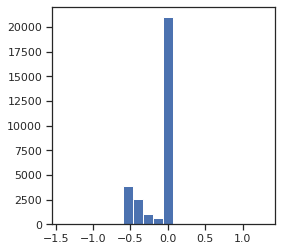

In [111]:
plt.hist(df_psi['MeanEncoding'].values, bins=20)

In [112]:
! pip install unidip

In [126]:
from unidip import UniDip
dat = np.msort(df_psi['MeanEncoding'].values)

intervals = UniDip(dat, alpha=0.005).run()
intervals

[(0, 29396)]

In [129]:
import unidip.dip as dip
print(dip.diptst(dat))

(0.05658484103814734, 0.000999000999000999, (9013, 28465))


(array([2.000e+00, 1.000e+00, 3.000e+00, 3.000e+01, 1.030e+02, 1.200e+01,
        5.296e+03, 1.594e+03, 8.930e+02, 1.079e+03]),
 array([-1.4173043 , -1.2746798 , -1.1320553 , -0.9894307 , -0.8468062 ,
        -0.70418173, -0.5615572 , -0.41893268, -0.27630815, -0.13368365,
         0.00894087], dtype=float32),
 <BarContainer object of 10 artists>)

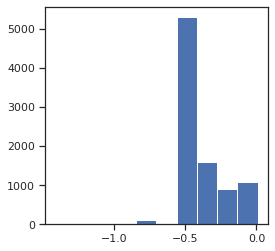

In [130]:
plt.hist(dat[:9013])

(array([857.,  20.,  10.,   0.,   0.,   7.,  26.,   9.,   2.,   1.]),
 array([0.01090946, 0.139259  , 0.26760852, 0.39595804, 0.52430755,
        0.6526571 , 0.78100663, 0.9093562 , 1.0377057 , 1.1660552 ,
        1.2944047 ], dtype=float32),
 <BarContainer object of 10 artists>)

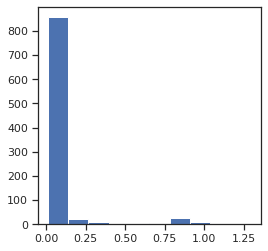

In [131]:
plt.hist(dat[28465:])

In [43]:
e_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[0]}_training']['MeanEncoding'].values
s_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[1]}_training']['MeanEncoding'].values
t_stat, p_val = stats.ttest_ind(e_plus, s_plus)

In [32]:
kmer_df['condlabels'] = condlabels
kmer_df.to_csv(f'{output_folder}kmer_df_{exp_name}.csv', index=False)

In [48]:
kmer_df = pd.DataFrame()
kmer_df['p_values'] = p_adj[1]
kmer_df['p.adj'] = p_values
kmer_df['t_values'] = t_values
kmer_df['labels'] = labels
kmer_df['kmer'] = kmers

In [54]:
kmer_df['kmer_name'] = kmer_label
kmer_df

,p_values,p.adj,t_values,labels,kmer,kmer_name
0,NaN,NaN,NaN,ERR3327117 vs ERR3327116,529,AAACC
1,NaN,NaN,NaN,ERR3327118 vs ERR3327116,529,AAACC
2,NaN,NaN,NaN,ERR3327115 vs ERR3327116,529,AAACC
3,NaN,NaN,NaN,ERR3327119 vs ERR3327116,529,AAACC
4,NaN,NaN,NaN,ERR3327114 vs ERR3327116,529,AAACC
...,...,...,...,...,...,...
447700,NaN,NaN,NaN,ERR3327119 vs ERR3327118,385,TTTTC
447701,NaN,NaN,NaN,ERR3327114 vs ERR3327118,385,TTTTC
447702,NaN,NaN,NaN,ERR3327119 vs ERR3327115,385,TTTTC
447703,NaN,NaN,NaN,ERR3327114 vs ERR3327115,385,TTTTC


In [60]:
p_kmers = kmer_df[kmer_df['p.adj'] > 0]
p_values = p_kmers['p.adj'].values
p_adj = multipletests(p_values, alpha=0.1, method='fdr_bh', returnsorted=False)
p_adj[1]

array([0.84297468, 0.84517583, 0.99416865, ..., 0.99673554, 0.91552559,
       0.872449  ])

In [61]:
p_kmers['p_values'] = p_values
p_kmers['p.adj'] = p_adj[1]


/tmp/ipykernel_1217242/146357167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_kmers['p_values'] = p_values
/tmp/ipykernel_1217242/146357167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_kmers['p.adj'] = p_adj[1]


,p_values,p.adj,t_values,labels,kmer,kmer_name
14667,2.907353e-15,1.239643e-10,12.713970,ERR3327119 vs ERR3327115,404,ACCGC
31684,1.065877e-08,1.262419e-04,-30.437840,ERR3327114 vs ERR3327116,18,AGCGC
33411,3.580009e-06,1.211469e-02,-35.934124,ERR3327115 vs ERR3327117,1254,AGCGC
48537,1.801527e-05,4.203999e-02,4.396002,ERR3327119 vs ERR3327115,192,ATCGC
55025,5.315733e-06,1.717070e-02,-4.948484,ERR3327118 vs ERR3327117,770,CAACA
...,...,...,...,...,...,...
429610,7.939769e-06,2.318750e-02,-4.912487,ERR3327119 vs ERR3327118,297,TGGGC
436435,2.828078e-06,1.021900e-02,4.810142,ERR3327119 vs ERR3327118,201,TTCAG
436439,1.439808e-05,3.448922e-02,-4.445326,ERR3327114 vs ERR3327119,201,TTCAG
446567,4.009910e-08,3.561986e-04,-5.820881,ERR3327115 vs ERR3327116,1535,TTTCA


In [103]:
sig_kmers = kmer_df[kmer_df['p.adj'] < 0.05]
#sig_kmers['kmer_name'].value_counts()


In [98]:
sig_kmers[sig_kmers['p.adj'] < 0.05]

,p_values,p.adj,t_values,labels,kmer,kmer_name
14667,2.907353e-15,1.239643e-10,12.713970,ERR3327119 vs ERR3327115,404,ACCGC
31684,1.065877e-08,1.262419e-04,-30.437840,ERR3327114 vs ERR3327116,18,AGCGC
33411,3.580009e-06,1.211469e-02,-35.934124,ERR3327115 vs ERR3327117,1254,AGCGC
48537,1.801527e-05,4.203999e-02,4.396002,ERR3327119 vs ERR3327115,192,ATCGC
55025,5.315733e-06,1.717070e-02,-4.948484,ERR3327118 vs ERR3327117,770,CAACA
...,...,...,...,...,...,...
429610,7.939769e-06,2.318750e-02,-4.912487,ERR3327119 vs ERR3327118,297,TGGGC
436435,2.828078e-06,1.021900e-02,4.810142,ERR3327119 vs ERR3327118,201,TTCAG
436439,1.439808e-05,3.448922e-02,-4.445326,ERR3327114 vs ERR3327119,201,TTCAG
446567,4.009910e-08,3.561986e-04,-5.820881,ERR3327115 vs ERR3327116,1535,TTTCA


In [62]:
 p_kmers.to_csv(f'{output_folder}KMER_{kmer_name}_{exp_name}.csv', index=False)

In [105]:
pseudo_infected = ['ERR3327116', 'ERR3327117', 'ERR3327118']
pseudo_fine = ['ERR3327115', 'ERR3327119', 'ERR3327114']

cond_dict = {'ERR3327116': 'pseudo_infected', 'ERR3327117': 'pseudo_infected', 'ERR3327118': 'pseudo_infected',
            'ERR3327115': 'pseudo_fine', 'ERR3327119': 'pseudo_fine', 'ERR3327114': 'pseudo_fine',
            }

# We expect, if check for overlapping modifications the ones from the "same" conditions should have more
# similar modifications
run_1s = []
run_2s = []
comparisons = []
run_comparisons = []
site_overlap = []
broad_label = []
gene_overlap = []
for label in set(p_kmers['labels'].values):
    run_comparison = label.split(' vs ')
    run_1 = run_comparison[0]
    run_2 = run_comparison[1]
    comparison = f'{cond_dict.get(run_1)}_{cond_dict.get(run_2)}'
    # Now want to check how many overlaps they have
    sig_sites = sig_kmers[sig_kmers['labels'] == label]['kmer'].values
    site_overlap.append(len(set(sig_sites))) #/(min([len(cond1s), len(cond2s)])))
    #gene_overlap.append(len(list(cond1s & cond2s))) #/(min([len(cond1s), len(cond2s)])))
    run_1s.append(run_1)
    run_2s.append(run_2)
    comparisons.append(comparison)
    run_comparisons.append(run_comparison)
    if cond_dict.get(run_2) == cond_dict.get(run_1):
        broad_label.append('Same')
    else:
        broad_label.append('Diff')
                    
box_df = pd.DataFrame()
box_df['Run1'] = run_1s
box_df['Run2'] = run_2s
box_df['Site overlap'] = site_overlap
#box_df['Gene overlap'] = gene_overlap
box_df['Comparisons'] = comparisons
box_df['Label'] = broad_label


In [132]:
sig_kmers

,p_values,p.adj,t_values,labels,kmer
35,0.737220,0.039420,2.076468,ERR3327115 vs ERR3327118,118
37,0.755016,0.047884,1.993994,ERR3327114 vs ERR3327118,118
43,0.735154,0.038083,2.141468,ERR3327115 vs ERR3327116,124
56,0.731761,0.037032,2.165752,ERR3327115 vs ERR3327118,160
78,0.719583,0.030844,2.175813,ERR3327115 vs ERR3327117,217
...,...,...,...,...,...
187906,0.320538,0.000977,-3.351770,ERR3327114 vs ERR3327117,198
187952,0.286726,0.000644,-3.519152,ERR3327115 vs ERR3327116,1327
187959,0.722938,0.032219,-2.169219,ERR3327115 vs ERR3327118,1327
187962,0.411560,0.002153,3.143970,ERR3327119 vs ERR3327115,1327


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Diff v.s. Same: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.700e+01


/tmp/ipykernel_1217242/3791554167.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'../figs/{title.replace(" ", "")}.svg', transparent=True, bbox='tight')


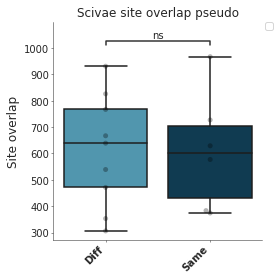

In [133]:
from sciviso import Boxplot
palette = ['#429EBD', '#053F5C', '#F7AD19', '#F27F0C', '#9FE7F5', 
                     '#EB3E1B', '#86112E', '#E99E75', '#44426E',
                     '#BBAAB8', '#e25dc9', '#7f3f98', '#6D6875', "#30b5b5",
                     '#489984', '#42c652', "#cc008e", "#70a300"]
opts = {'figsize': (4, 4), 'palette': palette, 
        'title_font_size': 12, 'axis_font_size': 10, 
        'label_font_size': 10, 's': 80, 'bins': 20, 'colour':'#053F5C', 
       'opacity': 0.7}

title = f'Scivae site overlap {exp_name}'

box = Boxplot(box_df, "Label", "Site overlap", ylabel='Site overlap', add_dots=True, config=opts,
                  add_stats=True, title=title)
box.plot()
plt.savefig(f'../figs/{title.replace(" ", "")}.svg', transparent=True, bbox='tight')
